In [1]:
# import zipfile
# with zipfile.ZipFile("first_50_test_set.zip", 'r') as zip_ref:
#     zip_ref.extractall("first_50_test_set")

In [2]:
# import tarfile
# for i in range(51):
#     tf = tarfile.open("depth_img/short_throw_depth_"+str(i)+".tar")
#     tf.extractall("depth_img/short_throw_depth_"+str(i)+"/")

In [3]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import re
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim

(450, 448)
[193, 111]


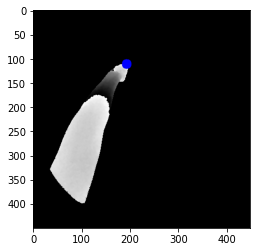

In [4]:
#for i in range(7):
img = cv2.imread("depth_img/short_throw_depth_0/"+str(5)+".pgm")

thresh1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret,thresh1 = cv2.threshold(thresh1,127,255,cv2.THRESH_BINARY)
print(thresh1.shape)
loc = None
for i in range(0,thresh1.shape[0]):
    vali = np.sum(thresh1[i,:])
    if vali > 0:
        for j in range(0,thresh1.shape[0]):
            valj = thresh1[i,j]
            if (valj>0):
                loc = [j,i]
                break
        break
cv2.circle(img,(loc[0],loc[1]), 10, (0,0,255), -1)
print(loc)
                
plt.imshow(img)



In [5]:
def find_hand(idx):
    loc = [0,0]
    len_ = 0
    root_path = "depth_img/short_throw_depth_"
    for file in os.listdir(root_path+str(idx)+"/"):
        if not file.endswith(".pgm"):
            continue
        path = os.path.join(root_path+str(idx), file)
        img = cv2.imread(path)
        thresh1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret,thresh1 = cv2.threshold(thresh1,127,255,cv2.THRESH_BINARY)
        #plt.figure()
        for i in range(0,thresh1.shape[0]):
            vali = np.sum(thresh1[i,:])
            if vali > 0:
                for j in range(0,thresh1.shape[0]):
                    valj = thresh1[i,j]
                    if (valj>0):
                        loc = [loc[0]+j,loc[1]+i]
                        #print(j,i)
                        #cv2.circle(img,(j,i), 10, (0,0,255), -1)
                        #plt.imshow(img)
                        break
                break
        len_+=1
    loc = [loc[0]/float(len_),loc[1]/float(len_),1.0]
    loc = [loc[0]/img.shape[1],loc[1]/img.shape[0],1.0]
    loc = np.array(loc)
    return loc
print(find_hand(30))


def load_img_ids():
    root_path = "bbox_img/"
    id_dict = dict()
    for file in os.listdir(root_path):
        if not file.endswith(".jpg"):
            continue
        val = re.findall(r'\d+',file)
        id_dict[int(val[0])] = int(val[1])
    return id_dict
        
id_dict = load_img_ids()
print(id_dict)


def find_gt(id_dict,idx):  
    IMG_SIZE = [360,480]
    annots = pd.read_csv(open('test.csv','r'))
    img_id = id_dict[idx]
    #print(img_id)
    bbox_str = annots.iloc[idx, 1]
    bboxes = re.findall("\d+\.\d+",bbox_str)
    bboxes = list(map(float,bboxes))
    gt = [(bboxes[0]+bboxes[2])/2,(bboxes[1]+bboxes[3])/2]
    gt = [gt[0]/IMG_SIZE[1],gt[1]/IMG_SIZE[0]]
    gt = np.array(gt)
    #gt = torch.from_numpy(gt)
    return gt

def build_dataset(id_dict):
    X = []
    Y = []
    
    for idx in range(51):
        X.append(find_hand(idx))
        Y.append(find_gt(id_dict,idx))
    X = np.array(X)
    Y = np.array(Y)
    return X,Y
        
    
X,Y = build_dataset(id_dict)
X = torch.from_numpy(X).float()
Y = torch.from_numpy(Y).float()
print(X.shape)
#find_gt(id_dict,0)

[0.41964286 0.30666667 1.        ]
{24: 9855, 38: 3487, 31: 1871, 40: 2997, 0: 19135, 43: 2997, 42: 31681, 4: 3096, 45: 2997, 46: 26143, 36: 17058, 41: 2997, 7: 2998, 28: 1871, 27: 1871, 9: 2998, 13: 2998, 26: 1871, 50: 26143, 25: 1871, 1: 19135, 5: 2998, 34: 1871, 2: 3096, 22: 9855, 14: 20160, 18: 9855, 44: 2997, 6: 2998, 32: 1871, 3: 27247, 8: 2998, 23: 9855, 29: 1871, 37: 6453, 12: 2998, 47: 26143, 49: 26143, 21: 9855, 33: 1871, 15: 37455, 10: 2998, 30: 1871, 11: 2998, 48: 1169, 16: 9855, 20: 9855, 19: 9855, 39: 2997, 35: 11536, 17: 37455}
torch.Size([51, 3])


In [6]:
def plot_out(net):
    net.eval()
    IMG_SIZE = [360,480]
    root_dir = "bbox_img/"
    with torch.no_grad():
        for i in range(41,51):
            output = net(X[i])
            output = output.numpy()
            gt = Y[i].numpy()
            img_id  = id_dict[i]
            plt.figure()
            img = cv2.imread(root_dir+str(i)+"_"+str(img_id)+".jpg")
            cv2.circle(img,(int(gt[0]*IMG_SIZE[1]),int(gt[1]*IMG_SIZE[0])), 10, (255,255,255), -1)
            cv2.circle(img,(int(output[0]*IMG_SIZE[1]),int(output[1]*IMG_SIZE[0])), 10, (255,255,0), -1)
            plt.imshow(img)
            
    net.train()

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.H =  nn.Parameter(torch.randn([3,3],requires_grad=True,dtype=torch.float32))
    
    def forward(self, x):
#         one_vec = torch.ones((x.shape[0],),dtype=torch.float32,requires_grad=False).float()
#         print(one_vec.shape)
#         x = torch.cat([x,one_vec],dim=0)
        #print(self.H)
        #print("Before: ",x[0])
        #print("Before: ",x)
        x = self.H.matmul(x)
        #print("After: ",x)
        x_ = x.clone()
        norm = x_[2]
        x[0] = x_[0]/norm
        x[1] = x_[1]/norm
        x = x[0:2]
        return x

H
Epoch:  0
Loss:  0.01261418238740589
Epoch:  1
Loss:  0.012598604753948165
Epoch:  2
Loss:  0.012598960422183154
Epoch:  3
Loss:  0.012599530916995718
Epoch:  4
Loss:  0.012600033248454566
Epoch:  5
Loss:  0.01260045217051811
Epoch:  6
Loss:  0.012600775982937193
Epoch:  7
Loss:  0.012601016825501575
Epoch:  8
Loss:  0.012601252214371925
Epoch:  9
Loss:  0.012601408531700144
Epoch:  10
Loss:  0.01260154027666431
Epoch:  11
Loss:  0.0126016446200083
Epoch:  12
Loss:  0.012601734463969479
Epoch:  13
Loss:  0.012601800038610236
Epoch:  14
Loss:  0.012601846465877316
Epoch:  15
Loss:  0.012601879387148074
Epoch:  16
Loss:  0.012601910053708707
Epoch:  17
Loss:  0.012601921062414477
Epoch:  18
Loss:  0.012601941119137337
Epoch:  19
Loss:  0.012601961713116908
Epoch:  20
Loss:  0.012601979945102357
Epoch:  21
Loss:  0.012601987546149758
Epoch:  22
Loss:  0.012601996649136709
Epoch:  23
Loss:  0.012601999199032434
Epoch:  24
Loss:  0.012602001330778876
Epoch:  25
Loss:  0.0126020019238058
E

Epoch:  217
Loss:  0.012601971458097978
Epoch:  218
Loss:  0.012601971040603531
Epoch:  219
Loss:  0.01260197115047049
Epoch:  220
Loss:  0.01260196926585195
Epoch:  221
Loss:  0.012601971180738475
Epoch:  222
Loss:  0.012601969242568884
Epoch:  223
Loss:  0.012601972576703702
Epoch:  224
Loss:  0.012601969414863561
Epoch:  225
Loss:  0.012601963814668125
Epoch:  226
Loss:  0.012601967123919167
Epoch:  227
Loss:  0.012601969646530051
Epoch:  228
Loss:  0.012601968330272939
Epoch:  229
Loss:  0.012601967521331971
Epoch:  230
Loss:  0.012601967988775869
Epoch:  231
Loss:  0.012601968402741477
Epoch:  232
Loss:  0.012601965242211008
Epoch:  233
Loss:  0.012601968992348701
Epoch:  234
Loss:  0.012601967263726692
Epoch:  235
Loss:  0.0126019672624534
Epoch:  236
Loss:  0.01260196547562373
Epoch:  237
Loss:  0.012601965929898143
Epoch:  238
Loss:  0.01260196644885582
Epoch:  239
Loss:  0.01260196660819929
Epoch:  240
Loss:  0.012601966765505495
Epoch:  241
Loss:  0.012601963936322135
Epoch: 

Loss:  0.012601925130147719
Epoch:  426
Loss:  0.012601923873153282
Epoch:  427
Loss:  0.012601922490575816
Epoch:  428
Loss:  0.012601921244204277
Epoch:  429
Loss:  0.012601925574381312
Epoch:  430
Loss:  0.012601923813890607
Epoch:  431
Loss:  0.012601923946058378
Epoch:  432
Loss:  0.012601922707108314
Epoch:  433
Loss:  0.012601921702480468
Epoch:  434
Loss:  0.012601924727678125
Epoch:  435
Loss:  0.012601923927068128
Epoch:  436
Loss:  0.012601922254543752
Epoch:  437
Loss:  0.01260192303067015
Epoch:  438
Loss:  0.012601921804380254
Epoch:  439
Loss:  0.012601922369576642
Epoch:  440
Loss:  0.012601920247470843
Epoch:  441
Loss:  0.012601922204012225
Epoch:  442
Loss:  0.012601921349523764
Epoch:  443
Loss:  0.01260192197143624
Epoch:  444
Loss:  0.012601919754633855
Epoch:  445
Loss:  0.012601919515545887
Epoch:  446
Loss:  0.012601918744003342
Epoch:  447
Loss:  0.012601919826665834
Epoch:  448
Loss:  0.012601920334345778
Epoch:  449
Loss:  0.012601919058324711
Epoch:  450
Lo

Loss:  0.012601887749806338
Epoch:  643
Loss:  0.012601885576950736
Epoch:  644
Loss:  0.012601886047013977
Epoch:  645
Loss:  0.012601884426258038
Epoch:  646
Loss:  0.012601882683302392
Epoch:  647
Loss:  0.012601884581890772
Epoch:  648
Loss:  0.01260188546097197
Epoch:  649
Loss:  0.012601884524701745
Epoch:  650
Loss:  0.012601882982817187
Epoch:  651
Loss:  0.012601884477044223
Epoch:  652
Loss:  0.012601883247698424
Epoch:  653
Loss:  0.012601883137249388
Epoch:  654
Loss:  0.012601885105177645
Epoch:  655
Loss:  0.012601882629132888
Epoch:  656
Loss:  0.012601884331888868
Epoch:  657
Loss:  0.012601884020368744
Epoch:  658
Loss:  0.012601880532602082
Epoch:  659
Loss:  0.0126018867881794
Epoch:  660
Loss:  0.012601885035983286
Epoch:  661
Loss:  0.012601881048103678
Epoch:  662
Loss:  0.012601885853437125
Epoch:  663
Loss:  0.012601880760412314
Epoch:  664
Loss:  0.01260188269232458
Epoch:  665
Loss:  0.012601881496375427
Epoch:  666
Loss:  0.012601880811853334
Epoch:  667
Loss

Loss:  0.012601842630429018
Epoch:  854
Loss:  0.012601839668350294
Epoch:  855
Loss:  0.01260183924998273
Epoch:  856
Loss:  0.012601841050563962
Epoch:  857
Loss:  0.012601840560600977
Epoch:  858
Loss:  0.012601841690557194
Epoch:  859
Loss:  0.012601842195545032
Epoch:  860
Loss:  0.012601839949493297
Epoch:  861
Loss:  0.012601841027499177
Epoch:  862
Loss:  0.0126018406663934
Epoch:  863
Loss:  0.012601839274830128
Epoch:  864
Loss:  0.012601838227346888
Epoch:  865
Loss:  0.01260183962433075
Epoch:  866
Loss:  0.012601837126603642
Epoch:  867
Loss:  0.012601838363698334
Epoch:  868
Loss:  0.012601835678651696
Epoch:  869
Loss:  0.01260183744452661
Epoch:  870
Loss:  0.01260183885184233
Epoch:  871
Loss:  0.01260183629954554
Epoch:  872
Loss:  0.01260183698614128
Epoch:  873
Loss:  0.012601835608256807
Epoch:  874
Loss:  0.012601835732166364
Epoch:  875
Loss:  0.012601836055291643
Epoch:  876
Loss:  0.01260183555779804
Epoch:  877
Loss:  0.012601837403890386
Epoch:  878
Loss:  0.

Loss:  0.012601800414049649
Epoch:  1059
Loss:  0.012601801127239014
Epoch:  1060
Loss:  0.012601800341071794
Epoch:  1061
Loss:  0.012601801323071413
Epoch:  1062
Loss:  0.012601799517069594
Epoch:  1063
Loss:  0.012601799199946981
Epoch:  1064
Loss:  0.012601799422664045
Epoch:  1065
Loss:  0.012601800931151956
Epoch:  1066
Loss:  0.012601798004980083
Epoch:  1067
Loss:  0.01260179948680161
Epoch:  1068
Loss:  0.012601797187744523
Epoch:  1069
Loss:  0.012601798220966885
Epoch:  1070
Loss:  0.012601801547643844
Epoch:  1071
Loss:  0.012601796473754803
Epoch:  1072
Loss:  0.012601794522888668
Epoch:  1073
Loss:  0.012601796732160437
Epoch:  1074
Loss:  0.012601797077295487
Epoch:  1075
Loss:  0.012601795069713262
Epoch:  1076
Loss:  0.012601794804322709
Epoch:  1077
Loss:  0.012601794541697018
Epoch:  1078
Loss:  0.012601795033770031
Epoch:  1079
Loss:  0.012601794035981584
Epoch:  1080
Loss:  0.012601793637586525
Epoch:  1081
Loss:  0.012601795419759582
Epoch:  1082
Loss:  0.01260179

Loss:  0.012601756371659577
Epoch:  1262
Loss:  0.012601756428812222
Epoch:  1263
Loss:  0.01260175705436268
Epoch:  1264
Loss:  0.012601755743817193
Epoch:  1265
Loss:  0.01260175442414038
Epoch:  1266
Loss:  0.012601756563090021
Epoch:  1267
Loss:  0.012601755810283066
Epoch:  1268
Loss:  0.012601756221338292
Epoch:  1269
Loss:  0.012601754737697774
Epoch:  1270
Loss:  0.012601754571624041
Epoch:  1271
Loss:  0.012601754461138625
Epoch:  1272
Loss:  0.012601754575771338
Epoch:  1273
Loss:  0.012601753946073586
Epoch:  1274
Loss:  0.012601752809096069
Epoch:  1275
Loss:  0.012601755329087609
Epoch:  1276
Loss:  0.012601751531110494
Epoch:  1277
Loss:  0.012601753535018361
Epoch:  1278
Loss:  0.012601752945702174
Epoch:  1279
Loss:  0.012601753917406313
Epoch:  1280
Loss:  0.012601754065399292
Epoch:  1281
Loss:  0.012601751838228665
Epoch:  1282
Loss:  0.01260175231476751
Epoch:  1283
Loss:  0.012601753744820598
Epoch:  1284
Loss:  0.012601751240363229
Epoch:  1285
Loss:  0.0126017526

Loss:  0.012601713511321578
Epoch:  1465
Loss:  0.012601714988995809
Epoch:  1466
Loss:  0.012601710930539411
Epoch:  1467
Loss:  0.01260170932589972
Epoch:  1468
Loss:  0.012601709183618368
Epoch:  1469
Loss:  0.012601711595998495
Epoch:  1470
Loss:  0.012601709891969222
Epoch:  1471
Loss:  0.012601709333721374
Epoch:  1472
Loss:  0.012601711438255734
Epoch:  1473
Loss:  0.012601708114270877
Epoch:  1474
Loss:  0.012601710155613545
Epoch:  1475
Loss:  0.012601706756831844
Epoch:  1476
Loss:  0.0126017101634352
Epoch:  1477
Loss:  0.012601710406343045
Epoch:  1478
Loss:  0.012601707686408191
Epoch:  1479
Loss:  0.012601708527981828
Epoch:  1480
Loss:  0.01260170942725381
Epoch:  1481
Loss:  0.01260171020461712
Epoch:  1482
Loss:  0.01260170498793741
Epoch:  1483
Loss:  0.012601705702218169
Epoch:  1484
Loss:  0.012601710000017191
Epoch:  1485
Loss:  0.01260170675257541
Epoch:  1486
Loss:  0.012601705600900459
Epoch:  1487
Loss:  0.012601707628346049
Epoch:  1488
Loss:  0.01260170596571

Loss:  0.012601655691469205
Epoch:  1670
Loss:  0.012601656999686383
Epoch:  1671
Loss:  0.012601654741993117
Epoch:  1672
Loss:  0.012601657647719549
Epoch:  1673
Loss:  0.012601657005179732
Epoch:  1674
Loss:  0.012601657284067187
Epoch:  1675
Loss:  0.012601656218212156
Epoch:  1676
Loss:  0.012601654587597296
Epoch:  1677
Loss:  0.012601653677229478
Epoch:  1678
Loss:  0.012601655375074189
Epoch:  1679
Loss:  0.012601655343532912
Epoch:  1680
Loss:  0.012601655310936622
Epoch:  1681
Loss:  0.012601653548117611
Epoch:  1682
Loss:  0.012601653868150606
Epoch:  1683
Loss:  0.012601652686134912
Epoch:  1684
Loss:  0.012601651823424619
Epoch:  1685
Loss:  0.012601654482823505
Epoch:  1686
Loss:  0.012601651252698503
Epoch:  1687
Loss:  0.012601653239034932
Epoch:  1688
Loss:  0.012601653168676421
Epoch:  1689
Loss:  0.012601656358165202
Epoch:  1690
Loss:  0.012601653794990852
Epoch:  1691
Loss:  0.012601651382101408
Epoch:  1692
Loss:  0.012601652440789621
Epoch:  1693
Loss:  0.0126016

Loss:  0.012601609827543143
Epoch:  1875
Loss:  0.012601610628480557
Epoch:  1876
Loss:  0.012601612175712944
Epoch:  1877
Loss:  0.012601608498807764
Epoch:  1878
Loss:  0.012601609537232434
Epoch:  1879
Loss:  0.012601608546756324
Epoch:  1880
Loss:  0.012601609592675232
Epoch:  1881
Loss:  0.012601611102982134
Epoch:  1882
Loss:  0.012601607910874009
Epoch:  1883
Loss:  0.012601608632940043
Epoch:  1884
Loss:  0.012601610489582526
Epoch:  1885
Loss:  0.01260160671226913
Epoch:  1886
Loss:  0.012601605698218919
Epoch:  1887
Loss:  0.012601606132520829
Epoch:  1888
Loss:  0.012601607518954552
Epoch:  1889
Loss:  0.012601604482842959
Epoch:  1890
Loss:  0.01260160617861402
Epoch:  1891
Loss:  0.012601606666794395
Epoch:  1892
Loss:  0.012601604196752304
Epoch:  1893
Loss:  0.012601604639421567
Epoch:  1894
Loss:  0.012601605171548727
Epoch:  1895
Loss:  0.012601606438147428
Epoch:  1896
Loss:  0.01260160429894313
Epoch:  1897
Loss:  0.012601603106049878
Epoch:  1898
Loss:  0.0126016037

Loss:  0.012601563506104868
Epoch:  2081
Loss:  0.012601560694565705
Epoch:  2082
Loss:  0.012601559762188116
Epoch:  2083
Loss:  0.01260156102518522
Epoch:  2084
Loss:  0.012601562653944711
Epoch:  2085
Loss:  0.01260155723470234
Epoch:  2086
Loss:  0.012601559103677573
Epoch:  2087
Loss:  0.012601562387062585
Epoch:  2088
Loss:  0.01260155841915548
Epoch:  2089
Loss:  0.01260155978074181
Epoch:  2090
Loss:  0.01260155987001781
Epoch:  2091
Loss:  0.012601560617840733
Epoch:  2092
Loss:  0.012601559714457835
Epoch:  2093
Loss:  0.012601555505498255
Epoch:  2094
Loss:  0.012601558335445589
Epoch:  2095
Loss:  0.012601558930437023
Epoch:  2096
Loss:  0.012601559177055606
Epoch:  2097
Loss:  0.012601554245047736
Epoch:  2098
Loss:  0.01260155709067476
Epoch:  2099
Loss:  0.012601557163179677
Epoch:  2100
Loss:  0.012601556675508618
Epoch:  2101
Loss:  0.012601557315865647
Epoch:  2102
Loss:  0.012601557472662535
Epoch:  2103
Loss:  0.012601557078087354
Epoch:  2104
Loss:  0.0126015577173

Loss:  0.012601511030043184
Epoch:  2290
Loss:  0.012601512358742184
Epoch:  2291
Loss:  0.012601508263251161
Epoch:  2292
Loss:  0.012601507310027954
Epoch:  2293
Loss:  0.012601507572362607
Epoch:  2294
Loss:  0.012601510871572828
Epoch:  2295
Loss:  0.012601509965861624
Epoch:  2296
Loss:  0.012601508984116662
Epoch:  2297
Loss:  0.012601509059750242
Epoch:  2298
Loss:  0.012601509014930344
Epoch:  2299
Loss:  0.012601508861771436
Epoch:  2300
Loss:  0.012601509027372232
Epoch:  2301
Loss:  0.012601506615246762
Epoch:  2302
Loss:  0.012601508477891911
Epoch:  2303
Loss:  0.012601505969541904
Epoch:  2304
Loss:  0.01260150597005122
Epoch:  2305
Loss:  0.012601506595601678
Epoch:  2306
Loss:  0.012601507010804197
Epoch:  2307
Loss:  0.012601504998056044
Epoch:  2308
Loss:  0.012601502769102808
Epoch:  2309
Loss:  0.012601505277198157
Epoch:  2310
Loss:  0.012601503185105684
Epoch:  2311
Loss:  0.012601502533980237
Epoch:  2312
Loss:  0.012601503982950816
Epoch:  2313
Loss:  0.01260150

Loss:  0.01260145738535357
Epoch:  2491
Loss:  0.01260145825381187
Epoch:  2492
Loss:  0.012601457690034295
Epoch:  2493
Loss:  0.012601457103628491
Epoch:  2494
Loss:  0.012601456950724241
Epoch:  2495
Loss:  0.012601459335710387
Epoch:  2496
Loss:  0.012601455316289503
Epoch:  2497
Loss:  0.012601459037505265
Epoch:  2498
Loss:  0.012601456586853601
Epoch:  2499
Loss:  0.012601455404073932
Epoch:  2500
Loss:  0.012601455801486736
Epoch:  2501
Loss:  0.012601454649302467
Epoch:  2502
Loss:  0.012601456644661084
Epoch:  2503
Loss:  0.012601456936790783
Epoch:  2504
Loss:  0.012601453801289608
Epoch:  2505
Loss:  0.012601454566975008
Epoch:  2506
Loss:  0.01260145550877496
Epoch:  2507
Loss:  0.012601455202930083
Epoch:  2508
Loss:  0.012601454034120252
Epoch:  2509
Loss:  0.012601453561801463
Epoch:  2510
Loss:  0.012601452840026468
Epoch:  2511
Loss:  0.0126014553510322
Epoch:  2512
Loss:  0.012601453723546001
Epoch:  2513
Loss:  0.012601452564776992
Epoch:  2514
Loss:  0.012601453679

Loss:  0.012601411645810003
Epoch:  2693
Loss:  0.012601408696173166
Epoch:  2694
Loss:  0.012601409316266654
Epoch:  2695
Loss:  0.012601412258736672
Epoch:  2696
Loss:  0.012601411830328289
Epoch:  2697
Loss:  0.012601411562936846
Epoch:  2698
Loss:  0.012601411628857022
Epoch:  2699
Loss:  0.01260141016129637
Epoch:  2700
Loss:  0.012601410915667657
Epoch:  2701
Loss:  0.01260140997612325
Epoch:  2702
Loss:  0.012601409225935641
Epoch:  2703
Loss:  0.012601408342452486
Epoch:  2704
Loss:  0.012601408874688786
Epoch:  2705
Loss:  0.012601408441951208
Epoch:  2706
Loss:  0.012601412022850127
Epoch:  2707
Loss:  0.01260140709913685
Epoch:  2708
Loss:  0.01260140703394427
Epoch:  2709
Loss:  0.012601407280744752
Epoch:  2710
Loss:  0.01260140573940589
Epoch:  2711
Loss:  0.012601409359449462
Epoch:  2712
Loss:  0.012601408204936888
Epoch:  2713
Loss:  0.012601406447356567
Epoch:  2714
Loss:  0.012601406322719413
Epoch:  2715
Loss:  0.012601408202099264
Epoch:  2716
Loss:  0.012601409548

Loss:  0.01260136293596588
Epoch:  2894
Loss:  0.012601364043475768
Epoch:  2895
Loss:  0.012601367152528837
Epoch:  2896
Loss:  0.012601361939778144
Epoch:  2897
Loss:  0.012601365169757628
Epoch:  2898
Loss:  0.012601363180619956
Epoch:  2899
Loss:  0.012601361227643793
Epoch:  2900
Loss:  0.012601361773886311
Epoch:  2901
Loss:  0.012601361400556925
Epoch:  2902
Loss:  0.012601361404122144
Epoch:  2903
Loss:  0.012601360135122378
Epoch:  2904
Loss:  0.012601364607726283
Epoch:  2905
Loss:  0.012601359054278873
Epoch:  2906
Loss:  0.012601362271998368
Epoch:  2907
Loss:  0.01260136202447029
Epoch:  2908
Loss:  0.01260135663786059
Epoch:  2909
Loss:  0.012601363086505444
Epoch:  2910
Loss:  0.01260135769523913
Epoch:  2911
Loss:  0.012601360325606947
Epoch:  2912
Loss:  0.012601360453263624
Epoch:  2913
Loss:  0.012601359846303239
Epoch:  2914
Loss:  0.012601354776707012
Epoch:  2915
Loss:  0.012601356491359184
Epoch:  2916
Loss:  0.012601362259374582
Epoch:  2917
Loss:  0.01260135628

Loss:  0.012601314243911475
Epoch:  3102
Loss:  0.012601316075888462
Epoch:  3103
Loss:  0.012601315378888103
Epoch:  3104
Loss:  0.012601314364146673
Epoch:  3105
Loss:  0.012601312789738585
Epoch:  3106
Loss:  0.01260131486116734
Epoch:  3107
Loss:  0.012601315596148197
Epoch:  3108
Loss:  0.012601314336061478
Epoch:  3109
Loss:  0.012601312314327515
Epoch:  3110
Loss:  0.01260131434770301
Epoch:  3111
Loss:  0.012601311903345049
Epoch:  3112
Loss:  0.01260131068098417
Epoch:  3113
Loss:  0.012601311996477307
Epoch:  3114
Loss:  0.012601311812068161
Epoch:  3115
Loss:  0.012601313971608762
Epoch:  3116
Loss:  0.012601311639300547
Epoch:  3117
Loss:  0.012601311488615465
Epoch:  3118
Loss:  0.012601311662438093
Epoch:  3119
Loss:  0.012601312591432361
Epoch:  3120
Loss:  0.012601312176993815
Epoch:  3121
Loss:  0.01260131174545677
Epoch:  3122
Loss:  0.012601310441204987
Epoch:  3123
Loss:  0.012601310490026663
Epoch:  3124
Loss:  0.012601310924183054
Epoch:  3125
Loss:  0.01260131173

Loss:  0.012601258717513702
Epoch:  3308
Loss:  0.012601262726893764
Epoch:  3309
Loss:  0.012601259630318964
Epoch:  3310
Loss:  0.01260125936147233
Epoch:  3311
Loss:  0.01260125964989129
Epoch:  3312
Loss:  0.012601259036637202
Epoch:  3313
Loss:  0.012601260467454268
Epoch:  3314
Loss:  0.01260126042907359
Epoch:  3315
Loss:  0.012601257714013627
Epoch:  3316
Loss:  0.012601259051698434
Epoch:  3317
Loss:  0.012601259425427997
Epoch:  3318
Loss:  0.012601256125017245
Epoch:  3319
Loss:  0.01260125634031283
Epoch:  3320
Loss:  0.012601259277980717
Epoch:  3321
Loss:  0.01260125501674338
Epoch:  3322
Loss:  0.012601256535235734
Epoch:  3323
Loss:  0.012601257434725994
Epoch:  3324
Loss:  0.012601256731104514
Epoch:  3325
Loss:  0.012601254487708501
Epoch:  3326
Loss:  0.012601257120695663
Epoch:  3327
Loss:  0.012601254401561164
Epoch:  3328
Loss:  0.012601257401656766
Epoch:  3329
Loss:  0.012601253712891775
Epoch:  3330
Loss:  0.012601255477347877
Epoch:  3331
Loss:  0.012601254597

Loss:  0.012601216036709956
Epoch:  3513
Loss:  0.012601213175621524
Epoch:  3514
Loss:  0.012601212847330316
Epoch:  3515
Loss:  0.01260121191990038
Epoch:  3516
Loss:  0.012601215756585588
Epoch:  3517
Loss:  0.012601211161636457
Epoch:  3518
Loss:  0.012601214162059478
Epoch:  3519
Loss:  0.012601212946683517
Epoch:  3520
Loss:  0.012601214202077245
Epoch:  3521
Loss:  0.012601212219888112
Epoch:  3522
Loss:  0.012601209153508534
Epoch:  3523
Loss:  0.012601211545079422
Epoch:  3524
Loss:  0.012601211527180568
Epoch:  3525
Loss:  0.01260121421491931
Epoch:  3526
Loss:  0.012601212089903129
Epoch:  3527
Loss:  0.012601209919193935
Epoch:  3528
Loss:  0.01260121167601028
Epoch:  3529
Loss:  0.012601209193890099
Epoch:  3530
Loss:  0.012601209755484889
Epoch:  3531
Loss:  0.01260120942912181
Epoch:  3532
Loss:  0.012601210291941244
Epoch:  3533
Loss:  0.012601207653206074
Epoch:  3534
Loss:  0.01260120719063707
Epoch:  3535
Loss:  0.012601205660175765
Epoch:  3536
Loss:  0.012601205326

Loss:  0.012601164679726934
Epoch:  3724
Loss:  0.01260115717042936
Epoch:  3725
Loss:  0.012601161488746584
Epoch:  3726
Loss:  0.012601158430115902
Epoch:  3727
Loss:  0.01260116016237589
Epoch:  3728
Loss:  0.01260115284439962
Epoch:  3729
Loss:  0.012601156590571918
Epoch:  3730
Loss:  0.012601157497483655
Epoch:  3731
Loss:  0.012601154469011817
Epoch:  3732
Loss:  0.012601156762866595
Epoch:  3733
Loss:  0.012601154975491226
Epoch:  3734
Loss:  0.012601153902760415
Epoch:  3735
Loss:  0.012601154402218526
Epoch:  3736
Loss:  0.012601154156945994
Epoch:  3737
Loss:  0.012601156253149384
Epoch:  3738
Loss:  0.012601154444782879
Epoch:  3739
Loss:  0.012601152340248518
Epoch:  3740
Loss:  0.012601155657357595
Epoch:  3741
Loss:  0.01260115391418367
Epoch:  3742
Loss:  0.012601153124887788
Epoch:  3743
Loss:  0.012601151919589028
Epoch:  3744
Loss:  0.012601152562965581
Epoch:  3745
Loss:  0.01260115268480149
Epoch:  3746
Loss:  0.012601150628797768
Epoch:  3747
Loss:  0.012601150749

Loss:  0.012601110069881542
Epoch:  3930
Loss:  0.012601109104507487
Epoch:  3931
Loss:  0.012601109653514868
Epoch:  3932
Loss:  0.012601109346105659
Epoch:  3933
Loss:  0.012601109826100583
Epoch:  3934
Loss:  0.012601109146635281
Epoch:  3935
Loss:  0.012601108659619059
Epoch:  3936
Loss:  0.012601111009644228
Epoch:  3937
Loss:  0.012601109221504885
Epoch:  3938
Loss:  0.012601107442606008
Epoch:  3939
Loss:  0.012601107204682193
Epoch:  3940
Loss:  0.012601109226852713
Epoch:  3941
Loss:  0.012601108990020293
Epoch:  3942
Loss:  0.012601108315211605
Epoch:  3943
Loss:  0.01260110821633134
Epoch:  3944
Loss:  0.012601105551075307
Epoch:  3945
Loss:  0.012601108595190454
Epoch:  3946
Loss:  0.012601104834247963
Epoch:  3947
Loss:  0.012601107796144788
Epoch:  3948
Loss:  0.012601106314141361
Epoch:  3949
Loss:  0.012601104470522841
Epoch:  3950
Loss:  0.012601106496113061
Epoch:  3951
Loss:  0.012601103308988969
Epoch:  3952
Loss:  0.012601104992354522
Epoch:  3953
Loss:  0.01260110

Loss:  0.01260106055829965
Epoch:  4131
Loss:  0.012601063198962948
Epoch:  4132
Loss:  0.012601059756489121
Epoch:  4133
Loss:  0.012601060773959035
Epoch:  4134
Loss:  0.012601059413063921
Epoch:  4135
Loss:  0.012601062083631405
Epoch:  4136
Loss:  0.01260105974477483
Epoch:  4137
Loss:  0.012601060350134504
Epoch:  4138
Loss:  0.012601061594614294
Epoch:  4139
Loss:  0.012601059975204408
Epoch:  4140
Loss:  0.012601059629050724
Epoch:  4141
Loss:  0.012601062001594983
Epoch:  4142
Loss:  0.012601060200613573
Epoch:  4143
Loss:  0.012601059920416446
Epoch:  4144
Loss:  0.012601058136933716
Epoch:  4145
Loss:  0.012601057618485356
Epoch:  4146
Loss:  0.012601059471053304
Epoch:  4147
Loss:  0.012601061122950341
Epoch:  4148
Loss:  0.012601058736763662
Epoch:  4149
Loss:  0.012601060473607505
Epoch:  4150
Loss:  0.012601057050997042
Epoch:  4151
Loss:  0.012601058173240745
Epoch:  4152
Loss:  0.012601059759945202
Epoch:  4153
Loss:  0.012601058202708373
Epoch:  4154
Loss:  0.012601059

Loss:  0.012601019299254404
Epoch:  4332
Loss:  0.012601021501031937
Epoch:  4333
Loss:  0.012601019260800967
Epoch:  4334
Loss:  0.012601017232409504
Epoch:  4335
Loss:  0.012601018655368534
Epoch:  4336
Loss:  0.012601017478373252
Epoch:  4337
Loss:  0.012601018499335623
Epoch:  4338
Loss:  0.012601017338311067
Epoch:  4339
Loss:  0.012601016613771207
Epoch:  4340
Loss:  0.012601018148852745
Epoch:  4341
Loss:  0.012601014709143783
Epoch:  4342
Loss:  0.012601017235756445
Epoch:  4343
Loss:  0.012601018874447619
Epoch:  4344
Loss:  0.012601015956315678
Epoch:  4345
Loss:  0.012601013554995006
Epoch:  4346
Loss:  0.012601018725436007
Epoch:  4347
Loss:  0.01260101489184308
Epoch:  4348
Loss:  0.01260101484720508
Epoch:  4349
Loss:  0.012601016420012457
Epoch:  4350
Loss:  0.012601016565895407
Epoch:  4351
Loss:  0.01260101536867296
Epoch:  4352
Loss:  0.012601015362888575
Epoch:  4353
Loss:  0.012601014000392752
Epoch:  4354
Loss:  0.012601013715175214
Epoch:  4355
Loss:  0.0126010130

Loss:  0.012600970447310829
Epoch:  4542
Loss:  0.01260097091064381
Epoch:  4543
Loss:  0.012600970272615086
Epoch:  4544
Loss:  0.012600969555096526
Epoch:  4545
Loss:  0.012600972320324217
Epoch:  4546
Loss:  0.012600968463884784
Epoch:  4547
Loss:  0.012600970503845019
Epoch:  4548
Loss:  0.01260096742389578
Epoch:  4549
Loss:  0.012600970219064039
Epoch:  4550
Loss:  0.012600968589213153
Epoch:  4551
Loss:  0.012600970211606182
Epoch:  4552
Loss:  0.012600967855796626
Epoch:  4553
Loss:  0.012600969270642963
Epoch:  4554
Loss:  0.012600967444450361
Epoch:  4555
Loss:  0.012600970198072901
Epoch:  4556
Loss:  0.01260096821704792
Epoch:  4557
Loss:  0.012600968901242595
Epoch:  4558
Loss:  0.012600967948201288
Epoch:  4559
Loss:  0.01260096746194904
Epoch:  4560
Loss:  0.012600966690952191
Epoch:  4561
Loss:  0.012600968983897474
Epoch:  4562
Loss:  0.012600966992431495
Epoch:  4563
Loss:  0.012600966133722977
Epoch:  4564
Loss:  0.012600967547332403
Epoch:  4565
Loss:  0.01260096905

Loss:  0.012600931858432887
Epoch:  4755
Loss:  0.012600928639149061
Epoch:  4756
Loss:  0.012600931371052866
Epoch:  4757
Loss:  0.0126009310939844
Epoch:  4758
Loss:  0.012600932485183876
Epoch:  4759
Loss:  0.012600927885177953
Epoch:  4760
Loss:  0.012600927264320489
Epoch:  4761
Loss:  0.012600930451408204
Epoch:  4762
Loss:  0.012600926552295277
Epoch:  4763
Loss:  0.012600928091742389
Epoch:  4764
Loss:  0.012600925933402323
Epoch:  4765
Loss:  0.01260092809683556
Epoch:  4766
Loss:  0.012600927543498983
Epoch:  4767
Loss:  0.012600926462437202
Epoch:  4768
Loss:  0.012600926418999734
Epoch:  4769
Loss:  0.01260092874570546
Epoch:  4770
Loss:  0.012600927170642534
Epoch:  4771
Loss:  0.012600930160988354
Epoch:  4772
Loss:  0.01260092317534145
Epoch:  4773
Loss:  0.012600926955419709
Epoch:  4774
Loss:  0.01260092581025674
Epoch:  4775
Loss:  0.01260092621381773
Epoch:  4776
Loss:  0.012600925662809459
Epoch:  4777
Loss:  0.012600923266581958
Epoch:  4778
Loss:  0.01260092625307

Loss:  0.012600881239195586
Epoch:  4963
Loss:  0.012600882882979931
Epoch:  4964
Loss:  0.012600883423183405
Epoch:  4965
Loss:  0.01260088237511809
Epoch:  4966
Loss:  0.01260088258273754
Epoch:  4967
Loss:  0.012600881373546145
Epoch:  4968
Loss:  0.012600878823250242
Epoch:  4969
Loss:  0.012600882409205951
Epoch:  4970
Loss:  0.01260087883372762
Epoch:  4971
Loss:  0.01260088170060044
Epoch:  4972
Loss:  0.012600881342077628
Epoch:  4973
Loss:  0.012600878871744499
Epoch:  4974
Loss:  0.012600878523699066
Epoch:  4975
Loss:  0.012600880297031835
Epoch:  4976
Loss:  0.012600880284589949
Epoch:  4977
Loss:  0.012600877337827115
Epoch:  4978
Loss:  0.012600878378216294
Epoch:  4979
Loss:  0.012600878657613066
Epoch:  4980
Loss:  0.012600878555167583
Epoch:  4981
Loss:  0.012600877422446501
Epoch:  4982
Loss:  0.01260087714461406
Epoch:  4983
Loss:  0.012600877465119993
Epoch:  4984
Loss:  0.012600878855919291
Epoch:  4985
Loss:  0.012600878482262488
Epoch:  4986
Loss:  0.012600875145

Loss:  0.012600838305079378
Epoch:  5170
Loss:  0.012600836991914548
Epoch:  5171
Loss:  0.012600837802965543
Epoch:  5172
Loss:  0.012600835149532941
Epoch:  5173
Loss:  0.012600836947458447
Epoch:  5174
Loss:  0.012600835397606716
Epoch:  5175
Loss:  0.012600838522193953
Epoch:  5176
Loss:  0.012600835897901562
Epoch:  5177
Loss:  0.012600834888216924
Epoch:  5178
Loss:  0.012600836876918037
Epoch:  5179
Loss:  0.012600835731391272
Epoch:  5180
Loss:  0.012600836597994203
Epoch:  5181
Loss:  0.012600835319462931
Epoch:  5182
Loss:  0.012600834253898938
Epoch:  5183
Loss:  0.012600834800650773
Epoch:  5184
Loss:  0.012600833773867635
Epoch:  5185
Loss:  0.012600834950135323
Epoch:  5186
Loss:  0.012600833238502673
Epoch:  5187
Loss:  0.012600833493925165
Epoch:  5188
Loss:  0.012600833788092132
Epoch:  5189
Loss:  0.012600835546763847
Epoch:  5190
Loss:  0.012600831514937454
Epoch:  5191
Loss:  0.01260082962748129
Epoch:  5192
Loss:  0.012600834218101226
Epoch:  5193
Loss:  0.01260083

Loss:  0.012600793209458061
Epoch:  5372
Loss:  0.012600794271675113
Epoch:  5373
Loss:  0.012600792885496048
Epoch:  5374
Loss:  0.012600790677097393
Epoch:  5375
Loss:  0.012600791869990644
Epoch:  5376
Loss:  0.01260079317202326
Epoch:  5377
Loss:  0.012600789830903522
Epoch:  5378
Loss:  0.012600792454541078
Epoch:  5379
Loss:  0.012600789490606985
Epoch:  5380
Loss:  0.01260079213334393
Epoch:  5381
Loss:  0.012600791571749141
Epoch:  5382
Loss:  0.012600788206618745
Epoch:  5383
Loss:  0.012600789784228255
Epoch:  5384
Loss:  0.012600789305724901
Epoch:  5385
Loss:  0.012600788496638416
Epoch:  5386
Loss:  0.012600789988064208
Epoch:  5387
Loss:  0.012600790735741612
Epoch:  5388
Loss:  0.012600791095537715
Epoch:  5389
Loss:  0.01260079046485771
Epoch:  5390
Loss:  0.012600790206161037
Epoch:  5391
Loss:  0.012600788267009192
Epoch:  5392
Loss:  0.01260079000818223
Epoch:  5393
Loss:  0.012600789349780825
Epoch:  5394
Loss:  0.01260078939019877
Epoch:  5395
Loss:  0.012600786739

Loss:  0.01260074934372824
Epoch:  5584
Loss:  0.012600750011624768
Epoch:  5585
Loss:  0.012600749816192547
Epoch:  5586
Loss:  0.012600747593642153
Epoch:  5587
Loss:  0.012600752350554103
Epoch:  5588
Loss:  0.0126007469783508
Epoch:  5589
Loss:  0.012600749443663517
Epoch:  5590
Loss:  0.0126007497315004
Epoch:  5591
Loss:  0.012600748855365964
Epoch:  5592
Loss:  0.012600746220014116
Epoch:  5593
Loss:  0.012600748668519372
Epoch:  5594
Loss:  0.012600749168850598
Epoch:  5595
Loss:  0.012600747107353528
Epoch:  5596
Loss:  0.01260074946192617
Epoch:  5597
Loss:  0.012600745825948253
Epoch:  5598
Loss:  0.012600748149889113
Epoch:  5599
Loss:  0.01260074565096147
Epoch:  5600
Loss:  0.01260074603047542
Epoch:  5601
Loss:  0.012600748966724496
Epoch:  5602
Loss:  0.012600745554045716
Epoch:  5603
Loss:  0.01260074780395371
Epoch:  5604
Loss:  0.012600748173026659
Epoch:  5605
Loss:  0.01260074767327751
Epoch:  5606
Loss:  0.0126007429476158
Epoch:  5607
Loss:  0.012600744165647484


Loss:  0.012600714049149246
Epoch:  5789
Loss:  0.012600712219464185
Epoch:  5790
Loss:  0.012600712118583032
Epoch:  5791
Loss:  0.01260071233198687
Epoch:  5792
Loss:  0.012600710506885661
Epoch:  5793
Loss:  0.012600710208862437
Epoch:  5794
Loss:  0.012600712322964683
Epoch:  5795
Loss:  0.012600706852972508
Epoch:  5796
Loss:  0.012600709421094506
Epoch:  5797
Loss:  0.012600710976694246
Epoch:  5798
Loss:  0.012600711400446017
Epoch:  5799
Loss:  0.012600706201337743
Epoch:  5800
Loss:  0.012600705840777665
Epoch:  5801
Loss:  0.012600706307566725
Epoch:  5802
Loss:  0.012600705031945835
Epoch:  5803
Loss:  0.012600705897275475
Epoch:  5804
Loss:  0.012600704942051379
Epoch:  5805
Loss:  0.012600705958611798
Epoch:  5806
Loss:  0.012600704334654439
Epoch:  5807
Loss:  0.012600702905692741
Epoch:  5808
Loss:  0.012600704951109947
Epoch:  5809
Loss:  0.012600703145217267
Epoch:  5810
Loss:  0.01260070298518258
Epoch:  5811
Loss:  0.012600701552146347
Epoch:  5812
Loss:  0.012600704

Loss:  0.012600664277670148
Epoch:  5992
Loss:  0.01260066446626297
Epoch:  5993
Loss:  0.01260066341917991
Epoch:  5994
Loss:  0.012600665740501426
Epoch:  5995
Loss:  0.012600664482088178
Epoch:  5996
Loss:  0.012600662726472365
Epoch:  5997
Loss:  0.012600664348465216
Epoch:  5998
Loss:  0.012600661226679221
Epoch:  5999
Loss:  0.012600663770208485
Epoch:  6000
Loss:  0.012600663617704413
Epoch:  6001
Loss:  0.012600662535041919
Epoch:  6002
Loss:  0.012600662654585903
Epoch:  6003
Loss:  0.012600661891265191
Epoch:  6004
Loss:  0.012600662831100635
Epoch:  6005
Loss:  0.012600659257259395
Epoch:  6006
Loss:  0.012600663142402482
Epoch:  6007
Loss:  0.012600662460208696
Epoch:  6008
Loss:  0.01260066144506709
Epoch:  6009
Loss:  0.012600662347322213
Epoch:  6010
Loss:  0.01260065899215988
Epoch:  6011
Loss:  0.01260066000111692
Epoch:  6012
Loss:  0.012600657789225806
Epoch:  6013
Loss:  0.012600659436866408
Epoch:  6014
Loss:  0.012600659614181496
Epoch:  6015
Loss:  0.012600660708

Loss:  0.012600622838108392
Epoch:  6200
Loss:  0.012600624353472084
Epoch:  6201
Loss:  0.012600620031444123
Epoch:  6202
Loss:  0.012600623736943817
Epoch:  6203
Loss:  0.012600621291057905
Epoch:  6204
Loss:  0.012600621828023578
Epoch:  6205
Loss:  0.01260062086097605
Epoch:  6206
Loss:  0.012600623570433527
Epoch:  6207
Loss:  0.012600618824144476
Epoch:  6208
Loss:  0.012600620318917208
Epoch:  6209
Loss:  0.012600619328914035
Epoch:  6210
Loss:  0.012600619972326968
Epoch:  6211
Loss:  0.012600620641678687
Epoch:  6212
Loss:  0.0126006218035036
Epoch:  6213
Loss:  0.012600620441808132
Epoch:  6214
Loss:  0.01260061730092275
Epoch:  6215
Loss:  0.012600621403034893
Epoch:  6216
Loss:  0.012600619824806926
Epoch:  6217
Loss:  0.012600620200792036
Epoch:  6218
Loss:  0.012600621376877825
Epoch:  6219
Loss:  0.012600620999692183
Epoch:  6220
Loss:  0.012600623031139548
Epoch:  6221
Loss:  0.012600619317126985
Epoch:  6222
Loss:  0.01260062006447697
Epoch:  6223
Loss:  0.012600618040

Loss:  0.012600588577479357
Epoch:  6401
Loss:  0.012600588707864518
Epoch:  6402
Loss:  0.01260059040519991
Epoch:  6403
Loss:  0.012600588696222985
Epoch:  6404
Loss:  0.012600589229405159
Epoch:  6405
Loss:  0.012600587717170129
Epoch:  6406
Loss:  0.012600589295398095
Epoch:  6407
Loss:  0.012600588417953987
Epoch:  6408
Loss:  0.012600588223576778
Epoch:  6409
Loss:  0.012600589877802122
Epoch:  6410
Loss:  0.01260058878469863
Epoch:  6411
Loss:  0.01260058957246656
Epoch:  6412
Loss:  0.012600587498272944
Epoch:  6413
Loss:  0.012600589047797256
Epoch:  6414
Loss:  0.012600587447050202
Epoch:  6415
Loss:  0.012600589541398222
Epoch:  6416
Loss:  0.01260058669035061
Epoch:  6417
Loss:  0.012600585541658802
Epoch:  6418
Loss:  0.012600587455235655
Epoch:  6419
Loss:  0.012600585930995294
Epoch:  6420
Loss:  0.012600586924672825
Epoch:  6421
Loss:  0.012600585387990576
Epoch:  6422
Loss:  0.012600587278247985
Epoch:  6423
Loss:  0.012600586642583948
Epoch:  6424
Loss:  0.01260058575

Loss:  0.012600554800592363
Epoch:  6605
Loss:  0.01260055103804916
Epoch:  6606
Loss:  0.012600553110569308
Epoch:  6607
Loss:  0.012600552818730648
Epoch:  6608
Loss:  0.012600552178082581
Epoch:  6609
Loss:  0.012600553185438911
Epoch:  6610
Loss:  0.012600550128372561
Epoch:  6611
Loss:  0.012600553422089433
Epoch:  6612
Loss:  0.012600552672374761
Epoch:  6613
Loss:  0.012600553068186854
Epoch:  6614
Loss:  0.01260055087692308
Epoch:  6615
Loss:  0.01260055123580969
Epoch:  6616
Loss:  0.012600550721253967
Epoch:  6617
Loss:  0.012600551547002396
Epoch:  6618
Loss:  0.012600551117757278
Epoch:  6619
Loss:  0.012600549951639551
Epoch:  6620
Loss:  0.012600549695525843
Epoch:  6621
Loss:  0.01260054885999125
Epoch:  6622
Loss:  0.01260054800863145
Epoch:  6623
Loss:  0.012600549551461882
Epoch:  6624
Loss:  0.012600545297609643
Epoch:  6625
Loss:  0.012600549343551393
Epoch:  6626
Loss:  0.012600543491680582
Epoch:  6627
Loss:  0.012600548992340919
Epoch:  6628
Loss:  0.012600542957

Loss:  0.012600512541357602
Epoch:  6819
Loss:  0.012600511726122931
Epoch:  6820
Loss:  0.012600511660930352
Epoch:  6821
Loss:  0.012600512361386791
Epoch:  6822
Loss:  0.012600512231801985
Epoch:  6823
Loss:  0.012600509575204342
Epoch:  6824
Loss:  0.012600510345073417
Epoch:  6825
Loss:  0.01260051195473352
Epoch:  6826
Loss:  0.012600510000156646
Epoch:  6827
Loss:  0.012600510336560546
Epoch:  6828
Loss:  0.012600509507683455
Epoch:  6829
Loss:  0.012600510395568563
Epoch:  6830
Loss:  0.012600510660995497
Epoch:  6831
Loss:  0.012600513175566447
Epoch:  6832
Loss:  0.012600510418851628
Epoch:  6833
Loss:  0.012600510142656276
Epoch:  6834
Loss:  0.012600510054980987
Epoch:  6835
Loss:  0.012600507668830687
Epoch:  6836
Loss:  0.012600509787589545
Epoch:  6837
Loss:  0.01260050728196802
Epoch:  6838
Loss:  0.012600509096882888
Epoch:  6839
Loss:  0.01260050852295535
Epoch:  6840
Loss:  0.012600510006086552
Epoch:  6841
Loss:  0.012600509558687918
Epoch:  6842
Loss:  0.0126005088

Loss:  0.01260047808791569
Epoch:  7023
Loss:  0.01260047475610918
Epoch:  7024
Loss:  0.012600477141459123
Epoch:  7025
Loss:  0.012600475904764607
Epoch:  7026
Loss:  0.01260047642947029
Epoch:  7027
Loss:  0.012600476685583999
Epoch:  7028
Loss:  0.012600473799975588
Epoch:  7029
Loss:  0.012600475719336828
Epoch:  7030
Loss:  0.012600477091873473
Epoch:  7031
Loss:  0.012600476637016982
Epoch:  7032
Loss:  0.012600475333165377
Epoch:  7033
Loss:  0.01260047413794382
Epoch:  7034
Loss:  0.012600473015700117
Epoch:  7035
Loss:  0.012600472866324708
Epoch:  7036
Loss:  0.012600472727790475
Epoch:  7037
Loss:  0.012600473045604304
Epoch:  7038
Loss:  0.012600471352925524
Epoch:  7039
Loss:  0.012600472862832248
Epoch:  7040
Loss:  0.012600475003710017
Epoch:  7041
Loss:  0.012600472543854267
Epoch:  7042
Loss:  0.012600474174832925
Epoch:  7043
Loss:  0.012600468132550304
Epoch:  7044
Loss:  0.012600472803460433
Epoch:  7045
Loss:  0.012600472126759996
Epoch:  7046
Loss:  0.01260047021

Loss:  0.012600432533545244
Epoch:  7234
Loss:  0.012600432652179734
Epoch:  7235
Loss:  0.012600431770915748
Epoch:  7236
Loss:  0.012600433134139166
Epoch:  7237
Loss:  0.012600432549734251
Epoch:  7238
Loss:  0.012600432639701467
Epoch:  7239
Loss:  0.012600430336315185
Epoch:  7240
Loss:  0.012600432271829049
Epoch:  7241
Loss:  0.01260043058264273
Epoch:  7242
Loss:  0.01260043079535535
Epoch:  7243
Loss:  0.012600432100698526
Epoch:  7244
Loss:  0.012600430785532808
Epoch:  7245
Loss:  0.012600432910949167
Epoch:  7246
Loss:  0.012600428762234515
Epoch:  7247
Loss:  0.012600431560531433
Epoch:  7248
Loss:  0.012600430364946078
Epoch:  7249
Loss:  0.0126004330253636
Epoch:  7250
Loss:  0.012600430744787445
Epoch:  7251
Loss:  0.01260042905327282
Epoch:  7252
Loss:  0.012600429965168587
Epoch:  7253
Loss:  0.012600428366786218
Epoch:  7254
Loss:  0.012600428164550976
Epoch:  7255
Loss:  0.012600426448589132
Epoch:  7256
Loss:  0.012600430918610073
Epoch:  7257
Loss:  0.012600429994

Loss:  0.012600392484746408
Epoch:  7443
Loss:  0.012600391793530435
Epoch:  7444
Loss:  0.012600390671286732
Epoch:  7445
Loss:  0.01260039315748145
Epoch:  7446
Loss:  0.01260039016677183
Epoch:  7447
Loss:  0.012600391621963353
Epoch:  7448
Loss:  0.012600389490726229
Epoch:  7449
Loss:  0.01260038991647889
Epoch:  7450
Loss:  0.012600390873412835
Epoch:  7451
Loss:  0.012600391822525125
Epoch:  7452
Loss:  0.012600389784092841
Epoch:  7453
Loss:  0.012600385567893682
Epoch:  7454
Loss:  0.012600391509731707
Epoch:  7455
Loss:  0.01260038976699434
Epoch:  7456
Loss:  0.01260039184930065
Epoch:  7457
Loss:  0.012600391808555288
Epoch:  7458
Loss:  0.012600386755657382
Epoch:  7459
Loss:  0.012600393165485002
Epoch:  7460
Loss:  0.012600391489431786
Epoch:  7461
Loss:  0.012600390639599937
Epoch:  7462
Loss:  0.012600388348218985
Epoch:  7463
Loss:  0.012600385743862717
Epoch:  7464
Loss:  0.012600389235994953
Epoch:  7465
Loss:  0.012600389757863014
Epoch:  7466
Loss:  0.012600386385

Loss:  0.012600353843299671
Epoch:  7651
Loss:  0.01260035457824415
Epoch:  7652
Loss:  0.012600353005109356
Epoch:  7653
Loss:  0.012600352461486181
Epoch:  7654
Loss:  0.01260035665007308
Epoch:  7655
Loss:  0.012600352349727473
Epoch:  7656
Loss:  0.012600355636932363
Epoch:  7657
Loss:  0.012600353867783269
Epoch:  7658
Loss:  0.012600352116096473
Epoch:  7659
Loss:  0.01260035577812232
Epoch:  7660
Loss:  0.012600352333756747
Epoch:  7661
Loss:  0.012600353022135096
Epoch:  7662
Loss:  0.012600352938316064
Epoch:  7663
Loss:  0.01260035327031801
Epoch:  7664
Loss:  0.012600352830559132
Epoch:  7665
Loss:  0.012600351747896638
Epoch:  7666
Loss:  0.01260034913833806
Epoch:  7667
Loss:  0.012600348966043385
Epoch:  7668
Loss:  0.012600352494628169
Epoch:  7669
Loss:  0.0126003513595424
Epoch:  7670
Loss:  0.012600348332416616
Epoch:  7671
Loss:  0.012600349594358705
Epoch:  7672
Loss:  0.012600347956758923
Epoch:  7673
Loss:  0.012600351389846765
Epoch:  7674
Loss:  0.01260035002349

Loss:  0.01260031185061962
Epoch:  7854
Loss:  0.012600313524344528
Epoch:  7855
Loss:  0.012600310170419106
Epoch:  7856
Loss:  0.012600314455667103
Epoch:  7857
Loss:  0.012600312101749295
Epoch:  7858
Loss:  0.012600315106465133
Epoch:  7859
Loss:  0.012600311676833372
Epoch:  7860
Loss:  0.012600309867411851
Epoch:  7861
Loss:  0.012600310031521076
Epoch:  7862
Loss:  0.012600310277557583
Epoch:  7863
Loss:  0.012600307199172676
Epoch:  7864
Loss:  0.01260030990033556
Epoch:  7865
Loss:  0.01260031070207333
Epoch:  7866
Loss:  0.012600305076084624
Epoch:  7867
Loss:  0.012600308884357219
Epoch:  7868
Loss:  0.012600312576032592
Epoch:  7869
Loss:  0.01260030947971245
Epoch:  7870
Loss:  0.012600312206559465
Epoch:  7871
Loss:  0.012600309374611242
Epoch:  7872
Loss:  0.01260030931323854
Epoch:  7873
Loss:  0.012600309048648341
Epoch:  7874
Loss:  0.0126003111499449
Epoch:  7875
Loss:  0.012600309572044353
Epoch:  7876
Loss:  0.012600307709544723
Epoch:  7877
Loss:  0.01260030766563

Loss:  0.01260027837844973
Epoch:  8057
Loss:  0.012600277701349114
Epoch:  8058
Loss:  0.012600277848396218
Epoch:  8059
Loss:  0.012600276936864248
Epoch:  8060
Loss:  0.012600277917081258
Epoch:  8061
Loss:  0.012600277640813147
Epoch:  8062
Loss:  0.0126002759046969
Epoch:  8063
Loss:  0.012600277892270242
Epoch:  8064
Loss:  0.012600278255486047
Epoch:  8065
Loss:  0.012600278387835714
Epoch:  8066
Loss:  0.012600276422090247
Epoch:  8067
Loss:  0.012600276888115332
Epoch:  8068
Loss:  0.012600278065365273
Epoch:  8069
Loss:  0.012600278468671604
Epoch:  8070
Loss:  0.012600277331293909
Epoch:  8071
Loss:  0.012600276621160447
Epoch:  8072
Loss:  0.012600277041783556
Epoch:  8073
Loss:  0.01260027233245637
Epoch:  8074
Loss:  0.012600277406309033
Epoch:  8075
Loss:  0.012600276192097226
Epoch:  8076
Loss:  0.012600272045383464
Epoch:  8077
Loss:  0.012600275762997626
Epoch:  8078
Loss:  0.012600275114564283
Epoch:  8079
Loss:  0.01260027552703832
Epoch:  8080
Loss:  0.012600277560

Loss:  0.01260025220020907
Epoch:  8260
Loss:  0.01260024851100752
Epoch:  8261
Loss:  0.01260025052997662
Epoch:  8262
Loss:  0.01260024954128312
Epoch:  8263
Loss:  0.012600249953393358
Epoch:  8264
Loss:  0.012600249419847387
Epoch:  8265
Loss:  0.012600251013282104
Epoch:  8266
Loss:  0.012600248564231151
Epoch:  8267
Loss:  0.012600250662871985
Epoch:  8268
Loss:  0.01260024881335994
Epoch:  8269
Loss:  0.012600248760973045
Epoch:  8270
Loss:  0.012600246701586002
Epoch:  8271
Loss:  0.012600249915485619
Epoch:  8272
Loss:  0.012600248840644781
Epoch:  8273
Loss:  0.012600248620583444
Epoch:  8274
Loss:  0.012600251029252831
Epoch:  8275
Loss:  0.01260024827101006
Epoch:  8276
Loss:  0.012600249843744677
Epoch:  8277
Loss:  0.012600249609458842
Epoch:  8278
Loss:  0.012600250258583402
Epoch:  8279
Loss:  0.012600248338058008
Epoch:  8280
Loss:  0.012600245690446172
Epoch:  8281
Loss:  0.01260024591396359
Epoch:  8282
Loss:  0.012600246305119071
Epoch:  8283
Loss:  0.01260024778159

Loss:  0.012600218527586549
Epoch:  8465
Loss:  0.012600218351471994
Epoch:  8466
Loss:  0.012600217356448411
Epoch:  8467
Loss:  0.012600217090694059
Epoch:  8468
Loss:  0.012600214088015491
Epoch:  8469
Loss:  0.012600218450425018
Epoch:  8470
Loss:  0.012600219107844169
Epoch:  8471
Loss:  0.01260021559013694
Epoch:  8472
Loss:  0.012600218173902248
Epoch:  8473
Loss:  0.012600215768106864
Epoch:  8474
Loss:  0.012600217756771599
Epoch:  8475
Loss:  0.012600214938356658
Epoch:  8476
Loss:  0.012600218355146353
Epoch:  8477
Loss:  0.012600216674945841
Epoch:  8478
Loss:  0.012600216078426455
Epoch:  8479
Loss:  0.012600217042818258
Epoch:  8480
Loss:  0.01260021635251178
Epoch:  8481
Loss:  0.012600215328820923
Epoch:  8482
Loss:  0.012600215064230725
Epoch:  8483
Loss:  0.012600215440579631
Epoch:  8484
Loss:  0.01260021502730524
Epoch:  8485
Loss:  0.012600215345628385
Epoch:  8486
Loss:  0.012600212328979978
Epoch:  8487
Loss:  0.012600211341778049
Epoch:  8488
Loss:  0.0126002120

Loss:  0.012600180583212932
Epoch:  8675
Loss:  0.012600181312809582
Epoch:  8676
Loss:  0.012600182414098526
Epoch:  8677
Loss:  0.012600181667548895
Epoch:  8678
Loss:  0.012600181375673855
Epoch:  8679
Loss:  0.012600183926006139
Epoch:  8680
Loss:  0.012600180965237087
Epoch:  8681
Loss:  0.012600178361026337
Epoch:  8682
Loss:  0.012600179360197217
Epoch:  8683
Loss:  0.012600181021916797
Epoch:  8684
Loss:  0.012600178226311981
Epoch:  8685
Loss:  0.012600180851950426
Epoch:  8686
Loss:  0.012600179783257772
Epoch:  8687
Loss:  0.012600178905813664
Epoch:  8688
Loss:  0.012600179130167817
Epoch:  8689
Loss:  0.012600179422370274
Epoch:  8690
Loss:  0.012600180672343413
Epoch:  8691
Loss:  0.01260017828150012
Epoch:  8692
Loss:  0.012600177144122426
Epoch:  8693
Loss:  0.012600178232278268
Epoch:  8694
Loss:  0.012600178844295443
Epoch:  8695
Loss:  0.012600178772772778
Epoch:  8696
Loss:  0.012600176378109609
Epoch:  8697
Loss:  0.012600178689790482
Epoch:  8698
Loss:  0.01260017

Loss:  0.012600147960984031
Epoch:  8886
Loss:  0.012600144696189091
Epoch:  8887
Loss:  0.012600145610231267
Epoch:  8888
Loss:  0.01260014444924309
Epoch:  8889
Loss:  0.012600145918222552
Epoch:  8890
Loss:  0.012600145706019248
Epoch:  8891
Loss:  0.012600143795280018
Epoch:  8892
Loss:  0.012600146386066626
Epoch:  8893
Loss:  0.01260014541549026
Epoch:  8894
Loss:  0.012600143998206477
Epoch:  8895
Loss:  0.012600146862205293
Epoch:  8896
Loss:  0.01260014529027103
Epoch:  8897
Loss:  0.012600146255681465
Epoch:  8898
Loss:  0.012600144042626198
Epoch:  8899
Loss:  0.012600143233212293
Epoch:  8900
Loss:  0.012600142197952665
Epoch:  8901
Loss:  0.012600142750088708
Epoch:  8902
Loss:  0.01260014309318649
Epoch:  8903
Loss:  0.012600143830095476
Epoch:  8904
Loss:  0.012600142609735486
Epoch:  8905
Loss:  0.012600144895804988
Epoch:  8906
Loss:  0.012600142091359885
Epoch:  8907
Loss:  0.012600143515446688
Epoch:  8908
Loss:  0.012600145706601324
Epoch:  8909
Loss:  0.01260014384

Loss:  0.01260010649999458
Epoch:  9088
Loss:  0.01260010710935603
Epoch:  9089
Loss:  0.012600106352983857
Epoch:  9090
Loss:  0.012600107852085785
Epoch:  9091
Loss:  0.012600104913435644
Epoch:  9092
Loss:  0.012600106252539262
Epoch:  9093
Loss:  0.012600102822616463
Epoch:  9094
Loss:  0.012600103970471536
Epoch:  9095
Loss:  0.012600105617129884
Epoch:  9096
Loss:  0.012600103142758598
Epoch:  9097
Loss:  0.012600105148267175
Epoch:  9098
Loss:  0.012600104307748551
Epoch:  9099
Loss:  0.012600104806879245
Epoch:  9100
Loss:  0.01260010371424869
Epoch:  9101
Loss:  0.012600103718905303
Epoch:  9102
Loss:  0.012600107371690683
Epoch:  9103
Loss:  0.01260010409343522
Epoch:  9104
Loss:  0.01260010361118475
Epoch:  9105
Loss:  0.012600105424935464
Epoch:  9106
Loss:  0.012600102611686452
Epoch:  9107
Loss:  0.012600103329132252
Epoch:  9108
Loss:  0.012600104997363814
Epoch:  9109
Loss:  0.01260010515601607
Epoch:  9110
Loss:  0.01260010282472649
Epoch:  9111
Loss:  0.01260010305988

Loss:  0.012600074923793727
Epoch:  9303
Loss:  0.012600077017777949
Epoch:  9304
Loss:  0.012600072958375676
Epoch:  9305
Loss:  0.012600076353919576
Epoch:  9306
Loss:  0.012600073705762042
Epoch:  9307
Loss:  0.01260007530268922
Epoch:  9308
Loss:  0.012600073998837615
Epoch:  9309
Loss:  0.01260007596007199
Epoch:  9310
Loss:  0.012600074037254671
Epoch:  9311
Loss:  0.012600075002883387
Epoch:  9312
Loss:  0.012600074857036816
Epoch:  9313
Loss:  0.012600072476670903
Epoch:  9314
Loss:  0.01260007475309976
Epoch:  9315
Loss:  0.012600074640831736
Epoch:  9316
Loss:  0.012600076055787213
Epoch:  9317
Loss:  0.012600074737129034
Epoch:  9318
Loss:  0.012600074771726213
Epoch:  9319
Loss:  0.01260007419896283
Epoch:  9320
Loss:  0.012600074189358566
Epoch:  9321
Loss:  0.0126000710592416
Epoch:  9322
Loss:  0.012600073815337964
Epoch:  9323
Loss:  0.012600072813329461
Epoch:  9324
Loss:  0.012600074484726064
Epoch:  9325
Loss:  0.012600074389265501
Epoch:  9326
Loss:  0.0126000750210

Loss:  0.012600038769232925
Epoch:  9505
Loss:  0.012600039158060098
Epoch:  9506
Loss:  0.012600037917072768
Epoch:  9507
Loss:  0.012600038982272964
Epoch:  9508
Loss:  0.012600037061129115
Epoch:  9509
Loss:  0.012600038749951636
Epoch:  9510
Loss:  0.012600035651848885
Epoch:  9511
Loss:  0.012600035694631515
Epoch:  9512
Loss:  0.012600037950396653
Epoch:  9513
Loss:  0.012600035055838817
Epoch:  9514
Loss:  0.012600036176881985
Epoch:  9515
Loss:  0.012600039015960646
Epoch:  9516
Loss:  0.012600034371789661
Epoch:  9517
Loss:  0.012600036078802078
Epoch:  9518
Loss:  0.012600037230695306
Epoch:  9519
Loss:  0.012600035897703492
Epoch:  9520
Loss:  0.012600034286842856
Epoch:  9521
Loss:  0.01260003833576775
Epoch:  9522
Loss:  0.012600036141338932
Epoch:  9523
Loss:  0.012600038518248766
Epoch:  9524
Loss:  0.012600031732072239
Epoch:  9525
Loss:  0.012600036953626841
Epoch:  9526
Loss:  0.0126000356971781
Epoch:  9527
Loss:  0.012600036349103902
Epoch:  9528
Loss:  0.0126000362

Loss:  0.01260000064259657
Epoch:  9713
Loss:  0.01260000017722632
Epoch:  9714
Loss:  0.01259999835769122
Epoch:  9715
Loss:  0.012600000627753617
Epoch:  9716
Loss:  0.012600000241254747
Epoch:  9717
Loss:  0.012600001518621866
Epoch:  9718
Loss:  0.012600000895799894
Epoch:  9719
Loss:  0.012599996824537812
Epoch:  9720
Loss:  0.012599996385106352
Epoch:  9721
Loss:  0.012599997089710087
Epoch:  9722
Loss:  0.012599996481185372
Epoch:  9723
Loss:  0.012599994653792237
Epoch:  9724
Loss:  0.01259999411096942
Epoch:  9725
Loss:  0.012599992030955036
Epoch:  9726
Loss:  0.012599996540557186
Epoch:  9727
Loss:  0.012599993898547837
Epoch:  9728
Loss:  0.012599993551630178
Epoch:  9729
Loss:  0.01259999602312746
Epoch:  9730
Loss:  0.012599993895382794
Epoch:  9731
Loss:  0.012599995653254155
Epoch:  9732
Loss:  0.012599993010626349
Epoch:  9733
Loss:  0.012599991753013455
Epoch:  9734
Loss:  0.012599991179704374
Epoch:  9735
Loss:  0.01259999674934079
Epoch:  9736
Loss:  0.0125999920583

Loss:  0.012599958479986526
Epoch:  9917
Loss:  0.01259996121541917
Epoch:  9918
Loss:  0.012599961799824087
Epoch:  9919
Loss:  0.012599958594073542
Epoch:  9920
Loss:  0.012599957640632056
Epoch:  9921
Loss:  0.012599960233201273
Epoch:  9922
Loss:  0.012599958189493918
Epoch:  9923
Loss:  0.012599960683728569
Epoch:  9924
Loss:  0.012599960426996404
Epoch:  9925
Loss:  0.012599956979393027
Epoch:  9926
Loss:  0.01259996003645938
Epoch:  9927
Loss:  0.01259995998640079
Epoch:  9928
Loss:  0.012599954313482159
Epoch:  9929
Loss:  0.012599961446248926
Epoch:  9930
Loss:  0.012599959235521964
Epoch:  9931
Loss:  0.01259995400414482
Epoch:  9932
Loss:  0.012599954867946508
Epoch:  9933
Loss:  0.012599958044593223
Epoch:  9934
Loss:  0.012599955278237757
Epoch:  9935
Loss:  0.012599953404278495
Epoch:  9936
Loss:  0.012599954828874615
Epoch:  9937
Loss:  0.012599953754361196
Epoch:  9938
Loss:  0.012599957082384207
Epoch:  9939
Loss:  0.01259995567757869
Epoch:  9940
Loss:  0.012599955932

Loss:  0.012599921811233799
Epoch:  10123
Loss:  0.012599921415676363
Epoch:  10124
Loss:  0.01259992145733122
Epoch:  10125
Loss:  0.012599921219843964
Epoch:  10126
Loss:  0.012599921723885927
Epoch:  10127
Loss:  0.012599919205858895
Epoch:  10128
Loss:  0.012599919020140078
Epoch:  10129
Loss:  0.01259991931845434
Epoch:  10130
Loss:  0.012599918766354676
Epoch:  10131
Loss:  0.012599918984342366
Epoch:  10132
Loss:  0.012599917379848193
Epoch:  10133
Loss:  0.012599917606858071
Epoch:  10134
Loss:  0.012599916968902107
Epoch:  10135
Loss:  0.01259991530150728
Epoch:  10136
Loss:  0.01259991771861678
Epoch:  10137
Loss:  0.012599915793325636
Epoch:  10138
Loss:  0.01259991808590712
Epoch:  10139
Loss:  0.012599912732475786
Epoch:  10140
Loss:  0.012599920823668072
Epoch:  10141
Loss:  0.01259991479164455
Epoch:  10142
Loss:  0.012599916903418489
Epoch:  10143
Loss:  0.012599914220918435
Epoch:  10144
Loss:  0.012599916020408273
Epoch:  10145
Loss:  0.012599916595791
Epoch:  10146
L

Loss:  0.012599886598763987
Epoch:  10321
Loss:  0.012599880759371445
Epoch:  10322
Loss:  0.01259988153437007
Epoch:  10323
Loss:  0.01259987999455916
Epoch:  10324
Loss:  0.012599884272494819
Epoch:  10325
Loss:  0.012599879411318397
Epoch:  10326
Loss:  0.012599881306232418
Epoch:  10327
Loss:  0.012599879926710855
Epoch:  10328
Loss:  0.012599880085363111
Epoch:  10329
Loss:  0.012599884294359072
Epoch:  10330
Loss:  0.012599879798981419
Epoch:  10331
Loss:  0.012599880439265689
Epoch:  10332
Loss:  0.012599879798981419
Epoch:  10333
Loss:  0.012599877498905699
Epoch:  10334
Loss:  0.012599879689223598
Epoch:  10335
Loss:  0.012599879892150057
Epoch:  10336
Loss:  0.012599879281769972
Epoch:  10337
Loss:  0.01259988110021368
Epoch:  10338
Loss:  0.012599877289612777
Epoch:  10339
Loss:  0.0125998799669469
Epoch:  10340
Loss:  0.01259987745936087
Epoch:  10341
Loss:  0.01259987687200919
Epoch:  10342
Loss:  0.012599879790868726
Epoch:  10343
Loss:  0.012599876388594566
Epoch:  10344

Loss:  0.01259984571410314
Epoch:  10522
Loss:  0.012599846716111642
Epoch:  10523
Loss:  0.012599848378886235
Epoch:  10524
Loss:  0.012599845515287597
Epoch:  10525
Loss:  0.012599847189339925
Epoch:  10526
Loss:  0.012599845758959418
Epoch:  10527
Loss:  0.012599847025558119
Epoch:  10528
Loss:  0.012599845091608585
Epoch:  10529
Loss:  0.01259984756630729
Epoch:  10530
Loss:  0.012599845356744481
Epoch:  10531
Loss:  0.012599844133255829
Epoch:  10532
Loss:  0.012599844350042987
Epoch:  10533
Loss:  0.012599847403616877
Epoch:  10534
Loss:  0.012599846629200329
Epoch:  10535
Loss:  0.012599844391697843
Epoch:  10536
Loss:  0.01259984715426981
Epoch:  10537
Loss:  0.012599845828299294
Epoch:  10538
Loss:  0.012599845879267378
Epoch:  10539
Loss:  0.012599843216594308
Epoch:  10540
Loss:  0.012599844585347455
Epoch:  10541
Loss:  0.012599843359203078
Epoch:  10542
Loss:  0.012599844420838053
Epoch:  10543
Loss:  0.012599845512886532
Epoch:  10544
Loss:  0.012599843543139286
Epoch:  1

Loss:  0.012599817037298636
Epoch:  10721
Loss:  0.012599814787026844
Epoch:  10722
Loss:  0.012599817393856938
Epoch:  10723
Loss:  0.012599815098146791
Epoch:  10724
Loss:  0.012599814088534913
Epoch:  10725
Loss:  0.012599816642432416
Epoch:  10726
Loss:  0.012599815092653444
Epoch:  10727
Loss:  0.012599813996021112
Epoch:  10728
Loss:  0.012599811156360375
Epoch:  10729
Loss:  0.012599814503337256
Epoch:  10730
Loss:  0.012599814445711672
Epoch:  10731
Loss:  0.012599814296700061
Epoch:  10732
Loss:  0.012599812658154406
Epoch:  10733
Loss:  0.012599814558052458
Epoch:  10734
Loss:  0.012599811709078495
Epoch:  10735
Loss:  0.012599811774271075
Epoch:  10736
Loss:  0.012599814395944122
Epoch:  10737
Loss:  0.012599811230320484
Epoch:  10738
Loss:  0.012599812247790396
Epoch:  10739
Loss:  0.012599812769476557
Epoch:  10740
Loss:  0.012599813245578843
Epoch:  10741
Loss:  0.012599814096283808
Epoch:  10742
Loss:  0.012599814105924452
Epoch:  10743
Loss:  0.01259981005176087
Epoch: 

Loss:  0.012599776964671038
Epoch:  10920
Loss:  0.012599779935844707
Epoch:  10921
Loss:  0.012599774182272086
Epoch:  10922
Loss:  0.012599775708513334
Epoch:  10923
Loss:  0.012599775323542417
Epoch:  10924
Loss:  0.012599774639020324
Epoch:  10925
Loss:  0.01259977358749893
Epoch:  10926
Loss:  0.01259977753896237
Epoch:  10927
Loss:  0.01259977640453144
Epoch:  10928
Loss:  0.012599775969465554
Epoch:  10929
Loss:  0.012599774865520885
Epoch:  10930
Loss:  0.012599775435082847
Epoch:  10931
Loss:  0.012599773162983184
Epoch:  10932
Loss:  0.012599774020345648
Epoch:  10933
Loss:  0.012599777466566592
Epoch:  10934
Loss:  0.012599777113864548
Epoch:  10935
Loss:  0.012599775024500558
Epoch:  10936
Loss:  0.012599773510773958
Epoch:  10937
Loss:  0.012599773071051458
Epoch:  10938
Loss:  0.01259977406643884
Epoch:  10939
Loss:  0.012599774166628776
Epoch:  10940
Loss:  0.012599773948641086
Epoch:  10941
Loss:  0.012599770624219672
Epoch:  10942
Loss:  0.012599776870119967
Epoch:  10

Loss:  0.012599739239558403
Epoch:  11126
Loss:  0.012599740654295602
Epoch:  11127
Loss:  0.01259973924854421
Epoch:  11128
Loss:  0.012599738214557874
Epoch:  11129
Loss:  0.012599740662481054
Epoch:  11130
Loss:  0.012599738021926897
Epoch:  11131
Loss:  0.012599738849603455
Epoch:  11132
Loss:  0.012599736867159664
Epoch:  11133
Loss:  0.01259973905634979
Epoch:  11134
Loss:  0.012599738214048558
Epoch:  11135
Loss:  0.012599736097399727
Epoch:  11136
Loss:  0.012599739008655887
Epoch:  11137
Loss:  0.012599739091019729
Epoch:  11138
Loss:  0.012599736195734295
Epoch:  11139
Loss:  0.012599737839518638
Epoch:  11140
Loss:  0.012599735397197947
Epoch:  11141
Loss:  0.012599734188843286
Epoch:  11142
Loss:  0.012599737453674606
Epoch:  11143
Loss:  0.0125997383198046
Epoch:  11144
Loss:  0.012599737345699396
Epoch:  11145
Loss:  0.012599737138225464
Epoch:  11146
Loss:  0.01259973423628253
Epoch:  11147
Loss:  0.01259973661028198
Epoch:  11148
Loss:  0.012599737888303935
Epoch:  1114

Loss:  0.012599701299004664
Epoch:  11328
Loss:  0.012599701832186838
Epoch:  11329
Loss:  0.012599701425606326
Epoch:  11330
Loss:  0.012599701226499747
Epoch:  11331
Loss:  0.012599701315630228
Epoch:  11332
Loss:  0.012599701061517407
Epoch:  11333
Loss:  0.012599700253595074
Epoch:  11334
Loss:  0.012599700243590632
Epoch:  11335
Loss:  0.01259969967402867
Epoch:  11336
Loss:  0.012599697946425294
Epoch:  11337
Loss:  0.012599700844548352
Epoch:  11338
Loss:  0.012599697302393907
Epoch:  11339
Loss:  0.01259970003789931
Epoch:  11340
Loss:  0.012599699707534455
Epoch:  11341
Loss:  0.012599698460689979
Epoch:  11342
Loss:  0.012599697997684416
Epoch:  11343
Loss:  0.01259969727921998
Epoch:  11344
Loss:  0.01259970117091143
Epoch:  11345
Loss:  0.01259970014791179
Epoch:  11346
Loss:  0.012599698333833658
Epoch:  11347
Loss:  0.012599698621670541
Epoch:  11348
Loss:  0.012599697117693723
Epoch:  11349
Loss:  0.012599698234444076
Epoch:  11350
Loss:  0.012599699542552117
Epoch:  113

Loss:  0.012599665634297708
Epoch:  11526
Loss:  0.012599665615452978
Epoch:  11527
Loss:  0.012599669311675825
Epoch:  11528
Loss:  0.012599665289126278
Epoch:  11529
Loss:  0.012599668168149947
Epoch:  11530
Loss:  0.012599667351896642
Epoch:  11531
Loss:  0.012599668547300097
Epoch:  11532
Loss:  0.012599667597714869
Epoch:  11533
Loss:  0.012599665401248785
Epoch:  11534
Loss:  0.0125996680834578
Epoch:  11535
Loss:  0.012599665933194046
Epoch:  11536
Loss:  0.0125996644442057
Epoch:  11537
Loss:  0.012599664086337725
Epoch:  11538
Loss:  0.012599663023756875
Epoch:  11539
Loss:  0.012599662647771766
Epoch:  11540
Loss:  0.012599663901419263
Epoch:  11541
Loss:  0.012599661400090554
Epoch:  11542
Loss:  0.012599662095453823
Epoch:  11543
Loss:  0.01259966446825274
Epoch:  11544
Loss:  0.012599663500805037
Epoch:  11545
Loss:  0.012599662804095715
Epoch:  11546
Loss:  0.012599663566579693
Epoch:  11547
Loss:  0.012599663572436838
Epoch:  11548
Loss:  0.012599664074477913
Epoch:  115

Loss:  0.012599619020074898
Epoch:  11731
Loss:  0.012599618121348612
Epoch:  11732
Loss:  0.012599618051172
Epoch:  11733
Loss:  0.012599619225838979
Epoch:  11734
Loss:  0.012599619181273738
Epoch:  11735
Loss:  0.012599616204570339
Epoch:  11736
Loss:  0.012599612991616596
Epoch:  11737
Loss:  0.01259961557603674
Epoch:  11738
Loss:  0.01259961835687136
Epoch:  11739
Loss:  0.012599614242863027
Epoch:  11740
Loss:  0.012599615309227374
Epoch:  11741
Loss:  0.012599611648292921
Epoch:  11742
Loss:  0.012599614515638678
Epoch:  11743
Loss:  0.012599612880912901
Epoch:  11744
Loss:  0.0125996125410893
Epoch:  11745
Loss:  0.012599611914411071
Epoch:  11746
Loss:  0.012599612962512765
Epoch:  11747
Loss:  0.012599613171696547
Epoch:  11748
Loss:  0.0125996152532025
Epoch:  11749
Loss:  0.012599612088524736
Epoch:  11750
Loss:  0.012599610523539013
Epoch:  11751
Loss:  0.012599611636833288
Epoch:  11752
Loss:  0.012599611589030247
Epoch:  11753
Loss:  0.012599611249206645
Epoch:  11754
L

Loss:  0.012599571079008456
Epoch:  11932
Loss:  0.012599575035674207
Epoch:  11933
Loss:  0.012599572857834574
Epoch:  11934
Loss:  0.01259957195889001
Epoch:  11935
Loss:  0.012599572833460115
Epoch:  11936
Loss:  0.012599571940263558
Epoch:  11937
Loss:  0.012599573087754834
Epoch:  11938
Loss:  0.012599566484786918
Epoch:  11939
Loss:  0.012599572914332384
Epoch:  11940
Loss:  0.012599569824305944
Epoch:  11941
Loss:  0.012599570548045448
Epoch:  11942
Loss:  0.01259956892215996
Epoch:  11943
Loss:  0.012599571621867653
Epoch:  11944
Loss:  0.01259957227492123
Epoch:  11945
Loss:  0.012599569269950735
Epoch:  11946
Loss:  0.012599570568891067
Epoch:  11947
Loss:  0.012599568907207868
Epoch:  11948
Loss:  0.012599569869307744
Epoch:  11949
Loss:  0.012599570422207763
Epoch:  11950
Loss:  0.012599568399054987
Epoch:  11951
Loss:  0.01259957000202121
Epoch:  11952
Loss:  0.012599570223319461
Epoch:  11953
Loss:  0.012599571963037307
Epoch:  11954
Loss:  0.012599568796649691
Epoch:  11

Loss:  0.012599532647982414
Epoch:  12139
Loss:  0.012599531976302387
Epoch:  12140
Loss:  0.012599535075278254
Epoch:  12141
Loss:  0.012599535227636807
Epoch:  12142
Loss:  0.01259953338339983
Epoch:  12143
Loss:  0.012599532776293927
Epoch:  12144
Loss:  0.012599533578249975
Epoch:  12145
Loss:  0.012599533091088234
Epoch:  12146
Loss:  0.012599536544839793
Epoch:  12147
Loss:  0.012599533937500382
Epoch:  12148
Loss:  0.012599531880732684
Epoch:  12149
Loss:  0.012599534850196506
Epoch:  12150
Loss:  0.012599534903747553
Epoch:  12151
Loss:  0.012599530494808277
Epoch:  12152
Loss:  0.012599532840285975
Epoch:  12153
Loss:  0.012599533235006675
Epoch:  12154
Loss:  0.012599532803396868
Epoch:  12155
Loss:  0.012599531569139798
Epoch:  12156
Loss:  0.012599530864245026
Epoch:  12157
Loss:  0.012599534432956716
Epoch:  12158
Loss:  0.012599531243176898
Epoch:  12159
Loss:  0.012599528272403404
Epoch:  12160
Loss:  0.012599530277584562
Epoch:  12161
Loss:  0.012599527487182058
Epoch: 

Loss:  0.012599491044165917
Epoch:  12339
Loss:  0.012599489517524489
Epoch:  12340
Loss:  0.01259949076884368
Epoch:  12341
Loss:  0.01259948993443686
Epoch:  12342
Loss:  0.012599491288201535
Epoch:  12343
Loss:  0.012599488294217736
Epoch:  12344
Loss:  0.012599492554363679
Epoch:  12345
Loss:  0.0125994905456173
Epoch:  12346
Loss:  0.012599490902503022
Epoch:  12347
Loss:  0.012599487536863307
Epoch:  12348
Loss:  0.01259948920836905
Epoch:  12349
Loss:  0.012599490034626798
Epoch:  12350
Loss:  0.01259949106904969
Epoch:  12351
Loss:  0.012599487371917349
Epoch:  12352
Loss:  0.012599489966669352
Epoch:  12353
Loss:  0.012599490493958001
Epoch:  12354
Loss:  0.012599489072599682
Epoch:  12355
Loss:  0.012599490441280068
Epoch:  12356
Loss:  0.012599486991748563
Epoch:  12357
Loss:  0.012599490389839048
Epoch:  12358
Loss:  0.012599485948303481
Epoch:  12359
Loss:  0.01259948651175364
Epoch:  12360
Loss:  0.012599487142833822
Epoch:  12361
Loss:  0.012599488605010265
Epoch:  12362

Loss:  0.01259945570884156
Epoch:  12536
Loss:  0.012599453584844014
Epoch:  12537
Loss:  0.012599456333118724
Epoch:  12538
Loss:  0.0125994515581624
Epoch:  12539
Loss:  0.012599455015697458
Epoch:  12540
Loss:  0.012599453977054509
Epoch:  12541
Loss:  0.01259945595611498
Epoch:  12542
Loss:  0.012599454272531148
Epoch:  12543
Loss:  0.012599452343238227
Epoch:  12544
Loss:  0.01259945321809937
Epoch:  12545
Loss:  0.012599451037567632
Epoch:  12546
Loss:  0.012599452985559765
Epoch:  12547
Loss:  0.012599454012051864
Epoch:  12548
Loss:  0.012599451093556126
Epoch:  12549
Loss:  0.012599451491332729
Epoch:  12550
Loss:  0.012599453447983251
Epoch:  12551
Loss:  0.012599450052039173
Epoch:  12552
Loss:  0.01259945211259037
Epoch:  12553
Loss:  0.012599449892622943
Epoch:  12554
Loss:  0.012599450230736694
Epoch:  12555
Loss:  0.01259944899185939
Epoch:  12556
Loss:  0.0125994520664608
Epoch:  12557
Loss:  0.012599449068475224
Epoch:  12558
Loss:  0.012599448946129996
Epoch:  12559
L

Loss:  0.012599419265025063
Epoch:  12736
Loss:  0.012599419016260072
Epoch:  12737
Loss:  0.012599417680175974
Epoch:  12738
Loss:  0.012599419463113009
Epoch:  12739
Loss:  0.01259942136493919
Epoch:  12740
Loss:  0.012599419833313731
Epoch:  12741
Loss:  0.012599417313867888
Epoch:  12742
Loss:  0.012599418896752469
Epoch:  12743
Loss:  0.012599417884812282
Epoch:  12744
Loss:  0.012599418517602316
Epoch:  12745
Loss:  0.012599417988531059
Epoch:  12746
Loss:  0.012599418022946339
Epoch:  12747
Loss:  0.01259941922755388
Epoch:  12748
Loss:  0.012599416854136507
Epoch:  12749
Loss:  0.012599414712094586
Epoch:  12750
Loss:  0.012599417192977852
Epoch:  12751
Loss:  0.012599417590536177
Epoch:  12752
Loss:  0.01259941598313162
Epoch:  12753
Loss:  0.012599416201628627
Epoch:  12754
Loss:  0.012599416801240295
Epoch:  12755
Loss:  0.012599414612086548
Epoch:  12756
Loss:  0.012599414837568474
Epoch:  12757
Loss:  0.012599415482145559
Epoch:  12758
Loss:  0.012599416587036102
Epoch:  1

Loss:  0.012599381045984046
Epoch:  12936
Loss:  0.01259938373517798
Epoch:  12937
Loss:  0.012599382490589051
Epoch:  12938
Loss:  0.012599385936118779
Epoch:  12939
Loss:  0.01259938404087734
Epoch:  12940
Loss:  0.012599382313273963
Epoch:  12941
Loss:  0.012599383990163915
Epoch:  12942
Loss:  0.012599379602033878
Epoch:  12943
Loss:  0.012599380683823255
Epoch:  12944
Loss:  0.01259938426563167
Epoch:  12945
Loss:  0.012599383707383822
Epoch:  12946
Loss:  0.012599385014982544
Epoch:  12947
Loss:  0.01259938431881892
Epoch:  12948
Loss:  0.012599382036205498
Epoch:  12949
Loss:  0.012599382091211737
Epoch:  12950
Loss:  0.012599383219530864
Epoch:  12951
Loss:  0.0125993795123577
Epoch:  12952
Loss:  0.01259937942297256
Epoch:  12953
Loss:  0.01259937905921106
Epoch:  12954
Loss:  0.01259938204264472
Epoch:  12955
Loss:  0.012599380905558065
Epoch:  12956
Loss:  0.012599380112005747
Epoch:  12957
Loss:  0.012599382458356559
Epoch:  12958
Loss:  0.012599381908003124
Epoch:  12959
L

Loss:  0.012599344456139078
Epoch:  13144
Loss:  0.012599347411814961
Epoch:  13145
Loss:  0.012599342957037152
Epoch:  13146
Loss:  0.012599345801900199
Epoch:  13147
Loss:  0.012599342181201791
Epoch:  13148
Loss:  0.0125993430208473
Epoch:  13149
Loss:  0.01259934452471498
Epoch:  13150
Loss:  0.012599348840885795
Epoch:  13151
Loss:  0.01259934211619111
Epoch:  13152
Loss:  0.012599345424714557
Epoch:  13153
Loss:  0.012599341930254013
Epoch:  13154
Loss:  0.012599345805501799
Epoch:  13155
Loss:  0.01259934226214682
Epoch:  13156
Loss:  0.012599341904642642
Epoch:  13157
Loss:  0.012599340375345491
Epoch:  13158
Loss:  0.012599347688883426
Epoch:  13159
Loss:  0.012599340942724666
Epoch:  13160
Loss:  0.012599342855683062
Epoch:  13161
Loss:  0.012599340740162007
Epoch:  13162
Loss:  0.012599346778151811
Epoch:  13163
Loss:  0.012599343555084488
Epoch:  13164
Loss:  0.012599343534311629
Epoch:  13165
Loss:  0.012599341045170149
Epoch:  13166
Loss:  0.01259934538960806
Epoch:  1316

Loss:  0.012599307255622989
Epoch:  13352
Loss:  0.012599309654833633
Epoch:  13353
Loss:  0.012599310265795794
Epoch:  13354
Loss:  0.012599311875892454
Epoch:  13355
Loss:  0.012599309450670261
Epoch:  13356
Loss:  0.01259931162763678
Epoch:  13357
Loss:  0.012599310988589423
Epoch:  13358
Loss:  0.012599310425139265
Epoch:  13359
Loss:  0.01259930785796314
Epoch:  13360
Loss:  0.01259930461696058
Epoch:  13361
Loss:  0.012599305743860896
Epoch:  13362
Loss:  0.012599305206022109
Epoch:  13363
Loss:  0.012599308102435315
Epoch:  13364
Loss:  0.012599305677395024
Epoch:  13365
Loss:  0.01259930635260389
Epoch:  13366
Loss:  0.01259930700809491
Epoch:  13367
Loss:  0.012599306004594836
Epoch:  13368
Loss:  0.01259930289721524
Epoch:  13369
Loss:  0.012599304353825573
Epoch:  13370
Loss:  0.012599305917028687
Epoch:  13371
Loss:  0.012599304856194067
Epoch:  13372
Loss:  0.01259930461030308
Epoch:  13373
Loss:  0.012599303236602282
Epoch:  13374
Loss:  0.012599304637878958
Epoch:  13375

Loss:  0.012599277856716072
Epoch:  13548
Loss:  0.012599278335619602
Epoch:  13549
Loss:  0.012599277471454116
Epoch:  13550
Loss:  0.01259928040442901
Epoch:  13551
Loss:  0.012599277163062653
Epoch:  13552
Loss:  0.012599276973414817
Epoch:  13553
Loss:  0.01259927716666425
Epoch:  13554
Loss:  0.012599277361150598
Epoch:  13555
Loss:  0.012599275979082449
Epoch:  13556
Loss:  0.012599275933389435
Epoch:  13557
Loss:  0.012599276086184545
Epoch:  13558
Loss:  0.012599277332883503
Epoch:  13559
Loss:  0.012599276945111341
Epoch:  13560
Loss:  0.012599275863358343
Epoch:  13561
Loss:  0.012599275794054848
Epoch:  13562
Loss:  0.012599275511784072
Epoch:  13563
Loss:  0.012599277787994651
Epoch:  13564
Loss:  0.012599275739958102
Epoch:  13565
Loss:  0.012599276731816645
Epoch:  13566
Loss:  0.012599275931788724
Epoch:  13567
Loss:  0.012599276742403163
Epoch:  13568
Loss:  0.012599272013103473
Epoch:  13569
Loss:  0.012599275913307792
Epoch:  13570
Loss:  0.012599274902313481
Epoch:  

Loss:  0.012599240930685483
Epoch:  13744
Loss:  0.012599239626833878
Epoch:  13745
Loss:  0.012599243030817888
Epoch:  13746
Loss:  0.012599241570969753
Epoch:  13747
Loss:  0.012599240372946952
Epoch:  13748
Loss:  0.012599242995020177
Epoch:  13749
Loss:  0.012599241157986399
Epoch:  13750
Loss:  0.012599242193900864
Epoch:  13751
Loss:  0.012599241396528668
Epoch:  13752
Loss:  0.012599240913659741
Epoch:  13753
Loss:  0.012599243590884726
Epoch:  13754
Loss:  0.01259924082303769
Epoch:  13755
Loss:  0.012599239428382134
Epoch:  13756
Loss:  0.01259924096186296
Epoch:  13757
Loss:  0.01259924092926667
Epoch:  13758
Loss:  0.012599242901123943
Epoch:  13759
Loss:  0.012599241457573953
Epoch:  13760
Loss:  0.01259924039033649
Epoch:  13761
Loss:  0.01259923982921464
Epoch:  13762
Loss:  0.012599242427750141
Epoch:  13763
Loss:  0.012599238789007358
Epoch:  13764
Loss:  0.012599241149509909
Epoch:  13765
Loss:  0.012599239770279382
Epoch:  13766
Loss:  0.012599239181217853
Epoch:  137

Loss:  0.012599203715544717
Epoch:  13945
Loss:  0.012599204438920424
Epoch:  13946
Loss:  0.012599208405990794
Epoch:  13947
Loss:  0.01259920478802087
Epoch:  13948
Loss:  0.012599206632039568
Epoch:  13949
Loss:  0.012599206860722916
Epoch:  13950
Loss:  0.012599204937032482
Epoch:  13951
Loss:  0.012599199208307255
Epoch:  13952
Loss:  0.012599202726014481
Epoch:  13953
Loss:  0.01259920166896336
Epoch:  13954
Loss:  0.012599200551740068
Epoch:  13955
Loss:  0.01259920276934281
Epoch:  13956
Loss:  0.012599199583019072
Epoch:  13957
Loss:  0.012599202182464068
Epoch:  13958
Loss:  0.012599203779682284
Epoch:  13959
Loss:  0.01259920249107381
Epoch:  13960
Loss:  0.012599203290592413
Epoch:  13961
Loss:  0.012599201759621792
Epoch:  13962
Loss:  0.012599202820420033
Epoch:  13963
Loss:  0.012599202957790111
Epoch:  13964
Loss:  0.012599197205090604
Epoch:  13965
Loss:  0.012599203866375319
Epoch:  13966
Loss:  0.012599201074408484
Epoch:  13967
Loss:  0.01259920076612616
Epoch:  139

Loss:  0.012599166305735708
Epoch:  14149
Loss:  0.012599168443448433
Epoch:  14150
Loss:  0.012599166717664048
Epoch:  14151
Loss:  0.012599165219835413
Epoch:  14152
Loss:  0.01259916483068082
Epoch:  14153
Loss:  0.012599166254512966
Epoch:  14154
Loss:  0.012599163377599325
Epoch:  14155
Loss:  0.012599163775739726
Epoch:  14156
Loss:  0.012599164998100605
Epoch:  14157
Loss:  0.012599161511207057
Epoch:  14158
Loss:  0.0125991631553552
Epoch:  14159
Loss:  0.01259916438291839
Epoch:  14160
Loss:  0.012599164618986834
Epoch:  14161
Loss:  0.012599161836296844
Epoch:  14162
Loss:  0.012599161287907919
Epoch:  14163
Loss:  0.01259916050505126
Epoch:  14164
Loss:  0.01259916128772602
Epoch:  14165
Loss:  0.012599162945698482
Epoch:  14166
Loss:  0.01259916470033204
Epoch:  14167
Loss:  0.01259916148672346
Epoch:  14168
Loss:  0.01259916029732267
Epoch:  14169
Loss:  0.012599161132820882
Epoch:  14170
Loss:  0.012599160283716628
Epoch:  14171
Loss:  0.012599162910555605
Epoch:  14172
L

Loss:  0.012599121761668356
Epoch:  14354
Loss:  0.012599123631807742
Epoch:  14355
Loss:  0.012599120368613513
Epoch:  14356
Loss:  0.012599121556959289
Epoch:  14357
Loss:  0.012599122549327149
Epoch:  14358
Loss:  0.01259912372850522
Epoch:  14359
Loss:  0.012599121105959057
Epoch:  14360
Loss:  0.012599122227657062
Epoch:  14361
Loss:  0.01259912236178934
Epoch:  14362
Loss:  0.012599125275773986
Epoch:  14363
Loss:  0.012599123613035772
Epoch:  14364
Loss:  0.0125991216958937
Epoch:  14365
Loss:  0.012599121609418944
Epoch:  14366
Loss:  0.012599121664243285
Epoch:  14367
Loss:  0.012599120942832087
Epoch:  14368
Loss:  0.012599119415099266
Epoch:  14369
Loss:  0.012599119428705308
Epoch:  14370
Loss:  0.012599120629529352
Epoch:  14371
Loss:  0.01259912116220221
Epoch:  14372
Loss:  0.012599121171515435
Epoch:  14373
Loss:  0.012599120161903557
Epoch:  14374
Loss:  0.012599122513893234
Epoch:  14375
Loss:  0.012599123125328333
Epoch:  14376
Loss:  0.012599117968857172
Epoch:  143

Loss:  0.012599090817311663
Epoch:  14560
Loss:  0.012599089810209988
Epoch:  14561
Loss:  0.012599090282492398
Epoch:  14562
Loss:  0.01259909334276017
Epoch:  14563
Loss:  0.012599092777199984
Epoch:  14564
Loss:  0.01259909139615047
Epoch:  14565
Loss:  0.012599090292169421
Epoch:  14566
Loss:  0.012599091408883396
Epoch:  14567
Loss:  0.012599092995551474
Epoch:  14568
Loss:  0.012599090304174752
Epoch:  14569
Loss:  0.012599089772957086
Epoch:  14570
Loss:  0.012599089440227544
Epoch:  14571
Loss:  0.012599091762604075
Epoch:  14572
Loss:  0.012599089225295757
Epoch:  14573
Loss:  0.012599089445611753
Epoch:  14574
Loss:  0.012599088123133697
Epoch:  14575
Loss:  0.012599089902505512
Epoch:  14576
Loss:  0.012599087659255019
Epoch:  14577
Loss:  0.012599087625421817
Epoch:  14578
Loss:  0.012599087697599315
Epoch:  14579
Loss:  0.012599090736221114
Epoch:  14580
Loss:  0.012599089925279259
Epoch:  14581
Loss:  0.012599091860283806
Epoch:  14582
Loss:  0.012599089714640285
Epoch:  

Loss:  0.012599066185503034
Epoch:  14759
Loss:  0.012599067700684828
Epoch:  14760
Loss:  0.0125990633245965
Epoch:  14761
Loss:  0.012599063417546859
Epoch:  14762
Loss:  0.012599063784364262
Epoch:  14763
Loss:  0.012599066695802321
Epoch:  14764
Loss:  0.012599063305788149
Epoch:  14765
Loss:  0.01259906457598845
Epoch:  14766
Loss:  0.01259906343118928
Epoch:  14767
Loss:  0.012599064234273101
Epoch:  14768
Loss:  0.012599061844375682
Epoch:  14769
Loss:  0.012599062854496879
Epoch:  14770
Loss:  0.012599063498601026
Epoch:  14771
Loss:  0.01259906482988299
Epoch:  14772
Loss:  0.012599064775058651
Epoch:  14773
Loss:  0.01259906171442708
Epoch:  14774
Loss:  0.012599063598972862
Epoch:  14775
Loss:  0.01259906595951179
Epoch:  14776
Loss:  0.012599059832136845
Epoch:  14777
Loss:  0.01259906139173836
Epoch:  14778
Loss:  0.01259906040293572
Epoch:  14779
Loss:  0.012599063073139405
Epoch:  14780
Loss:  0.012599059522690368
Epoch:  14781
Loss:  0.012599062757435603
Epoch:  14782
L

Loss:  0.012599025645577057
Epoch:  14955
Loss:  0.012599025496565447
Epoch:  14956
Loss:  0.012599025588424411
Epoch:  14957
Loss:  0.012599025787603751
Epoch:  14958
Loss:  0.012599024394949082
Epoch:  14959
Loss:  0.012599025544186588
Epoch:  14960
Loss:  0.01259902444522595
Epoch:  14961
Loss:  0.012599025328599965
Epoch:  14962
Loss:  0.0125990247525624
Epoch:  14963
Loss:  0.012599023596521874
Epoch:  14964
Loss:  0.012599023587899865
Epoch:  14965
Loss:  0.012599025643103232
Epoch:  14966
Loss:  0.01259902510955726
Epoch:  14967
Loss:  0.012599021163514407
Epoch:  14968
Loss:  0.01259902311321639
Epoch:  14969
Loss:  0.01259901891942718
Epoch:  14970
Loss:  0.012599021876012558
Epoch:  14971
Loss:  0.012599023944421788
Epoch:  14972
Loss:  0.01259901769204589
Epoch:  14973
Loss:  0.012599022620706819
Epoch:  14974
Loss:  0.012599020061752526
Epoch:  14975
Loss:  0.012599023782022413
Epoch:  14976
Loss:  0.012599022354770568
Epoch:  14977
Loss:  0.012599020997222397
Epoch:  14978

Loss:  0.01259899858629069
Epoch:  15157
Loss:  0.012599000253903796
Epoch:  15158
Loss:  0.012598996944834653
Epoch:  15159
Loss:  0.012598996801389149
Epoch:  15160
Loss:  0.012598999947986158
Epoch:  15161
Loss:  0.012598998549947282
Epoch:  15162
Loss:  0.012598993901447102
Epoch:  15163
Loss:  0.012598998592075077
Epoch:  15164
Loss:  0.012598999864239886
Epoch:  15165
Loss:  0.012598998448629573
Epoch:  15166
Loss:  0.012598998334615316
Epoch:  15167
Loss:  0.012598995774897048
Epoch:  15168
Loss:  0.012598995806074527
Epoch:  15169
Loss:  0.012598994570689684
Epoch:  15170
Loss:  0.012598995638327323
Epoch:  15171
Loss:  0.012598996799206362
Epoch:  15172
Loss:  0.01259899611795845
Epoch:  15173
Loss:  0.012598995923654002
Epoch:  15174
Loss:  0.012598997330860584
Epoch:  15175
Loss:  0.012598996949927823
Epoch:  15176
Loss:  0.012598994312320429
Epoch:  15177
Loss:  0.012598994920917903
Epoch:  15178
Loss:  0.012598994607506029
Epoch:  15179
Loss:  0.012598995598091278
Epoch:  

Loss:  0.01259896409981593
Epoch:  15356
Loss:  0.012598961498006246
Epoch:  15357
Loss:  0.012598963229247601
Epoch:  15358
Loss:  0.012598964349817833
Epoch:  15359
Loss:  0.012598961350813625
Epoch:  15360
Loss:  0.012598961916955887
Epoch:  15361
Loss:  0.012598962303090957
Epoch:  15362
Loss:  0.012598962009724346
Epoch:  15363
Loss:  0.012598964380595134
Epoch:  15364
Loss:  0.012598964188655373
Epoch:  15365
Loss:  0.012598962807460338
Epoch:  15366
Loss:  0.012598962163756368
Epoch:  15367
Loss:  0.012598960199466092
Epoch:  15368
Loss:  0.0125989625530201
Epoch:  15369
Loss:  0.012598960737304878
Epoch:  15370
Loss:  0.012598966036312048
Epoch:  15371
Loss:  0.01259896270777972
Epoch:  15372
Loss:  0.01259896061172185
Epoch:  15373
Loss:  0.012598960988398175
Epoch:  15374
Loss:  0.012598958493836108
Epoch:  15375
Loss:  0.012598961644616793
Epoch:  15376
Loss:  0.012598960952964262
Epoch:  15377
Loss:  0.012598961997500737
Epoch:  15378
Loss:  0.012598959652750636
Epoch:  153

Loss:  0.012598929663872695
Epoch:  15562
Loss:  0.012598933592635149
Epoch:  15563
Loss:  0.012598931250358873
Epoch:  15564
Loss:  0.012598930221247428
Epoch:  15565
Loss:  0.012598932174369111
Epoch:  15566
Loss:  0.012598931404027099
Epoch:  15567
Loss:  0.012598930445710721
Epoch:  15568
Loss:  0.012598928736733796
Epoch:  15569
Loss:  0.012598931701941183
Epoch:  15570
Loss:  0.012598931187021663
Epoch:  15571
Loss:  0.012598930586318603
Epoch:  15572
Loss:  0.012598929572595808
Epoch:  15573
Loss:  0.012598931661632378
Epoch:  15574
Loss:  0.012598928217375942
Epoch:  15575
Loss:  0.012598929982232221
Epoch:  15576
Loss:  0.01259892971109366
Epoch:  15577
Loss:  0.012598930137755815
Epoch:  15578
Loss:  0.012598928569750568
Epoch:  15579
Loss:  0.012598929937958019
Epoch:  15580
Loss:  0.012598930000822293
Epoch:  15581
Loss:  0.012598929069135921
Epoch:  15582
Loss:  0.01259892741265503
Epoch:  15583
Loss:  0.012598930721178476
Epoch:  15584
Loss:  0.01259892830530589
Epoch:  1

Loss:  0.012598898894502782
Epoch:  15759
Loss:  0.012598901898018084
Epoch:  15760
Loss:  0.012598898724172613
Epoch:  15761
Loss:  0.012598899164586327
Epoch:  15762
Loss:  0.012598901559213118
Epoch:  15763
Loss:  0.012598900125121873
Epoch:  15764
Loss:  0.012598901751553059
Epoch:  15765
Loss:  0.01259889933066006
Epoch:  15766
Loss:  0.012598901764577022
Epoch:  15767
Loss:  0.012598897999378095
Epoch:  15768
Loss:  0.012598900212178705
Epoch:  15769
Loss:  0.01259889995049889
Epoch:  15770
Loss:  0.012598899901713595
Epoch:  15771
Loss:  0.012598896204253833
Epoch:  15772
Loss:  0.012598896171875823
Epoch:  15773
Loss:  0.012598896734052687
Epoch:  15774
Loss:  0.01259889845012367
Epoch:  15775
Loss:  0.012598896872805198
Epoch:  15776
Loss:  0.012598898115647898
Epoch:  15777
Loss:  0.01259889733799355
Epoch:  15778
Loss:  0.01259889819248201
Epoch:  15779
Loss:  0.012598895260562131
Epoch:  15780
Loss:  0.012598896059389518
Epoch:  15781
Loss:  0.012598899940676346
Epoch:  157

Loss:  0.012598866062726302
Epoch:  15959
Loss:  0.012598867924316437
Epoch:  15960
Loss:  0.012598864590763696
Epoch:  15961
Loss:  0.012598865384716192
Epoch:  15962
Loss:  0.012598866388543684
Epoch:  15963
Loss:  0.01259886707401165
Epoch:  15964
Loss:  0.012598866466323671
Epoch:  15965
Loss:  0.012598867349552165
Epoch:  15966
Loss:  0.012598863564562635
Epoch:  15967
Loss:  0.012598865704712808
Epoch:  15968
Loss:  0.012598865100735566
Epoch:  15969
Loss:  0.012598866749103764
Epoch:  15970
Loss:  0.012598862324957737
Epoch:  15971
Loss:  0.012598863255770993
Epoch:  15972
Loss:  0.01259886759944493
Epoch:  15973
Loss:  0.012598865817417391
Epoch:  15974
Loss:  0.012598863173334394
Epoch:  15975
Loss:  0.012598864412939292
Epoch:  15976
Loss:  0.012598863041239384
Epoch:  15977
Loss:  0.012598864078245241
Epoch:  15978
Loss:  0.012598865655090776
Epoch:  15979
Loss:  0.012598863359271491
Epoch:  15980
Loss:  0.012598863353414345
Epoch:  15981
Loss:  0.01259886299885693
Epoch:  1

Loss:  0.012598839372549265
Epoch:  16158
Loss:  0.01259883708833513
Epoch:  16159
Loss:  0.012598835187163785
Epoch:  16160
Loss:  0.01259883399168757
Epoch:  16161
Loss:  0.012598834358177555
Epoch:  16162
Loss:  0.012598837161785923
Epoch:  16163
Loss:  0.01259883824877761
Epoch:  16164
Loss:  0.012598836697543447
Epoch:  16165
Loss:  0.012598835537573905
Epoch:  16166
Loss:  0.01259883738894132
Epoch:  16167
Loss:  0.012598834576710943
Epoch:  16168
Loss:  0.012598836638862848
Epoch:  16169
Loss:  0.012598835970311483
Epoch:  16170
Loss:  0.012598836371689686
Epoch:  16171
Loss:  0.012598836360994028
Epoch:  16172
Loss:  0.01259883319016808
Epoch:  16173
Loss:  0.012598835092394439
Epoch:  16174
Loss:  0.012598834262134914
Epoch:  16175
Loss:  0.0125988337499075
Epoch:  16176
Loss:  0.012598835580865853
Epoch:  16177
Loss:  0.012598834784512292
Epoch:  16178
Loss:  0.012598835012686322
Epoch:  16179
Loss:  0.012598833734773506
Epoch:  16180
Loss:  0.012598835607677756
Epoch:  16181

Loss:  0.01259881109235721
Epoch:  16354
Loss:  0.012598808099937742
Epoch:  16355
Loss:  0.012598808795701189
Epoch:  16356
Loss:  0.012598806881760538
Epoch:  16357
Loss:  0.012598808568727691
Epoch:  16358
Loss:  0.01259881080030027
Epoch:  16359
Loss:  0.012598805104207713
Epoch:  16360
Loss:  0.012598806319474534
Epoch:  16361
Loss:  0.012598805654488388
Epoch:  16362
Loss:  0.012598806065943791
Epoch:  16363
Loss:  0.012598808589027613
Epoch:  16364
Loss:  0.01259880322355457
Epoch:  16365
Loss:  0.012598806663736467
Epoch:  16366
Loss:  0.012598806439746113
Epoch:  16367
Loss:  0.012598806365567726
Epoch:  16368
Loss:  0.012598803758482973
Epoch:  16369
Loss:  0.012598805625784734
Epoch:  16370
Loss:  0.012598807781323558
Epoch:  16371
Loss:  0.012598806370733654
Epoch:  16372
Loss:  0.012598805003908637
Epoch:  16373
Loss:  0.012598803886321548
Epoch:  16374
Loss:  0.01259880479065032
Epoch:  16375
Loss:  0.012598807277281594
Epoch:  16376
Loss:  0.012598804673179984
Epoch:  16

Loss:  0.012598780378102675
Epoch:  16554
Loss:  0.012598782044224209
Epoch:  16555
Loss:  0.012598779603467846
Epoch:  16556
Loss:  0.012598781159467762
Epoch:  16557
Loss:  0.012598783229004767
Epoch:  16558
Loss:  0.012598777963066823
Epoch:  16559
Loss:  0.012598783337489294
Epoch:  16560
Loss:  0.012598779561230913
Epoch:  16561
Loss:  0.012598779623731389
Epoch:  16562
Loss:  0.012598780096814153
Epoch:  16563
Loss:  0.012598779450490838
Epoch:  16564
Loss:  0.01259877859858534
Epoch:  16565
Loss:  0.01259878269640467
Epoch:  16566
Loss:  0.012598781604174292
Epoch:  16567
Loss:  0.012598777441417042
Epoch:  16568
Loss:  0.012598779868567363
Epoch:  16569
Loss:  0.012598781525630329
Epoch:  16570
Loss:  0.01259878109125566
Epoch:  16571
Loss:  0.012598778302890423
Epoch:  16572
Loss:  0.012598779809304688
Epoch:  16573
Loss:  0.012598780369480665
Epoch:  16574
Loss:  0.01259877797227091
Epoch:  16575
Loss:  0.012598781414562837
Epoch:  16576
Loss:  0.012598777801540563
Epoch:  16

Loss:  0.012598751890182029
Epoch:  16755
Loss:  0.012598754546779674
Epoch:  16756
Loss:  0.012598753236306947
Epoch:  16757
Loss:  0.01259875512922008
Epoch:  16758
Loss:  0.01259875356881821
Epoch:  16759
Loss:  0.012598754876016756
Epoch:  16760
Loss:  0.012598749709795812
Epoch:  16761
Loss:  0.012598752031772164
Epoch:  16762
Loss:  0.01259875289259071
Epoch:  16763
Loss:  0.012598754757564166
Epoch:  16764
Loss:  0.012598754646824091
Epoch:  16765
Loss:  0.012598751113764593
Epoch:  16766
Loss:  0.012598754084319808
Epoch:  16767
Loss:  0.01259875285628368
Epoch:  16768
Loss:  0.012598753150668926
Epoch:  16769
Loss:  0.012598751602854463
Epoch:  16770
Loss:  0.012598753182464862
Epoch:  16771
Loss:  0.012598751581645046
Epoch:  16772
Loss:  0.012598750284232664
Epoch:  16773
Loss:  0.012598756484840124
Epoch:  16774
Loss:  0.012598751351943065
Epoch:  16775
Loss:  0.01259875048253889
Epoch:  16776
Loss:  0.012598748936725315
Epoch:  16777
Loss:  0.012598752633821278
Epoch:  167

Loss:  0.012598721998074325
Epoch:  16963
Loss:  0.012598723679111572
Epoch:  16964
Loss:  0.012598726701908163
Epoch:  16965
Loss:  0.012598722844741133
Epoch:  16966
Loss:  0.012598721788963303
Epoch:  16967
Loss:  0.012598724576891982
Epoch:  16968
Loss:  0.01259872407605144
Epoch:  16969
Loss:  0.012598721340655174
Epoch:  16970
Loss:  0.012598724952185876
Epoch:  16971
Loss:  0.012598724162817234
Epoch:  16972
Loss:  0.01259872348389763
Epoch:  16973
Loss:  0.012598724250601663
Epoch:  16974
Loss:  0.01259872038033791
Epoch:  16975
Loss:  0.012598725443021977
Epoch:  16976
Loss:  0.012598723075643647
Epoch:  16977
Loss:  0.012598722447801265
Epoch:  16978
Loss:  0.012598718131048372
Epoch:  16979
Loss:  0.012598721520407707
Epoch:  16980
Loss:  0.012598718925655703
Epoch:  16981
Loss:  0.012598720548703568
Epoch:  16982
Loss:  0.012598720560963556
Epoch:  16983
Loss:  0.012598720818350556
Epoch:  16984
Loss:  0.012598724051094905
Epoch:  16985
Loss:  0.012598721196482074
Epoch:  1

Loss:  0.012598688313737512
Epoch:  17167
Loss:  0.01259868954635749
Epoch:  17168
Loss:  0.01259868800501863
Epoch:  17169
Loss:  0.012598688278740156
Epoch:  17170
Loss:  0.012598690992490447
Epoch:  17171
Loss:  0.01259868896981061
Epoch:  17172
Loss:  0.012598692093342833
Epoch:  17173
Loss:  0.012598688775251504
Epoch:  17174
Loss:  0.012598688028447214
Epoch:  17175
Loss:  0.01259869020577753
Epoch:  17176
Loss:  0.012598690377999447
Epoch:  17177
Loss:  0.01259868871755316
Epoch:  17178
Loss:  0.012598687682766467
Epoch:  17179
Loss:  0.012598690205268213
Epoch:  17180
Loss:  0.01259868534943962
Epoch:  17181
Loss:  0.01259868807719613
Epoch:  17182
Loss:  0.012598690249142237
Epoch:  17183
Loss:  0.012598688714715535
Epoch:  17184
Loss:  0.012598688565703923
Epoch:  17185
Loss:  0.012598687326681101
Epoch:  17186
Loss:  0.01259868895107502
Epoch:  17187
Loss:  0.012598689485275826
Epoch:  17188
Loss:  0.012598688156758726
Epoch:  17189
Loss:  0.012598687880126818
Epoch:  17190


Loss:  0.012598657659727905
Epoch:  17372
Loss:  0.012598658098468149
Epoch:  17373
Loss:  0.012598658774004434
Epoch:  17374
Loss:  0.012598660505609587
Epoch:  17375
Loss:  0.012598656983900582
Epoch:  17376
Loss:  0.012598656448390103
Epoch:  17377
Loss:  0.012598658905444609
Epoch:  17378
Loss:  0.012598656651898637
Epoch:  17379
Loss:  0.0125986586082945
Epoch:  17380
Loss:  0.012598655900219455
Epoch:  17381
Loss:  0.012598656850823318
Epoch:  17382
Loss:  0.012598657436537906
Epoch:  17383
Loss:  0.012598659206050798
Epoch:  17384
Loss:  0.012598657045382424
Epoch:  17385
Loss:  0.012598656962582026
Epoch:  17386
Loss:  0.012598655804104054
Epoch:  17387
Loss:  0.012598657164853649
Epoch:  17388
Loss:  0.012598655916881397
Epoch:  17389
Loss:  0.012598655222027445
Epoch:  17390
Loss:  0.012598657301496133
Epoch:  17391
Loss:  0.012598655655092444
Epoch:  17392
Loss:  0.012598653281238513
Epoch:  17393
Loss:  0.012598657245034702
Epoch:  17394
Loss:  0.012598657197449938
Epoch:  

Loss:  0.012598621717952483
Epoch:  17568
Loss:  0.01259862315182545
Epoch:  17569
Loss:  0.01259862259208603
Epoch:  17570
Loss:  0.01259862013896054
Epoch:  17571
Loss:  0.012598620888711594
Epoch:  17572
Loss:  0.012598622014593275
Epoch:  17573
Loss:  0.012598619460404734
Epoch:  17574
Loss:  0.012598621153083514
Epoch:  17575
Loss:  0.0125986195931182
Epoch:  17576
Loss:  0.012598618733536569
Epoch:  17577
Loss:  0.012598621230317804
Epoch:  17578
Loss:  0.012598619978125497
Epoch:  17579
Loss:  0.012598618379524851
Epoch:  17580
Loss:  0.012598618646879913
Epoch:  17581
Loss:  0.01259861925318546
Epoch:  17582
Loss:  0.012598616679024417
Epoch:  17583
Loss:  0.012598617923649726
Epoch:  17584
Loss:  0.012598621920624282
Epoch:  17585
Loss:  0.012598619075652096
Epoch:  17586
Loss:  0.012598620324060903
Epoch:  17587
Loss:  0.01259861971360806
Epoch:  17588
Loss:  0.01259861815495242
Epoch:  17589
Loss:  0.012598618417614489
Epoch:  17590
Loss:  0.012598618290503509
Epoch:  17591


Loss:  0.012598590288289415
Epoch:  17769
Loss:  0.012598588203072723
Epoch:  17770
Loss:  0.012598587244574445
Epoch:  17771
Loss:  0.012598587557513384
Epoch:  17772
Loss:  0.012598589690242079
Epoch:  17773
Loss:  0.012598589421140787
Epoch:  17774
Loss:  0.01259859068402875
Epoch:  17775
Loss:  0.012598588405562623
Epoch:  17776
Loss:  0.012598586630338105
Epoch:  17777
Loss:  0.012598590723209782
Epoch:  17778
Loss:  0.012598585389059735
Epoch:  17779
Loss:  0.012598586756794247
Epoch:  17780
Loss:  0.012598585756932153
Epoch:  17781
Loss:  0.012598586965250434
Epoch:  17782
Loss:  0.012598589716253628
Epoch:  17783
Loss:  0.01259858854835329
Epoch:  17784
Loss:  0.012598589124463615
Epoch:  17785
Loss:  0.01259858609199
Epoch:  17786
Loss:  0.012598586195381359
Epoch:  17787
Loss:  0.012598584983352338
Epoch:  17788
Loss:  0.012598585115047172
Epoch:  17789
Loss:  0.012598583636572585
Epoch:  17790
Loss:  0.0125985884954207
Epoch:  17791
Loss:  0.012598582627069844
Epoch:  17792


Loss:  0.012598557759192773
Epoch:  17972
Loss:  0.012598559642792679
Epoch:  17973
Loss:  0.012598560385158634
Epoch:  17974
Loss:  0.012598556735974853
Epoch:  17975
Loss:  0.012598556921548152
Epoch:  17976
Loss:  0.012598556758530322
Epoch:  17977
Loss:  0.012598560866317712
Epoch:  17978
Loss:  0.012598558080644579
Epoch:  17979
Loss:  0.012598557078708836
Epoch:  17980
Loss:  0.012598561262311705
Epoch:  17981
Loss:  0.012598558332319954
Epoch:  17982
Loss:  0.012598558946956473
Epoch:  17983
Loss:  0.012598560271399037
Epoch:  17984
Loss:  0.012598558747995411
Epoch:  17985
Loss:  0.01259855941094429
Epoch:  17986
Loss:  0.012598556711091079
Epoch:  17987
Loss:  0.012598553928037291
Epoch:  17988
Loss:  0.012598557800047275
Epoch:  17989
Loss:  0.012598554943797352
Epoch:  17990
Loss:  0.012598556869306776
Epoch:  17991
Loss:  0.012598553970819921
Epoch:  17992
Loss:  0.012598553458337847
Epoch:  17993
Loss:  0.012598554555879674
Epoch:  17994
Loss:  0.012598556546145119
Epoch: 

Loss:  0.012598528482412804
Epoch:  18175
Loss:  0.012598525233806867
Epoch:  18176
Loss:  0.012598526733163452
Epoch:  18177
Loss:  0.012598530054347065
Epoch:  18178
Loss:  0.012598527848786035
Epoch:  18179
Loss:  0.012598525838402565
Epoch:  18180
Loss:  0.012598526511210366
Epoch:  18181
Loss:  0.012598526522924657
Epoch:  18182
Loss:  0.012598526698857313
Epoch:  18183
Loss:  0.012598525622815942
Epoch:  18184
Loss:  0.012598524887180248
Epoch:  18185
Loss:  0.012598526159708854
Epoch:  18186
Loss:  0.012598525808134581
Epoch:  18187
Loss:  0.012598525322173372
Epoch:  18188
Loss:  0.012598522889820742
Epoch:  18189
Loss:  0.012598524662935233
Epoch:  18190
Loss:  0.012598526338042575
Epoch:  18191
Loss:  0.01259852639021119
Epoch:  18192
Loss:  0.012598523879278218
Epoch:  18193
Loss:  0.012598524645291036
Epoch:  18194
Loss:  0.012598525910252647
Epoch:  18195
Loss:  0.012598523084961925
Epoch:  18196
Loss:  0.01259852518880507
Epoch:  18197
Loss:  0.012598524907007231
Epoch:  

Loss:  0.012598493834157126
Epoch:  18384
Loss:  0.01259849589478108
Epoch:  18385
Loss:  0.012598492630786495
Epoch:  18386
Loss:  0.012598492970355438
Epoch:  18387
Loss:  0.012598495391503093
Epoch:  18388
Loss:  0.01259849074343947
Epoch:  18389
Loss:  0.012598494404592202
Epoch:  18390
Loss:  0.012598493729965412
Epoch:  18391
Loss:  0.012598492198303574
Epoch:  18392
Loss:  0.012598492876168165
Epoch:  18393
Loss:  0.012598494136400405
Epoch:  18394
Loss:  0.012598494984231365
Epoch:  18395
Loss:  0.012598495944184834
Epoch:  18396
Loss:  0.012598491824392113
Epoch:  18397
Loss:  0.012598492362558318
Epoch:  18398
Loss:  0.012598491786193336
Epoch:  18399
Loss:  0.012598491478784127
Epoch:  18400
Loss:  0.012598489529264043
Epoch:  18401
Loss:  0.012598492523175082
Epoch:  18402
Loss:  0.012598493508048704
Epoch:  18403
Loss:  0.012598492672514111
Epoch:  18404
Loss:  0.012598489768752188
Epoch:  18405
Loss:  0.012598490172895254
Epoch:  18406
Loss:  0.01259849148507783
Epoch:  1

Loss:  0.012598457467793195
Epoch:  18587
Loss:  0.012598457625754235
Epoch:  18588
Loss:  0.012598460282606538
Epoch:  18589
Loss:  0.012598455375664343
Epoch:  18590
Loss:  0.01259845933836914
Epoch:  18591
Loss:  0.012598454743310868
Epoch:  18592
Loss:  0.012598458005886642
Epoch:  18593
Loss:  0.012598456417726993
Epoch:  18594
Loss:  0.012598457174754003
Epoch:  18595
Loss:  0.012598456576379249
Epoch:  18596
Loss:  0.012598455109109636
Epoch:  18597
Loss:  0.012598453194223112
Epoch:  18598
Loss:  0.012598455970583018
Epoch:  18599
Loss:  0.012598455937986728
Epoch:  18600
Loss:  0.01259845453831076
Epoch:  18601
Loss:  0.01259845561166003
Epoch:  18602
Loss:  0.012598453177561168
Epoch:  18603
Loss:  0.01259845332657278
Epoch:  18604
Loss:  0.012598453564351075
Epoch:  18605
Loss:  0.012598454589169705
Epoch:  18606
Loss:  0.01259845689386566
Epoch:  18607
Loss:  0.01259845442516962
Epoch:  18608
Loss:  0.012598454977705842
Epoch:  18609
Loss:  0.012598451330559328
Epoch:  1861

Loss:  0.012598432529703132
Epoch:  18788
Loss:  0.012598430479774833
Epoch:  18789
Loss:  0.01259843108284258
Epoch:  18790
Loss:  0.012598430719590397
Epoch:  18791
Loss:  0.012598431042933953
Epoch:  18792
Loss:  0.012598430951438786
Epoch:  18793
Loss:  0.012598432705999585
Epoch:  18794
Loss:  0.012598432527702243
Epoch:  18795
Loss:  0.012598428337769292
Epoch:  18796
Loss:  0.012598431168298703
Epoch:  18797
Loss:  0.012598429789977671
Epoch:  18798
Loss:  0.012598431672267906
Epoch:  18799
Loss:  0.012598433392849984
Epoch:  18800
Loss:  0.012598432328850322
Epoch:  18801
Loss:  0.012598430491816543
Epoch:  18802
Loss:  0.012598429910067353
Epoch:  18803
Loss:  0.012598427836273914
Epoch:  18804
Loss:  0.012598429905410739
Epoch:  18805
Loss:  0.012598430099678808
Epoch:  18806
Loss:  0.012598428995115683
Epoch:  18807
Loss:  0.012598429516583565
Epoch:  18808
Loss:  0.012598426799850132
Epoch:  18809
Loss:  0.012598428102355683
Epoch:  18810
Loss:  0.012598429384270275
Epoch: 

Loss:  0.012598404154196031
Epoch:  18996
Loss:  0.012598404775526434
Epoch:  18997
Loss:  0.01259840475522651
Epoch:  18998
Loss:  0.01259840475016972
Epoch:  18999
Loss:  0.012598403998526918
Epoch:  19000
Loss:  0.01259840607537626
Epoch:  19001
Loss:  0.01259840422004345
Epoch:  19002
Loss:  0.012598405336284486
Epoch:  19003
Loss:  0.012598403868105379
Epoch:  19004
Loss:  0.012598403894735384
Epoch:  19005
Loss:  0.012598401697141525
Epoch:  19006
Loss:  0.012598402552612242
Epoch:  19007
Loss:  0.01259840461450949
Epoch:  19008
Loss:  0.012598406441793487
Epoch:  19009
Loss:  0.012598403799165681
Epoch:  19010
Loss:  0.012598403916599636
Epoch:  19011
Loss:  0.012598402592120693
Epoch:  19012
Loss:  0.012598402676921978
Epoch:  19013
Loss:  0.012598403801493987
Epoch:  19014
Loss:  0.01259840105438343
Epoch:  19015
Loss:  0.012598405027783883
Epoch:  19016
Loss:  0.012598403361735108
Epoch:  19017
Loss:  0.01259840406855801
Epoch:  19018
Loss:  0.0125984035453439
Epoch:  19019
L

Loss:  0.012598382390096958
Epoch:  19204
Loss:  0.01259838476195
Epoch:  19205
Loss:  0.012598383660661057
Epoch:  19206
Loss:  0.012598379339651728
Epoch:  19207
Loss:  0.012598381728457753
Epoch:  19208
Loss:  0.01259838043130003
Epoch:  19209
Loss:  0.012598380191484466
Epoch:  19210
Loss:  0.01259838265250437
Epoch:  19211
Loss:  0.012598378779475752
Epoch:  19212
Loss:  0.012598379906012269
Epoch:  19213
Loss:  0.012598380690651539
Epoch:  19214
Loss:  0.012598378313414286
Epoch:  19215
Loss:  0.012598380040035408
Epoch:  19216
Loss:  0.012598380718591215
Epoch:  19217
Loss:  0.01259837741832598
Epoch:  19218
Loss:  0.012598381604657333
Epoch:  19219
Loss:  0.01259838080004556
Epoch:  19220
Loss:  0.012598378936381778
Epoch:  19221
Loss:  0.01259838269026659
Epoch:  19222
Loss:  0.012598377732283552
Epoch:  19223
Loss:  0.012598378247857908
Epoch:  19224
Loss:  0.012598380861527403
Epoch:  19225
Loss:  0.012598382468095224
Epoch:  19226
Loss:  0.012598378810289433
Epoch:  19227
L

Loss:  0.012598350405824021
Epoch:  19413
Loss:  0.012598354787696735
Epoch:  19414
Loss:  0.012598354301080689
Epoch:  19415
Loss:  0.012598349718973622
Epoch:  19416
Loss:  0.012598355241716491
Epoch:  19417
Loss:  0.012598353147550369
Epoch:  19418
Loss:  0.012598349131549185
Epoch:  19419
Loss:  0.0125983513500978
Epoch:  19420
Loss:  0.012598351516426192
Epoch:  19421
Loss:  0.012598353243374731
Epoch:  19422
Loss:  0.01259835202996328
Epoch:  19423
Loss:  0.012598354309084243
Epoch:  19424
Loss:  0.012598349562285876
Epoch:  19425
Loss:  0.012598351207052473
Epoch:  19426
Loss:  0.012598352332643116
Epoch:  19427
Loss:  0.012598352390850777
Epoch:  19428
Loss:  0.012598350133739587
Epoch:  19429
Loss:  0.012598346294289513
Epoch:  19430
Loss:  0.012598351175438439
Epoch:  19431
Loss:  0.012598349603504175
Epoch:  19432
Loss:  0.01259834720131039
Epoch:  19433
Loss:  0.012598349593463353
Epoch:  19434
Loss:  0.012598351223277859
Epoch:  19435
Loss:  0.01259835191147431
Epoch:  194

Loss:  0.012598325750950608
Epoch:  19612
Loss:  0.012598329944594297
Epoch:  19613
Loss:  0.012598325048820698
Epoch:  19614
Loss:  0.012598328633757774
Epoch:  19615
Loss:  0.012598326189436192
Epoch:  19616
Loss:  0.012598328101958031
Epoch:  19617
Loss:  0.012598327440427966
Epoch:  19618
Loss:  0.012598332374400343
Epoch:  19619
Loss:  0.012598327043961036
Epoch:  19620
Loss:  0.012598329884458508
Epoch:  19621
Loss:  0.012598330011496729
Epoch:  19622
Loss:  0.01259832614552579
Epoch:  19623
Loss:  0.012598326654078847
Epoch:  19624
Loss:  0.012598325385115459
Epoch:  19625
Loss:  0.012598325784274493
Epoch:  19626
Loss:  0.012598326133847877
Epoch:  19627
Loss:  0.01259832526273385
Epoch:  19628
Loss:  0.012598327115374558
Epoch:  19629
Loss:  0.012598325760009174
Epoch:  19630
Loss:  0.012598326713923597
Epoch:  19631
Loss:  0.0125983292780802
Epoch:  19632
Loss:  0.012598324913851685
Epoch:  19633
Loss:  0.012598326436564094
Epoch:  19634
Loss:  0.012598325528524584
Epoch:  19

Loss:  0.012598305699975753
Epoch:  19816
Loss:  0.01259830539525865
Epoch:  19817
Loss:  0.01259830328355747
Epoch:  19818
Loss:  0.01259830741895712
Epoch:  19819
Loss:  0.01259830176448304
Epoch:  19820
Loss:  0.012598303131198918
Epoch:  19821
Loss:  0.012598302730730211
Epoch:  19822
Loss:  0.01259830584833253
Epoch:  19823
Loss:  0.012598303506383673
Epoch:  19824
Loss:  0.01259830282520852
Epoch:  19825
Loss:  0.012598303933482385
Epoch:  19826
Loss:  0.012598302907354081
Epoch:  19827
Loss:  0.012598306550498818
Epoch:  19828
Loss:  0.012598302646583761
Epoch:  19829
Loss:  0.012598300192257739
Epoch:  19830
Loss:  0.012598302282058285
Epoch:  19831
Loss:  0.012598302442711429
Epoch:  19832
Loss:  0.012598302135702398
Epoch:  19833
Loss:  0.012598300728750473
Epoch:  19834
Loss:  0.012598299894234515
Epoch:  19835
Loss:  0.012598302055193926
Epoch:  19836
Loss:  0.012598300648533041
Epoch:  19837
Loss:  0.01259830036018684
Epoch:  19838
Loss:  0.012598302605983918
Epoch:  19839

Loss:  0.012598276602002443
Epoch:  20014
Loss:  0.012598276390781394
Epoch:  20015
Loss:  0.012598277842334938
Epoch:  20016
Loss:  0.012598275917152933
Epoch:  20017
Loss:  0.01259827845467953
Epoch:  20018
Loss:  0.012598277062716079
Epoch:  20019
Loss:  0.012598279071717115
Epoch:  20020
Loss:  0.012598278259138168
Epoch:  20021
Loss:  0.012598278117111476
Epoch:  20022
Loss:  0.012598277142533334
Epoch:  20023
Loss:  0.012598274826232228
Epoch:  20024
Loss:  0.01259827482390392
Epoch:  20025
Loss:  0.012598276129392617
Epoch:  20026
Loss:  0.012598275831369393
Epoch:  20027
Loss:  0.012598275004202152
Epoch:  20028
Loss:  0.012598274700176262
Epoch:  20029
Loss:  0.012598273754883848
Epoch:  20030
Loss:  0.012598275987402303
Epoch:  20031
Loss:  0.012598275333148194
Epoch:  20032
Loss:  0.012598275213458692
Epoch:  20033
Loss:  0.012598274515949016
Epoch:  20034
Loss:  0.012598274084521108
Epoch:  20035
Loss:  0.012598273997027717
Epoch:  20036
Loss:  0.012598275949167147
Epoch:  

Loss:  0.01259825755165366
Epoch:  20222
Loss:  0.012598255784141657
Epoch:  20223
Loss:  0.012598254222830292
Epoch:  20224
Loss:  0.012598253595533605
Epoch:  20225
Loss:  0.012598252641619184
Epoch:  20226
Loss:  0.012598251082890784
Epoch:  20227
Loss:  0.012598253450196353
Epoch:  20228
Loss:  0.012598252828174736
Epoch:  20229
Loss:  0.012598249560251134
Epoch:  20230
Loss:  0.012598248694048379
Epoch:  20231
Loss:  0.012598251964736846
Epoch:  20232
Loss:  0.012598251513263676
Epoch:  20233
Loss:  0.012598252055759075
Epoch:  20234
Loss:  0.012598251706876909
Epoch:  20235
Loss:  0.012598249603070145
Epoch:  20236
Loss:  0.012598254232725594
Epoch:  20237
Loss:  0.012598249345974182
Epoch:  20238
Loss:  0.012598249096845393
Epoch:  20239
Loss:  0.01259825092020037
Epoch:  20240
Loss:  0.012598249513575865
Epoch:  20241
Loss:  0.012598250389019086
Epoch:  20242
Loss:  0.012598248660433456
Epoch:  20243
Loss:  0.012598252177122049
Epoch:  20244
Loss:  0.012598250971059315
Epoch:  

Loss:  0.012598229262293899
Epoch:  20420
Loss:  0.012598231100637349
Epoch:  20421
Loss:  0.012598227958078497
Epoch:  20422
Loss:  0.012598228414790356
Epoch:  20423
Loss:  0.012598226525151404
Epoch:  20424
Loss:  0.012598230307703488
Epoch:  20425
Loss:  0.012598226289046579
Epoch:  20426
Loss:  0.012598226951231481
Epoch:  20427
Loss:  0.012598225628753425
Epoch:  20428
Loss:  0.01259822450381762
Epoch:  20429
Loss:  0.012598227769121877
Epoch:  20430
Loss:  0.012598225436522625
Epoch:  20431
Loss:  0.012598226315240026
Epoch:  20432
Loss:  0.012598224612920603
Epoch:  20433
Loss:  0.012598224991816096
Epoch:  20434
Loss:  0.012598225836991333
Epoch:  20435
Loss:  0.012598226263689867
Epoch:  20436
Loss:  0.01259822259129578
Epoch:  20437
Loss:  0.012598225452784391
Epoch:  20438
Loss:  0.012598221308362554
Epoch:  20439
Loss:  0.01259822593703575
Epoch:  20440
Loss:  0.012598224376051802
Epoch:  20441
Loss:  0.012598224977773497
Epoch:  20442
Loss:  0.01259822493120737
Epoch:  20

Loss:  0.012598208801937289
Epoch:  20623
Loss:  0.012598206493275938
Epoch:  20624
Loss:  0.012598207727860427
Epoch:  20625
Loss:  0.01259820517469052
Epoch:  20626
Loss:  0.012598206942238904
Epoch:  20627
Loss:  0.01259820510618738
Epoch:  20628
Loss:  0.012598207793053007
Epoch:  20629
Loss:  0.012598205086214875
Epoch:  20630
Loss:  0.012598205473695999
Epoch:  20631
Loss:  0.012598206919938093
Epoch:  20632
Loss:  0.012598206143265997
Epoch:  20633
Loss:  0.012598205136091565
Epoch:  20634
Loss:  0.012598205286449228
Epoch:  20635
Loss:  0.012598204610912943
Epoch:  20636
Loss:  0.012598205931390112
Epoch:  20637
Loss:  0.0125982036915957
Epoch:  20638
Loss:  0.012598206457587366
Epoch:  20639
Loss:  0.012598205007743673
Epoch:  20640
Loss:  0.012598206505172129
Epoch:  20641
Loss:  0.012598203656343685
Epoch:  20642
Loss:  0.012598205261892871
Epoch:  20643
Loss:  0.012598204843816347
Epoch:  20644
Loss:  0.012598202758017579
Epoch:  20645
Loss:  0.012598203153138456
Epoch:  20

Loss:  0.012598181980392838
Epoch:  20833
Loss:  0.012598184719136043
Epoch:  20834
Loss:  0.012598181853354618
Epoch:  20835
Loss:  0.012598182261135661
Epoch:  20836
Loss:  0.012598183118934686
Epoch:  20837
Loss:  0.01259818108232139
Epoch:  20838
Loss:  0.012598184655580554
Epoch:  20839
Loss:  0.012598185242350155
Epoch:  20840
Loss:  0.012598184456037416
Epoch:  20841
Loss:  0.012598181510729773
Epoch:  20842
Loss:  0.012598181136199855
Epoch:  20843
Loss:  0.012598181064386154
Epoch:  20844
Loss:  0.012598182966576133
Epoch:  20845
Loss:  0.012598181757202837
Epoch:  20846
Loss:  0.012598183912232344
Epoch:  20847
Loss:  0.012598182320652995
Epoch:  20848
Loss:  0.01259818348909903
Epoch:  20849
Loss:  0.01259818311293202
Epoch:  20850
Loss:  0.012598183405279996
Epoch:  20851
Loss:  0.01259818364145758
Epoch:  20852
Loss:  0.012598180691820744
Epoch:  20853
Loss:  0.012598181750872755
Epoch:  20854
Loss:  0.012598182064502908
Epoch:  20855
Loss:  0.012598185372698936
Epoch:  20

Loss:  0.012598164370028826
Epoch:  21034
Loss:  0.012598162458489241
Epoch:  21035
Loss:  0.01259816124511417
Epoch:  21036
Loss:  0.012598159348854096
Epoch:  21037
Loss:  0.012598162723916175
Epoch:  21038
Loss:  0.012598162568901899
Epoch:  21039
Loss:  0.012598161719433848
Epoch:  21040
Loss:  0.012598159692461195
Epoch:  21041
Loss:  0.012598162411923113
Epoch:  21042
Loss:  0.012598163719449076
Epoch:  21043
Loss:  0.012598161508540215
Epoch:  21044
Loss:  0.012598160926099809
Epoch:  21045
Loss:  0.012598162544272783
Epoch:  21046
Loss:  0.012598162057256558
Epoch:  21047
Loss:  0.012598160150773766
Epoch:  21048
Loss:  0.012598161097412231
Epoch:  21049
Loss:  0.01259816028716159
Epoch:  21050
Loss:  0.012598162608483107
Epoch:  21051
Loss:  0.01259815973633522
Epoch:  21052
Loss:  0.012598160853922308
Epoch:  21053
Loss:  0.012598162045032951
Epoch:  21054
Loss:  0.012598159740664415
Epoch:  21055
Loss:  0.012598159991430293
Epoch:  21056
Loss:  0.012598162555259479
Epoch:  2

Loss:  0.012598142943024868
Epoch:  21236
Loss:  0.012598140211921419
Epoch:  21237
Loss:  0.012598142477691
Epoch:  21238
Loss:  0.012598140931368107
Epoch:  21239
Loss:  0.012598142471688334
Epoch:  21240
Loss:  0.012598140419140692
Epoch:  21241
Loss:  0.012598140506233903
Epoch:  21242
Loss:  0.012598139756191814
Epoch:  21243
Loss:  0.012598141665730509
Epoch:  21244
Loss:  0.012598139917208755
Epoch:  21245
Loss:  0.012598142948627355
Epoch:  21246
Loss:  0.012598139618821733
Epoch:  21247
Loss:  0.012598142890419694
Epoch:  21248
Loss:  0.01259813932581892
Epoch:  21249
Loss:  0.01259814096694754
Epoch:  21250
Loss:  0.012598139479814563
Epoch:  21251
Loss:  0.012598138622997794
Epoch:  21252
Loss:  0.012598139350411658
Epoch:  21253
Loss:  0.012598143570612593
Epoch:  21254
Loss:  0.012598141505441163
Epoch:  21255
Loss:  0.012598142070200992
Epoch:  21256
Loss:  0.012598139946494485
Epoch:  21257
Loss:  0.012598139014153275
Epoch:  21258
Loss:  0.01259813943557674
Epoch:  2125

Loss:  0.0125981188363221
Epoch:  21441
Loss:  0.012598120303155156
Epoch:  21442
Loss:  0.0125981198012596
Epoch:  21443
Loss:  0.012598120191396446
Epoch:  21444
Loss:  0.01259811979758524
Epoch:  21445
Loss:  0.01259811732390517
Epoch:  21446
Loss:  0.012598119908361696
Epoch:  21447
Loss:  0.012598120056354674
Epoch:  21448
Loss:  0.01259812159863941
Epoch:  21449
Loss:  0.01259812083964789
Epoch:  21450
Loss:  0.012598118821333628
Epoch:  21451
Loss:  0.012598120795410069
Epoch:  21452
Loss:  0.012598120049005956
Epoch:  21453
Loss:  0.012598119797548862
Epoch:  21454
Loss:  0.012598116199660581
Epoch:  21455
Loss:  0.012598121502887806
Epoch:  21456
Loss:  0.012598119663489343
Epoch:  21457
Loss:  0.012598119358844997
Epoch:  21458
Loss:  0.012598120950387965
Epoch:  21459
Loss:  0.012598122553281427
Epoch:  21460
Loss:  0.012598120653346995
Epoch:  21461
Loss:  0.012598121420378448
Epoch:  21462
Loss:  0.012598117257693957
Epoch:  21463
Loss:  0.01259811415369768
Epoch:  21464
L

Loss:  0.01259810256135097
Epoch:  21637
Loss:  0.012598100495488325
Epoch:  21638
Loss:  0.012598101864532509
Epoch:  21639
Loss:  0.012598098873640993
Epoch:  21640
Loss:  0.01259810053241381
Epoch:  21641
Loss:  0.012598099465030828
Epoch:  21642
Loss:  0.012598098519047198
Epoch:  21643
Loss:  0.012598101020339527
Epoch:  21644
Loss:  0.0125980987728326
Epoch:  21645
Loss:  0.012598101681287516
Epoch:  21646
Loss:  0.012598099434762844
Epoch:  21647
Loss:  0.012598099195274699
Epoch:  21648
Loss:  0.012598099547867605
Epoch:  21649
Loss:  0.012598096621150034
Epoch:  21650
Loss:  0.012598098625858256
Epoch:  21651
Loss:  0.012598097966947535
Epoch:  21652
Loss:  0.01259809676252189
Epoch:  21653
Loss:  0.01259809486062295
Epoch:  21654
Loss:  0.012598095735411334
Epoch:  21655
Loss:  0.012598099608367193
Epoch:  21656
Loss:  0.012598098066046077
Epoch:  21657
Loss:  0.012598099755086878
Epoch:  21658
Loss:  0.012598095403773187
Epoch:  21659
Loss:  0.012598099850547441
Epoch:  2166

Loss:  0.012598072081091231
Epoch:  21842
Loss:  0.012598070920575992
Epoch:  21843
Loss:  0.012598071910761064
Epoch:  21844
Loss:  0.012598071959982917
Epoch:  21845
Loss:  0.012598069287087128
Epoch:  21846
Loss:  0.012598071857864853
Epoch:  21847
Loss:  0.012598066286882386
Epoch:  21848
Loss:  0.012598070412277593
Epoch:  21849
Loss:  0.01259807313177589
Epoch:  21850
Loss:  0.012598070485182689
Epoch:  21851
Loss:  0.012598071138709201
Epoch:  21852
Loss:  0.012598073632361775
Epoch:  21853
Loss:  0.012598069114828832
Epoch:  21854
Loss:  0.01259806961970753
Epoch:  21855
Loss:  0.012598073072258558
Epoch:  21856
Loss:  0.012598070294916396
Epoch:  21857
Loss:  0.012598069340310759
Epoch:  21858
Loss:  0.012598069628984377
Epoch:  21859
Loss:  0.012598071066568082
Epoch:  21860
Loss:  0.0125980713689205
Epoch:  21861
Loss:  0.012598070300555264
Epoch:  21862
Loss:  0.012598068744591729
Epoch:  21863
Loss:  0.012598068938168581
Epoch:  21864
Loss:  0.012598067140716011
Epoch:  21

Loss:  0.012598051817039959
Epoch:  22044
Loss:  0.012598051601889893
Epoch:  22045
Loss:  0.01259805229572521
Epoch:  22046
Loss:  0.012598050821907236
Epoch:  22047
Loss:  0.012598049898879254
Epoch:  22048
Loss:  0.012598050530214096
Epoch:  22049
Loss:  0.012598048265754187
Epoch:  22050
Loss:  0.012598051447203034
Epoch:  22051
Loss:  0.012598051258610212
Epoch:  22052
Loss:  0.012598050094820791
Epoch:  22053
Loss:  0.012598050652304665
Epoch:  22054
Loss:  0.01259804950808757
Epoch:  22055
Loss:  0.012598049417938455
Epoch:  22056
Loss:  0.012598051860331907
Epoch:  22057
Loss:  0.012598051256281906
Epoch:  22058
Loss:  0.012598046766324842
Epoch:  22059
Loss:  0.012598046843449992
Epoch:  22060
Loss:  0.01259804930879909
Epoch:  22061
Loss:  0.012598049675652874
Epoch:  22062
Loss:  0.012598047470746679
Epoch:  22063
Loss:  0.012598049199696107
Epoch:  22064
Loss:  0.012598050823180528
Epoch:  22065
Loss:  0.012598049497391912
Epoch:  22066
Loss:  0.012598044152582588
Epoch:  2

Loss:  0.012598028110332962
Epoch:  22246
Loss:  0.012598030256667699
Epoch:  22247
Loss:  0.012598027760068362
Epoch:  22248
Loss:  0.012598029225919162
Epoch:  22249
Loss:  0.012598028850370611
Epoch:  22250
Loss:  0.012598026392006433
Epoch:  22251
Loss:  0.012598028060419892
Epoch:  22252
Loss:  0.012598027700878447
Epoch:  22253
Loss:  0.012598028990105377
Epoch:  22254
Loss:  0.012598028268294002
Epoch:  22255
Loss:  0.012598026758569176
Epoch:  22256
Loss:  0.012598030500448658
Epoch:  22257
Loss:  0.012598026966079487
Epoch:  22258
Loss:  0.012598026067062165
Epoch:  22259
Loss:  0.012598028454885935
Epoch:  22260
Loss:  0.012598030066728825
Epoch:  22261
Loss:  0.012598028110951419
Epoch:  22262
Loss:  0.012598025696497643
Epoch:  22263
Loss:  0.012598024889884983
Epoch:  22264
Loss:  0.012598024666731362
Epoch:  22265
Loss:  0.01259802359068999
Epoch:  22266
Loss:  0.01259802683503949
Epoch:  22267
Loss:  0.012598027899075532
Epoch:  22268
Loss:  0.012598025863117073
Epoch:  

Loss:  0.01259800676463783
Epoch:  22451
Loss:  0.012598008676177415
Epoch:  22452
Loss:  0.01259800685911614
Epoch:  22453
Loss:  0.012598005388572347
Epoch:  22454
Loss:  0.012598006609950972
Epoch:  22455
Loss:  0.012598006938242179
Epoch:  22456
Loss:  0.012598007751475961
Epoch:  22457
Loss:  0.01259800599724258
Epoch:  22458
Loss:  0.012598004709689121
Epoch:  22459
Loss:  0.012598006603620888
Epoch:  22460
Loss:  0.012598006537773472
Epoch:  22461
Loss:  0.01259800916275708
Epoch:  22462
Loss:  0.012598006517800969
Epoch:  22463
Loss:  0.012598003029015672
Epoch:  22464
Loss:  0.012598004112005583
Epoch:  22465
Loss:  0.012598005131803803
Epoch:  22466
Loss:  0.012598005300751537
Epoch:  22467
Loss:  0.012598003008388332
Epoch:  22468
Loss:  0.012598005552245013
Epoch:  22469
Loss:  0.012598006439329765
Epoch:  22470
Loss:  0.012598004850078724
Epoch:  22471
Loss:  0.012598004206447513
Epoch:  22472
Loss:  0.012598006946536771
Epoch:  22473
Loss:  0.012598006111038557
Epoch:  22

Loss:  0.012597984592357534
Epoch:  22647
Loss:  0.012597982787920046
Epoch:  22648
Loss:  0.012597984135027218
Epoch:  22649
Loss:  0.012597984006970365
Epoch:  22650
Loss:  0.012597986151340591
Epoch:  22651
Loss:  0.012597984216517944
Epoch:  22652
Loss:  0.012597985373686242
Epoch:  22653
Loss:  0.01259798321105336
Epoch:  22654
Loss:  0.012597981377657561
Epoch:  22655
Loss:  0.012597982341249007
Epoch:  22656
Loss:  0.012597984917701978
Epoch:  22657
Loss:  0.012597982224142469
Epoch:  22658
Loss:  0.012597984673229803
Epoch:  22659
Loss:  0.012597983676714648
Epoch:  22660
Loss:  0.012597983705963997
Epoch:  22661
Loss:  0.0125979846050177
Epoch:  22662
Loss:  0.012597980846803693
Epoch:  22663
Loss:  0.012597983878586093
Epoch:  22664
Loss:  0.012597981737853843
Epoch:  22665
Loss:  0.012597981956714648
Epoch:  22666
Loss:  0.012597985115244228
Epoch:  22667
Loss:  0.012597983950763591
Epoch:  22668
Loss:  0.012597980949940392
Epoch:  22669
Loss:  0.012597983050072798
Epoch:  2

Loss:  0.012597959821941913
Epoch:  22846
Loss:  0.012597959818594972
Epoch:  22847
Loss:  0.012597962060754071
Epoch:  22848
Loss:  0.012597956474492094
Epoch:  22849
Loss:  0.012597960659113595
Epoch:  22850
Loss:  0.012597958647820633
Epoch:  22851
Loss:  0.012597959569829982
Epoch:  22852
Loss:  0.012597959802660626
Epoch:  22853
Loss:  0.01259795874095289
Epoch:  22854
Loss:  0.012597958027799904
Epoch:  22855
Loss:  0.012597958030455629
Epoch:  22856
Loss:  0.012597960119310301
Epoch:  22857
Loss:  0.012597956461177092
Epoch:  22858
Loss:  0.012597959932681988
Epoch:  22859
Loss:  0.012597959590420942
Epoch:  22860
Loss:  0.012597959081831504
Epoch:  22861
Loss:  0.012597955540149997
Epoch:  22862
Loss:  0.012597956813078782
Epoch:  22863
Loss:  0.012597956021490973
Epoch:  22864
Loss:  0.012597958631522488
Epoch:  22865
Loss:  0.01259795820908039
Epoch:  22866
Loss:  0.012597955051896861
Epoch:  22867
Loss:  0.01259795811427466
Epoch:  22868
Loss:  0.012597953330914607
Epoch:  2

Loss:  0.012597935219127976
Epoch:  23050
Loss:  0.01259793295932468
Epoch:  23051
Loss:  0.012597934302757494
Epoch:  23052
Loss:  0.012597935986123047
Epoch:  23053
Loss:  0.01259793235498364
Epoch:  23054
Loss:  0.01259793295932468
Epoch:  23055
Loss:  0.01259793299559533
Epoch:  23056
Loss:  0.012597933369106614
Epoch:  23057
Loss:  0.012597932596108877
Epoch:  23058
Loss:  0.012597937032551272
Epoch:  23059
Loss:  0.012597933757933787
Epoch:  23060
Loss:  0.012597932321368717
Epoch:  23061
Loss:  0.012597932668286375
Epoch:  23062
Loss:  0.012597933502183878
Epoch:  23063
Loss:  0.012597933455617749
Epoch:  23064
Loss:  0.012597934739860648
Epoch:  23065
Loss:  0.01259793566652661
Epoch:  23066
Loss:  0.0125979311775518
Epoch:  23067
Loss:  0.012597933387442027
Epoch:  23068
Loss:  0.012597930239571724
Epoch:  23069
Loss:  0.01259793479108339
Epoch:  23070
Loss:  0.012597933103061223
Epoch:  23071
Loss:  0.012597931096061075
Epoch:  23072
Loss:  0.012597934728182736
Epoch:  23073


Loss:  0.01259790556774533
Epoch:  23252
Loss:  0.01259791584983759
Epoch:  23253
Loss:  0.0125979063520208
Epoch:  23254
Loss:  0.01259791337790375
Epoch:  23255
Loss:  0.012597904971335084
Epoch:  23256
Loss:  0.012597911123739322
Epoch:  23257
Loss:  0.012597903402420342
Epoch:  23258
Loss:  0.012597913969293585
Epoch:  23259
Loss:  0.012597905343536695
Epoch:  23260
Loss:  0.012597914870966634
Epoch:  23261
Loss:  0.012597905659204116
Epoch:  23262
Loss:  0.01259790992600756
Epoch:  23263
Loss:  0.012597908945426752
Epoch:  23264
Loss:  0.012597909340256593
Epoch:  23265
Loss:  0.012597908684983849
Epoch:  23266
Loss:  0.01259790700765734
Epoch:  23267
Loss:  0.01259791463147849
Epoch:  23268
Loss:  0.012597902078923653
Epoch:  23269
Loss:  0.012597912313176494
Epoch:  23270
Loss:  0.012597904253270826
Epoch:  23271
Loss:  0.012597911698503595
Epoch:  23272
Loss:  0.012597904822396231
Epoch:  23273
Loss:  0.012597913222234637
Epoch:  23274
Loss:  0.012597905904694926
Epoch:  23275


Loss:  0.012597885603099712
Epoch:  23456
Loss:  0.012597887405572692
Epoch:  23457
Loss:  0.012597885493050853
Epoch:  23458
Loss:  0.01259788547111384
Epoch:  23459
Loss:  0.012597885556897382
Epoch:  23460
Loss:  0.01259788497849513
Epoch:  23461
Loss:  0.012597887872216234
Epoch:  23462
Loss:  0.012597884534770856
Epoch:  23463
Loss:  0.012597881485016843
Epoch:  23464
Loss:  0.012597889129829128
Epoch:  23465
Loss:  0.012597881939400394
Epoch:  23466
Loss:  0.012597880469547818
Epoch:  23467
Loss:  0.01259788980038138
Epoch:  23468
Loss:  0.012597883693597395
Epoch:  23469
Loss:  0.012597884789211094
Epoch:  23470
Loss:  0.012597883464113693
Epoch:  23471
Loss:  0.012597880947541853
Epoch:  23472
Loss:  0.0125978847436636
Epoch:  23473
Loss:  0.012597883995294979
Epoch:  23474
Loss:  0.012597880914945563
Epoch:  23475
Loss:  0.012597884033530135
Epoch:  23476
Loss:  0.012597881851907005
Epoch:  23477
Loss:  0.012597881041656364
Epoch:  23478
Loss:  0.012597882385416597
Epoch:  234

Loss:  0.012597862971379072
Epoch:  23655
Loss:  0.01259785937014385
Epoch:  23656
Loss:  0.012597859038214665
Epoch:  23657
Loss:  0.012597861072790692
Epoch:  23658
Loss:  0.01259785991431272
Epoch:  23659
Loss:  0.012597862212714972
Epoch:  23660
Loss:  0.01259785984413611
Epoch:  23661
Loss:  0.012597862705297303
Epoch:  23662
Loss:  0.012597859042871277
Epoch:  23663
Loss:  0.012597861715439649
Epoch:  23664
Loss:  0.012597857820510398
Epoch:  23665
Loss:  0.012597862821712625
Epoch:  23666
Loss:  0.01259786113503651
Epoch:  23667
Loss:  0.01259785781850951
Epoch:  23668
Loss:  0.012597857761284104
Epoch:  23669
Loss:  0.012597859862107725
Epoch:  23670
Loss:  0.012597859893030545
Epoch:  23671
Loss:  0.012597857172222575
Epoch:  23672
Loss:  0.012597859129673452
Epoch:  23673
Loss:  0.012597862062684727
Epoch:  23674
Loss:  0.012597857942892006
Epoch:  23675
Loss:  0.012597860055684577
Epoch:  23676
Loss:  0.012597858269546123
Epoch:  23677
Loss:  0.01259786154179892
Epoch:  2367

Loss:  0.012597834089501703
Epoch:  23858
Loss:  0.012597834469997906
Epoch:  23859
Loss:  0.012597836675886355
Epoch:  23860
Loss:  0.01259783442808839
Epoch:  23861
Loss:  0.012597835903252417
Epoch:  23862
Loss:  0.012597835673732334
Epoch:  23863
Loss:  0.012597834387161128
Epoch:  23864
Loss:  0.01259783437319129
Epoch:  23865
Loss:  0.012597833973704836
Epoch:  23866
Loss:  0.012597835447522812
Epoch:  23867
Loss:  0.012597835723281605
Epoch:  23868
Loss:  0.01259783433193661
Epoch:  23869
Loss:  0.012597834505213542
Epoch:  23870
Loss:  0.012597834267107828
Epoch:  23871
Loss:  0.012597835043416127
Epoch:  23872
Loss:  0.012597835406268132
Epoch:  23873
Loss:  0.012597834214539035
Epoch:  23874
Loss:  0.01259783297919057
Epoch:  23875
Loss:  0.01259783200963284
Epoch:  23876
Loss:  0.012597833198051377
Epoch:  23877
Loss:  0.012597834580083145
Epoch:  23878
Loss:  0.01259783370893274
Epoch:  23879
Loss:  0.012597833846666618
Epoch:  23880
Loss:  0.01259783376386622
Epoch:  23881

Loss:  0.01259780758380657
Epoch:  24066
Loss:  0.012597809601429618
Epoch:  24067
Loss:  0.012597810923907674
Epoch:  24068
Loss:  0.012597809414874064
Epoch:  24069
Loss:  0.012597808726313815
Epoch:  24070
Loss:  0.012597809871549544
Epoch:  24071
Loss:  0.012597809659673657
Epoch:  24072
Loss:  0.012597807326710609
Epoch:  24073
Loss:  0.012597809242906806
Epoch:  24074
Loss:  0.01259780868607777
Epoch:  24075
Loss:  0.012597808536083903
Epoch:  24076
Loss:  0.01259780932268768
Epoch:  24077
Loss:  0.012597806852354551
Epoch:  24078
Loss:  0.01259780809901713
Epoch:  24079
Loss:  0.012597808541395352
Epoch:  24080
Loss:  0.012597807580787048
Epoch:  24081
Loss:  0.012597807728816406
Epoch:  24082
Loss:  0.012597807593410835
Epoch:  24083
Loss:  0.012597805867517308
Epoch:  24084
Loss:  0.012597806254998432
Epoch:  24085
Loss:  0.012597806687699631
Epoch:  24086
Loss:  0.012597808808786795
Epoch:  24087
Loss:  0.012597807035963342
Epoch:  24088
Loss:  0.01259780554450117
Epoch:  240

Loss:  0.012597785393663798
Epoch:  24266
Loss:  0.012597786531841848
Epoch:  24267
Loss:  0.012597787017148221
Epoch:  24268
Loss:  0.012597785157850013
Epoch:  24269
Loss:  0.012597784951940411
Epoch:  24270
Loss:  0.01259778689538507
Epoch:  24271
Loss:  0.01259778534044017
Epoch:  24272
Loss:  0.012597783030760184
Epoch:  24273
Loss:  0.01259778162908333
Epoch:  24274
Loss:  0.012597783577875816
Epoch:  24275
Loss:  0.01259778434825421
Epoch:  24276
Loss:  0.012597784852478072
Epoch:  24277
Loss:  0.012597785593534354
Epoch:  24278
Loss:  0.012597783226301545
Epoch:  24279
Loss:  0.012597783100572997
Epoch:  24280
Loss:  0.012597782110060508
Epoch:  24281
Loss:  0.012597781452459458
Epoch:  24282
Loss:  0.012597781978001876
Epoch:  24283
Loss:  0.012597782798584376
Epoch:  24284
Loss:  0.012597782441371237
Epoch:  24285
Loss:  0.012597781279837364
Epoch:  24286
Loss:  0.01259778240808373
Epoch:  24287
Loss:  0.012597782957891468
Epoch:  24288
Loss:  0.012597783021737996
Epoch:  242

Loss:  0.012597764766978799
Epoch:  24467
Loss:  0.012597761043034552
Epoch:  24468
Loss:  0.01259776458107808
Epoch:  24469
Loss:  0.01259776403356227
Epoch:  24470
Loss:  0.012597759375639726
Epoch:  24471
Loss:  0.012597762577061076
Epoch:  24472
Loss:  0.012597761089273263
Epoch:  24473
Loss:  0.012597762820550997
Epoch:  24474
Loss:  0.012597760863791337
Epoch:  24475
Loss:  0.01259776249058632
Epoch:  24476
Loss:  0.012597761996657937
Epoch:  24477
Loss:  0.012597761443867057
Epoch:  24478
Loss:  0.012597762502882687
Epoch:  24479
Loss:  0.012597761057659227
Epoch:  24480
Loss:  0.012597763028097689
Epoch:  24481
Loss:  0.012597760537792055
Epoch:  24482
Loss:  0.012597761092911242
Epoch:  24483
Loss:  0.012597759542259154
Epoch:  24484
Loss:  0.012597761860270111
Epoch:  24485
Loss:  0.012597760030221252
Epoch:  24486
Loss:  0.01259776060065633
Epoch:  24487
Loss:  0.012597758196498034
Epoch:  24488
Loss:  0.012597760838471004
Epoch:  24489
Loss:  0.012597759654017864
Epoch:  24

Loss:  0.012597736746756709
Epoch:  24671
Loss:  0.012597736157404142
Epoch:  24672
Loss:  0.012597738413205661
Epoch:  24673
Loss:  0.012597735338131315
Epoch:  24674
Loss:  0.012597732028625614
Epoch:  24675
Loss:  0.012597738190670497
Epoch:  24676
Loss:  0.012597734877126641
Epoch:  24677
Loss:  0.012597733055408754
Epoch:  24678
Loss:  0.01259773386802408
Epoch:  24679
Loss:  0.012597734337323346
Epoch:  24680
Loss:  0.012597736524257925
Epoch:  24681
Loss:  0.012597733053116827
Epoch:  24682
Loss:  0.012597736896786955
Epoch:  24683
Loss:  0.012597737641845014
Epoch:  24684
Loss:  0.0125977325185886
Epoch:  24685
Loss:  0.012597733214424806
Epoch:  24686
Loss:  0.012597732455396908
Epoch:  24687
Loss:  0.012597732443755377
Epoch:  24688
Loss:  0.012597733841066655
Epoch:  24689
Loss:  0.012597735073759395
Epoch:  24690
Loss:  0.012597732847898441
Epoch:  24691
Loss:  0.012597735284289228
Epoch:  24692
Loss:  0.012597734347327787
Epoch:  24693
Loss:  0.012597734881492215
Epoch:  2

Epoch:  24876
Loss:  0.01259771499218914
Epoch:  24877
Loss:  0.012597710699446906
Epoch:  24878
Loss:  0.012597713350078265
Epoch:  24879
Loss:  0.012597714315998019
Epoch:  24880
Loss:  0.012597712647911976
Epoch:  24881
Loss:  0.01259771203789569
Epoch:  24882
Loss:  0.012597715166157286
Epoch:  24883
Loss:  0.012597712547139962
Epoch:  24884
Loss:  0.012597713238319557
Epoch:  24885
Loss:  0.012597713645081967
Epoch:  24886
Loss:  0.012597713343420764
Epoch:  24887
Loss:  0.012597711527341744
Epoch:  24888
Loss:  0.01259771093595191
Epoch:  24889
Loss:  0.012597709986002882
Epoch:  24890
Loss:  0.012597710925329011
Epoch:  24891
Loss:  0.01259771359123988
Epoch:  24892
Loss:  0.01259771445835213
Epoch:  24893
Loss:  0.012597712971910369
Epoch:  24894
Loss:  0.012597707507702581
Epoch:  24895
Loss:  0.012597711640119087
Epoch:  24896
Loss:  0.012597709677684178
Epoch:  24897
Loss:  0.012597712927999964
Epoch:  24898
Loss:  0.012597709291876527
Epoch:  24899
Loss:  0.0125977112699183

Loss:  0.012597686124317988
Epoch:  25081
Loss:  0.012597685743494368
Epoch:  25082
Loss:  0.01259768801592145
Epoch:  25083
Loss:  0.012597686876724766
Epoch:  25084
Loss:  0.01259768738727871
Epoch:  25085
Loss:  0.012597685517648642
Epoch:  25086
Loss:  0.012597686916960811
Epoch:  25087
Loss:  0.01259768701474968
Epoch:  25088
Loss:  0.012597686516455724
Epoch:  25089
Loss:  0.012597686050830816
Epoch:  25090
Loss:  0.01259768668016477
Epoch:  25091
Loss:  0.012597684760912671
Epoch:  25092
Loss:  0.012597688814203138
Epoch:  25093
Loss:  0.01259768587853614
Epoch:  25094
Loss:  0.012597686928274924
Epoch:  25095
Loss:  0.012597683793355827
Epoch:  25096
Loss:  0.012597686607005016
Epoch:  25097
Loss:  0.012597684143656807
Epoch:  25098
Loss:  0.012597684798201954
Epoch:  25099
Loss:  0.012597686715089366
Epoch:  25100
Loss:  0.012597682971500036
Epoch:  25101
Loss:  0.012597685643086151
Epoch:  25102
Loss:  0.012597686938606785
Epoch:  25103
Loss:  0.012597683334715839
Epoch:  251

Loss:  0.01259766027189471
Epoch:  25290
Loss:  0.012597660353385436
Epoch:  25291
Loss:  0.012597658550293999
Epoch:  25292
Loss:  0.01259766249844688
Epoch:  25293
Loss:  0.012597660860628822
Epoch:  25294
Loss:  0.012597662158805178
Epoch:  25295
Loss:  0.012597662343105186
Epoch:  25296
Loss:  0.012597662842745194
Epoch:  25297
Loss:  0.012597658623162715
Epoch:  25298
Loss:  0.012597660021128831
Epoch:  25299
Loss:  0.012597655852514435
Epoch:  25300
Loss:  0.012597662588923413
Epoch:  25301
Loss:  0.01259765792201506
Epoch:  25302
Loss:  0.012597661102481651
Epoch:  25303
Loss:  0.012597659944658517
Epoch:  25304
Loss:  0.012597661600739229
Epoch:  25305
Loss:  0.012597657638980308
Epoch:  25306
Loss:  0.012597661553882063
Epoch:  25307
Loss:  0.012597657721817085
Epoch:  25308
Loss:  0.012597658932536433
Epoch:  25309
Loss:  0.012597661495674402
Epoch:  25310
Loss:  0.012597656646139512
Epoch:  25311
Loss:  0.01259766259463504
Epoch:  25312
Loss:  0.012597658663180482
Epoch:  25

Loss:  0.012597644680536178
Epoch:  25495
Loss:  0.012597642162327248
Epoch:  25496
Loss:  0.012597644393827068
Epoch:  25497
Loss:  0.01259764131380507
Epoch:  25498
Loss:  0.012597644860870788
Epoch:  25499
Loss:  0.012597639865271048
Epoch:  25500
Loss:  0.0125976431764866
Epoch:  25501
Loss:  0.01259764027010533
Epoch:  25502
Loss:  0.012597642626351444
Epoch:  25503
Loss:  0.012597641728971211
Epoch:  25504
Loss:  0.01259764047601493
Epoch:  25505
Loss:  0.012597641982756614
Epoch:  25506
Loss:  0.01259764115951839
Epoch:  25507
Loss:  0.012597642923392414
Epoch:  25508
Loss:  0.01259764169139089
Epoch:  25509
Loss:  0.012597642217915563
Epoch:  25510
Loss:  0.012597637642829795
Epoch:  25511
Loss:  0.012597639777523
Epoch:  25512
Loss:  0.012597641075772117
Epoch:  25513
Loss:  0.012597643185908964
Epoch:  25514
Loss:  0.012597642679684213
Epoch:  25515
Loss:  0.012597636293103278
Epoch:  25516
Loss:  0.012597641631582519
Epoch:  25517
Loss:  0.01259763881436811
Epoch:  25518
Los

Loss:  0.01259761979621544
Epoch:  25698
Loss:  0.012597620900851324
Epoch:  25699
Loss:  0.012597622627799865
Epoch:  25700
Loss:  0.012597622558605508
Epoch:  25701
Loss:  0.012597619084772305
Epoch:  25702
Loss:  0.012597620069354888
Epoch:  25703
Loss:  0.01259762299938302
Epoch:  25704
Loss:  0.012597619960215524
Epoch:  25705
Loss:  0.012597617908686515
Epoch:  25706
Loss:  0.012597619971929817
Epoch:  25707
Loss:  0.012597621158056427
Epoch:  25708
Loss:  0.012597619009684423
Epoch:  25709
Loss:  0.012597621024033287
Epoch:  25710
Loss:  0.01259761861190782
Epoch:  25711
Loss:  0.01259762070105353
Epoch:  25712
Loss:  0.012597620161541272
Epoch:  25713
Loss:  0.012597618733998388
Epoch:  25714
Loss:  0.012597619881562423
Epoch:  25715
Loss:  0.012597616551065585
Epoch:  25716
Loss:  0.01259761936369614
Epoch:  25717
Loss:  0.012597618881045491
Epoch:  25718
Loss:  0.01259761868750502
Epoch:  25719
Loss:  0.01259762021487404
Epoch:  25720
Loss:  0.012597617160135997
Epoch:  25721

Loss:  0.012597600240915198
Epoch:  25901
Loss:  0.012597603456306387
Epoch:  25902
Loss:  0.012597600493390928
Epoch:  25903
Loss:  0.012597599591026664
Epoch:  25904
Loss:  0.012597600837034406
Epoch:  25905
Loss:  0.01259759982360265
Epoch:  25906
Loss:  0.012597602225396258
Epoch:  25907
Loss:  0.012597601871202641
Epoch:  25908
Loss:  0.012597603384601825
Epoch:  25909
Loss:  0.012597599380969769
Epoch:  25910
Loss:  0.012597601329471218
Epoch:  25911
Loss:  0.012597598811262288
Epoch:  25912
Loss:  0.012597601338493405
Epoch:  25913
Loss:  0.012597603146568872
Epoch:  25914
Loss:  0.012597600153385428
Epoch:  25915
Loss:  0.012597599105647532
Epoch:  25916
Loss:  0.012597600017325022
Epoch:  25917
Loss:  0.01259759771233803
Epoch:  25918
Loss:  0.012597600164735923
Epoch:  25919
Loss:  0.01259760028686287
Epoch:  25920
Loss:  0.012597598948450467
Epoch:  25921
Loss:  0.012597596854939185
Epoch:  25922
Loss:  0.01259760023567651
Epoch:  25923
Loss:  0.01259759996763023
Epoch:  259

Loss:  0.012597581916670606
Epoch:  26110
Loss:  0.012597580983128864
Epoch:  26111
Loss:  0.012597581015652394
Epoch:  26112
Loss:  0.012597580806468613
Epoch:  26113
Loss:  0.012597581141744741
Epoch:  26114
Loss:  0.012597583408205538
Epoch:  26115
Loss:  0.012597581017362245
Epoch:  26116
Loss:  0.012597581584122964
Epoch:  26117
Loss:  0.01259757979602
Epoch:  26118
Loss:  0.012597580928304524
Epoch:  26119
Loss:  0.01259757880721736
Epoch:  26120
Loss:  0.012597580618639768
Epoch:  26121
Loss:  0.012597580647889118
Epoch:  26122
Loss:  0.01259757933239598
Epoch:  26123
Loss:  0.012597581350783003
Epoch:  26124
Loss:  0.012597580980873317
Epoch:  26125
Loss:  0.012597581460504444
Epoch:  26126
Loss:  0.01259758250456798
Epoch:  26127
Loss:  0.012597579046778265
Epoch:  26128
Loss:  0.012597578100467218
Epoch:  26129
Loss:  0.01259757948191691
Epoch:  26130
Loss:  0.012597577961205388
Epoch:  26131
Loss:  0.012597575283980405
Epoch:  26132
Loss:  0.012597579162938927
Epoch:  26133


Loss:  0.012597561042966846
Epoch:  26311
Loss:  0.012597561238872004
Epoch:  26312
Loss:  0.012597561675283942
Epoch:  26313
Loss:  0.012597560455978964
Epoch:  26314
Loss:  0.012597562710143393
Epoch:  26315
Loss:  0.012597563638846622
Epoch:  26316
Loss:  0.01259755996576132
Epoch:  26317
Loss:  0.012597562904156803
Epoch:  26318
Loss:  0.012597561418369879
Epoch:  26319
Loss:  0.012597561190523266
Epoch:  26320
Loss:  0.012597556042310316
Epoch:  26321
Loss:  0.01259755818209669
Epoch:  26322
Loss:  0.012597558278248471
Epoch:  26323
Loss:  0.012597560689428064
Epoch:  26324
Loss:  0.01259756067644048
Epoch:  26325
Loss:  0.01259755926548678
Epoch:  26326
Loss:  0.01259755971692357
Epoch:  26327
Loss:  0.012597558650268183
Epoch:  26328
Loss:  0.012597560997273832
Epoch:  26329
Loss:  0.012597560261528997
Epoch:  26330
Loss:  0.012597559565365372
Epoch:  26331
Loss:  0.012597558780762484
Epoch:  26332
Loss:  0.012597560747599346
Epoch:  26333
Loss:  0.012597559219466347
Epoch:  263

Loss:  0.012597543030860834
Epoch:  26518
Loss:  0.012597540863207541
Epoch:  26519
Loss:  0.01259754360675288
Epoch:  26520
Loss:  0.012597541691829974
Epoch:  26521
Loss:  0.01259754382463143
Epoch:  26522
Loss:  0.012597539969428908
Epoch:  26523
Loss:  0.012597541518734942
Epoch:  26524
Loss:  0.01259754082053405
Epoch:  26525
Loss:  0.012597540873102844
Epoch:  26526
Loss:  0.012597541673785599
Epoch:  26527
Loss:  0.01259753894268215
Epoch:  26528
Loss:  0.01259754217669979
Epoch:  26529
Loss:  0.012597541662471486
Epoch:  26530
Loss:  0.012597545170974627
Epoch:  26531
Loss:  0.01259753963262483
Epoch:  26532
Loss:  0.012597542735202296
Epoch:  26533
Loss:  0.012597539936868997
Epoch:  26534
Loss:  0.01259753746991919
Epoch:  26535
Loss:  0.012597541272807575
Epoch:  26536
Loss:  0.012597539361559029
Epoch:  26537
Loss:  0.012597541579161771
Epoch:  26538
Loss:  0.01259753974783962
Epoch:  26539
Loss:  0.012597539577873249
Epoch:  26540
Loss:  0.01259754095954122
Epoch:  26541
L

Loss:  0.012597519636838115
Epoch:  26716
Loss:  0.012597522419164307
Epoch:  26717
Loss:  0.012597521804564167
Epoch:  26718
Loss:  0.012597520400595386
Epoch:  26719
Loss:  0.012597520210656512
Epoch:  26720
Loss:  0.012597521373609198
Epoch:  26721
Loss:  0.01259752272770129
Epoch:  26722
Loss:  0.01259752044617926
Epoch:  26723
Loss:  0.012597520379713387
Epoch:  26724
Loss:  0.012597523286494834
Epoch:  26725
Loss:  0.01259752090802067
Epoch:  26726
Loss:  0.012597520860472286
Epoch:  26727
Loss:  0.012597520302733756
Epoch:  26728
Loss:  0.012597520492381591
Epoch:  26729
Loss:  0.01259752381396538
Epoch:  26730
Loss:  0.012597521179377508
Epoch:  26731
Loss:  0.012597521631068958
Epoch:  26732
Loss:  0.012597519607843423
Epoch:  26733
Loss:  0.012597519861628825
Epoch:  26734
Loss:  0.012597519705632294
Epoch:  26735
Loss:  0.012597521207171667
Epoch:  26736
Loss:  0.012597519466944505
Epoch:  26737
Loss:  0.012597518420261623
Epoch:  26738
Loss:  0.01259752128400578
Epoch:  267

Loss:  0.01259750759076269
Epoch:  26915
Loss:  0.0125975083407684
Epoch:  26916
Loss:  0.012597508570288483
Epoch:  26917
Loss:  0.012597510278974369
Epoch:  26918
Loss:  0.012597505467929294
Epoch:  26919
Loss:  0.012597508422331885
Epoch:  26920
Loss:  0.012597505368867133
Epoch:  26921
Loss:  0.01259750722172612
Epoch:  26922
Loss:  0.012597510117047931
Epoch:  26923
Loss:  0.012597507452483114
Epoch:  26924
Loss:  0.012597506770107429
Epoch:  26925
Loss:  0.012597507872378629
Epoch:  26926
Loss:  0.012597508171747904
Epoch:  26927
Loss:  0.01259750946861459
Epoch:  26928
Loss:  0.01259750361659826
Epoch:  26929
Loss:  0.012597506165038795
Epoch:  26930
Loss:  0.012597508576654946
Epoch:  26931
Loss:  0.012597505877092772
Epoch:  26932
Loss:  0.012597508359358472
Epoch:  26933
Loss:  0.012597506091588002
Epoch:  26934
Loss:  0.012597506115926081
Epoch:  26935
Loss:  0.012597505484955036
Epoch:  26936
Loss:  0.012597505984958844
Epoch:  26937
Loss:  0.012597505636294954
Epoch:  2693

Loss:  0.01259749255827046
Epoch:  27114
Loss:  0.012597491451269888
Epoch:  27115
Loss:  0.012597489640902494
Epoch:  27116
Loss:  0.012597488915744179
Epoch:  27117
Loss:  0.012597490287917026
Epoch:  27118
Loss:  0.012597489754734853
Epoch:  27119
Loss:  0.012597491709420865
Epoch:  27120
Loss:  0.012597489946783754
Epoch:  27121
Loss:  0.012597492165295989
Epoch:  27122
Loss:  0.01259749002791068
Epoch:  27123
Loss:  0.012597487738566997
Epoch:  27124
Loss:  0.01259748995074915
Epoch:  27125
Loss:  0.012597491730266483
Epoch:  27126
Loss:  0.012597490462685528
Epoch:  27127
Loss:  0.01259748893629876
Epoch:  27128
Loss:  0.012597488965220692
Epoch:  27129
Loss:  0.01259748968135682
Epoch:  27130
Loss:  0.012597490884036232
Epoch:  27131
Loss:  0.012597490889456822
Epoch:  27132
Loss:  0.012597489252948435
Epoch:  27133
Loss:  0.012597484971192898
Epoch:  27134
Loss:  0.012597484411417099
Epoch:  27135
Loss:  0.012597489309628144
Epoch:  27136
Loss:  0.012597487981402082
Epoch:  271

Loss:  0.012597467284213053
Epoch:  27313
Loss:  0.01259747070089361
Epoch:  27314
Loss:  0.012597468166641193
Epoch:  27315
Loss:  0.01259746889842063
Epoch:  27316
Loss:  0.012597465970575285
Epoch:  27317
Loss:  0.012597469508509675
Epoch:  27318
Loss:  0.012597468444582774
Epoch:  27319
Loss:  0.01259746750958584
Epoch:  27320
Loss:  0.012597464408536325
Epoch:  27321
Loss:  0.012597466456209077
Epoch:  27322
Loss:  0.012597467535088072
Epoch:  27323
Loss:  0.012597466354636709
Epoch:  27324
Loss:  0.012597466474726388
Epoch:  27325
Loss:  0.012597468025123817
Epoch:  27326
Loss:  0.012597464619866515
Epoch:  27327
Loss:  0.01259746882973559
Epoch:  27328
Loss:  0.012597466358602104
Epoch:  27329
Loss:  0.01259746632706083
Epoch:  27330
Loss:  0.012597469365937286
Epoch:  27331
Loss:  0.012597463760903338
Epoch:  27332
Loss:  0.012597469180218469
Epoch:  27333
Loss:  0.01259746606603585
Epoch:  27334
Loss:  0.0125974685257097
Epoch:  27335
Loss:  0.012597465808830748
Epoch:  27336


Loss:  0.012597451160800119
Epoch:  27514
Loss:  0.01259744586517627
Epoch:  27515
Loss:  0.012597446001564094
Epoch:  27516
Loss:  0.012597449438508192
Epoch:  27517
Loss:  0.012597450268367538
Epoch:  27518
Loss:  0.012597447044936417
Epoch:  27519
Loss:  0.01259745145947818
Epoch:  27520
Loss:  0.012597446733998367
Epoch:  27521
Loss:  0.012597449788736413
Epoch:  27522
Loss:  0.012597447491752973
Epoch:  27523
Loss:  0.012597447612752149
Epoch:  27524
Loss:  0.012597448805136082
Epoch:  27525
Loss:  0.012597449164750286
Epoch:  27526
Loss:  0.012597446266008774
Epoch:  27527
Loss:  0.01259744651040819
Epoch:  27528
Loss:  0.012597448390479257
Epoch:  27529
Loss:  0.012597449115855853
Epoch:  27530
Loss:  0.012597448248670843
Epoch:  27531
Loss:  0.01259744870938448
Epoch:  27532
Loss:  0.01259744638671691
Epoch:  27533
Loss:  0.012597446297186253
Epoch:  27534
Loss:  0.012597444980601722
Epoch:  27535
Loss:  0.012597446745203342
Epoch:  27536
Loss:  0.012597446373802086
Epoch:  275

Loss:  0.012597430618734506
Epoch:  27715
Loss:  0.012597427462533234
Epoch:  27716
Loss:  0.01259742768292199
Epoch:  27717
Loss:  0.01259742930989887
Epoch:  27718
Loss:  0.012597425615094835
Epoch:  27719
Loss:  0.012597428250373924
Epoch:  27720
Loss:  0.012597427030123072
Epoch:  27721
Loss:  0.012597426718639327
Epoch:  27722
Loss:  0.012597426167849335
Epoch:  27723
Loss:  0.012597425798558106
Epoch:  27724
Loss:  0.012597425964195282
Epoch:  27725
Loss:  0.012597427508590045
Epoch:  27726
Loss:  0.012597424726263852
Epoch:  27727
Loss:  0.012597426758875372
Epoch:  27728
Loss:  0.01259742491223733
Epoch:  27729
Loss:  0.012597426897227705
Epoch:  27730
Loss:  0.01259742365382408
Epoch:  27731
Loss:  0.012597426376960357
Epoch:  27732
Loss:  0.012597424221821711
Epoch:  27733
Loss:  0.012597425557214593
Epoch:  27734
Loss:  0.012597423156657897
Epoch:  27735
Loss:  0.01259742355614435
Epoch:  27736
Loss:  0.012597423029947095
Epoch:  27737
Loss:  0.01259742295176693
Epoch:  2773

Loss:  0.012597402070205134
Epoch:  27919
Loss:  0.012597401548664493
Epoch:  27920
Loss:  0.012597402612445876
Epoch:  27921
Loss:  0.01259740350418724
Epoch:  27922
Loss:  0.012597401776583866
Epoch:  27923
Loss:  0.012597399373044027
Epoch:  27924
Loss:  0.012597401810526208
Epoch:  27925
Loss:  0.01259740383720782
Epoch:  27926
Loss:  0.012597400863887743
Epoch:  27927
Loss:  0.012597401052480563
Epoch:  27928
Loss:  0.012597402631072327
Epoch:  27929
Loss:  0.012597401216444268
Epoch:  27930
Loss:  0.012597401042185083
Epoch:  27931
Loss:  0.012597400882768853
Epoch:  27932
Loss:  0.012597399363112344
Epoch:  27933
Loss:  0.012597400554222987
Epoch:  27934
Loss:  0.012597400322920293
Epoch:  27935
Loss:  0.012597400602753623
Epoch:  27936
Loss:  0.012597398270154372
Epoch:  27937
Loss:  0.012597398308571428
Epoch:  27938
Loss:  0.012597401294515293
Epoch:  27939
Loss:  0.012597400905797258
Epoch:  27940
Loss:  0.012597400628728793
Epoch:  27941
Loss:  0.01259739853994688
Epoch:  2

Epoch:  28124
Loss:  0.012597379121179983
Epoch:  28125
Loss:  0.012597377438323747
Epoch:  28126
Loss:  0.012597377225392847
Epoch:  28127
Loss:  0.012597377527563368
Epoch:  28128
Loss:  0.012597375273981016
Epoch:  28129
Loss:  0.01259737636130012
Epoch:  28130
Loss:  0.012597377452948422
Epoch:  28131
Loss:  0.01259737481996126
Epoch:  28132
Loss:  0.012597377592974225
Epoch:  28133
Loss:  0.012597376362537034
Epoch:  28134
Loss:  0.012597378171340096
Epoch:  28135
Loss:  0.012597376893245383
Epoch:  28136
Loss:  0.012597376468402217
Epoch:  28137
Loss:  0.012597375815166742
Epoch:  28138
Loss:  0.012597376990961494
Epoch:  28139
Loss:  0.012597376528938185
Epoch:  28140
Loss:  0.012597376646663178
Epoch:  28141
Loss:  0.012597376171688665
Epoch:  28142
Loss:  0.012597373056414653
Epoch:  28143
Loss:  0.012597378608334112
Epoch:  28144
Loss:  0.012597374784163548
Epoch:  28145
Loss:  0.012597376108751633
Epoch:  28146
Loss:  0.012597375743207522
Epoch:  28147
Loss:  0.0125973753264

Loss:  0.012597355787802371
Epoch:  28321
Loss:  0.012597359020874136
Epoch:  28322
Loss:  0.012597355972575315
Epoch:  28323
Loss:  0.012597358691746195
Epoch:  28324
Loss:  0.012597357004051447
Epoch:  28325
Loss:  0.01259735855004692
Epoch:  28326
Loss:  0.012597355526886532
Epoch:  28327
Loss:  0.012597357736158301
Epoch:  28328
Loss:  0.0125973591577349
Epoch:  28329
Loss:  0.012597356365076848
Epoch:  28330
Loss:  0.012597359550200053
Epoch:  28331
Loss:  0.012597353006312914
Epoch:  28332
Loss:  0.012597357777012803
Epoch:  28333
Loss:  0.012597355638718
Epoch:  28334
Loss:  0.012597356939149904
Epoch:  28335
Loss:  0.012597357005361118
Epoch:  28336
Loss:  0.012597356204423704
Epoch:  28337
Loss:  0.012597356212645537
Epoch:  28338
Loss:  0.012597355594480178
Epoch:  28339
Loss:  0.01259735506362631
Epoch:  28340
Loss:  0.012597357348931837
Epoch:  28341
Loss:  0.012597354952813476
Epoch:  28342
Loss:  0.012597358362836531
Epoch:  28343
Loss:  0.012597354193094362
Epoch:  28344

Loss:  0.01259733552353282
Epoch:  28529
Loss:  0.012597336450635339
Epoch:  28530
Loss:  0.012597338633349863
Epoch:  28531
Loss:  0.012597337563383916
Epoch:  28532
Loss:  0.01259733624090586
Epoch:  28533
Loss:  0.012597335857026336
Epoch:  28534
Loss:  0.012597335047576052
Epoch:  28535
Loss:  0.012597337826846342
Epoch:  28536
Loss:  0.01259733808987221
Epoch:  28537
Loss:  0.012597335745267628
Epoch:  28538
Loss:  0.012597338008199586
Epoch:  28539
Loss:  0.012597336797552998
Epoch:  28540
Loss:  0.012597338669438614
Epoch:  28541
Loss:  0.012597337750921724
Epoch:  28542
Loss:  0.012597340080210415
Epoch:  28543
Loss:  0.012597335678728996
Epoch:  28544
Loss:  0.012597335905084037
Epoch:  28545
Loss:  0.012597337967708882
Epoch:  28546
Loss:  0.01259733401657286
Epoch:  28547
Loss:  0.012597337310216972
Epoch:  28548
Loss:  0.012597338659106753
Epoch:  28549
Loss:  0.012597336478211218
Epoch:  28550
Loss:  0.012597337212973798
Epoch:  28551
Loss:  0.012597335314712837
Epoch:  28

Loss:  0.012597318880980311
Epoch:  28735
Loss:  0.012597320228960597
Epoch:  28736
Loss:  0.012597319544547646
Epoch:  28737
Loss:  0.012597319858869013
Epoch:  28738
Loss:  0.012597317330037185
Epoch:  28739
Loss:  0.012597316280262021
Epoch:  28740
Loss:  0.012597318352454749
Epoch:  28741
Loss:  0.012597318322987121
Epoch:  28742
Loss:  0.012597317177460354
Epoch:  28743
Loss:  0.012597320141758246
Epoch:  28744
Loss:  0.012597318751577404
Epoch:  28745
Loss:  0.012597317508261768
Epoch:  28746
Loss:  0.01259731623209518
Epoch:  28747
Loss:  0.012597317824656784
Epoch:  28748
Loss:  0.01259731729147461
Epoch:  28749
Loss:  0.012597316606952519
Epoch:  28750
Loss:  0.012597316775645595
Epoch:  28751
Loss:  0.012597317613835913
Epoch:  28752
Loss:  0.012597317318432033
Epoch:  28753
Loss:  0.012597315136517864
Epoch:  28754
Loss:  0.012597316661995137
Epoch:  28755
Loss:  0.012597314927334083
Epoch:  28756
Loss:  0.012597317340769222
Epoch:  28757
Loss:  0.012597315057500964
Epoch:  

Loss:  0.012597297886386513
Epoch:  28937
Loss:  0.01259730103192851
Epoch:  28938
Loss:  0.012597298849068466
Epoch:  28939
Loss:  0.01259729931705806
Epoch:  28940
Loss:  0.012597299982808181
Epoch:  28941
Loss:  0.012597295156228937
Epoch:  28942
Loss:  0.012597297747488483
Epoch:  28943
Loss:  0.012597294785737177
Epoch:  28944
Loss:  0.012597296120147802
Epoch:  28945
Loss:  0.012597296785897924
Epoch:  28946
Loss:  0.012597294357328792
Epoch:  28947
Loss:  0.01259729667537613
Epoch:  28948
Loss:  0.0125972982597159
Epoch:  28949
Loss:  0.012597297896500095
Epoch:  28950
Loss:  0.012597296578896931
Epoch:  28951
Loss:  0.012597295833693352
Epoch:  28952
Loss:  0.012597294813822373
Epoch:  28953
Loss:  0.012597294933875673
Epoch:  28954
Loss:  0.012597296355233994
Epoch:  28955
Loss:  0.012597299580738764
Epoch:  28956
Loss:  0.012597295074010617
Epoch:  28957
Loss:  0.012597295177110937
Epoch:  28958
Loss:  0.012597294622682966
Epoch:  28959
Loss:  0.012597295324594597
Epoch:  289

Loss:  0.012597271404411003
Epoch:  29137
Loss:  0.012597270877304254
Epoch:  29138
Loss:  0.012597272902858093
Epoch:  29139
Loss:  0.012597270076003041
Epoch:  29140
Loss:  0.012597272310194967
Epoch:  29141
Loss:  0.012597272544298902
Epoch:  29142
Loss:  0.012597269722100464
Epoch:  29143
Loss:  0.012597273097162543
Epoch:  29144
Loss:  0.012597271884114889
Epoch:  29145
Loss:  0.012597270343758283
Epoch:  29146
Loss:  0.01259726997490361
Epoch:  29147
Loss:  0.012597269651014358
Epoch:  29148
Loss:  0.012597271965350956
Epoch:  29149
Loss:  0.012597268864301441
Epoch:  29150
Loss:  0.012597270227342961
Epoch:  29151
Loss:  0.012597268377612636
Epoch:  29152
Loss:  0.012597269990837958
Epoch:  29153
Loss:  0.012597269718789904
Epoch:  29154
Loss:  0.01259726846277772
Epoch:  29155
Loss:  0.012597266567245241
Epoch:  29156
Loss:  0.012597268500721839
Epoch:  29157
Loss:  0.012597269843899995
Epoch:  29158
Loss:  0.012597269440375385
Epoch:  29159
Loss:  0.012597268942117807
Epoch:  

Loss:  0.01259724891395308
Epoch:  29336
Loss:  0.012597251641491312
Epoch:  29337
Loss:  0.01259725049691042
Epoch:  29338
Loss:  0.012597250140788673
Epoch:  29339
Loss:  0.012597249986065436
Epoch:  29340
Loss:  0.012597251222105114
Epoch:  29341
Loss:  0.012597248603051413
Epoch:  29342
Loss:  0.012597248622732878
Epoch:  29343
Loss:  0.01259724786003062
Epoch:  29344
Loss:  0.012597249088285025
Epoch:  29345
Loss:  0.012597248740239592
Epoch:  29346
Loss:  0.012597249961399938
Epoch:  29347
Loss:  0.01259724929179356
Epoch:  29348
Loss:  0.012597248659585603
Epoch:  29349
Loss:  0.012597249203754473
Epoch:  29350
Loss:  0.012597247735029668
Epoch:  29351
Loss:  0.012597249305908918
Epoch:  29352
Loss:  0.012597249531754642
Epoch:  29353
Loss:  0.012597247585217701
Epoch:  29354
Loss:  0.012597247339836031
Epoch:  29355
Loss:  0.012597246197983622
Epoch:  29356
Loss:  0.01259724906180054
Epoch:  29357
Loss:  0.012597249146601826
Epoch:  29358
Loss:  0.012597247893972962
Epoch:  293

Loss:  0.012597226883372059
Epoch:  29534
Loss:  0.012597224805795122
Epoch:  29535
Loss:  0.01259722405266075
Epoch:  29536
Loss:  0.012597224681303486
Epoch:  29537
Loss:  0.012597223601915175
Epoch:  29538
Loss:  0.012597223898847005
Epoch:  29539
Loss:  0.012597224681157967
Epoch:  29540
Loss:  0.012597222089752905
Epoch:  29541
Loss:  0.012597223413213215
Epoch:  29542
Loss:  0.012597224713754258
Epoch:  29543
Loss:  0.01259722315291583
Epoch:  29544
Loss:  0.012597225277313556
Epoch:  29545
Loss:  0.012597224151504634
Epoch:  29546
Loss:  0.012597225284553133
Epoch:  29547
Loss:  0.012597224410092167
Epoch:  29548
Loss:  0.012597223317970929
Epoch:  29549
Loss:  0.012597223803350061
Epoch:  29550
Loss:  0.012597223909360765
Epoch:  29551
Loss:  0.012597223302909697
Epoch:  29552
Loss:  0.01259722425518703
Epoch:  29553
Loss:  0.012597223649681837
Epoch:  29554
Loss:  0.01259722281149152
Epoch:  29555
Loss:  0.012597224645942333
Epoch:  29556
Loss:  0.012597226569487247
Epoch:  29

Loss:  0.012597206310892943
Epoch:  29732
Loss:  0.012597204707417405
Epoch:  29733
Loss:  0.01259720269477839
Epoch:  29734
Loss:  0.012597202259748884
Epoch:  29735
Loss:  0.012597202852230111
Epoch:  29736
Loss:  0.01259720326102979
Epoch:  29737
Loss:  0.012597203974473814
Epoch:  29738
Loss:  0.012597208271035925
Epoch:  29739
Loss:  0.012597200717173108
Epoch:  29740
Loss:  0.012597201897733612
Epoch:  29741
Loss:  0.012597202605829807
Epoch:  29742
Loss:  0.01259720522462885
Epoch:  29743
Loss:  0.012597200750169577
Epoch:  29744
Loss:  0.012597201289099757
Epoch:  29745
Loss:  0.012597204211378993
Epoch:  29746
Loss:  0.012597202900396951
Epoch:  29747
Loss:  0.012597203433469985
Epoch:  29748
Loss:  0.012597198369767283
Epoch:  29749
Loss:  0.012597203117184107
Epoch:  29750
Loss:  0.012597203546683887
Epoch:  29751
Loss:  0.012597200708732999
Epoch:  29752
Loss:  0.0125972051646022
Epoch:  29753
Loss:  0.012597199186129728
Epoch:  29754
Loss:  0.012597202892939094
Epoch:  297

Loss:  0.012597181534838455
Epoch:  29930
Loss:  0.012597178578980675
Epoch:  29931
Loss:  0.012597179042313656
Epoch:  29932
Loss:  0.012597178001560677
Epoch:  29933
Loss:  0.012597179746553593
Epoch:  29934
Loss:  0.012597176235758525
Epoch:  29935
Loss:  0.012597180666380154
Epoch:  29936
Loss:  0.012597179186814174
Epoch:  29937
Loss:  0.012597180330012635
Epoch:  29938
Loss:  0.012597178527903452
Epoch:  29939
Loss:  0.012597179508120462
Epoch:  29940
Loss:  0.012597177759780608
Epoch:  29941
Loss:  0.012597177199895669
Epoch:  29942
Loss:  0.012597178585492657
Epoch:  29943
Loss:  0.01259717750857817
Epoch:  29944
Loss:  0.012597175799601245
Epoch:  29945
Loss:  0.012597179032527493
Epoch:  29946
Loss:  0.012597176214476348
Epoch:  29947
Loss:  0.012597178904325119
Epoch:  29948
Loss:  0.012597175061528106
Epoch:  29949
Loss:  0.01259717727505631
Epoch:  29950
Loss:  0.012597180197772104
Epoch:  29951
Loss:  0.012597175894261453
Epoch:  29952
Loss:  0.012597177145653404
Epoch:  

Loss:  0.012597152467424166
Epoch:  30129
Loss:  0.01259715671007143
Epoch:  30130
Loss:  0.012597155043877137
Epoch:  30131
Loss:  0.012597153861097467
Epoch:  30132
Loss:  0.012597153069582418
Epoch:  30133
Loss:  0.012597155149051105
Epoch:  30134
Loss:  0.012597154153627343
Epoch:  30135
Loss:  0.012597152765956708
Epoch:  30136
Loss:  0.012597156413430639
Epoch:  30137
Loss:  0.01259715457981656
Epoch:  30138
Loss:  0.012597150851215702
Epoch:  30139
Loss:  0.012597151901281904
Epoch:  30140
Loss:  0.012597151276058866
Epoch:  30141
Loss:  0.012597153582319151
Epoch:  30142
Loss:  0.012597153265669476
Epoch:  30143
Loss:  0.012597153626957151
Epoch:  30144
Loss:  0.012597151216905331
Epoch:  30145
Loss:  0.012597151977170143
Epoch:  30146
Loss:  0.012597153979513678
Epoch:  30147
Loss:  0.012597153593014809
Epoch:  30148
Loss:  0.012597151101872442
Epoch:  30149
Loss:  0.012597153452370549
Epoch:  30150
Loss:  0.012597151568625122
Epoch:  30151
Loss:  0.012597149879511563
Epoch:  

Loss:  0.012597133923154615
Epoch:  30328
Loss:  0.01259713363404444
Epoch:  30329
Loss:  0.012597135548021469
Epoch:  30330
Loss:  0.012597130666545126
Epoch:  30331
Loss:  0.012597132381524717
Epoch:  30332
Loss:  0.012597131561269634
Epoch:  30333
Loss:  0.012597131612237718
Epoch:  30334
Loss:  0.012597131104375875
Epoch:  30335
Loss:  0.012597131677684956
Epoch:  30336
Loss:  0.012597131667025679
Epoch:  30337
Loss:  0.01259713248902699
Epoch:  30338
Loss:  0.012597132404953299
Epoch:  30339
Loss:  0.012597132484370378
Epoch:  30340
Loss:  0.012597127249246115
Epoch:  30341
Loss:  0.012597131264337804
Epoch:  30342
Loss:  0.012597130941794604
Epoch:  30343
Loss:  0.012597130673093489
Epoch:  30344
Loss:  0.0125971304342238
Epoch:  30345
Loss:  0.012597132189075638
Epoch:  30346
Loss:  0.012597131961592822
Epoch:  30347
Loss:  0.012597132335504285
Epoch:  30348
Loss:  0.012597131619622814
Epoch:  30349
Loss:  0.012597132242372027
Epoch:  30350
Loss:  0.012597132394839719
Epoch:  30

Loss:  0.012597106813191204
Epoch:  30529
Loss:  0.012597104621527251
Epoch:  30530
Loss:  0.012597104951637447
Epoch:  30531
Loss:  0.012597106600478582
Epoch:  30532
Loss:  0.012597102344079758
Epoch:  30533
Loss:  0.01259710606525914
Epoch:  30534
Loss:  0.012597105963614012
Epoch:  30535
Loss:  0.012597104842752742
Epoch:  30536
Loss:  0.012597105389904755
Epoch:  30537
Loss:  0.012597105180611834
Epoch:  30538
Loss:  0.012597105691384058
Epoch:  30539
Loss:  0.012597105022177858
Epoch:  30540
Loss:  0.01259710353686387
Epoch:  30541
Loss:  0.012597104291489813
Epoch:  30542
Loss:  0.012597103063235408
Epoch:  30543
Loss:  0.01259710483973322
Epoch:  30544
Loss:  0.012597102567306138
Epoch:  30545
Loss:  0.012597103453226738
Epoch:  30546
Loss:  0.012597103305306518
Epoch:  30547
Loss:  0.012597103438274644
Epoch:  30548
Loss:  0.01259710317284771
Epoch:  30549
Loss:  0.012597102757172251
Epoch:  30550
Loss:  0.012597103285697813
Epoch:  30551
Loss:  0.012597099846789205
Epoch:  30

Loss:  0.012597082162610605
Epoch:  30729
Loss:  0.012597081574931508
Epoch:  30730
Loss:  0.012597082104548463
Epoch:  30731
Loss:  0.012597082154279633
Epoch:  30732
Loss:  0.01259708102530567
Epoch:  30733
Loss:  0.01259708192636026
Epoch:  30734
Loss:  0.012597080327650475
Epoch:  30735
Loss:  0.012597078652615891
Epoch:  30736
Loss:  0.012597081308267661
Epoch:  30737
Loss:  0.012597082488427986
Epoch:  30738
Loss:  0.012597081968269776
Epoch:  30739
Loss:  0.012597081074200106
Epoch:  30740
Loss:  0.012597080196428578
Epoch:  30741
Loss:  0.012597078145190607
Epoch:  30742
Loss:  0.012597080870436912
Epoch:  30743
Loss:  0.012597083109285449
Epoch:  30744
Loss:  0.012597079967308673
Epoch:  30745
Loss:  0.012597081935564348
Epoch:  30746
Loss:  0.01259708044679428
Epoch:  30747
Loss:  0.012597078245453303
Epoch:  30748
Loss:  0.012597078027465614
Epoch:  30749
Loss:  0.012597079355800815
Epoch:  30750
Loss:  0.012597083518994624
Epoch:  30751
Loss:  0.012597078538747156
Epoch:  3

Loss:  0.01259705148426292
Epoch:  30925
Loss:  0.012597054295474664
Epoch:  30926
Loss:  0.012597049912947113
Epoch:  30927
Loss:  0.012597049059404525
Epoch:  30928
Loss:  0.01259705211785331
Epoch:  30929
Loss:  0.012597052120181616
Epoch:  30930
Loss:  0.012597053319914266
Epoch:  30931
Loss:  0.01259705319214845
Epoch:  30932
Loss:  0.012597052116470877
Epoch:  30933
Loss:  0.012597049234173027
Epoch:  30934
Loss:  0.012597051739285235
Epoch:  30935
Loss:  0.012597049663818326
Epoch:  30936
Loss:  0.012597051756965811
Epoch:  30937
Loss:  0.012597050163312815
Epoch:  30938
Loss:  0.012597052584351332
Epoch:  30939
Loss:  0.012597048012066807
Epoch:  30940
Loss:  0.012597048684947368
Epoch:  30941
Loss:  0.012597048041388916
Epoch:  30942
Loss:  0.012597051187876787
Epoch:  30943
Loss:  0.012597047962226498
Epoch:  30944
Loss:  0.012597052149467346
Epoch:  30945
Loss:  0.012597050792210211
Epoch:  30946
Loss:  0.012597050851654785
Epoch:  30947
Loss:  0.012597048837924375
Epoch:  3

Loss:  0.012597029164389824
Epoch:  31121
Loss:  0.012597027337069449
Epoch:  31122
Loss:  0.012597028821292043
Epoch:  31123
Loss:  0.012597026585353888
Epoch:  31124
Loss:  0.012597028360469267
Epoch:  31125
Loss:  0.012597028248710557
Epoch:  31126
Loss:  0.012597024562201114
Epoch:  31127
Loss:  0.012597026519106293
Epoch:  31128
Loss:  0.012597025844297605
Epoch:  31129
Loss:  0.012597026093280873
Epoch:  31130
Loss:  0.012597027035881184
Epoch:  31131
Loss:  0.012597024263814092
Epoch:  31132
Loss:  0.012597025537106675
Epoch:  31133
Loss:  0.012597025001778093
Epoch:  31134
Loss:  0.012597027364208771
Epoch:  31135
Loss:  0.012597025723698608
Epoch:  31136
Loss:  0.012597025536670116
Epoch:  31137
Loss:  0.01259702583138278
Epoch:  31138
Loss:  0.012597026274743257
Epoch:  31139
Loss:  0.012597025861796283
Epoch:  31140
Loss:  0.012597024820788647
Epoch:  31141
Loss:  0.012597026346702478
Epoch:  31142
Loss:  0.012597024522801804
Epoch:  31143
Loss:  0.012597027152442025
Epoch: 

Loss:  0.012596998751105275
Epoch:  31324
Loss:  0.012597001662834372
Epoch:  31325
Loss:  0.01259699906444439
Epoch:  31326
Loss:  0.01259699896665552
Epoch:  31327
Loss:  0.012596998699154937
Epoch:  31328
Loss:  0.012596999463166867
Epoch:  31329
Loss:  0.012596999300185416
Epoch:  31330
Loss:  0.01259699780282972
Epoch:  31331
Loss:  0.012596998507106036
Epoch:  31332
Loss:  0.012596996291067626
Epoch:  31333
Loss:  0.012596998758708651
Epoch:  31334
Loss:  0.012596997864638979
Epoch:  31335
Loss:  0.012596996458341891
Epoch:  31336
Loss:  0.012597000126806961
Epoch:  31337
Loss:  0.01259699875889055
Epoch:  31338
Loss:  0.012596998589178838
Epoch:  31339
Loss:  0.012596997574037231
Epoch:  31340
Loss:  0.012596997511063818
Epoch:  31341
Loss:  0.012596997129221563
Epoch:  31342
Loss:  0.012596995639105444
Epoch:  31343
Loss:  0.012596997677501349
Epoch:  31344
Loss:  0.012596996449537982
Epoch:  31345
Loss:  0.012596997983891925
Epoch:  31346
Loss:  0.012596997611362895
Epoch:  31

Loss:  0.012596973048894143
Epoch:  31521
Loss:  0.012596973472900572
Epoch:  31522
Loss:  0.012596971394887078
Epoch:  31523
Loss:  0.012596972294995795
Epoch:  31524
Loss:  0.012596972842002287
Epoch:  31525
Loss:  0.012596971892526199
Epoch:  31526
Loss:  0.012596972326973628
Epoch:  31527
Loss:  0.012596973243125831
Epoch:  31528
Loss:  0.01259697219771624
Epoch:  31529
Loss:  0.012596971167367884
Epoch:  31530
Loss:  0.012596970539852918
Epoch:  31531
Loss:  0.012596972430874303
Epoch:  31532
Loss:  0.012596972217797884
Epoch:  31533
Loss:  0.012596971637103707
Epoch:  31534
Loss:  0.012596972065257433
Epoch:  31535
Loss:  0.012596970891099773
Epoch:  31536
Loss:  0.012596969627666113
Epoch:  31537
Loss:  0.01259696860692202
Epoch:  31538
Loss:  0.012596971637176466
Epoch:  31539
Loss:  0.01259697163306555
Epoch:  31540
Loss:  0.01259697067507659
Epoch:  31541
Loss:  0.012596969407532015
Epoch:  31542
Loss:  0.012596969618025469
Epoch:  31543
Loss:  0.012596969279220502
Epoch:  31

Loss:  0.012596942060481524
Epoch:  31722
Loss:  0.012596944536853697
Epoch:  31723
Loss:  0.012596941051451722
Epoch:  31724
Loss:  0.01259694226908323
Epoch:  31725
Loss:  0.012596938303104252
Epoch:  31726
Loss:  0.012596940742223523
Epoch:  31727
Loss:  0.012596936338231899
Epoch:  31728
Loss:  0.012596936948248184
Epoch:  31729
Loss:  0.012596936717964127
Epoch:  31730
Loss:  0.012596937736852852
Epoch:  31731
Loss:  0.012596936206500686
Epoch:  31732
Loss:  0.012596935070287146
Epoch:  31733
Loss:  0.01259693752075691
Epoch:  31734
Loss:  0.012596936673835444
Epoch:  31735
Loss:  0.012596937202542903
Epoch:  31736
Loss:  0.01259693616644654
Epoch:  31737
Loss:  0.012596937467969837
Epoch:  31738
Loss:  0.012596934657703968
Epoch:  31739
Loss:  0.012596940982330124
Epoch:  31740
Loss:  0.012596936268892023
Epoch:  31741
Loss:  0.01259693626077933
Epoch:  31742
Loss:  0.012596938560200215
Epoch:  31743
Loss:  0.012596933919885487
Epoch:  31744
Loss:  0.012596934924586094
Epoch:  31

Loss:  0.01259690945607872
Epoch:  31920
Loss:  0.012596912802691804
Epoch:  31921
Loss:  0.012596910438624036
Epoch:  31922
Loss:  0.012596908991727105
Epoch:  31923
Loss:  0.012596909357525873
Epoch:  31924
Loss:  0.012596912410808727
Epoch:  31925
Loss:  0.012596911746368279
Epoch:  31926
Loss:  0.012596911373839248
Epoch:  31927
Loss:  0.012596909082785714
Epoch:  31928
Loss:  0.012596911889049807
Epoch:  31929
Loss:  0.012596913183588186
Epoch:  31930
Loss:  0.012596911681757774
Epoch:  31931
Loss:  0.012596911457148963
Epoch:  31932
Loss:  0.012596908959530993
Epoch:  31933
Loss:  0.012596910082684189
Epoch:  31934
Loss:  0.012596911013279168
Epoch:  31935
Loss:  0.012596910436768667
Epoch:  31936
Loss:  0.012596907837469189
Epoch:  31937
Loss:  0.012596910176544043
Epoch:  31938
Loss:  0.01259690817554656
Epoch:  31939
Loss:  0.012596909996282192
Epoch:  31940
Loss:  0.012596911628315865
Epoch:  31941
Loss:  0.012596907261722664
Epoch:  31942
Loss:  0.012596909175772452
Epoch:  

Loss:  0.012596881321805996
Epoch:  32118
Loss:  0.012596882852922136
Epoch:  32119
Loss:  0.012596878726217255
Epoch:  32120
Loss:  0.012596881507342915
Epoch:  32121
Loss:  0.012596880375785985
Epoch:  32122
Loss:  0.012596880644850898
Epoch:  32123
Loss:  0.012596878509611997
Epoch:  32124
Loss:  0.012596877969008347
Epoch:  32125
Loss:  0.012596879735283437
Epoch:  32126
Loss:  0.012596879468801489
Epoch:  32127
Loss:  0.012596876269817585
Epoch:  32128
Loss:  0.012596880092423816
Epoch:  32129
Loss:  0.012596878514013952
Epoch:  32130
Loss:  0.012596879097218334
Epoch:  32131
Loss:  0.012596878727272269
Epoch:  32132
Loss:  0.012596878118674795
Epoch:  32133
Loss:  0.012596877725191007
Epoch:  32134
Loss:  0.012596880154742394
Epoch:  32135
Loss:  0.012596880945056909
Epoch:  32136
Loss:  0.012596879806405923
Epoch:  32137
Loss:  0.012596878167896649
Epoch:  32138
Loss:  0.012596877360228973
Epoch:  32139
Loss:  0.012596876814204733
Epoch:  32140
Loss:  0.012596878932672553
Epoch:

Loss:  0.012596853044160526
Epoch:  32325
Loss:  0.012596851626512943
Epoch:  32326
Loss:  0.012596852697533904
Epoch:  32327
Loss:  0.012596851270791376
Epoch:  32328
Loss:  0.012596849973415375
Epoch:  32329
Loss:  0.012596849085748546
Epoch:  32330
Loss:  0.012596851162597886
Epoch:  32331
Loss:  0.012596851643138507
Epoch:  32332
Loss:  0.01259684898355772
Epoch:  32333
Loss:  0.012596851286471065
Epoch:  32334
Loss:  0.012596851491143752
Epoch:  32335
Loss:  0.012596849363981165
Epoch:  32336
Loss:  0.012596851463786151
Epoch:  32337
Loss:  0.012596850623885984
Epoch:  32338
Loss:  0.012596851886119111
Epoch:  32339
Loss:  0.01259685297140095
Epoch:  32340
Loss:  0.012596851401831373
Epoch:  32341
Loss:  0.01259684913638921
Epoch:  32342
Loss:  0.012596849946930888
Epoch:  32343
Loss:  0.01259685110177088
Epoch:  32344
Loss:  0.012596849250876403
Epoch:  32345
Loss:  0.012596849932160694
Epoch:  32346
Loss:  0.012596849030887824
Epoch:  32347
Loss:  0.012596849995024967
Epoch:  32

Loss:  0.012596824080537772
Epoch:  32533
Loss:  0.012596821572115004
Epoch:  32534
Loss:  0.012596822738705668
Epoch:  32535
Loss:  0.012596823497951846
Epoch:  32536
Loss:  0.01259682026666269
Epoch:  32537
Loss:  0.012596823211861192
Epoch:  32538
Loss:  0.01259682180465461
Epoch:  32539
Loss:  0.012596821698462008
Epoch:  32540
Loss:  0.012596821383558563
Epoch:  32541
Loss:  0.012596821775805438
Epoch:  32542
Loss:  0.012596821506958804
Epoch:  32543
Loss:  0.01259682227671874
Epoch:  32544
Loss:  0.01259681838844699
Epoch:  32545
Loss:  0.012596819601676544
Epoch:  32546
Loss:  0.012596817011508393
Epoch:  32547
Loss:  0.012596820926992222
Epoch:  32548
Loss:  0.012596822741579672
Epoch:  32549
Loss:  0.012596817482008192
Epoch:  32550
Loss:  0.012596821045335674
Epoch:  32551
Loss:  0.012596819719437918
Epoch:  32552
Loss:  0.012596817940793698
Epoch:  32553
Loss:  0.012596816706791287
Epoch:  32554
Loss:  0.012596818566307774
Epoch:  32555
Loss:  0.012596817771154747
Epoch:  32

Loss:  0.012596790637617232
Epoch:  32733
Loss:  0.012596790683855942
Epoch:  32734
Loss:  0.01259679096590844
Epoch:  32735
Loss:  0.01259679149450676
Epoch:  32736
Loss:  0.012596789267481654
Epoch:  32737
Loss:  0.01259679202150437
Epoch:  32738
Loss:  0.012596788926384762
Epoch:  32739
Loss:  0.012596789801609703
Epoch:  32740
Loss:  0.01259679042355856
Epoch:  32741
Loss:  0.01259678981557954
Epoch:  32742
Loss:  0.012596791179093998
Epoch:  32743
Loss:  0.012596788152040971
Epoch:  32744
Loss:  0.012596790158677323
Epoch:  32745
Loss:  0.012596790922179935
Epoch:  32746
Loss:  0.01259678816433734
Epoch:  32747
Loss:  0.012596789134040592
Epoch:  32748
Loss:  0.012596788290466066
Epoch:  32749
Loss:  0.012596787510155992
Epoch:  32750
Loss:  0.012596788532282516
Epoch:  32751
Loss:  0.012596789562921913
Epoch:  32752
Loss:  0.012596788635419217
Epoch:  32753
Loss:  0.012596787444235815
Epoch:  32754
Loss:  0.012596786179674382
Epoch:  32755
Loss:  0.012596790071802389
Epoch:  3275

Loss:  0.012596758296167536
Epoch:  32932
Loss:  0.012596756194943737
Epoch:  32933
Loss:  0.012596756432722032
Epoch:  32934
Loss:  0.012596757568935572
Epoch:  32935
Loss:  0.012596758952277014
Epoch:  32936
Loss:  0.012596754554106155
Epoch:  32937
Loss:  0.012596756673774507
Epoch:  32938
Loss:  0.012596757320206962
Epoch:  32939
Loss:  0.01259675651694124
Epoch:  32940
Loss:  0.012596756446000654
Epoch:  32941
Loss:  0.01259675579462055
Epoch:  32942
Loss:  0.012596755813865457
Epoch:  32943
Loss:  0.012596755726299307
Epoch:  32944
Loss:  0.012596756282764545
Epoch:  32945
Loss:  0.012596754111364135
Epoch:  32946
Loss:  0.012596754961487022
Epoch:  32947
Loss:  0.012596756126877154
Epoch:  32948
Loss:  0.012596756597085914
Epoch:  32949
Loss:  0.012596757198989507
Epoch:  32950
Loss:  0.01259675601424533
Epoch:  32951
Loss:  0.012596755710110302
Epoch:  32952
Loss:  0.012596753483121574
Epoch:  32953
Loss:  0.01259675402794528
Epoch:  32954
Loss:  0.012596754060323291
Epoch:  32

Loss:  0.012596731537487358
Epoch:  33131
Loss:  0.01259673237316747
Epoch:  33132
Loss:  0.012596728886783239
Epoch:  33133
Loss:  0.01259672868924099
Epoch:  33134
Loss:  0.012596729728320497
Epoch:  33135
Loss:  0.012596730806653795
Epoch:  33136
Loss:  0.012596731865160108
Epoch:  33137
Loss:  0.012596728191274451
Epoch:  33138
Loss:  0.012596729769320518
Epoch:  33139
Loss:  0.012596728696844367
Epoch:  33140
Loss:  0.01259672734177002
Epoch:  33141
Loss:  0.012596728611060825
Epoch:  33142
Loss:  0.012596728883800097
Epoch:  33143
Loss:  0.012596727513519
Epoch:  33144
Loss:  0.01259672637374024
Epoch:  33145
Loss:  0.01259673001433839
Epoch:  33146
Loss:  0.01259672662232333
Epoch:  33147
Loss:  0.0125967282720012
Epoch:  33148
Loss:  0.01259672769367171
Epoch:  33149
Loss:  0.012596726453775773
Epoch:  33150
Loss:  0.012596728325552248
Epoch:  33151
Loss:  0.012596727268792164
Epoch:  33152
Loss:  0.012596724766008266
Epoch:  33153
Loss:  0.012596728802382131
Epoch:  33154
Loss

Loss:  0.01259669468006905
Epoch:  33331
Loss:  0.012596690399877843
Epoch:  33332
Loss:  0.012596694141138868
Epoch:  33333
Loss:  0.012596691681537778
Epoch:  33334
Loss:  0.012596692408333183
Epoch:  33335
Loss:  0.01259669089813542
Epoch:  33336
Loss:  0.012596695208412712
Epoch:  33337
Loss:  0.01259669012048107
Epoch:  33338
Loss:  0.012596693808518467
Epoch:  33339
Loss:  0.012596691592625575
Epoch:  33340
Loss:  0.012596686781253084
Epoch:  33341
Loss:  0.012596690516766103
Epoch:  33342
Loss:  0.012596690530517662
Epoch:  33343
Loss:  0.012596691123508207
Epoch:  33344
Loss:  0.012596688544617792
Epoch:  33345
Loss:  0.012596692281367722
Epoch:  33346
Loss:  0.012596690573082015
Epoch:  33347
Loss:  0.012596689933670859
Epoch:  33348
Loss:  0.012596687384320831
Epoch:  33349
Loss:  0.012596688301491667
Epoch:  33350
Loss:  0.01259668879378296
Epoch:  33351
Loss:  0.012596689924102976
Epoch:  33352
Loss:  0.012596687719778857
Epoch:  33353
Loss:  0.01259668932587374
Epoch:  333

Epoch:  33530
Loss:  0.012596658126931289
Epoch:  33531
Loss:  0.01259665985850006
Epoch:  33532
Loss:  0.01259665916179074
Epoch:  33533
Loss:  0.012596657440299168
Epoch:  33534
Loss:  0.012596658454531279
Epoch:  33535
Loss:  0.012596656970163166
Epoch:  33536
Loss:  0.012596662442374508
Epoch:  33537
Loss:  0.01259665794306784
Epoch:  33538
Loss:  0.01259665792942542
Epoch:  33539
Loss:  0.012596659656119301
Epoch:  33540
Loss:  0.01259665739191405
Epoch:  33541
Loss:  0.012596659494593042
Epoch:  33542
Loss:  0.012596657272843004
Epoch:  33543
Loss:  0.012596656946880103
Epoch:  33544
Loss:  0.012596655404631747
Epoch:  33545
Loss:  0.012596659323753557
Epoch:  33546
Loss:  0.01259665626901551
Epoch:  33547
Loss:  0.012596657362591942
Epoch:  33548
Loss:  0.012596657394315116
Epoch:  33549
Loss:  0.012596655495508457
Epoch:  33550
Loss:  0.012596657870381023
Epoch:  33551
Loss:  0.012596656416972109
Epoch:  33552
Loss:  0.012596654664848756
Epoch:  33553
Loss:  0.01259665779463830

Loss:  0.012596623316530895
Epoch:  33728
Loss:  0.012596627073507989
Epoch:  33729
Loss:  0.012596626550403016
Epoch:  33730
Loss:  0.012596625415244488
Epoch:  33731
Loss:  0.012596623827339498
Epoch:  33732
Loss:  0.012596623432255
Epoch:  33733
Loss:  0.012596625196929381
Epoch:  33734
Loss:  0.012596625259648135
Epoch:  33735
Loss:  0.01259662631469837
Epoch:  33736
Loss:  0.012596623288991395
Epoch:  33737
Loss:  0.012596623980498408
Epoch:  33738
Loss:  0.01259662414653576
Epoch:  33739
Loss:  0.01259662240750913
Epoch:  33740
Loss:  0.012596621586708353
Epoch:  33741
Loss:  0.012596624798134145
Epoch:  33742
Loss:  0.01259662392501923
Epoch:  33743
Loss:  0.012596621156844776
Epoch:  33744
Loss:  0.012596620652693673
Epoch:  33745
Loss:  0.012596622450146241
Epoch:  33746
Loss:  0.012596624150537536
Epoch:  33747
Loss:  0.012596625460137147
Epoch:  33748
Loss:  0.012596620827898732
Epoch:  33749
Loss:  0.012596621572047297
Epoch:  33750
Loss:  0.012596623169956729
Epoch:  33751

Loss:  0.012596594063616066
Epoch:  33924
Loss:  0.012596590891407687
Epoch:  33925
Loss:  0.01259659657447628
Epoch:  33926
Loss:  0.012596594946116965
Epoch:  33927
Loss:  0.012596590897192072
Epoch:  33928
Loss:  0.012596592798108758
Epoch:  33929
Loss:  0.012596591246583556
Epoch:  33930
Loss:  0.012596592290938133
Epoch:  33931
Loss:  0.012596594974202163
Epoch:  33932
Loss:  0.012596592685804353
Epoch:  33933
Loss:  0.012596590967514204
Epoch:  33934
Loss:  0.012596593518319424
Epoch:  33935
Loss:  0.012596588941778463
Epoch:  33936
Loss:  0.012596595062314008
Epoch:  33937
Loss:  0.012596589577769919
Epoch:  33938
Loss:  0.012596595033501216
Epoch:  33939
Loss:  0.012596586461586411
Epoch:  33940
Loss:  0.01259659197574365
Epoch:  33941
Loss:  0.01259658941984526
Epoch:  33942
Loss:  0.01259658773557021
Epoch:  33943
Loss:  0.012596592351328581
Epoch:  33944
Loss:  0.012596586048930476
Epoch:  33945
Loss:  0.01259658985378337
Epoch:  33946
Loss:  0.012596590354369254
Epoch:  339

Loss:  0.012596565416242812
Epoch:  34131
Loss:  0.01259656140115112
Epoch:  34132
Loss:  0.012596564241903252
Epoch:  34133
Loss:  0.01259656137379352
Epoch:  34134
Loss:  0.012596564049017616
Epoch:  34135
Loss:  0.012596563058650645
Epoch:  34136
Loss:  0.012596562867729517
Epoch:  34137
Loss:  0.01259656356931373
Epoch:  34138
Loss:  0.012596559962184983
Epoch:  34139
Loss:  0.01259656155736593
Epoch:  34140
Loss:  0.012596562270882714
Epoch:  34141
Loss:  0.012596562095568515
Epoch:  34142
Loss:  0.012596560923193466
Epoch:  34143
Loss:  0.012596562863254803
Epoch:  34144
Loss:  0.012596561793106958
Epoch:  34145
Loss:  0.012596562111575622
Epoch:  34146
Loss:  0.012596561098580423
Epoch:  34147
Loss:  0.012596559134253766
Epoch:  34148
Loss:  0.012596560928141116
Epoch:  34149
Loss:  0.012596556636344758
Epoch:  34150
Loss:  0.012596561592072248
Epoch:  34151
Loss:  0.012596560430611135
Epoch:  34152
Loss:  0.012596560914898873
Epoch:  34153
Loss:  0.012596561181781
Epoch:  34154

Loss:  0.012596528065769235
Epoch:  34340
Loss:  0.012596530969749437
Epoch:  34341
Loss:  0.012596530763839837
Epoch:  34342
Loss:  0.012596528079448034
Epoch:  34343
Loss:  0.01259652905540861
Epoch:  34344
Loss:  0.012596528886897431
Epoch:  34345
Loss:  0.012596528132526146
Epoch:  34346
Loss:  0.01259653083696321
Epoch:  34347
Loss:  0.012596526967317914
Epoch:  34348
Loss:  0.012596531584349577
Epoch:  34349
Loss:  0.012596526524939691
Epoch:  34350
Loss:  0.012596525987100904
Epoch:  34351
Loss:  0.01259652738193836
Epoch:  34352
Loss:  0.012596526291272312
Epoch:  34353
Loss:  0.012596525410299365
Epoch:  34354
Loss:  0.012596525878288958
Epoch:  34355
Loss:  0.01259652862801886
Epoch:  34356
Loss:  0.012596525228691462
Epoch:  34357
Loss:  0.012596524123291602
Epoch:  34358
Loss:  0.01259652643588197
Epoch:  34359
Loss:  0.012596524022883386
Epoch:  34360
Loss:  0.012596524925429549
Epoch:  34361
Loss:  0.012596523988358968
Epoch:  34362
Loss:  0.012596523210704617
Epoch:  343

Loss:  0.012596494916615485
Epoch:  34536
Loss:  0.012596492566735833
Epoch:  34537
Loss:  0.012596492440934526
Epoch:  34538
Loss:  0.012596492240118096
Epoch:  34539
Loss:  0.012596496050646238
Epoch:  34540
Loss:  0.01259649350093241
Epoch:  34541
Loss:  0.012596493430646661
Epoch:  34542
Loss:  0.012596492422089796
Epoch:  34543
Loss:  0.012596492363663857
Epoch:  34544
Loss:  0.012596493240816926
Epoch:  34545
Loss:  0.012596493289711361
Epoch:  34546
Loss:  0.012596494182907918
Epoch:  34547
Loss:  0.01259648947059759
Epoch:  34548
Loss:  0.012596492891316303
Epoch:  34549
Loss:  0.012596488288254477
Epoch:  34550
Loss:  0.012596491217664152
Epoch:  34551
Loss:  0.012596490681098658
Epoch:  34552
Loss:  0.012596492995799053
Epoch:  34553
Loss:  0.012596489473071414
Epoch:  34554
Loss:  0.012596491932199569
Epoch:  34555
Loss:  0.012596490108699072
Epoch:  34556
Loss:  0.012596489922871115
Epoch:  34557
Loss:  0.012596492333286732
Epoch:  34558
Loss:  0.012596490661126154
Epoch:  

Loss:  0.012596467787225264
Epoch:  34737
Loss:  0.01259646657439589
Epoch:  34738
Loss:  0.012596465297647227
Epoch:  34739
Loss:  0.012596468470947001
Epoch:  34740
Loss:  0.012596466927643633
Epoch:  34741
Loss:  0.01259646780861658
Epoch:  34742
Loss:  0.012596466154427617
Epoch:  34743
Loss:  0.012596467095099796
Epoch:  34744
Loss:  0.012596466812319705
Epoch:  34745
Loss:  0.01259646526992583
Epoch:  34746
Loss:  0.012596466514078202
Epoch:  34747
Loss:  0.012596465537899348
Epoch:  34748
Loss:  0.012596465866809013
Epoch:  34749
Loss:  0.012596464298403588
Epoch:  34750
Loss:  0.012596464644666412
Epoch:  34751
Loss:  0.01259646497106587
Epoch:  34752
Loss:  0.012596462658402743
Epoch:  34753
Loss:  0.01259646495054767
Epoch:  34754
Loss:  0.012596463875306654
Epoch:  34755
Loss:  0.012596464748421568
Epoch:  34756
Loss:  0.012596462434266868
Epoch:  34757
Loss:  0.012596462977198826
Epoch:  34758
Loss:  0.012596462832007091
Epoch:  34759
Loss:  0.012596464270900469
Epoch:  347

Loss:  0.012596430090379727
Epoch:  34937
Loss:  0.012596431218335057
Epoch:  34938
Loss:  0.01259642944798543
Epoch:  34939
Loss:  0.01259643148889154
Epoch:  34940
Loss:  0.012596431535457668
Epoch:  34941
Loss:  0.012596432198843105
Epoch:  34942
Loss:  0.012596430188859814
Epoch:  34943
Loss:  0.012596433489816263
Epoch:  34944
Loss:  0.012596432316349819
Epoch:  34945
Loss:  0.012596431134661544
Epoch:  34946
Loss:  0.012596432287609786
Epoch:  34947
Loss:  0.012596430219236936
Epoch:  34948
Loss:  0.012596433216604055
Epoch:  34949
Loss:  0.012596429968216399
Epoch:  34950
Loss:  0.012596429399272892
Epoch:  34951
Loss:  0.012596429335135327
Epoch:  34952
Loss:  0.012596428591787117
Epoch:  34953
Loss:  0.012596429089426238
Epoch:  34954
Loss:  0.012596429321420147
Epoch:  34955
Loss:  0.012596428547622053
Epoch:  34956
Loss:  0.012596427584721823
Epoch:  34957
Loss:  0.012596429020923096
Epoch:  34958
Loss:  0.012596426557793165
Epoch:  34959
Loss:  0.01259642873708799
Epoch:  3

Loss:  0.012596407605924469
Epoch:  35134
Loss:  0.012596410092301084
Epoch:  35135
Loss:  0.012596406524753547
Epoch:  35136
Loss:  0.012596407061319042
Epoch:  35137
Loss:  0.012596404825999344
Epoch:  35138
Loss:  0.01259640648480854
Epoch:  35139
Loss:  0.012596407446035301
Epoch:  35140
Loss:  0.012596407129385624
Epoch:  35141
Loss:  0.012596405008989677
Epoch:  35142
Loss:  0.012596406613629369
Epoch:  35143
Loss:  0.012596406783159183
Epoch:  35144
Loss:  0.012596403169227414
Epoch:  35145
Loss:  0.012596405583935847
Epoch:  35146
Loss:  0.012596408024219272
Epoch:  35147
Loss:  0.012596405003132532
Epoch:  35148
Loss:  0.012596407792007085
Epoch:  35149
Loss:  0.012596403052921232
Epoch:  35150
Loss:  0.012596406006268808
Epoch:  35151
Loss:  0.012596404680189154
Epoch:  35152
Loss:  0.012596402918097738
Epoch:  35153
Loss:  0.012596404435316799
Epoch:  35154
Loss:  0.012596406011798535
Epoch:  35155
Loss:  0.012596405093863722
Epoch:  35156
Loss:  0.012596406174197909
Epoch: 

Loss:  0.012596374434433528
Epoch:  35342
Loss:  0.0125963709028656
Epoch:  35343
Loss:  0.012596373720371049
Epoch:  35344
Loss:  0.012596375221182825
Epoch:  35345
Loss:  0.012596371036052005
Epoch:  35346
Loss:  0.012596370442770422
Epoch:  35347
Loss:  0.012596371000763612
Epoch:  35348
Loss:  0.012596372986081406
Epoch:  35349
Loss:  0.012596368810045533
Epoch:  35350
Loss:  0.012596369315979246
Epoch:  35351
Loss:  0.012596374529421155
Epoch:  35352
Loss:  0.012596369638777105
Epoch:  35353
Loss:  0.012596368902231916
Epoch:  35354
Loss:  0.012596374013228342
Epoch:  35355
Loss:  0.01259636913506256
Epoch:  35356
Loss:  0.012596371789077238
Epoch:  35357
Loss:  0.012596370278697578
Epoch:  35358
Loss:  0.01259636865928769
Epoch:  35359
Loss:  0.012596368353661092
Epoch:  35360
Loss:  0.01259637161540013
Epoch:  35361
Loss:  0.012596368593258377
Epoch:  35362
Loss:  0.01259637010480219
Epoch:  35363
Loss:  0.01259636804468755
Epoch:  35364
Loss:  0.012596368984522996
Epoch:  35365

Loss:  0.012596335248890683
Epoch:  35548
Loss:  0.012596332292414445
Epoch:  35549
Loss:  0.01259633511173888
Epoch:  35550
Loss:  0.012596332684042864
Epoch:  35551
Loss:  0.012596334788104286
Epoch:  35552
Loss:  0.012596332010143669
Epoch:  35553
Loss:  0.012596331138993264
Epoch:  35554
Loss:  0.01259633377649152
Epoch:  35555
Loss:  0.012596333101027994
Epoch:  35556
Loss:  0.012596330307533208
Epoch:  35557
Loss:  0.012596333990913991
Epoch:  35558
Loss:  0.012596329463303847
Epoch:  35559
Loss:  0.012596334985573776
Epoch:  35560
Loss:  0.012596330483320343
Epoch:  35561
Loss:  0.012596332569155494
Epoch:  35562
Loss:  0.012596330761552962
Epoch:  35563
Loss:  0.012596332599641755
Epoch:  35564
Loss:  0.012596330358464912
Epoch:  35565
Loss:  0.012596334158333776
Epoch:  35566
Loss:  0.012596331024105893
Epoch:  35567
Loss:  0.012596334298032162
Epoch:  35568
Loss:  0.012596329109983343
Epoch:  35569
Loss:  0.012596330100204795
Epoch:  35570
Loss:  0.012596329791049356
Epoch:  

Loss:  0.012596294733848481
Epoch:  35745
Loss:  0.012596290478177253
Epoch:  35746
Loss:  0.012596295431285398
Epoch:  35747
Loss:  0.012596292628004449
Epoch:  35748
Loss:  0.012596293368878832
Epoch:  35749
Loss:  0.012596293025089834
Epoch:  35750
Loss:  0.012596292352463933
Epoch:  35751
Loss:  0.012596291850495617
Epoch:  35752
Loss:  0.012596291746740462
Epoch:  35753
Loss:  0.012596286812258767
Epoch:  35754
Loss:  0.012596288815657317
Epoch:  35755
Loss:  0.012596291144218412
Epoch:  35756
Loss:  0.012596289975881518
Epoch:  35757
Loss:  0.0125962905763663
Epoch:  35758
Loss:  0.01259628935586079
Epoch:  35759
Loss:  0.012596285868530685
Epoch:  35760
Loss:  0.012596292552843806
Epoch:  35761
Loss:  0.012596289569009968
Epoch:  35762
Loss:  0.012596289929570048
Epoch:  35763
Loss:  0.012596287277629016
Epoch:  35764
Loss:  0.012596287226660934
Epoch:  35765
Loss:  0.012596285965992137
Epoch:  35766
Loss:  0.012596285518739023
Epoch:  35767
Loss:  0.01259628811327275
Epoch:  35

Loss:  0.012596252779585483
Epoch:  35952
Loss:  0.012596250835995306
Epoch:  35953
Loss:  0.012596252803195967
Epoch:  35954
Loss:  0.012596251823051716
Epoch:  35955
Loss:  0.012596254832969863
Epoch:  35956
Loss:  0.01259625291757402
Epoch:  35957
Loss:  0.012596253392111977
Epoch:  35958
Loss:  0.012596250343449356
Epoch:  35959
Loss:  0.012596250946007786
Epoch:  35960
Loss:  0.012596253800584236
Epoch:  35961
Loss:  0.01259625073598727
Epoch:  35962
Loss:  0.012596253306510334
Epoch:  35963
Loss:  0.012596252043185813
Epoch:  35964
Loss:  0.01259625269623939
Epoch:  35965
Loss:  0.012596252145376638
Epoch:  35966
Loss:  0.01259625058806705
Epoch:  35967
Loss:  0.012596251270006178
Epoch:  35968
Loss:  0.012596248901099899
Epoch:  35969
Loss:  0.0125962524577335
Epoch:  35970
Loss:  0.0125962500955211
Epoch:  35971
Loss:  0.012596251334507542
Epoch:  35972
Loss:  0.012596249344860554
Epoch:  35973
Loss:  0.012596248639019904
Epoch:  35974
Loss:  0.012596251314607797
Epoch:  35975


Loss:  0.012596208748436765
Epoch:  36153
Loss:  0.012596211161799147
Epoch:  36154
Loss:  0.012596208174873027
Epoch:  36155
Loss:  0.012596212100834236
Epoch:  36156
Loss:  0.012596209654147969
Epoch:  36157
Loss:  0.01259621182718547
Epoch:  36158
Loss:  0.012596209732728313
Epoch:  36159
Loss:  0.012596206984489981
Epoch:  36160
Loss:  0.012596213103279297
Epoch:  36161
Loss:  0.01259620799733966
Epoch:  36162
Loss:  0.012596212025528075
Epoch:  36163
Loss:  0.012596210192132275
Epoch:  36164
Loss:  0.012596210574993166
Epoch:  36165
Loss:  0.012596208765899064
Epoch:  36166
Loss:  0.012596209311777785
Epoch:  36167
Loss:  0.012596211081290675
Epoch:  36168
Loss:  0.012596207518181473
Epoch:  36169
Loss:  0.012596209991861541
Epoch:  36170
Loss:  0.012596207446003973
Epoch:  36171
Loss:  0.01259620720280509
Epoch:  36172
Loss:  0.012596210319461534
Epoch:  36173
Loss:  0.01259620815180824
Epoch:  36174
Loss:  0.01259621038538171
Epoch:  36175
Loss:  0.012596205508598359
Epoch:  361

Loss:  0.01259617282241379
Epoch:  36356
Loss:  0.012596168660202238
Epoch:  36357
Loss:  0.012596167799456453
Epoch:  36358
Loss:  0.012596169176977128
Epoch:  36359
Loss:  0.01259616633389669
Epoch:  36360
Loss:  0.012596171945915557
Epoch:  36361
Loss:  0.012596168965901598
Epoch:  36362
Loss:  0.012596169791650028
Epoch:  36363
Loss:  0.012596167527299258
Epoch:  36364
Loss:  0.01259616767314583
Epoch:  36365
Loss:  0.012596168314958049
Epoch:  36366
Loss:  0.012596167192714346
Epoch:  36367
Loss:  0.012596166271723632
Epoch:  36368
Loss:  0.012596166245057248
Epoch:  36369
Loss:  0.012596169350799755
Epoch:  36370
Loss:  0.012596167031479127
Epoch:  36371
Loss:  0.012596166124785669
Epoch:  36372
Loss:  0.012596165668946923
Epoch:  36373
Loss:  0.012596164883798338
Epoch:  36374
Loss:  0.012596165025024674
Epoch:  36375
Loss:  0.012596164605929517
Epoch:  36376
Loss:  0.012596162105583062
Epoch:  36377
Loss:  0.012596164363567369
Epoch:  36378
Loss:  0.01259616414004995
Epoch:  36

Loss:  0.012596135412095463
Epoch:  36561
Loss:  0.012596130578531302
Epoch:  36562
Loss:  0.012596133570405073
Epoch:  36563
Loss:  0.012596133311162702
Epoch:  36564
Loss:  0.012596132959115493
Epoch:  36565
Loss:  0.012596132729086093
Epoch:  36566
Loss:  0.012596132769722317
Epoch:  36567
Loss:  0.01259613351245207
Epoch:  36568
Loss:  0.012596129733610724
Epoch:  36569
Loss:  0.012596129522207775
Epoch:  36570
Loss:  0.012596133715233009
Epoch:  36571
Loss:  0.01259613211335818
Epoch:  36572
Loss:  0.012596131000427703
Epoch:  36573
Loss:  0.012596130960046139
Epoch:  36574
Loss:  0.01259613216145226
Epoch:  36575
Loss:  0.012596129778321483
Epoch:  36576
Loss:  0.012596129689773078
Epoch:  36577
Loss:  0.012596127683864325
Epoch:  36578
Loss:  0.012596130189558607
Epoch:  36579
Loss:  0.012596128873556154
Epoch:  36580
Loss:  0.012596130342717515
Epoch:  36581
Loss:  0.012596131082827923
Epoch:  36582
Loss:  0.012596127681681536
Epoch:  36583
Loss:  0.01259612887944968
Epoch:  36

Loss:  0.012596101145354623
Epoch:  36765
Loss:  0.012596099622169277
Epoch:  36766
Loss:  0.012596097268724406
Epoch:  36767
Loss:  0.012596098950816668
Epoch:  36768
Loss:  0.012596100066075451
Epoch:  36769
Loss:  0.012596101932576858
Epoch:  36770
Loss:  0.012596098738722503
Epoch:  36771
Loss:  0.012596099622169277
Epoch:  36772
Loss:  0.012596098355279537
Epoch:  36773
Loss:  0.01259609963199182
Epoch:  36774
Loss:  0.012596099203801715
Epoch:  36775
Loss:  0.012596097155619646
Epoch:  36776
Loss:  0.012596101546296267
Epoch:  36777
Loss:  0.012596096848064918
Epoch:  36778
Loss:  0.012596100240116356
Epoch:  36779
Loss:  0.012596098079193326
Epoch:  36780
Loss:  0.012596100014015975
Epoch:  36781
Loss:  0.012596097363129957
Epoch:  36782
Loss:  0.012596094451946555
Epoch:  36783
Loss:  0.012596096559645957
Epoch:  36784
Loss:  0.012596097520108741
Epoch:  36785
Loss:  0.01259609547931177
Epoch:  36786
Loss:  0.012596097488312807
Epoch:  36787
Loss:  0.012596097382265725
Epoch:  

Loss:  0.01259606121449906
Epoch:  36972
Loss:  0.0125960607061279
Epoch:  36973
Loss:  0.012596060176801984
Epoch:  36974
Loss:  0.012596061136864591
Epoch:  36975
Loss:  0.012596057231021404
Epoch:  36976
Loss:  0.012596059658826562
Epoch:  36977
Loss:  0.012596058553936019
Epoch:  36978
Loss:  0.01259605745857698
Epoch:  36979
Loss:  0.012596057301307155
Epoch:  36980
Loss:  0.012596060894356925
Epoch:  36981
Loss:  0.012596058925664693
Epoch:  36982
Loss:  0.01259605664286937
Epoch:  36983
Loss:  0.012596059023453563
Epoch:  36984
Loss:  0.012596057071750693
Epoch:  36985
Loss:  0.012596059575735126
Epoch:  36986
Loss:  0.01259605823252059
Epoch:  36987
Loss:  0.012596058117414941
Epoch:  36988
Loss:  0.012596057668270077
Epoch:  36989
Loss:  0.012596057457449206
Epoch:  36990
Loss:  0.012596059565839823
Epoch:  36991
Loss:  0.01259605741553969
Epoch:  36992
Loss:  0.01259605862753233
Epoch:  36993
Loss:  0.012596056893999048
Epoch:  36994
Loss:  0.0125960561401007
Epoch:  36995
Lo

Loss:  0.012596024741069413
Epoch:  37173
Loss:  0.012596024848971866
Epoch:  37174
Loss:  0.012596025359453051
Epoch:  37175
Loss:  0.012596022015204654
Epoch:  37176
Loss:  0.012596025432358146
Epoch:  37177
Loss:  0.012596023469122884
Epoch:  37178
Loss:  0.012596026376850205
Epoch:  37179
Loss:  0.012596024241793203
Epoch:  37180
Loss:  0.012596023750520545
Epoch:  37181
Loss:  0.01259602353686205
Epoch:  37182
Loss:  0.012596020457822306
Epoch:  37183
Loss:  0.01259602226793504
Epoch:  37184
Loss:  0.012596022866819111
Epoch:  37185
Loss:  0.012596025915372592
Epoch:  37186
Loss:  0.012596023794030771
Epoch:  37187
Loss:  0.012596023791156768
Epoch:  37188
Loss:  0.012596022540128616
Epoch:  37189
Loss:  0.012596023693913595
Epoch:  37190
Loss:  0.012596022884135891
Epoch:  37191
Loss:  0.012596022184370668
Epoch:  37192
Loss:  0.012596022702527989
Epoch:  37193
Loss:  0.012596022037214424
Epoch:  37194
Loss:  0.012596023704281834
Epoch:  37195
Loss:  0.012596021535828186
Epoch:  

Loss:  0.01259599050765246
Epoch:  37383
Loss:  0.012595988316352304
Epoch:  37384
Loss:  0.0125959877508285
Epoch:  37385
Loss:  0.012595988681387098
Epoch:  37386
Loss:  0.012595988742396003
Epoch:  37387
Loss:  0.012595989667024696
Epoch:  37388
Loss:  0.01259598761163943
Epoch:  37389
Loss:  0.012595989698056656
Epoch:  37390
Loss:  0.012595987737840915
Epoch:  37391
Loss:  0.012595986371379694
Epoch:  37392
Loss:  0.01259599022421753
Epoch:  37393
Loss:  0.012595988672765089
Epoch:  37394
Loss:  0.012595988295579445
Epoch:  37395
Loss:  0.012595984470390249
Epoch:  37396
Loss:  0.012595987793683889
Epoch:  37397
Loss:  0.012595985505467979
Epoch:  37398
Loss:  0.012595986701417133
Epoch:  37399
Loss:  0.012595986407286546
Epoch:  37400
Loss:  0.01259598554115655
Epoch:  37401
Loss:  0.012595987090244308
Epoch:  37402
Loss:  0.012595986171036203
Epoch:  37403
Loss:  0.01259598652155546
Epoch:  37404
Loss:  0.0125959846744081
Epoch:  37405
Loss:  0.012595984767795016
Epoch:  37406
L

Loss:  0.01259595429582987
Epoch:  37585
Loss:  0.012595954646894825
Epoch:  37586
Loss:  0.012595953952804849
Epoch:  37587
Loss:  0.012595955200558819
Epoch:  37588
Loss:  0.012595952294032032
Epoch:  37589
Loss:  0.01259595497729606
Epoch:  37590
Loss:  0.012595952793344623
Epoch:  37591
Loss:  0.012595952667397796
Epoch:  37592
Loss:  0.012595954219323175
Epoch:  37593
Loss:  0.012595951975345087
Epoch:  37594
Loss:  0.012595953823001764
Epoch:  37595
Loss:  0.012595951673429227
Epoch:  37596
Loss:  0.01259595195777365
Epoch:  37597
Loss:  0.012595953505042416
Epoch:  37598
Loss:  0.012595950032482506
Epoch:  37599
Loss:  0.01259595113380783
Epoch:  37600
Loss:  0.012595949489732448
Epoch:  37601
Loss:  0.01259595275605534
Epoch:  37602
Loss:  0.012595953024356277
Epoch:  37603
Loss:  0.012595953316958912
Epoch:  37604
Loss:  0.012595950913091656
Epoch:  37605
Loss:  0.01259595043866284
Epoch:  37606
Loss:  0.012595952099545685
Epoch:  37607
Loss:  0.012595947246845754
Epoch:  3760

Loss:  0.012595922371110646
Epoch:  37789
Loss:  0.012595924453853513
Epoch:  37790
Loss:  0.012595921377433116
Epoch:  37791
Loss:  0.012595922125838115
Epoch:  37792
Loss:  0.012595923199987737
Epoch:  37793
Loss:  0.012595923774024414
Epoch:  37794
Loss:  0.012595922820473789
Epoch:  37795
Loss:  0.012595924780907809
Epoch:  37796
Loss:  0.012595923776643758
Epoch:  37797
Loss:  0.012595922312357288
Epoch:  37798
Loss:  0.012595922405271267
Epoch:  37799
Loss:  0.012595921695137804
Epoch:  37800
Loss:  0.01259592208210961
Epoch:  37801
Loss:  0.012595923207773013
Epoch:  37802
Loss:  0.012595920977255447
Epoch:  37803
Loss:  0.012595921600441215
Epoch:  37804
Loss:  0.012595921131396608
Epoch:  37805
Loss:  0.012595922352993512
Epoch:  37806
Loss:  0.01259592321861419
Epoch:  37807
Loss:  0.012595921933389036
Epoch:  37808
Loss:  0.012595919749946916
Epoch:  37809
Loss:  0.012595921148749767
Epoch:  37810
Loss:  0.012595920519343053
Epoch:  37811
Loss:  0.012595921036227082
Epoch:  

Loss:  0.012595892176395864
Epoch:  37999
Loss:  0.012595895907943487
Epoch:  38000
Loss:  0.012595893462421372
Epoch:  38001
Loss:  0.012595894753612811
Epoch:  38002
Loss:  0.012595891424898581
Epoch:  38003
Loss:  0.012595891803430277
Epoch:  38004
Loss:  0.01259589311088348
Epoch:  38005
Loss:  0.01259589096884156
Epoch:  38006
Loss:  0.01259589279859938
Epoch:  38007
Loss:  0.012595891044911696
Epoch:  38008
Loss:  0.01259589108885848
Epoch:  38009
Loss:  0.01259589065266482
Epoch:  38010
Loss:  0.012595890475713531
Epoch:  38011
Loss:  0.012595888618816388
Epoch:  38012
Loss:  0.012595888797586668
Epoch:  38013
Loss:  0.01259588817716576
Epoch:  38014
Loss:  0.012595889735312085
Epoch:  38015
Loss:  0.01259588951827027
Epoch:  38016
Loss:  0.01259588920918759
Epoch:  38017
Loss:  0.012595889965596144
Epoch:  38018
Loss:  0.012595890657612472
Epoch:  38019
Loss:  0.012595891697565094
Epoch:  38020
Loss:  0.012595888097530405
Epoch:  38021
Loss:  0.012595891058081178
Epoch:  38022


Loss:  0.012595860827641445
Epoch:  38198
Loss:  0.012595859520188242
Epoch:  38199
Loss:  0.012595856841144268
Epoch:  38200
Loss:  0.012595859611064953
Epoch:  38201
Loss:  0.012595861306072037
Epoch:  38202
Loss:  0.012595858969507389
Epoch:  38203
Loss:  0.012595857393753249
Epoch:  38204
Loss:  0.012595858690401656
Epoch:  38205
Loss:  0.012595860519686539
Epoch:  38206
Loss:  0.012595857959640853
Epoch:  38207
Loss:  0.012595859193643264
Epoch:  38208
Loss:  0.012595855678882798
Epoch:  38209
Loss:  0.01259585952917405
Epoch:  38210
Loss:  0.012595858923814375
Epoch:  38211
Loss:  0.012595857080814312
Epoch:  38212
Loss:  0.012595858989297994
Epoch:  38213
Loss:  0.012595855978615874
Epoch:  38214
Loss:  0.01259585764233634
Epoch:  38215
Loss:  0.012595855228719302
Epoch:  38216
Loss:  0.01259585687352228
Epoch:  38217
Loss:  0.012595858439235599
Epoch:  38218
Loss:  0.012595858583590597
Epoch:  38219
Loss:  0.012595854348437569
Epoch:  38220
Loss:  0.012595856880907377
Epoch:  3

Loss:  0.012595828191952024
Epoch:  38394
Loss:  0.012595824414129311
Epoch:  38395
Loss:  0.01259582572231011
Epoch:  38396
Loss:  0.012595827141340124
Epoch:  38397
Loss:  0.012595825948737911
Epoch:  38398
Loss:  0.01259582547692844
Epoch:  38399
Loss:  0.012595828404846543
Epoch:  38400
Loss:  0.0125958252914279
Epoch:  38401
Loss:  0.012595826037504594
Epoch:  38402
Loss:  0.01259582625607436
Epoch:  38403
Loss:  0.012595824109375826
Epoch:  38404
Loss:  0.012595826061551635
Epoch:  38405
Loss:  0.01259582542359567
Epoch:  38406
Loss:  0.012595825572607282
Epoch:  38407
Loss:  0.012595826122087601
Epoch:  38408
Loss:  0.012595823615047266
Epoch:  38409
Loss:  0.012595825078242341
Epoch:  38410
Loss:  0.012595824376403471
Epoch:  38411
Loss:  0.012595824276286294
Epoch:  38412
Loss:  0.01259582599868736
Epoch:  38413
Loss:  0.01259582246588252
Epoch:  38414
Loss:  0.012595822174844215
Epoch:  38415
Loss:  0.012595824756936054
Epoch:  38416
Loss:  0.012595823613228276
Epoch:  38417


Loss:  0.012595795001070656
Epoch:  38596
Loss:  0.012595797045614745
Epoch:  38597
Loss:  0.012595797175999906
Epoch:  38598
Loss:  0.01259579275149008
Epoch:  38599
Loss:  0.012595796630739642
Epoch:  38600
Loss:  0.01259579420031514
Epoch:  38601
Loss:  0.01259579554964148
Epoch:  38602
Loss:  0.0125957951476812
Epoch:  38603
Loss:  0.01259579580684658
Epoch:  38604
Loss:  0.012595794955013844
Epoch:  38605
Loss:  0.012595794833941909
Epoch:  38606
Loss:  0.012595795199958957
Epoch:  38607
Loss:  0.012595795535598881
Epoch:  38608
Loss:  0.012595793765322015
Epoch:  38609
Loss:  0.012595795016859484
Epoch:  38610
Loss:  0.012595793768596195
Epoch:  38611
Loss:  0.012595791333187662
Epoch:  38612
Loss:  0.012595792817155598
Epoch:  38613
Loss:  0.012595792205029283
Epoch:  38614
Loss:  0.0125957920269866
Epoch:  38615
Loss:  0.012595790955674601
Epoch:  38616
Loss:  0.012595791533094598
Epoch:  38617
Loss:  0.012595791259409453
Epoch:  38618
Loss:  0.012595793172986305
Epoch:  38619


Loss:  0.012595763890858506
Epoch:  38799
Loss:  0.012595765230362304
Epoch:  38800
Loss:  0.01259576361579093
Epoch:  38801
Loss:  0.012595763322206039
Epoch:  38802
Loss:  0.0125957637479587
Epoch:  38803
Loss:  0.0125957632913196
Epoch:  38804
Loss:  0.012595763030549278
Epoch:  38805
Loss:  0.012595764215220698
Epoch:  38806
Loss:  0.012595761385709921
Epoch:  38807
Loss:  0.012595763941426412
Epoch:  38808
Loss:  0.012595761877746555
Epoch:  38809
Loss:  0.012595763473655097
Epoch:  38810
Loss:  0.01259576210686646
Epoch:  38811
Loss:  0.012595762063465372
Epoch:  38812
Loss:  0.012595763857025304
Epoch:  38813
Loss:  0.012595758761926845
Epoch:  38814
Loss:  0.012595760754629736
Epoch:  38815
Loss:  0.012595758592178754
Epoch:  38816
Loss:  0.012595760206240812
Epoch:  38817
Loss:  0.012595759610194364
Epoch:  38818
Loss:  0.012595757328745094
Epoch:  38819
Loss:  0.012595761054762988
Epoch:  38820
Loss:  0.012595757917588345
Epoch:  38821
Loss:  0.012595758964962442
Epoch:  3882

Loss:  0.01259572628456226
Epoch:  39001
Loss:  0.012595728873639018
Epoch:  39002
Loss:  0.012595727680818528
Epoch:  39003
Loss:  0.012595729124695936
Epoch:  39004
Loss:  0.012595729480162845
Epoch:  39005
Loss:  0.012595728851520107
Epoch:  39006
Loss:  0.012595729291570023
Epoch:  39007
Loss:  0.012595728520172997
Epoch:  39008
Loss:  0.012595728521955608
Epoch:  39009
Loss:  0.01259572851813573
Epoch:  39010
Loss:  0.012595727281805011
Epoch:  39011
Loss:  0.012595728875967325
Epoch:  39012
Loss:  0.012595728607702767
Epoch:  39013
Loss:  0.012595727163934499
Epoch:  39014
Loss:  0.01259572615061188
Epoch:  39015
Loss:  0.012595726522922632
Epoch:  39016
Loss:  0.012595726291910978
Epoch:  39017
Loss:  0.012595726903673493
Epoch:  39018
Loss:  0.012595726803410798
Epoch:  39019
Loss:  0.012595725337814657
Epoch:  39020
Loss:  0.012595726854633539
Epoch:  39021
Loss:  0.01259572610098985
Epoch:  39022
Loss:  0.012595724833845452
Epoch:  39023
Loss:  0.012595726512154215
Epoch:  39

Loss:  0.012595692832619534
Epoch:  39204
Loss:  0.01259569554902555
Epoch:  39205
Loss:  0.01259569099664077
Epoch:  39206
Loss:  0.012595693083130754
Epoch:  39207
Loss:  0.012595690744965395
Epoch:  39208
Loss:  0.01259569333458785
Epoch:  39209
Loss:  0.012595691062888364
Epoch:  39210
Loss:  0.012595691996830282
Epoch:  39211
Loss:  0.012595691137685208
Epoch:  39212
Loss:  0.012595693911025592
Epoch:  39213
Loss:  0.012595691766109666
Epoch:  39214
Loss:  0.012595690785892656
Epoch:  39215
Loss:  0.012595693436051079
Epoch:  39216
Loss:  0.012595692106042406
Epoch:  39217
Loss:  0.012595689223926456
Epoch:  39218
Loss:  0.012595689487243362
Epoch:  39219
Loss:  0.012595690458692844
Epoch:  39220
Loss:  0.012595691270398675
Epoch:  39221
Loss:  0.012595692529830558
Epoch:  39222
Loss:  0.012595689698282514
Epoch:  39223
Loss:  0.012595690550770087
Epoch:  39224
Loss:  0.01259568836503604
Epoch:  39225
Loss:  0.012595689533118275
Epoch:  39226
Loss:  0.01259568814868544
Epoch:  392

Loss:  0.012595661008417665
Epoch:  39406
Loss:  0.012595662331114
Epoch:  39407
Loss:  0.01259566151908075
Epoch:  39408
Loss:  0.012595663979554956
Epoch:  39409
Loss:  0.012595662308376632
Epoch:  39410
Loss:  0.01259566095079208
Epoch:  39411
Loss:  0.012595664047839818
Epoch:  39412
Loss:  0.012595661374543852
Epoch:  39413
Loss:  0.012595661964551254
Epoch:  39414
Loss:  0.012595659392645757
Epoch:  39415
Loss:  0.012595658002137498
Epoch:  39416
Loss:  0.012595661521445436
Epoch:  39417
Loss:  0.012595658748250572
Epoch:  39418
Loss:  0.012595659831422381
Epoch:  39419
Loss:  0.012595658136415295
Epoch:  39420
Loss:  0.012595659354701638
Epoch:  39421
Loss:  0.012595658933059894
Epoch:  39422
Loss:  0.012595659795988468
Epoch:  39423
Loss:  0.012595658647733217
Epoch:  39424
Loss:  0.012595657613455841
Epoch:  39425
Loss:  0.012595657657511765
Epoch:  39426
Loss:  0.012595656934463477
Epoch:  39427
Loss:  0.012595656599187351
Epoch:  39428
Loss:  0.012595656621961097
Epoch:  394

Loss:  0.012595626968686702
Epoch:  39608
Loss:  0.012595628002964076
Epoch:  39609
Loss:  0.012595628720810055
Epoch:  39610
Loss:  0.012595626434413134
Epoch:  39611
Loss:  0.012595626058828201
Epoch:  39612
Loss:  0.012595626989859738
Epoch:  39613
Loss:  0.012595624535824754
Epoch:  39614
Loss:  0.012595621829023003
Epoch:  39615
Loss:  0.01259562348255713
Epoch:  39616
Loss:  0.01259562365616148
Epoch:  39617
Loss:  0.012595625431349617
Epoch:  39618
Loss:  0.012595625275353087
Epoch:  39619
Loss:  0.01259562462939357
Epoch:  39620
Loss:  0.012595623296874692
Epoch:  39621
Loss:  0.012595623684101156
Epoch:  39622
Loss:  0.012595621516447863
Epoch:  39623
Loss:  0.012595622986991658
Epoch:  39624
Loss:  0.012595621626751381
Epoch:  39625
Loss:  0.012595622818844276
Epoch:  39626
Loss:  0.012595622552653367
Epoch:  39627
Loss:  0.012595623711822554
Epoch:  39628
Loss:  0.012595621974178357
Epoch:  39629
Loss:  0.012595621998516436
Epoch:  39630
Loss:  0.012595623245870229
Epoch:  3

Loss:  0.012595587878167861
Epoch:  39817
Loss:  0.012595589155862398
Epoch:  39818
Loss:  0.012595586127135903
Epoch:  39819
Loss:  0.0125955874941792
Epoch:  39820
Loss:  0.012595586149145674
Epoch:  39821
Loss:  0.012595586921415816
Epoch:  39822
Loss:  0.012595585182170908
Epoch:  39823
Loss:  0.012595584737828175
Epoch:  39824
Loss:  0.01259558487086906
Epoch:  39825
Loss:  0.012595583886904934
Epoch:  39826
Loss:  0.012595584532391513
Epoch:  39827
Loss:  0.012595584059381508
Epoch:  39828
Loss:  0.012595583015790907
Epoch:  39829
Loss:  0.01259558504119923
Epoch:  39830
Loss:  0.012595585715353082
Epoch:  39831
Loss:  0.012595582798312535
Epoch:  39832
Loss:  0.012595581497516833
Epoch:  39833
Loss:  0.012595580917368352
Epoch:  39834
Loss:  0.012595584273185523
Epoch:  39835
Loss:  0.0125955815819907
Epoch:  39836
Loss:  0.012595580227462051
Epoch:  39837
Loss:  0.012595580527049606
Epoch:  39838
Loss:  0.012595581996756665
Epoch:  39839
Loss:  0.01259558099824062
Epoch:  39840

Loss:  0.012595552453312849
Epoch:  40018
Loss:  0.01259555488359183
Epoch:  40019
Loss:  0.012595552638522349
Epoch:  40020
Loss:  0.012595553372811992
Epoch:  40021
Loss:  0.012595552395505366
Epoch:  40022
Loss:  0.012595554131148674
Epoch:  40023
Loss:  0.01259555142300087
Epoch:  40024
Loss:  0.012595554490035283
Epoch:  40025
Loss:  0.01259555293367157
Epoch:  40026
Loss:  0.01259555183525663
Epoch:  40027
Loss:  0.012595552401035093
Epoch:  40028
Loss:  0.012595553025021218
Epoch:  40029
Loss:  0.0125955523655648
Epoch:  40030
Loss:  0.012595550688129151
Epoch:  40031
Loss:  0.012595551828999305
Epoch:  40032
Loss:  0.012595551601880289
Epoch:  40033
Loss:  0.012595551675331081
Epoch:  40034
Loss:  0.012595549532234145
Epoch:  40035
Loss:  0.012595551106496714
Epoch:  40036
Loss:  0.012595548273166059
Epoch:  40037
Loss:  0.01259554994849168
Epoch:  40038
Loss:  0.012595552640341338
Epoch:  40039
Loss:  0.012595552723105356
Epoch:  40040
Loss:  0.012595548319004592
Epoch:  40041

Loss:  0.012595513951637258
Epoch:  40223
Loss:  0.012595515095745214
Epoch:  40224
Loss:  0.012595513801206834
Epoch:  40225
Loss:  0.012595516592264176
Epoch:  40226
Loss:  0.012595515460561727
Epoch:  40227
Loss:  0.012595513288251823
Epoch:  40228
Loss:  0.012595514294080203
Epoch:  40229
Loss:  0.012595514280110364
Epoch:  40230
Loss:  0.01259551400125929
Epoch:  40231
Loss:  0.012595513985288562
Epoch:  40232
Loss:  0.012595512793195667
Epoch:  40233
Loss:  0.012595514828935847
Epoch:  40234
Loss:  0.012595513639389537
Epoch:  40235
Loss:  0.012595514887689205
Epoch:  40236
Loss:  0.012595510521932737
Epoch:  40237
Loss:  0.012595515488719684
Epoch:  40238
Loss:  0.012595510674509569
Epoch:  40239
Loss:  0.012595510177707183
Epoch:  40240
Loss:  0.012595514144086337
Epoch:  40241
Loss:  0.012595514107524651
Epoch:  40242
Loss:  0.012595508449376212
Epoch:  40243
Loss:  0.012595510343562637
Epoch:  40244
Loss:  0.012595511646359227
Epoch:  40245
Loss:  0.012595508816157236
Epoch: 

Loss:  0.012595478339244437
Epoch:  40424
Loss:  0.012595473900073557
Epoch:  40425
Loss:  0.012595477083232253
Epoch:  40426
Loss:  0.012595474076661048
Epoch:  40427
Loss:  0.0125954746790012
Epoch:  40428
Loss:  0.012595477594732073
Epoch:  40429
Loss:  0.012595474274094158
Epoch:  40430
Loss:  0.012595475707603327
Epoch:  40431
Loss:  0.01259547586523695
Epoch:  40432
Loss:  0.012595479370029352
Epoch:  40433
Loss:  0.0125954738582368
Epoch:  40434
Loss:  0.012595475712951157
Epoch:  40435
Loss:  0.01259547494853905
Epoch:  40436
Loss:  0.012595474990666844
Epoch:  40437
Loss:  0.012595473469555146
Epoch:  40438
Loss:  0.012595471813183394
Epoch:  40439
Loss:  0.01259547714911605
Epoch:  40440
Loss:  0.012595471974345856
Epoch:  40441
Loss:  0.01259547474594001
Epoch:  40442
Loss:  0.012595472387693008
Epoch:  40443
Loss:  0.012595476689530188
Epoch:  40444
Loss:  0.012595471920794807
Epoch:  40445
Loss:  0.01259547113775625
Epoch:  40446
Loss:  0.012595473040491925
Epoch:  40447
L

Loss:  0.012595433572132607
Epoch:  40627
Loss:  0.012595433552778559
Epoch:  40628
Loss:  0.012595432582238573
Epoch:  40629
Loss:  0.0125954336076029
Epoch:  40630
Loss:  0.012595432679700026
Epoch:  40631
Loss:  0.012595433763417532
Epoch:  40632
Loss:  0.012595432681446255
Epoch:  40633
Loss:  0.012595432423586317
Epoch:  40634
Loss:  0.012595433618844253
Epoch:  40635
Loss:  0.012595433208734902
Epoch:  40636
Loss:  0.012595434132163064
Epoch:  40637
Loss:  0.012595431019617536
Epoch:  40638
Loss:  0.01259543283496896
Epoch:  40639
Loss:  0.01259543064814352
Epoch:  40640
Loss:  0.012595432264533883
Epoch:  40641
Loss:  0.012595431244371867
Epoch:  40642
Loss:  0.012595433942333329
Epoch:  40643
Loss:  0.012595430841392953
Epoch:  40644
Loss:  0.012595429665598203
Epoch:  40645
Loss:  0.01259542876163323
Epoch:  40646
Loss:  0.012595430600995314
Epoch:  40647
Loss:  0.012595430409019172
Epoch:  40648
Loss:  0.012595429759276158
Epoch:  40649
Loss:  0.012595430183027929
Epoch:  406

Loss:  0.012595396630713367
Epoch:  40833
Loss:  0.012595394456075154
Epoch:  40834
Loss:  0.012595394306008529
Epoch:  40835
Loss:  0.012595394621384912
Epoch:  40836
Loss:  0.012595393816372962
Epoch:  40837
Loss:  0.012595393973060708
Epoch:  40838
Loss:  0.012595395861899306
Epoch:  40839
Loss:  0.012595396138240176
Epoch:  40840
Loss:  0.012595393937990593
Epoch:  40841
Loss:  0.01259539586117171
Epoch:  40842
Loss:  0.012595392844959861
Epoch:  40843
Loss:  0.01259539271297399
Epoch:  40844
Loss:  0.012595393129740841
Epoch:  40845
Loss:  0.012595389007583436
Epoch:  40846
Loss:  0.012595391803515668
Epoch:  40847
Loss:  0.012595392018993153
Epoch:  40848
Loss:  0.012595394732743443
Epoch:  40849
Loss:  0.012595392242510571
Epoch:  40850
Loss:  0.012595390467286052
Epoch:  40851
Loss:  0.012595392073817492
Epoch:  40852
Loss:  0.012595390740752919
Epoch:  40853
Loss:  0.012595389579837501
Epoch:  40854
Loss:  0.012595391829527215
Epoch:  40855
Loss:  0.012595393491938011
Epoch:  

Loss:  0.012595355459634448
Epoch:  41035
Loss:  0.012595356128404091
Epoch:  41036
Loss:  0.012595354635959666
Epoch:  41037
Loss:  0.012595355152297998
Epoch:  41038
Loss:  0.012595355606172233
Epoch:  41039
Loss:  0.012595357165082532
Epoch:  41040
Loss:  0.012595352314638148
Epoch:  41041
Loss:  0.012595355755875061
Epoch:  41042
Loss:  0.012595352047464986
Epoch:  41043
Loss:  0.01259535509696434
Epoch:  41044
Loss:  0.012595351387499249
Epoch:  41045
Loss:  0.012595351868731086
Epoch:  41046
Loss:  0.012595350419505848
Epoch:  41047
Loss:  0.012595350754199899
Epoch:  41048
Loss:  0.012595350187366421
Epoch:  41049
Loss:  0.012595350116826012
Epoch:  41050
Loss:  0.012595352885182366
Epoch:  41051
Loss:  0.012595349395596714
Epoch:  41052
Loss:  0.012595349605144293
Epoch:  41053
Loss:  0.012595349521325261
Epoch:  41054
Loss:  0.012595349928778888
Epoch:  41055
Loss:  0.012595349305738636
Epoch:  41056
Loss:  0.012595351660711457
Epoch:  41057
Loss:  0.012595348998256668
Epoch: 

Loss:  0.012595317877930938
Epoch:  41237
Loss:  0.012595313804886245
Epoch:  41238
Loss:  0.012595316073129652
Epoch:  41239
Loss:  0.012595316264632856
Epoch:  41240
Loss:  0.012595315443322761
Epoch:  41241
Loss:  0.012595316670340253
Epoch:  41242
Loss:  0.012595318145213242
Epoch:  41243
Loss:  0.012595312536213897
Epoch:  41244
Loss:  0.012595316030310642
Epoch:  41245
Loss:  0.012595313117017212
Epoch:  41246
Loss:  0.01259531443589367
Epoch:  41247
Loss:  0.012595313718084072
Epoch:  41248
Loss:  0.012595313766287291
Epoch:  41249
Loss:  0.01259531332158076
Epoch:  41250
Loss:  0.01259530927054584
Epoch:  41251
Loss:  0.012595313894707942
Epoch:  41252
Loss:  0.012595311959157697
Epoch:  41253
Loss:  0.012595311128534377
Epoch:  41254
Loss:  0.012595313327183248
Epoch:  41255
Loss:  0.012595311228651554
Epoch:  41256
Loss:  0.01259531235718896
Epoch:  41257
Loss:  0.012595311492914334
Epoch:  41258
Loss:  0.01259531415267702
Epoch:  41259
Loss:  0.012595310498763865
Epoch:  412

Loss:  0.012595281252069981
Epoch:  41443
Loss:  0.012595280642635771
Epoch:  41444
Loss:  0.012595280049972644
Epoch:  41445
Loss:  0.012595278224944195
Epoch:  41446
Loss:  0.01259528058981232
Epoch:  41447
Loss:  0.012595275906314783
Epoch:  41448
Loss:  0.012595280505811388
Epoch:  41449
Loss:  0.012595277874679596
Epoch:  41450
Loss:  0.012595277631298814
Epoch:  41451
Loss:  0.012595280825735244
Epoch:  41452
Loss:  0.012595279145061795
Epoch:  41453
Loss:  0.012595276178799394
Epoch:  41454
Loss:  0.012595278754270111
Epoch:  41455
Loss:  0.012595278286280518
Epoch:  41456
Loss:  0.012595277551117761
Epoch:  41457
Loss:  0.012595277183609142
Epoch:  41458
Loss:  0.012595278410626633
Epoch:  41459
Loss:  0.012595276913525594
Epoch:  41460
Loss:  0.0125952765076363
Epoch:  41461
Loss:  0.012595278612789116
Epoch:  41462
Loss:  0.01259527977228572
Epoch:  41463
Loss:  0.012595277342770715
Epoch:  41464
Loss:  0.012595276126157842
Epoch:  41465
Loss:  0.012595275785533886
Epoch:  41

Loss:  0.01259524011744361
Epoch:  41649
Loss:  0.01259524422690447
Epoch:  41650
Loss:  0.012595241549752246
Epoch:  41651
Loss:  0.01259524347999104
Epoch:  41652
Loss:  0.012595240968948929
Epoch:  41653
Loss:  0.012595240755108534
Epoch:  41654
Loss:  0.012595241430317402
Epoch:  41655
Loss:  0.012595241338240158
Epoch:  41656
Loss:  0.012595240184491558
Epoch:  41657
Loss:  0.012595240138980444
Epoch:  41658
Loss:  0.01259524057564704
Epoch:  41659
Loss:  0.012595241894523497
Epoch:  41660
Loss:  0.012595239670299635
Epoch:  41661
Loss:  0.012595243802352343
Epoch:  41662
Loss:  0.012595239960646723
Epoch:  41663
Loss:  0.012595241017697845
Epoch:  41664
Loss:  0.012595241515955423
Epoch:  41665
Loss:  0.012595240575319622
Epoch:  41666
Loss:  0.012595240738301072
Epoch:  41667
Loss:  0.012595238197463913
Epoch:  41668
Loss:  0.012595238058711402
Epoch:  41669
Loss:  0.012595239112160926
Epoch:  41670
Loss:  0.01259523851040285
Epoch:  41671
Loss:  0.012595237172681663
Epoch:  416

Loss:  0.012595204704448406
Epoch:  41850
Loss:  0.01259520923737
Epoch:  41851
Loss:  0.012595203231321649
Epoch:  41852
Loss:  0.012595208485072363
Epoch:  41853
Loss:  0.012595206459445762
Epoch:  41854
Loss:  0.01259520807168883
Epoch:  41855
Loss:  0.012595206506011892
Epoch:  41856
Loss:  0.012595206028017857
Epoch:  41857
Loss:  0.012595204655372071
Epoch:  41858
Loss:  0.012595206952355512
Epoch:  41859
Loss:  0.012595206627629522
Epoch:  41860
Loss:  0.012595205704383262
Epoch:  41861
Loss:  0.012595208317798097
Epoch:  41862
Loss:  0.012595204754979931
Epoch:  41863
Loss:  0.012595205389370676
Epoch:  41864
Loss:  0.012595205092402466
Epoch:  41865
Loss:  0.0125952039877302
Epoch:  41866
Loss:  0.012595206726873585
Epoch:  41867
Loss:  0.012595203178534575
Epoch:  41868
Loss:  0.012595205886646
Epoch:  41869
Loss:  0.012595206010555558
Epoch:  41870
Loss:  0.012595204029712476
Epoch:  41871
Loss:  0.01259520457853796
Epoch:  41872
Loss:  0.012595204328827094
Epoch:  41873
Los

Loss:  0.012595177329858416
Epoch:  42047
Loss:  0.012595176746144717
Epoch:  42048
Loss:  0.012595176048344002
Epoch:  42049
Loss:  0.012595176634386007
Epoch:  42050
Loss:  0.012595177848124877
Epoch:  42051
Loss:  0.012595175856113201
Epoch:  42052
Loss:  0.012595175588867278
Epoch:  42053
Loss:  0.01259517458605842
Epoch:  42054
Loss:  0.012595176184331648
Epoch:  42055
Loss:  0.012595172869187082
Epoch:  42056
Loss:  0.012595172631336027
Epoch:  42057
Loss:  0.012595174834277714
Epoch:  42058
Loss:  0.012595175092938006
Epoch:  42059
Loss:  0.012595172432083928
Epoch:  42060
Loss:  0.012595172390174412
Epoch:  42061
Loss:  0.012595174633606803
Epoch:  42062
Loss:  0.012595170473869075
Epoch:  42063
Loss:  0.012595175132228178
Epoch:  42064
Loss:  0.012595173014742613
Epoch:  42065
Loss:  0.012595168884217856
Epoch:  42066
Loss:  0.012595175582173396
Epoch:  42067
Loss:  0.012595173541922123
Epoch:  42068
Loss:  0.012595170601562131
Epoch:  42069
Loss:  0.012595175084206857
Epoch: 

Loss:  0.012595144154547598
Epoch:  42249
Loss:  0.012595147003812599
Epoch:  42250
Loss:  0.012595145170744218
Epoch:  42251
Loss:  0.012595144091465045
Epoch:  42252
Loss:  0.012595146979001583
Epoch:  42253
Loss:  0.012595145435989252
Epoch:  42254
Loss:  0.012595143942198773
Epoch:  42255
Loss:  0.012595142211575877
Epoch:  42256
Loss:  0.01259514348625089
Epoch:  42257
Loss:  0.012595143506514432
Epoch:  42258
Loss:  0.012595143916696543
Epoch:  42259
Loss:  0.012595146072781062
Epoch:  42260
Loss:  0.01259514366502117
Epoch:  42261
Loss:  0.012595145234299707
Epoch:  42262
Loss:  0.01259514257813862
Epoch:  42263
Loss:  0.012595144886145136
Epoch:  42264
Loss:  0.012595144014048855
Epoch:  42265
Loss:  0.012595143816506607
Epoch:  42266
Loss:  0.012595145401501213
Epoch:  42267
Loss:  0.012595142252939695
Epoch:  42268
Loss:  0.012595142845711962
Epoch:  42269
Loss:  0.012595145909181156
Epoch:  42270
Loss:  0.012595141727651936
Epoch:  42271
Loss:  0.012595141572019202
Epoch:  4

Loss:  0.01259511121956166
Epoch:  42447
Loss:  0.012595107300876407
Epoch:  42448
Loss:  0.01259510943593341
Epoch:  42449
Loss:  0.012595110135662254
Epoch:  42450
Loss:  0.012595111260234262
Epoch:  42451
Loss:  0.012595109993417281
Epoch:  42452
Loss:  0.012595109817921184
Epoch:  42453
Loss:  0.012595110090187519
Epoch:  42454
Loss:  0.01259510877469438
Epoch:  42455
Loss:  0.012595108684436127
Epoch:  42456
Loss:  0.012595107637971524
Epoch:  42457
Loss:  0.012595107847337203
Epoch:  42458
Loss:  0.012595111320079013
Epoch:  42459
Loss:  0.01259510934316495
Epoch:  42460
Loss:  0.012595107663946692
Epoch:  42461
Loss:  0.012595108927380352
Epoch:  42462
Loss:  0.01259510690892057
Epoch:  42463
Loss:  0.012595108873429127
Epoch:  42464
Loss:  0.012595108137684292
Epoch:  42465
Loss:  0.012595105244799924
Epoch:  42466
Loss:  0.012595106101434795
Epoch:  42467
Loss:  0.012595105326763587
Epoch:  42468
Loss:  0.012595105763721222
Epoch:  42469
Loss:  0.01259510913027043
Epoch:  4247

Loss:  0.012595071787036432
Epoch:  42651
Loss:  0.012595067743859545
Epoch:  42652
Loss:  0.012595071362047747
Epoch:  42653
Loss:  0.012595069164781307
Epoch:  42654
Loss:  0.012595070025163295
Epoch:  42655
Loss:  0.012595069123453867
Epoch:  42656
Loss:  0.012595067519250734
Epoch:  42657
Loss:  0.012595067741785896
Epoch:  42658
Loss:  0.012595070105599007
Epoch:  42659
Loss:  0.012595069582966972
Epoch:  42660
Loss:  0.012595069258350123
Epoch:  42661
Loss:  0.012595070672905422
Epoch:  42662
Loss:  0.012595067551264947
Epoch:  42663
Loss:  0.012595069757408055
Epoch:  42664
Loss:  0.012595069802118814
Epoch:  42665
Loss:  0.012595068565969996
Epoch:  42666
Loss:  0.012595067132424446
Epoch:  42667
Loss:  0.012595068508453551
Epoch:  42668
Loss:  0.01259506976166449
Epoch:  42669
Loss:  0.012595068087030085
Epoch:  42670
Loss:  0.012595065642235568
Epoch:  42671
Loss:  0.012595065282621363
Epoch:  42672
Loss:  0.012595062710388447
Epoch:  42673
Loss:  0.012595063677326834
Epoch: 

Loss:  0.012595037119535846
Epoch:  42853
Loss:  0.012595032581266423
Epoch:  42854
Loss:  0.012595032607932807
Epoch:  42855
Loss:  0.012595034537735045
Epoch:  42856
Loss:  0.012595032136559894
Epoch:  42857
Loss:  0.012595030760130611
Epoch:  42858
Loss:  0.01259503614026471
Epoch:  42859
Loss:  0.012595033810212044
Epoch:  42860
Loss:  0.012595032559984247
Epoch:  42861
Loss:  0.01259503469504125
Epoch:  42862
Loss:  0.012595031751479836
Epoch:  42863
Loss:  0.012595031063938222
Epoch:  42864
Loss:  0.0125950304394064
Epoch:  42865
Loss:  0.012595029971453186
Epoch:  42866
Loss:  0.012595031023374758
Epoch:  42867
Loss:  0.012595031548335101
Epoch:  42868
Loss:  0.012595027896386455
Epoch:  42869
Loss:  0.012595030348165892
Epoch:  42870
Loss:  0.012595029939657252
Epoch:  42871
Loss:  0.012595028630494198
Epoch:  42872
Loss:  0.012595027635288716
Epoch:  42873
Loss:  0.012595028021787585
Epoch:  42874
Loss:  0.012595027520146686
Epoch:  42875
Loss:  0.012595028631440073
Epoch:  42

Loss:  0.012594995450526766
Epoch:  43054
Loss:  0.012594995582803676
Epoch:  43055
Loss:  0.012594994432365638
Epoch:  43056
Loss:  0.01259499618136033
Epoch:  43057
Loss:  0.012594995056133484
Epoch:  43058
Loss:  0.01259499526622676
Epoch:  43059
Loss:  0.012594995603867573
Epoch:  43060
Loss:  0.012594994636783667
Epoch:  43061
Loss:  0.012594998056592886
Epoch:  43062
Loss:  0.012594991907863005
Epoch:  43063
Loss:  0.012594996693660505
Epoch:  43064
Loss:  0.012594995106956048
Epoch:  43065
Loss:  0.012594992958947842
Epoch:  43066
Loss:  0.012594996685547812
Epoch:  43067
Loss:  0.012594992992599146
Epoch:  43068
Loss:  0.01259499418334599
Epoch:  43069
Loss:  0.012594994715836947
Epoch:  43070
Loss:  0.012594992741433088
Epoch:  43071
Loss:  0.012594993871680345
Epoch:  43072
Loss:  0.012594992659651326
Epoch:  43073
Loss:  0.01259499620529823
Epoch:  43074
Loss:  0.012594991005898918
Epoch:  43075
Loss:  0.012594994852333912
Epoch:  43076
Loss:  0.01259499076375505
Epoch:  430

Epoch:  43253
Loss:  0.012594959565285535
Epoch:  43254
Loss:  0.012594962513358041
Epoch:  43255
Loss:  0.01259496216178377
Epoch:  43256
Loss:  0.012594957081164466
Epoch:  43257
Loss:  0.012594959163325257
Epoch:  43258
Loss:  0.012594961227259774
Epoch:  43259
Loss:  0.012594958754380058
Epoch:  43260
Loss:  0.012594960216592881
Epoch:  43261
Loss:  0.012594962444782141
Epoch:  43262
Loss:  0.012594959230373206
Epoch:  43263
Loss:  0.012594958935333125
Epoch:  43264
Loss:  0.012594957995752339
Epoch:  43265
Loss:  0.012594956480425025
Epoch:  43266
Loss:  0.012594958701192809
Epoch:  43267
Loss:  0.012594957693036122
Epoch:  43268
Loss:  0.012594959524503792
Epoch:  43269
Loss:  0.012594960404203447
Epoch:  43270
Loss:  0.01259495800240984
Epoch:  43271
Loss:  0.012594957099026942
Epoch:  43272
Loss:  0.012594956027351145
Epoch:  43273
Loss:  0.012594956601787999
Epoch:  43274
Loss:  0.012594956690263644
Epoch:  43275
Loss:  0.012594957030123623
Epoch:  43276
Loss:  0.0125949575354

Loss:  0.012594923966680653
Epoch:  43451
Loss:  0.012594920679111965
Epoch:  43452
Loss:  0.01259491943343164
Epoch:  43453
Loss:  0.012594920942174213
Epoch:  43454
Loss:  0.01259492101460637
Epoch:  43455
Loss:  0.01259491721055383
Epoch:  43456
Loss:  0.01259491813616478
Epoch:  43457
Loss:  0.012594918109898571
Epoch:  43458
Loss:  0.01259491669723502
Epoch:  43459
Loss:  0.012594918709946796
Epoch:  43460
Loss:  0.012594916942762211
Epoch:  43461
Loss:  0.012594917386813904
Epoch:  43462
Loss:  0.012594923090764496
Epoch:  43463
Loss:  0.012594919429575384
Epoch:  43464
Loss:  0.012594916785710666
Epoch:  43465
Loss:  0.012594918174436316
Epoch:  43466
Loss:  0.01259491781478573
Epoch:  43467
Loss:  0.012594919589537313
Epoch:  43468
Loss:  0.01259491772565525
Epoch:  43469
Loss:  0.01259491552184045
Epoch:  43470
Loss:  0.012594916577509139
Epoch:  43471
Loss:  0.012594916184025352
Epoch:  43472
Loss:  0.012594914326036814
Epoch:  43473
Loss:  0.01259491947501374
Epoch:  43474
L

Loss:  0.012594889601605246
Epoch:  43660
Loss:  0.012594885606886238
Epoch:  43661
Loss:  0.012594888239946159
Epoch:  43662
Loss:  0.012594886007100285
Epoch:  43663
Loss:  0.012594883909296186
Epoch:  43664
Loss:  0.012594888174098741
Epoch:  43665
Loss:  0.012594887481318437
Epoch:  43666
Loss:  0.012594886782826506
Epoch:  43667
Loss:  0.012594886874030636
Epoch:  43668
Loss:  0.012594886410515755
Epoch:  43669
Loss:  0.012594887042068877
Epoch:  43670
Loss:  0.012594884806712798
Epoch:  43671
Loss:  0.012594882437770138
Epoch:  43672
Loss:  0.012594884134232416
Epoch:  43673
Loss:  0.012594884446880315
Epoch:  43674
Loss:  0.012594885676880949
Epoch:  43675
Loss:  0.012594886229708209
Epoch:  43676
Loss:  0.012594887584782555
Epoch:  43677
Loss:  0.012594888528838055
Epoch:  43678
Loss:  0.012594887186423875
Epoch:  43679
Loss:  0.012594886217848399
Epoch:  43680
Loss:  0.012594884721802374
Epoch:  43681
Loss:  0.012594884185637057
Epoch:  43682
Loss:  0.012594887952218414
Epoch:

Loss:  0.012594854329508963
Epoch:  43868
Loss:  0.012594856121249904
Epoch:  43869
Loss:  0.012594855611096136
Epoch:  43870
Loss:  0.012594855731549615
Epoch:  43871
Loss:  0.012594855480128899
Epoch:  43872
Loss:  0.012594855640963942
Epoch:  43873
Loss:  0.012594857432486607
Epoch:  43874
Loss:  0.012594855666575313
Epoch:  43875
Loss:  0.012594853678601794
Epoch:  43876
Loss:  0.012594855331699364
Epoch:  43877
Loss:  0.01259485371352639
Epoch:  43878
Loss:  0.012594855818751966
Epoch:  43879
Loss:  0.01259485217557085
Epoch:  43880
Loss:  0.01259485474183748
Epoch:  43881
Loss:  0.012594853248265281
Epoch:  43882
Loss:  0.012594857657459215
Epoch:  43883
Loss:  0.01259485385933658
Epoch:  43884
Loss:  0.012594856363357394
Epoch:  43885
Loss:  0.01259485527898505
Epoch:  43886
Loss:  0.012594851444227971
Epoch:  43887
Loss:  0.01259485496000707
Epoch:  43888
Loss:  0.012594850415589463
Epoch:  43889
Loss:  0.012594852616457501
Epoch:  43890
Loss:  0.012594853946538934
Epoch:  4389

Loss:  0.012594826798231224
Epoch:  44074
Loss:  0.012594827069333405
Epoch:  44075
Loss:  0.012594828801011317
Epoch:  44076
Loss:  0.012594826328931958
Epoch:  44077
Loss:  0.012594827849788999
Epoch:  44078
Loss:  0.012594830337657187
Epoch:  44079
Loss:  0.012594828037726984
Epoch:  44080
Loss:  0.01259482586014201
Epoch:  44081
Loss:  0.01259482451096119
Epoch:  44082
Loss:  0.012594827382199582
Epoch:  44083
Loss:  0.012594826727508916
Epoch:  44084
Loss:  0.012594825896740077
Epoch:  44085
Loss:  0.01259482795263466
Epoch:  44086
Loss:  0.01259482594923611
Epoch:  44087
Loss:  0.012594826092317817
Epoch:  44088
Loss:  0.012594826219101378
Epoch:  44089
Loss:  0.012594827536922822
Epoch:  44090
Loss:  0.012594824299958418
Epoch:  44091
Loss:  0.012594826763306628
Epoch:  44092
Loss:  0.01259482503104664
Epoch:  44093
Loss:  0.012594827357024769
Epoch:  44094
Loss:  0.012594826148633729
Epoch:  44095
Loss:  0.012594824438601791
Epoch:  44096
Loss:  0.012594823496910976
Epoch:  440

Loss:  0.012594806345114194
Epoch:  44271
Loss:  0.012594805434746377
Epoch:  44272
Loss:  0.012594804110995029
Epoch:  44273
Loss:  0.012594803292086
Epoch:  44274
Loss:  0.012594803000392858
Epoch:  44275
Loss:  0.012594803230895195
Epoch:  44276
Loss:  0.012594803194733686
Epoch:  44277
Loss:  0.012594804966975062
Epoch:  44278
Loss:  0.012594801778031978
Epoch:  44279
Loss:  0.012594801684681443
Epoch:  44280
Loss:  0.01259480302938755
Epoch:  44281
Loss:  0.012594804427026247
Epoch:  44282
Loss:  0.012594805103726686
Epoch:  44283
Loss:  0.012594804117361491
Epoch:  44284
Loss:  0.012594803129504726
Epoch:  44285
Loss:  0.012594802042622177
Epoch:  44286
Loss:  0.012594802550811437
Epoch:  44287
Loss:  0.012594801945451763
Epoch:  44288
Loss:  0.012594800211300026
Epoch:  44289
Loss:  0.012594803296524333
Epoch:  44290
Loss:  0.012594801800878486
Epoch:  44291
Loss:  0.01259480263441219
Epoch:  44292
Loss:  0.01259479953441769
Epoch:  44293
Loss:  0.012594802116909705
Epoch:  4429

Loss:  0.01259477081570367
Epoch:  44474
Loss:  0.012594768419876345
Epoch:  44475
Loss:  0.012594768029812258
Epoch:  44476
Loss:  0.012594768840062897
Epoch:  44477
Loss:  0.012594767848204355
Epoch:  44478
Loss:  0.012594771046678943
Epoch:  44479
Loss:  0.012594768158487568
Epoch:  44480
Loss:  0.012594769880815876
Epoch:  44481
Loss:  0.012594767908121867
Epoch:  44482
Loss:  0.012594768401104375
Epoch:  44483
Loss:  0.012594767949376546
Epoch:  44484
Loss:  0.012594765124522383
Epoch:  44485
Loss:  0.012594766619477013
Epoch:  44486
Loss:  0.012594766235306452
Epoch:  44487
Loss:  0.012594767971786497
Epoch:  44488
Loss:  0.012594767136979499
Epoch:  44489
Loss:  0.012594766325673846
Epoch:  44490
Loss:  0.012594765048088447
Epoch:  44491
Loss:  0.012594767682458041
Epoch:  44492
Loss:  0.012594768607414153
Epoch:  44493
Loss:  0.012594766442089168
Epoch:  44494
Loss:  0.012594766542424623
Epoch:  44495
Loss:  0.012594765814101265
Epoch:  44496
Loss:  0.012594766868387524
Epoch: 

Loss:  0.012594746681388642
Epoch:  44670
Loss:  0.012594746382310404
Epoch:  44671
Loss:  0.012594743547488178
Epoch:  44672
Loss:  0.012594745615642751
Epoch:  44673
Loss:  0.012594742472429062
Epoch:  44674
Loss:  0.0125947396679112
Epoch:  44675
Loss:  0.012594746177855996
Epoch:  44676
Loss:  0.0125947437358991
Epoch:  44677
Loss:  0.012594742077271803
Epoch:  44678
Loss:  0.012594740144122625
Epoch:  44679
Loss:  0.012594742054425297
Epoch:  44680
Loss:  0.012594741254106338
Epoch:  44681
Loss:  0.01259474367787334
Epoch:  44682
Loss:  0.012594741775028524
Epoch:  44683
Loss:  0.012594743093031865
Epoch:  44684
Loss:  0.012594742648325337
Epoch:  44685
Loss:  0.012594740015629213
Epoch:  44686
Loss:  0.012594742568508082
Epoch:  44687
Loss:  0.01259474214308284
Epoch:  44688
Loss:  0.012594740327440377
Epoch:  44689
Loss:  0.012594742784422124
Epoch:  44690
Loss:  0.012594740420172456
Epoch:  44691
Loss:  0.01259474067861447
Epoch:  44692
Loss:  0.012594740279819234
Epoch:  44693

Loss:  0.012594716192397755
Epoch:  44872
Loss:  0.012594719682529103
Epoch:  44873
Loss:  0.012594717876418145
Epoch:  44874
Loss:  0.012594719858861935
Epoch:  44875
Loss:  0.012594718867476332
Epoch:  44876
Loss:  0.012594715517625445
Epoch:  44877
Loss:  0.012594712873760728
Epoch:  44878
Loss:  0.012594714175065747
Epoch:  44879
Loss:  0.012594715894811087
Epoch:  44880
Loss:  0.012594714918450337
Epoch:  44881
Loss:  0.012594716781532043
Epoch:  44882
Loss:  0.012594714014303463
Epoch:  44883
Loss:  0.01259471560624661
Epoch:  44884
Loss:  0.01259471465502429
Epoch:  44885
Loss:  0.012594715734121565
Epoch:  44886
Loss:  0.0125947122020807
Epoch:  44887
Loss:  0.012594717811371083
Epoch:  44888
Loss:  0.012594714845145063
Epoch:  44889
Loss:  0.012594716682178842
Epoch:  44890
Loss:  0.012594716785242781
Epoch:  44891
Loss:  0.012594710684024903
Epoch:  44892
Loss:  0.012594711923738941
Epoch:  44893
Loss:  0.012594717751926509
Epoch:  44894
Loss:  0.012594712333993811
Epoch:  44

Loss:  0.012594692777347517
Epoch:  45071
Loss:  0.01259469640779571
Epoch:  45072
Loss:  0.012594697274580539
Epoch:  45073
Loss:  0.01259469315285969
Epoch:  45074
Loss:  0.012594696518317506
Epoch:  45075
Loss:  0.012594695799343754
Epoch:  45076
Loss:  0.012594694551371504
Epoch:  45077
Loss:  0.012594693634673604
Epoch:  45078
Loss:  0.012594694503532082
Epoch:  45079
Loss:  0.01259469212825934
Epoch:  45080
Loss:  0.012594690526202611
Epoch:  45081
Loss:  0.012594693483551965
Epoch:  45082
Loss:  0.01259469444219576
Epoch:  45083
Loss:  0.012594693302635279
Epoch:  45084
Loss:  0.012594693287392147
Epoch:  45085
Loss:  0.012594689809957345
Epoch:  45086
Loss:  0.012594692707461946
Epoch:  45087
Loss:  0.012594692544516874
Epoch:  45088
Loss:  0.012594691599224462
Epoch:  45089
Loss:  0.012594690724872635
Epoch:  45090
Loss:  0.01259469200289459
Epoch:  45091
Loss:  0.012594691966296524
Epoch:  45092
Loss:  0.012594692376078456
Epoch:  45093
Loss:  0.01259469179680309
Epoch:  4509

Loss:  0.012594666740515095
Epoch:  45269
Loss:  0.012594671039369131
Epoch:  45270
Loss:  0.012594667643461434
Epoch:  45271
Loss:  0.012594666840195714
Epoch:  45272
Loss:  0.012594666443292227
Epoch:  45273
Loss:  0.01259466752595472
Epoch:  45274
Loss:  0.012594668886304134
Epoch:  45275
Loss:  0.012594665988799533
Epoch:  45276
Loss:  0.012594667639423279
Epoch:  45277
Loss:  0.012594666679106012
Epoch:  45278
Loss:  0.012594665162905585
Epoch:  45279
Loss:  0.01259466496143432
Epoch:  45280
Loss:  0.012594666275399504
Epoch:  45281
Loss:  0.012594665526776225
Epoch:  45282
Loss:  0.012594665835349588
Epoch:  45283
Loss:  0.01259466603729379
Epoch:  45284
Loss:  0.012594664314347028
Epoch:  45285
Loss:  0.012594666918812437
Epoch:  45286
Loss:  0.012594663284762646
Epoch:  45287
Loss:  0.012594668744204682
Epoch:  45288
Loss:  0.012594663730706088
Epoch:  45289
Loss:  0.012594666929217055
Epoch:  45290
Loss:  0.012594663792551728
Epoch:  45291
Loss:  0.01259466578027059
Epoch:  45

Loss:  0.01259463597474678
Epoch:  45469
Loss:  0.012594633427361258
Epoch:  45470
Loss:  0.012594636740759597
Epoch:  45471
Loss:  0.0125946347936042
Epoch:  45472
Loss:  0.012594637982765562
Epoch:  45473
Loss:  0.012594634493943886
Epoch:  45474
Loss:  0.01259463587331993
Epoch:  45475
Loss:  0.012594638915761607
Epoch:  45476
Loss:  0.01259463310962019
Epoch:  45477
Loss:  0.012594637828442501
Epoch:  45478
Loss:  0.012594631589236087
Epoch:  45479
Loss:  0.012594636007888767
Epoch:  45480
Loss:  0.012594634521337866
Epoch:  45481
Loss:  0.012594631286083314
Epoch:  45482
Loss:  0.012594635824571014
Epoch:  45483
Loss:  0.012594635988825757
Epoch:  45484
Loss:  0.012594630120875082
Epoch:  45485
Loss:  0.012594635566747456
Epoch:  45486
Loss:  0.012594635970817763
Epoch:  45487
Loss:  0.012594633061053174
Epoch:  45488
Loss:  0.012594632335676578
Epoch:  45489
Loss:  0.012594633445842192
Epoch:  45490
Loss:  0.01259463256916206
Epoch:  45491
Loss:  0.012594632469663337
Epoch:  4549

Loss:  0.012594603982070112
Epoch:  45669
Loss:  0.012594602397730342
Epoch:  45670
Loss:  0.012594601563105243
Epoch:  45671
Loss:  0.012594602934477735
Epoch:  45672
Loss:  0.01259460248216783
Epoch:  45673
Loss:  0.012594600798329338
Epoch:  45674
Loss:  0.012594603270990774
Epoch:  45675
Loss:  0.012594603775614815
Epoch:  45676
Loss:  0.012594602182580274
Epoch:  45677
Loss:  0.012594600392112625
Epoch:  45678
Loss:  0.012594602414319525
Epoch:  45679
Loss:  0.012594602406279591
Epoch:  45680
Loss:  0.012594601064520247
Epoch:  45681
Loss:  0.012594600470802107
Epoch:  45682
Loss:  0.0125946007053426
Epoch:  45683
Loss:  0.012594602043500346
Epoch:  45684
Loss:  0.012594597511961183
Epoch:  45685
Loss:  0.012594598129617225
Epoch:  45686
Loss:  0.012594595386872243
Epoch:  45687
Loss:  0.012594599342010042
Epoch:  45688
Loss:  0.012594597176866956
Epoch:  45689
Loss:  0.012594596675044159
Epoch:  45690
Loss:  0.012594599170988659
Epoch:  45691
Loss:  0.01259459830718697
Epoch:  45

Loss:  0.01259456677664275
Epoch:  45875
Loss:  0.012594568353524665
Epoch:  45876
Loss:  0.012594568519889436
Epoch:  45877
Loss:  0.012594568531130789
Epoch:  45878
Loss:  0.012594567558517155
Epoch:  45879
Loss:  0.012594569093489555
Epoch:  45880
Loss:  0.012594568904278276
Epoch:  45881
Loss:  0.012594569209686596
Epoch:  45882
Loss:  0.012594566801781185
Epoch:  45883
Loss:  0.012594565977560706
Epoch:  45884
Loss:  0.012594567316991743
Epoch:  45885
Loss:  0.01259456462081289
Epoch:  45886
Loss:  0.012594565213876195
Epoch:  45887
Loss:  0.01259456522489927
Epoch:  45888
Loss:  0.012594569225548184
Epoch:  45889
Loss:  0.012594565018298453
Epoch:  45890
Loss:  0.01259456556312216
Epoch:  45891
Loss:  0.012594568000204164
Epoch:  45892
Loss:  0.01259457078489504
Epoch:  45893
Loss:  0.012594566269253846
Epoch:  45894
Loss:  0.012594569024658995
Epoch:  45895
Loss:  0.012594566937914352
Epoch:  45896
Loss:  0.012594567887863378
Epoch:  45897
Loss:  0.01259456482846872
Epoch:  4589

Loss:  0.012594546201435151
Epoch:  46075
Loss:  0.012594546354048362
Epoch:  46076
Loss:  0.012594546301515947
Epoch:  46077
Loss:  0.012594545579122495
Epoch:  46078
Loss:  0.012594545040046796
Epoch:  46079
Loss:  0.012594544684252468
Epoch:  46080
Loss:  0.012594545104002463
Epoch:  46081
Loss:  0.012594545599276898
Epoch:  46082
Loss:  0.012594546536965935
Epoch:  46083
Loss:  0.012594546690452261
Epoch:  46084
Loss:  0.012594545826650573
Epoch:  46085
Loss:  0.012594547072112619
Epoch:  46086
Loss:  0.01259454768103751
Epoch:  46087
Loss:  0.012594544179883087
Epoch:  46088
Loss:  0.012594546703148808
Epoch:  46089
Loss:  0.012594544874809798
Epoch:  46090
Loss:  0.012594545755964645
Epoch:  46091
Loss:  0.012594545557440141
Epoch:  46092
Loss:  0.012594546316904598
Epoch:  46093
Loss:  0.012594544643470727
Epoch:  46094
Loss:  0.012594545635329269
Epoch:  46095
Loss:  0.012594543617124145
Epoch:  46096
Loss:  0.012594544818530267
Epoch:  46097
Loss:  0.012594543426821474
Epoch: 

Loss:  0.012594524037594965
Epoch:  46275
Loss:  0.012594526207576564
Epoch:  46276
Loss:  0.012594523466541432
Epoch:  46277
Loss:  0.012594523573025072
Epoch:  46278
Loss:  0.01259452437163418
Epoch:  46279
Loss:  0.012594521816245105
Epoch:  46280
Loss:  0.01259452443682676
Epoch:  46281
Loss:  0.012594523755069531
Epoch:  46282
Loss:  0.012594524579908466
Epoch:  46283
Loss:  0.012594525198001066
Epoch:  46284
Loss:  0.012594522646177211
Epoch:  46285
Loss:  0.012594524734049628
Epoch:  46286
Loss:  0.012594524986998295
Epoch:  46287
Loss:  0.012594523707703047
Epoch:  46288
Loss:  0.012594522332910855
Epoch:  46289
Loss:  0.012594524631858804
Epoch:  46290
Loss:  0.012594522676081396
Epoch:  46291
Loss:  0.012594524172091042
Epoch:  46292
Loss:  0.012594521475766668
Epoch:  46293
Loss:  0.012594525557906308
Epoch:  46294
Loss:  0.012594523327388743
Epoch:  46295
Loss:  0.01259452298807446
Epoch:  46296
Loss:  0.01259452284524741
Epoch:  46297
Loss:  0.012594523938496423
Epoch:  46

Loss:  0.01259450294834096
Epoch:  46471
Loss:  0.01259450287274376
Epoch:  46472
Loss:  0.012594501979765482
Epoch:  46473
Loss:  0.012594505627130275
Epoch:  46474
Loss:  0.012594503205109504
Epoch:  46475
Loss:  0.012594504621811211
Epoch:  46476
Loss:  0.012594505524102715
Epoch:  46477
Loss:  0.012594505736597057
Epoch:  46478
Loss:  0.01259450630579522
Epoch:  46479
Loss:  0.012594504489716201
Epoch:  46480
Loss:  0.012594504856497223
Epoch:  46481
Loss:  0.012594504657354264
Epoch:  46482
Loss:  0.012594503525142499
Epoch:  46483
Loss:  0.012594504228291043
Epoch:  46484
Loss:  0.012594499730039389
Epoch:  46485
Loss:  0.01259450511475734
Epoch:  46486
Loss:  0.012594504345179303
Epoch:  46487
Loss:  0.012594504588560086
Epoch:  46488
Loss:  0.012594505266533815
Epoch:  46489
Loss:  0.012594505192028009
Epoch:  46490
Loss:  0.012594502813590225
Epoch:  46491
Loss:  0.012594503536602132
Epoch:  46492
Loss:  0.01259450071516767
Epoch:  46493
Loss:  0.012594504614462494
Epoch:  464

Loss:  0.012594480495317839
Epoch:  46671
Loss:  0.012594480901061616
Epoch:  46672
Loss:  0.012594481409723812
Epoch:  46673
Loss:  0.012594479969593522
Epoch:  46674
Loss:  0.012594480633779312
Epoch:  46675
Loss:  0.012594477625461876
Epoch:  46676
Loss:  0.012594478678474843
Epoch:  46677
Loss:  0.012594479443250747
Epoch:  46678
Loss:  0.012594481029918825
Epoch:  46679
Loss:  0.01259447871325392
Epoch:  46680
Loss:  0.012594479395447706
Epoch:  46681
Loss:  0.01259447845928662
Epoch:  46682
Loss:  0.012594477570492018
Epoch:  46683
Loss:  0.012594477224665753
Epoch:  46684
Loss:  0.012594478164828615
Epoch:  46685
Loss:  0.012594477511047444
Epoch:  46686
Loss:  0.012594477775237464
Epoch:  46687
Loss:  0.012594477908569388
Epoch:  46688
Loss:  0.01259447816577449
Epoch:  46689
Loss:  0.012594477548154827
Epoch:  46690
Loss:  0.012594478837418138
Epoch:  46691
Loss:  0.012594477246566385
Epoch:  46692
Loss:  0.01259447729717067
Epoch:  46693
Loss:  0.012594477018392353
Epoch:  46

Loss:  0.012594462490451406
Epoch:  46869
Loss:  0.012594458545863744
Epoch:  46870
Loss:  0.01259446136016777
Epoch:  46871
Loss:  0.012594457946870535
Epoch:  46872
Loss:  0.012594460432228515
Epoch:  46873
Loss:  0.012594461062581103
Epoch:  46874
Loss:  0.012594460531727237
Epoch:  46875
Loss:  0.012594459793654096
Epoch:  46876
Loss:  0.012594460425098077
Epoch:  46877
Loss:  0.012594459924039257
Epoch:  46878
Loss:  0.012594459059619112
Epoch:  46879
Loss:  0.012594457372215402
Epoch:  46880
Loss:  0.01259445871146454
Epoch:  46881
Loss:  0.0125944606340272
Epoch:  46882
Loss:  0.012594459348802047
Epoch:  46883
Loss:  0.01259446330335777
Epoch:  46884
Loss:  0.012594458372004737
Epoch:  46885
Loss:  0.012594458940111509
Epoch:  46886
Loss:  0.012594458595995093
Epoch:  46887
Loss:  0.01259446067360841
Epoch:  46888
Loss:  0.012594459980828105
Epoch:  46889
Loss:  0.012594460643194907
Epoch:  46890
Loss:  0.012594460901636921
Epoch:  46891
Loss:  0.012594459212341463
Epoch:  4689

Loss:  0.01259443672373891
Epoch:  47065
Loss:  0.01259443621369428
Epoch:  47066
Loss:  0.012594436131112162
Epoch:  47067
Loss:  0.012594435755963786
Epoch:  47068
Loss:  0.012594435445207637
Epoch:  47069
Loss:  0.0125944382014859
Epoch:  47070
Loss:  0.012594435823048115
Epoch:  47071
Loss:  0.012594437256630044
Epoch:  47072
Loss:  0.01259443689854379
Epoch:  47073
Loss:  0.01259443525243114
Epoch:  47074
Loss:  0.012594437687839672
Epoch:  47075
Loss:  0.012594439077838615
Epoch:  47076
Loss:  0.012594437083098455
Epoch:  47077
Loss:  0.012594433778467647
Epoch:  47078
Loss:  0.012594435379251081
Epoch:  47079
Loss:  0.012594436460203725
Epoch:  47080
Loss:  0.012594437780353473
Epoch:  47081
Loss:  0.01259443551491131
Epoch:  47082
Loss:  0.012594436252984452
Epoch:  47083
Loss:  0.012594435462451656
Epoch:  47084
Loss:  0.012594435610808433
Epoch:  47085
Loss:  0.012594438968262693
Epoch:  47086
Loss:  0.01259443463419302
Epoch:  47087
Loss:  0.012594435464270646
Epoch:  47088


Loss:  0.012594415776911774
Epoch:  47268
Loss:  0.012594415095190926
Epoch:  47269
Loss:  0.012594414879895339
Epoch:  47270
Loss:  0.01259441584799788
Epoch:  47271
Loss:  0.012594414464838338
Epoch:  47272
Loss:  0.012594414690211124
Epoch:  47273
Loss:  0.012594414449158648
Epoch:  47274
Loss:  0.012594413991719193
Epoch:  47275
Loss:  0.012594415992207359
Epoch:  47276
Loss:  0.012594415044113703
Epoch:  47277
Loss:  0.012594418801381835
Epoch:  47278
Loss:  0.012594415326311718
Epoch:  47279
Loss:  0.012594416664614982
Epoch:  47280
Loss:  0.012594414390950987
Epoch:  47281
Loss:  0.01259441388927371
Epoch:  47282
Loss:  0.012594414602208417
Epoch:  47283
Loss:  0.01259441485723073
Epoch:  47284
Loss:  0.012594416583742713
Epoch:  47285
Loss:  0.012594414736158797
Epoch:  47286
Loss:  0.012594414034720103
Epoch:  47287
Loss:  0.012594415402054438
Epoch:  47288
Loss:  0.012594414410814351
Epoch:  47289
Loss:  0.01259441406265978
Epoch:  47290
Loss:  0.012594414422928822
Epoch:  47

Loss:  0.012594393428880721
Epoch:  47474
Loss:  0.012594392906103168
Epoch:  47475
Loss:  0.012594393019098789
Epoch:  47476
Loss:  0.012594392674509436
Epoch:  47477
Loss:  0.012594391023158095
Epoch:  47478
Loss:  0.012594391749553324
Epoch:  47479
Loss:  0.012594390798367385
Epoch:  47480
Loss:  0.012594391987040581
Epoch:  47481
Loss:  0.012594391112688754
Epoch:  47482
Loss:  0.012594391060993075
Epoch:  47483
Loss:  0.012594392902537948
Epoch:  47484
Loss:  0.012594392274040729
Epoch:  47485
Loss:  0.012594388480647468
Epoch:  47486
Loss:  0.012594391453894786
Epoch:  47487
Loss:  0.012594390562153421
Epoch:  47488
Loss:  0.012594390384110738
Epoch:  47489
Loss:  0.012594392082537525
Epoch:  47490
Loss:  0.012594390521917376
Epoch:  47491
Loss:  0.012594392757746391
Epoch:  47492
Loss:  0.012594392853789032
Epoch:  47493
Loss:  0.01259438954468351
Epoch:  47494
Loss:  0.01259439104986086
Epoch:  47495
Loss:  0.012594391463208012
Epoch:  47496
Loss:  0.01259439058481803
Epoch:  4

Loss:  0.012594371400118688
Epoch:  47673
Loss:  0.012594369766738965
Epoch:  47674
Loss:  0.01259436891410587
Epoch:  47675
Loss:  0.012594370738261204
Epoch:  47676
Loss:  0.012594369007238128
Epoch:  47677
Loss:  0.012594370249316852
Epoch:  47678
Loss:  0.012594368630670942
Epoch:  47679
Loss:  0.012594371421073447
Epoch:  47680
Loss:  0.012594370509468718
Epoch:  47681
Loss:  0.01259437078017072
Epoch:  47682
Loss:  0.01259436904139875
Epoch:  47683
Loss:  0.012594369143989752
Epoch:  47684
Loss:  0.012594370402985078
Epoch:  47685
Loss:  0.012594368025311269
Epoch:  47686
Loss:  0.012594368110221695
Epoch:  47687
Loss:  0.012594366872181127
Epoch:  47688
Loss:  0.012594369236503554
Epoch:  47689
Loss:  0.012594368105092145
Epoch:  47690
Loss:  0.012594367052697635
Epoch:  47691
Loss:  0.012594367079545919
Epoch:  47692
Loss:  0.012594367875826719
Epoch:  47693
Loss:  0.01259436636009923
Epoch:  47694
Loss:  0.012594369731523329
Epoch:  47695
Loss:  0.012594366480661846
Epoch:  47

Loss:  0.012594348343955062
Epoch:  47879
Loss:  0.012594345772740781
Epoch:  47880
Loss:  0.012594348111488216
Epoch:  47881
Loss:  0.012594346051555476
Epoch:  47882
Loss:  0.0125943454292792
Epoch:  47883
Loss:  0.012594348496750172
Epoch:  47884
Loss:  0.012594346911173488
Epoch:  47885
Loss:  0.01259435006944841
Epoch:  47886
Loss:  0.012594348172351602
Epoch:  47887
Loss:  0.012594346692167165
Epoch:  47888
Loss:  0.012594347919657594
Epoch:  47889
Loss:  0.012594346769474215
Epoch:  47890
Loss:  0.012594348051788985
Epoch:  47891
Loss:  0.012594346309560933
Epoch:  47892
Loss:  0.012594348810162047
Epoch:  47893
Loss:  0.012594347616286541
Epoch:  47894
Loss:  0.012594347471931541
Epoch:  47895
Loss:  0.012594345701800194
Epoch:  47896
Loss:  0.012594345822217292
Epoch:  47897
Loss:  0.012594344324534178
Epoch:  47898
Loss:  0.01259434504165256
Epoch:  47899
Loss:  0.012594344108038058
Epoch:  47900
Loss:  0.012594345382676692
Epoch:  47901
Loss:  0.012594343706296059
Epoch:  47

Loss:  0.012594327441947826
Epoch:  48082
Loss:  0.012594328237610171
Epoch:  48083
Loss:  0.012594328614177357
Epoch:  48084
Loss:  0.012594328898121603
Epoch:  48085
Loss:  0.012594328892264457
Epoch:  48086
Loss:  0.012594328634913837
Epoch:  48087
Loss:  0.012594328519699048
Epoch:  48088
Loss:  0.012594329566745728
Epoch:  48089
Loss:  0.012594328337982005
Epoch:  48090
Loss:  0.012594327610349865
Epoch:  48091
Loss:  0.012594328222076002
Epoch:  48092
Loss:  0.012594328305785893
Epoch:  48093
Loss:  0.012594329545063374
Epoch:  48094
Loss:  0.012594329164312513
Epoch:  48095
Loss:  0.01259432803679374
Epoch:  48096
Loss:  0.012594328500017581
Epoch:  48097
Loss:  0.012594328075174417
Epoch:  48098
Loss:  0.012594326826510951
Epoch:  48099
Loss:  0.012594327689148485
Epoch:  48100
Loss:  0.01259432873044716
Epoch:  48101
Loss:  0.012594325664686039
Epoch:  48102
Loss:  0.012594327371189137
Epoch:  48103
Loss:  0.012594326056350837
Epoch:  48104
Loss:  0.012594326346770686
Epoch:  

Loss:  0.012594311046559597
Epoch:  48284
Loss:  0.012594309050073207
Epoch:  48285
Loss:  0.012594312349829124
Epoch:  48286
Loss:  0.012594309915002669
Epoch:  48287
Loss:  0.012594310763015528
Epoch:  48288
Loss:  0.012594313652953134
Epoch:  48289
Loss:  0.012594309091800824
Epoch:  48290
Loss:  0.012594310626664083
Epoch:  48291
Loss:  0.012594311530556297
Epoch:  48292
Loss:  0.012594310465428861
Epoch:  48293
Loss:  0.012594311752836802
Epoch:  48294
Loss:  0.012594311528227991
Epoch:  48295
Loss:  0.012594310784261325
Epoch:  48296
Loss:  0.012594310962376766
Epoch:  48297
Loss:  0.012594308379048015
Epoch:  48298
Loss:  0.012594308675870707
Epoch:  48299
Loss:  0.012594310889508051
Epoch:  48300
Loss:  0.012594308360967262
Epoch:  48301
Loss:  0.01259430637481273
Epoch:  48302
Loss:  0.012594307963954634
Epoch:  48303
Loss:  0.012594306512110052
Epoch:  48304
Loss:  0.012594306778737518
Epoch:  48305
Loss:  0.012594309116866497
Epoch:  48306
Loss:  0.012594307648287213
Epoch: 

Loss:  0.012594291411805897
Epoch:  48490
Loss:  0.012594292856992978
Epoch:  48491
Loss:  0.01259428856359591
Epoch:  48492
Loss:  0.012594292595640582
Epoch:  48493
Loss:  0.012594290582164831
Epoch:  48494
Loss:  0.012594289952976396
Epoch:  48495
Loss:  0.01259428974630282
Epoch:  48496
Loss:  0.012594288909822353
Epoch:  48497
Loss:  0.01259428837132873
Epoch:  48498
Loss:  0.0125942899970687
Epoch:  48499
Loss:  0.012594288708933164
Epoch:  48500
Loss:  0.012594288804393727
Epoch:  48501
Loss:  0.012594288357358891
Epoch:  48502
Loss:  0.0125942902477982
Epoch:  48503
Loss:  0.012594288645304914
Epoch:  48504
Loss:  0.012594288668551598
Epoch:  48505
Loss:  0.01259429193520191
Epoch:  48506
Loss:  0.01259428979952645
Epoch:  48507
Loss:  0.012594289016014955
Epoch:  48508
Loss:  0.012594287974061445
Epoch:  48509
Loss:  0.012594289017652045
Epoch:  48510
Loss:  0.012594288560721907
Epoch:  48511
Loss:  0.012594291375025933
Epoch:  48512
Loss:  0.012594288028631127
Epoch:  48513
L

Loss:  0.012594272386231752
Epoch:  48691
Loss:  0.012594274340226547
Epoch:  48692
Loss:  0.012594270379850059
Epoch:  48693
Loss:  0.012594273534123204
Epoch:  48694
Loss:  0.012594273125432664
Epoch:  48695
Loss:  0.012594273813519977
Epoch:  48696
Loss:  0.012594273463109857
Epoch:  48697
Loss:  0.012594271353664225
Epoch:  48698
Loss:  0.012594271393791132
Epoch:  48699
Loss:  0.012594271490961546
Epoch:  48700
Loss:  0.01259427231409063
Epoch:  48701
Loss:  0.012594268663306138
Epoch:  48702
Loss:  0.012594270358858921
Epoch:  48703
Loss:  0.012594270356530615
Epoch:  48704
Loss:  0.012594269181281561
Epoch:  48705
Loss:  0.012594272206915775
Epoch:  48706
Loss:  0.012594268143475347
Epoch:  48707
Loss:  0.012594270923473231
Epoch:  48708
Loss:  0.01259426997818082
Epoch:  48709
Loss:  0.012594270071313076
Epoch:  48710
Loss:  0.012594271844318428
Epoch:  48711
Loss:  0.012594267668464453
Epoch:  48712
Loss:  0.012594270622503245
Epoch:  48713
Loss:  0.012594265256993822
Epoch:  

Loss:  0.012594247852066474
Epoch:  48897
Loss:  0.012594243881103466
Epoch:  48898
Loss:  0.012594248425957631
Epoch:  48899
Loss:  0.012594246420667332
Epoch:  48900
Loss:  0.012594249158173625
Epoch:  48901
Loss:  0.012594242846716952
Epoch:  48902
Loss:  0.012594247207562147
Epoch:  48903
Loss:  0.012594248479508678
Epoch:  48904
Loss:  0.01259424443858734
Epoch:  48905
Loss:  0.01259424715572095
Epoch:  48906
Loss:  0.012594245283180499
Epoch:  48907
Loss:  0.012594248602144944
Epoch:  48908
Loss:  0.012594243820967677
Epoch:  48909
Loss:  0.012594248126551974
Epoch:  48910
Loss:  0.012594245507170854
Epoch:  48911
Loss:  0.012594246982189361
Epoch:  48912
Loss:  0.01259424652405869
Epoch:  48913
Loss:  0.012594241245787998
Epoch:  48914
Loss:  0.012594244899446494
Epoch:  48915
Loss:  0.01259424411709915
Epoch:  48916
Loss:  0.01259424288480659
Epoch:  48917
Loss:  0.012594244635074574
Epoch:  48918
Loss:  0.01259424555242731
Epoch:  48919
Loss:  0.012594245271320687
Epoch:  4892

Loss:  0.012594218947524495
Epoch:  49103
Loss:  0.012594218888116302
Epoch:  49104
Loss:  0.012594217405567178
Epoch:  49105
Loss:  0.012594218991143862
Epoch:  49106
Loss:  0.012594217208279588
Epoch:  49107
Loss:  0.01259422123159311
Epoch:  49108
Loss:  0.012594217728110379
Epoch:  49109
Loss:  0.012594217411460704
Epoch:  49110
Loss:  0.01259421924209164
Epoch:  49111
Loss:  0.012594218341655505
Epoch:  49112
Loss:  0.012594220714199765
Epoch:  49113
Loss:  0.012594216843390314
Epoch:  49114
Loss:  0.012594216882425825
Epoch:  49115
Loss:  0.012594216940633486
Epoch:  49116
Loss:  0.012594215420249385
Epoch:  49117
Loss:  0.012594218246813399
Epoch:  49118
Loss:  0.012594218937701953
Epoch:  49119
Loss:  0.012594216593097372
Epoch:  49120
Loss:  0.0125942167840185
Epoch:  49121
Loss:  0.012594216425968625
Epoch:  49122
Loss:  0.012594215240897029
Epoch:  49123
Loss:  0.012594215245590021
Epoch:  49124
Loss:  0.01259421517042938
Epoch:  49125
Loss:  0.012594214985874715
Epoch:  491

Loss:  0.012594195018573373
Epoch:  49308
Loss:  0.01259419040503417
Epoch:  49309
Loss:  0.0125941942037025
Epoch:  49310
Loss:  0.012594197742146207
Epoch:  49311
Loss:  0.012594194325356512
Epoch:  49312
Loss:  0.012594196244463092
Epoch:  49313
Loss:  0.012594197077451099
Epoch:  49314
Loss:  0.012594193175755209
Epoch:  49315
Loss:  0.012594194184493972
Epoch:  49316
Loss:  0.012594197996513685
Epoch:  49317
Loss:  0.012594195528508862
Epoch:  49318
Loss:  0.012594192373653642
Epoch:  49319
Loss:  0.012594194600060291
Epoch:  49320
Loss:  0.012594194314260676
Epoch:  49321
Loss:  0.012594193169861682
Epoch:  49322
Loss:  0.012594192770593508
Epoch:  49323
Loss:  0.012594194182129285
Epoch:  49324
Loss:  0.012594193179174908
Epoch:  49325
Loss:  0.012594190773488662
Epoch:  49326
Loss:  0.012594193511577033
Epoch:  49327
Loss:  0.01259419211459317
Epoch:  49328
Loss:  0.01259419369896932
Epoch:  49329
Loss:  0.012594192851975095
Epoch:  49330
Loss:  0.012594194061566668
Epoch:  493

Loss:  0.012594168712385
Epoch:  49507
Loss:  0.012594169361400419
Epoch:  49508
Loss:  0.012594168752511905
Epoch:  49509
Loss:  0.012594169256590248
Epoch:  49510
Loss:  0.01259416839449841
Epoch:  49511
Loss:  0.012594168328723754
Epoch:  49512
Loss:  0.0125941692681954
Epoch:  49513
Loss:  0.01259416714648978
Epoch:  49514
Loss:  0.012594167006209318
Epoch:  49515
Loss:  0.012594167362403824
Epoch:  49516
Loss:  0.012594168602809076
Epoch:  49517
Loss:  0.012594169572512328
Epoch:  49518
Loss:  0.01259416628145118
Epoch:  49519
Loss:  0.012594169233743742
Epoch:  49520
Loss:  0.01259416450666322
Epoch:  49521
Loss:  0.012594166357048379
Epoch:  49522
Loss:  0.012594165350637922
Epoch:  49523
Loss:  0.012594168737159635
Epoch:  49524
Loss:  0.012594167945535447
Epoch:  49525
Loss:  0.012594167081697378
Epoch:  49526
Loss:  0.012594165545560827
Epoch:  49527
Loss:  0.01259416577489901
Epoch:  49528
Loss:  0.012594166469280027
Epoch:  49529
Loss:  0.012594165299924498
Epoch:  49530
Lo

Loss:  0.012594147088384489
Epoch:  49712
Loss:  0.01259414609594387
Epoch:  49713
Loss:  0.012594142645939428
Epoch:  49714
Loss:  0.012594143980677472
Epoch:  49715
Loss:  0.012594145479488362
Epoch:  49716
Loss:  0.012594145823495637
Epoch:  49717
Loss:  0.012594146559204092
Epoch:  49718
Loss:  0.012594146230840124
Epoch:  49719
Loss:  0.012594145919465519
Epoch:  49720
Loss:  0.012594143111527956
Epoch:  49721
Loss:  0.012594145978800953
Epoch:  49722
Loss:  0.012594142096349969
Epoch:  49723
Loss:  0.012594147299532779
Epoch:  49724
Loss:  0.012594144595168473
Epoch:  49725
Loss:  0.012594143484566302
Epoch:  49726
Loss:  0.012594143451387936
Epoch:  49727
Loss:  0.012594142213893066
Epoch:  49728
Loss:  0.012594144940885598
Epoch:  49729
Loss:  0.0125941419298033
Epoch:  49730
Loss:  0.012594143494388844
Epoch:  49731
Loss:  0.012594145441435103
Epoch:  49732
Loss:  0.012594145082330215
Epoch:  49733
Loss:  0.012594142203306546
Epoch:  49734
Loss:  0.012594142015295802
Epoch:  4

Loss:  0.01259411922095751
Epoch:  49911
Loss:  0.012594114086969057
Epoch:  49912
Loss:  0.012594119228488125
Epoch:  49913
Loss:  0.012594118338529369
Epoch:  49914
Loss:  0.012594114836756489
Epoch:  49915
Loss:  0.012594117808221198
Epoch:  49916
Loss:  0.012594118826855264
Epoch:  49917
Loss:  0.012594116203981685
Epoch:  49918
Loss:  0.012594117815788196
Epoch:  49919
Loss:  0.012594116326254153
Epoch:  49920
Loss:  0.012594116035761544
Epoch:  49921
Loss:  0.01259411630937393
Epoch:  49922
Loss:  0.012594115867577783
Epoch:  49923
Loss:  0.012594117160369933
Epoch:  49924
Loss:  0.012594115731371858
Epoch:  49925
Loss:  0.012594113782542991
Epoch:  49926
Loss:  0.012594117140579328
Epoch:  49927
Loss:  0.012594114479907149
Epoch:  49928
Loss:  0.012594114549683582
Epoch:  49929
Loss:  0.012594116273248801
Epoch:  49930
Loss:  0.012594116483378458
Epoch:  49931
Loss:  0.01259411388906301
Epoch:  49932
Loss:  0.012594116722029867
Epoch:  49933
Loss:  0.012594116660911822
Epoch:  4

Epoch:  50110
Loss:  0.012594090627026162
Epoch:  50111
Loss:  0.012594091706196195
Epoch:  50112
Loss:  0.01259409402111487
Epoch:  50113
Loss:  0.01259409194255568
Epoch:  50114
Loss:  0.012594092655017448
Epoch:  50115
Loss:  0.012594091730607033
Epoch:  50116
Loss:  0.012594093736479408
Epoch:  50117
Loss:  0.012594092122308212
Epoch:  50118
Loss:  0.012594093259140208
Epoch:  50119
Loss:  0.012594096309840097
Epoch:  50120
Loss:  0.01259409069101821
Epoch:  50121
Loss:  0.012594091588034644
Epoch:  50122
Loss:  0.012594090192760633
Epoch:  50123
Loss:  0.012594092983854353
Epoch:  50124
Loss:  0.012594091469836713
Epoch:  50125
Loss:  0.01259409102218342
Epoch:  50126
Loss:  0.01259409179812792
Epoch:  50127
Loss:  0.012594092119979906
Epoch:  50128
Loss:  0.01259409285401489
Epoch:  50129
Loss:  0.01259409087262611
Epoch:  50130
Loss:  0.012594090027450875
Epoch:  50131
Loss:  0.012594089859194356
Epoch:  50132
Loss:  0.012594089604244801
Epoch:  50133
Loss:  0.01259408968169737


Loss:  0.012594066093734
Epoch:  50310
Loss:  0.012594069251572365
Epoch:  50311
Loss:  0.012594069865626807
Epoch:  50312
Loss:  0.01259406976023456
Epoch:  50313
Loss:  0.012594065551820677
Epoch:  50314
Loss:  0.012594067125755828
Epoch:  50315
Loss:  0.012594064827171679
Epoch:  50316
Loss:  0.012594067168829498
Epoch:  50317
Loss:  0.012594067858080961
Epoch:  50318
Loss:  0.012594068399339449
Epoch:  50319
Loss:  0.012594065727680572
Epoch:  50320
Loss:  0.0125940678720508
Epoch:  50321
Loss:  0.012594068593825796
Epoch:  50322
Loss:  0.012594064930235618
Epoch:  50323
Loss:  0.012594066643250698
Epoch:  50324
Loss:  0.012594067972750055
Epoch:  50325
Loss:  0.012594066185774863
Epoch:  50326
Loss:  0.01259406602686795
Epoch:  50327
Loss:  0.012594065463417792
Epoch:  50328
Loss:  0.012594066938981996
Epoch:  50329
Loss:  0.012594064755649014
Epoch:  50330
Loss:  0.012594064572258503
Epoch:  50331
Loss:  0.012594068667203829
Epoch:  50332
Loss:  0.01259406535224116
Epoch:  50333


Loss:  0.012594037956223474
Epoch:  50506
Loss:  0.012594036506270641
Epoch:  50507
Loss:  0.012594039454488665
Epoch:  50508
Loss:  0.012594035485890345
Epoch:  50509
Loss:  0.01259403533920704
Epoch:  50510
Loss:  0.012594039450959826
Epoch:  50511
Loss:  0.012594035649999568
Epoch:  50512
Loss:  0.01259403690793988
Epoch:  50513
Loss:  0.012594034825269773
Epoch:  50514
Loss:  0.0125940363828704
Epoch:  50515
Loss:  0.012594037540657155
Epoch:  50516
Loss:  0.012594035552829154
Epoch:  50517
Loss:  0.012594036796763249
Epoch:  50518
Loss:  0.012594036802620395
Epoch:  50519
Loss:  0.01259403745043528
Epoch:  50520
Loss:  0.012594035243819236
Epoch:  50521
Loss:  0.012594034076173558
Epoch:  50522
Loss:  0.012594033790446702
Epoch:  50523
Loss:  0.012594034332323645
Epoch:  50524
Loss:  0.012594034268877294
Epoch:  50525
Loss:  0.012594034835819912
Epoch:  50526
Loss:  0.012594035939437163
Epoch:  50527
Loss:  0.012594031587213976
Epoch:  50528
Loss:  0.012594034395697236
Epoch:  505

Loss:  0.01259401192481164
Epoch:  50709
Loss:  0.012594015499889793
Epoch:  50710
Loss:  0.012594012403824309
Epoch:  50711
Loss:  0.012594013969646767
Epoch:  50712
Loss:  0.012594013508060015
Epoch:  50713
Loss:  0.012594010040047579
Epoch:  50714
Loss:  0.012594014272326603
Epoch:  50715
Loss:  0.012594010284556135
Epoch:  50716
Loss:  0.012594012502813712
Epoch:  50717
Loss:  0.012594010061657173
Epoch:  50718
Loss:  0.0125940105582049
Epoch:  50719
Loss:  0.01259401256982528
Epoch:  50720
Loss:  0.012594011024484644
Epoch:  50721
Loss:  0.012594009686836216
Epoch:  50722
Loss:  0.012594011860346654
Epoch:  50723
Loss:  0.012594012877780187
Epoch:  50724
Loss:  0.012594010787033767
Epoch:  50725
Loss:  0.012594010635075393
Epoch:  50726
Loss:  0.01259400986971741
Epoch:  50727
Loss:  0.012594010552529653
Epoch:  50728
Loss:  0.012594008176420176
Epoch:  50729
Loss:  0.012594010961693129
Epoch:  50730
Loss:  0.012594009015847405
Epoch:  50731
Loss:  0.012594010176580923
Epoch:  507

Loss:  0.01259399458867847
Epoch:  50905
Loss:  0.012593990785935602
Epoch:  50906
Loss:  0.012593990498426138
Epoch:  50907
Loss:  0.012593994425114942
Epoch:  50908
Loss:  0.012593991557841945
Epoch:  50909
Loss:  0.012593991032845224
Epoch:  50910
Loss:  0.012593990856439632
Epoch:  50911
Loss:  0.01259399060618307
Epoch:  50912
Loss:  0.012593991505527811
Epoch:  50913
Loss:  0.012593988489788899
Epoch:  50914
Loss:  0.01259399262838997
Epoch:  50915
Loss:  0.012593989249435254
Epoch:  50916
Loss:  0.012593989244196564
Epoch:  50917
Loss:  0.012593994844937697
Epoch:  50918
Loss:  0.012593991521316638
Epoch:  50919
Loss:  0.012593991577195993
Epoch:  50920
Loss:  0.012593987964864937
Epoch:  50921
Loss:  0.012593990077839408
Epoch:  50922
Loss:  0.012593987230284256
Epoch:  50923
Loss:  0.01259399029899214
Epoch:  50924
Loss:  0.012593989704146224
Epoch:  50925
Loss:  0.012593989421839069
Epoch:  50926
Loss:  0.012593986073734414
Epoch:  50927
Loss:  0.012593986469582888
Epoch:  50

Loss:  0.012593967873326619
Epoch:  51106
Loss:  0.012593967192879063
Epoch:  51107
Loss:  0.01259396780122188
Epoch:  51108
Loss:  0.01259396560737514
Epoch:  51109
Loss:  0.01259396674700838
Epoch:  51110
Loss:  0.012593968819201109
Epoch:  51111
Loss:  0.01259396549903613
Epoch:  51112
Loss:  0.012593968028268137
Epoch:  51113
Loss:  0.012593968422334002
Epoch:  51114
Loss:  0.012593965279120312
Epoch:  51115
Loss:  0.012593965983469388
Epoch:  51116
Loss:  0.012593966905478737
Epoch:  51117
Loss:  0.012593966666790947
Epoch:  51118
Loss:  0.012593965268097236
Epoch:  51119
Loss:  0.012593968207547733
Epoch:  51120
Loss:  0.012593964735497138
Epoch:  51121
Loss:  0.01259396504403412
Epoch:  51122
Loss:  0.01259396577046573
Epoch:  51123
Loss:  0.012593965239066165
Epoch:  51124
Loss:  0.012593967292632442
Epoch:  51125
Loss:  0.012593963841427467
Epoch:  51126
Loss:  0.012593965163905523
Epoch:  51127
Loss:  0.012593966797830945
Epoch:  51128
Loss:  0.012593967162210902
Epoch:  5112

Loss:  0.012593941219347472
Epoch:  51314
Loss:  0.012593942746716493
Epoch:  51315
Loss:  0.01259394176006026
Epoch:  51316
Loss:  0.012593941685627214
Epoch:  51317
Loss:  0.012593943403298908
Epoch:  51318
Loss:  0.012593942590719963
Epoch:  51319
Loss:  0.012593944083164388
Epoch:  51320
Loss:  0.012593943292158656
Epoch:  51321
Loss:  0.012593942460953259
Epoch:  51322
Loss:  0.012593940883562027
Epoch:  51323
Loss:  0.012593942779349164
Epoch:  51324
Loss:  0.012593941608865861
Epoch:  51325
Loss:  0.012593943013416719
Epoch:  51326
Loss:  0.012593940392289369
Epoch:  51327
Loss:  0.012593941433115105
Epoch:  51328
Loss:  0.012593941943050595
Epoch:  51329
Loss:  0.012593938253776287
Epoch:  51330
Loss:  0.012593943315005162
Epoch:  51331
Loss:  0.01259393943084433
Epoch:  51332
Loss:  0.012593941987252038
Epoch:  51333
Loss:  0.012593941028608242
Epoch:  51334
Loss:  0.012593939327271073
Epoch:  51335
Loss:  0.012593944135151105
Epoch:  51336
Loss:  0.012593938444188097
Epoch:  

Loss:  0.01259391862917255
Epoch:  51511
Loss:  0.01259391950461577
Epoch:  51512
Loss:  0.012593921381849213
Epoch:  51513
Loss:  0.012593918311940797
Epoch:  51514
Loss:  0.012593922799096617
Epoch:  51515
Loss:  0.012593919439968886
Epoch:  51516
Loss:  0.012593919721621206
Epoch:  51517
Loss:  0.012593922678643139
Epoch:  51518
Loss:  0.012593920125655132
Epoch:  51519
Loss:  0.0125939180610294
Epoch:  51520
Loss:  0.012593920236176927
Epoch:  51521
Loss:  0.012593919572645973
Epoch:  51522
Loss:  0.012593920879335202
Epoch:  51523
Loss:  0.012593919516693858
Epoch:  51524
Loss:  0.012593917443919054
Epoch:  51525
Loss:  0.012593915759425726
Epoch:  51526
Loss:  0.012593917235572008
Epoch:  51527
Loss:  0.01259391836654686
Epoch:  51528
Loss:  0.012593919048740645
Epoch:  51529
Loss:  0.012593920599938429
Epoch:  51530
Loss:  0.012593920103463462
Epoch:  51531
Loss:  0.012593918174425199
Epoch:  51532
Loss:  0.01259391576229973
Epoch:  51533
Loss:  0.012593914870012667
Epoch:  5153

Loss:  0.012593890132920933
Epoch:  51715
Loss:  0.01259389171445946
Epoch:  51716
Loss:  0.012593892170261824
Epoch:  51717
Loss:  0.012593891723809066
Epoch:  51718
Loss:  0.012593891829164932
Epoch:  51719
Loss:  0.012593891852993692
Epoch:  51720
Loss:  0.01259389215400006
Epoch:  51721
Loss:  0.012593888443807372
Epoch:  51722
Loss:  0.012593892910663271
Epoch:  51723
Loss:  0.012593890668504172
Epoch:  51724
Loss:  0.012593887855327921
Epoch:  51725
Loss:  0.0125938911650519
Epoch:  51726
Loss:  0.012593890059106343
Epoch:  51727
Loss:  0.01259388896767632
Epoch:  51728
Loss:  0.012593889206946186
Epoch:  51729
Loss:  0.012593888903684274
Epoch:  51730
Loss:  0.012593890590578668
Epoch:  51731
Loss:  0.012593889460113132
Epoch:  51732
Loss:  0.012593889329727971
Epoch:  51733
Loss:  0.012593891453798278
Epoch:  51734
Loss:  0.012593890963144077
Epoch:  51735
Loss:  0.012593888985757076
Epoch:  51736
Loss:  0.012593889870513521
Epoch:  51737
Loss:  0.012593888297778903
Epoch:  517

Loss:  0.012593867351424705
Epoch:  51918
Loss:  0.01259386508307216
Epoch:  51919
Loss:  0.012593868932963232
Epoch:  51920
Loss:  0.012593869886404718
Epoch:  51921
Loss:  0.012593863678557683
Epoch:  51922
Loss:  0.012593867403847981
Epoch:  51923
Loss:  0.012593865419003123
Epoch:  51924
Loss:  0.01259386216290295
Epoch:  51925
Loss:  0.012593863847396278
Epoch:  51926
Loss:  0.012593865349263069
Epoch:  51927
Loss:  0.01259386447545694
Epoch:  51928
Loss:  0.012593864359660074
Epoch:  51929
Loss:  0.012593865992312204
Epoch:  51930
Loss:  0.012593865320595796
Epoch:  51931
Loss:  0.012593864041809866
Epoch:  51932
Loss:  0.012593865633170935
Epoch:  51933
Loss:  0.012593864626833238
Epoch:  51934
Loss:  0.01259386150395585
Epoch:  51935
Loss:  0.012593864473165012
Epoch:  51936
Loss:  0.012593864930058771
Epoch:  51937
Loss:  0.012593863995280117
Epoch:  51938
Loss:  0.012593864422487968
Epoch:  51939
Loss:  0.012593864724585728
Epoch:  51940
Loss:  0.012593864061127533
Epoch:  51

Loss:  0.012593837809909018
Epoch:  52118
Loss:  0.012593838002576376
Epoch:  52119
Loss:  0.012593839650435257
Epoch:  52120
Loss:  0.012593834477520431
Epoch:  52121
Loss:  0.012593837985732534
Epoch:  52122
Loss:  0.012593837870408606
Epoch:  52123
Loss:  0.012593836319210823
Epoch:  52124
Loss:  0.012593837606182205
Epoch:  52125
Loss:  0.012593838431566837
Epoch:  52126
Loss:  0.012593837880885986
Epoch:  52127
Loss:  0.012593837347158115
Epoch:  52128
Loss:  0.01259383737218741
Epoch:  52129
Loss:  0.01259383722084749
Epoch:  52130
Loss:  0.012593835641127952
Epoch:  52131
Loss:  0.012593835644001955
Epoch:  52132
Loss:  0.012593836093947175
Epoch:  52133
Loss:  0.012593838071334176
Epoch:  52134
Loss:  0.01259383812895976
Epoch:  52135
Loss:  0.012593835268598924
Epoch:  52136
Loss:  0.01259383348224219
Epoch:  52137
Loss:  0.01259383666620124
Epoch:  52138
Loss:  0.012593836366431788
Epoch:  52139
Loss:  0.012593835103252786
Epoch:  52140
Loss:  0.012593836272717453
Epoch:  521

Loss:  0.012593805368269387
Epoch:  52318
Loss:  0.012593805112155678
Epoch:  52319
Loss:  0.012593806255354138
Epoch:  52320
Loss:  0.012593805256510677
Epoch:  52321
Loss:  0.012593802911869716
Epoch:  52322
Loss:  0.01259380592571688
Epoch:  52323
Loss:  0.012593804451971663
Epoch:  52324
Loss:  0.012593805965370847
Epoch:  52325
Loss:  0.012593806742515881
Epoch:  52326
Loss:  0.012593805505603087
Epoch:  52327
Loss:  0.01259380573843373
Epoch:  52328
Loss:  0.012593803158670197
Epoch:  52329
Loss:  0.012593803186064179
Epoch:  52330
Loss:  0.012593802662704547
Epoch:  52331
Loss:  0.01259380330422573
Epoch:  52332
Loss:  0.0125938023071285
Epoch:  52333
Loss:  0.012593804343850934
Epoch:  52334
Loss:  0.012593804177304263
Epoch:  52335
Loss:  0.012593803860108893
Epoch:  52336
Loss:  0.01259380218660226
Epoch:  52337
Loss:  0.012593804209354858
Epoch:  52338
Loss:  0.01259380382281961
Epoch:  52339
Loss:  0.012593803121490055
Epoch:  52340
Loss:  0.012593803802446927
Epoch:  52341

Loss:  0.012593773062326364
Epoch:  52518
Loss:  0.012593776407447877
Epoch:  52519
Loss:  0.01259377380960359
Epoch:  52520
Loss:  0.012593773446460545
Epoch:  52521
Loss:  0.012593774320048396
Epoch:  52522
Loss:  0.012593773665794289
Epoch:  52523
Loss:  0.01259377441550896
Epoch:  52524
Loss:  0.012593773238586436
Epoch:  52525
Loss:  0.01259377741960634
Epoch:  52526
Loss:  0.012593770537132514
Epoch:  52527
Loss:  0.012593773001026421
Epoch:  52528
Loss:  0.01259376965525007
Epoch:  52529
Loss:  0.012593771515021217
Epoch:  52530
Loss:  0.012593772427135264
Epoch:  52531
Loss:  0.012593772817635908
Epoch:  52532
Loss:  0.01259376909754792
Epoch:  52533
Loss:  0.012593771147003281
Epoch:  52534
Loss:  0.01259377085363667
Epoch:  52535
Loss:  0.012593775792665837
Epoch:  52536
Loss:  0.012593770450293959
Epoch:  52537
Loss:  0.012593770734893041
Epoch:  52538
Loss:  0.012593771912470401
Epoch:  52539
Loss:  0.012593770252933609
Epoch:  52540
Loss:  0.012593772921172785
Epoch:  5254

Loss:  0.0125937417658497
Epoch:  52716
Loss:  0.012593742332755937
Epoch:  52717
Loss:  0.012593743308898411
Epoch:  52718
Loss:  0.01259374270466651
Epoch:  52719
Loss:  0.012593738622490492
Epoch:  52720
Loss:  0.012593742716308042
Epoch:  52721
Loss:  0.012593740492702636
Epoch:  52722
Loss:  0.012593741835553373
Epoch:  52723
Loss:  0.012593740195807186
Epoch:  52724
Loss:  0.012593739755757269
Epoch:  52725
Loss:  0.012593739420408383
Epoch:  52726
Loss:  0.01259373753786349
Epoch:  52727
Loss:  0.012593740665979567
Epoch:  52728
Loss:  0.01259373763910844
Epoch:  52729
Loss:  0.0125937393248023
Epoch:  52730
Loss:  0.012593737553434039
Epoch:  52731
Loss:  0.012593738980067428
Epoch:  52732
Loss:  0.012593739334042765
Epoch:  52733
Loss:  0.01259373923214298
Epoch:  52734
Loss:  0.012593741251912434
Epoch:  52735
Loss:  0.012593739943404215
Epoch:  52736
Loss:  0.012593739022522641
Epoch:  52737
Loss:  0.012593739825169904
Epoch:  52738
Loss:  0.012593738357063558
Epoch:  52739


Loss:  0.012593716001611029
Epoch:  52913
Loss:  0.012593717088930135
Epoch:  52914
Loss:  0.012593714225113217
Epoch:  52915
Loss:  0.01259371459709655
Epoch:  52916
Loss:  0.012593713182031934
Epoch:  52917
Loss:  0.012593713744281558
Epoch:  52918
Loss:  0.01259371489912155
Epoch:  52919
Loss:  0.012593711627851008
Epoch:  52920
Loss:  0.012593711811787216
Epoch:  52921
Loss:  0.01259371302130603
Epoch:  52922
Loss:  0.012593713008500344
Epoch:  52923
Loss:  0.012593713181377097
Epoch:  52924
Loss:  0.012593715952607453
Epoch:  52925
Loss:  0.012593714762842864
Epoch:  52926
Loss:  0.012593712247726216
Epoch:  52927
Loss:  0.01259370978026709
Epoch:  52928
Loss:  0.012593712206944474
Epoch:  52929
Loss:  0.012593714242429997
Epoch:  52930
Loss:  0.012593712369925925
Epoch:  52931
Loss:  0.012593711795416311
Epoch:  52932
Loss:  0.012593710057371936
Epoch:  52933
Loss:  0.01259371207193908
Epoch:  52934
Loss:  0.012593711984045512
Epoch:  52935
Loss:  0.01259371325817483
Epoch:  5293

Loss:  0.012593682772239845
Epoch:  53109
Loss:  0.012593684370003758
Epoch:  53110
Loss:  0.012593685973115498
Epoch:  53111
Loss:  0.012593685760039079
Epoch:  53112
Loss:  0.012593683510895062
Epoch:  53113
Loss:  0.012593683755985694
Epoch:  53114
Loss:  0.012593685898027616
Epoch:  53115
Loss:  0.012593682684964733
Epoch:  53116
Loss:  0.012593682681399513
Epoch:  53117
Loss:  0.012593683888044325
Epoch:  53118
Loss:  0.012593682584847556
Epoch:  53119
Loss:  0.012593682160440949
Epoch:  53120
Loss:  0.012593683379309368
Epoch:  53121
Loss:  0.012593682250080746
Epoch:  53122
Loss:  0.012593683854902338
Epoch:  53123
Loss:  0.012593681893304166
Epoch:  53124
Loss:  0.01259368076993269
Epoch:  53125
Loss:  0.012593682957958662
Epoch:  53126
Loss:  0.012593681009166175
Epoch:  53127
Loss:  0.012593680772843072
Epoch:  53128
Loss:  0.012593677427212242
Epoch:  53129
Loss:  0.012593680427817161
Epoch:  53130
Loss:  0.012593678992452624
Epoch:  53131
Loss:  0.01259368103084853
Epoch:  

Loss:  0.012593652403556916
Epoch:  53312
Loss:  0.012593655120654149
Epoch:  53313
Loss:  0.012593655791788479
Epoch:  53314
Loss:  0.012593652989635303
Epoch:  53315
Loss:  0.012593653794683633
Epoch:  53316
Loss:  0.01259365348269057
Epoch:  53317
Loss:  0.012593653471049038
Epoch:  53318
Loss:  0.012593650790586252
Epoch:  53319
Loss:  0.012593652889518126
Epoch:  53320
Loss:  0.012593652977411694
Epoch:  53321
Loss:  0.01259364965138957
Epoch:  53322
Loss:  0.012593653699768765
Epoch:  53323
Loss:  0.012593649947048107
Epoch:  53324
Loss:  0.012593652959876635
Epoch:  53325
Loss:  0.012593652250434389
Epoch:  53326
Loss:  0.012593649911614192
Epoch:  53327
Loss:  0.012593651801071247
Epoch:  53328
Loss:  0.012593651042625425
Epoch:  53329
Loss:  0.012593651784773102
Epoch:  53330
Loss:  0.012593651764982497
Epoch:  53331
Loss:  0.01259365219157189
Epoch:  53332
Loss:  0.012593650720082223
Epoch:  53333
Loss:  0.012593649335904046
Epoch:  53334
Loss:  0.012593650497146882
Epoch:  5

Loss:  0.0125936163613369
Epoch:  53513
Loss:  0.01259362163611513
Epoch:  53514
Loss:  0.012593614084325964
Epoch:  53515
Loss:  0.01259361488813738
Epoch:  53516
Loss:  0.012593612566852243
Epoch:  53517
Loss:  0.012593615820042032
Epoch:  53518
Loss:  0.012593613491771976
Epoch:  53519
Loss:  0.012593614062279813
Epoch:  53520
Loss:  0.012593616939520871
Epoch:  53521
Loss:  0.012593615167679673
Epoch:  53522
Loss:  0.012593614633406105
Epoch:  53523
Loss:  0.012593614117722609
Epoch:  53524
Loss:  0.012593614014112972
Epoch:  53525
Loss:  0.012593616843005292
Epoch:  53526
Loss:  0.012593614507168241
Epoch:  53527
Loss:  0.01259361379827169
Epoch:  53528
Loss:  0.012593613593380723
Epoch:  53529
Loss:  0.012593613847166125
Epoch:  53530
Loss:  0.012593614996258112
Epoch:  53531
Loss:  0.012593614907782467
Epoch:  53532
Loss:  0.012593613209282921
Epoch:  53533
Loss:  0.012593613400822505
Epoch:  53534
Loss:  0.012593612753007619
Epoch:  53535
Loss:  0.01259361526936118
Epoch:  5353

Loss:  0.012593587525407202
Epoch:  53716
Loss:  0.012593590354299522
Epoch:  53717
Loss:  0.012593588984709641
Epoch:  53718
Loss:  0.012593591014992854
Epoch:  53719
Loss:  0.012593589869575227
Epoch:  53720
Loss:  0.012593589586685994
Epoch:  53721
Loss:  0.012593591390032088
Epoch:  53722
Loss:  0.01259358825202071
Epoch:  53723
Loss:  0.012593589553544006
Epoch:  53724
Loss:  0.012593585422582692
Epoch:  53725
Loss:  0.012593589188618352
Epoch:  53726
Loss:  0.012593589916214114
Epoch:  53727
Loss:  0.012593584540227312
Epoch:  53728
Loss:  0.012593591473305424
Epoch:  53729
Loss:  0.012593585674658243
Epoch:  53730
Loss:  0.012593585190479643
Epoch:  53731
Loss:  0.012593589570024051
Epoch:  53732
Loss:  0.012593587435476365
Epoch:  53733
Loss:  0.012593586372677237
Epoch:  53734
Loss:  0.012593587501396542
Epoch:  53735
Loss:  0.01259358848503325
Epoch:  53736
Loss:  0.012593585486865778
Epoch:  53737
Loss:  0.012593588434501726
Epoch:  53738
Loss:  0.012593588682429982
Epoch:  

Loss:  0.01259355744910863
Epoch:  53916
Loss:  0.012593558770422533
Epoch:  53917
Loss:  0.012593562358961207
Epoch:  53918
Loss:  0.012593558761109307
Epoch:  53919
Loss:  0.012593557507316291
Epoch:  53920
Loss:  0.012593557024811162
Epoch:  53921
Loss:  0.01259355952595797
Epoch:  53922
Loss:  0.01259355931175378
Epoch:  53923
Loss:  0.0125935558816127
Epoch:  53924
Loss:  0.012593556315841851
Epoch:  53925
Loss:  0.012593554822233273
Epoch:  53926
Loss:  0.012593558358312294
Epoch:  53927
Loss:  0.012593556089996127
Epoch:  53928
Loss:  0.012593556757055922
Epoch:  53929
Loss:  0.012593556556821569
Epoch:  53930
Loss:  0.01259355586647871
Epoch:  53931
Loss:  0.012593556506835739
Epoch:  53932
Loss:  0.01259355454803881
Epoch:  53933
Loss:  0.012593555997482327
Epoch:  53934
Loss:  0.012593556131359946
Epoch:  53935
Loss:  0.01259355582518765
Epoch:  53936
Loss:  0.012593554669183504
Epoch:  53937
Loss:  0.012593553512633662
Epoch:  53938
Loss:  0.012593556488754985
Epoch:  53939


Loss:  0.012593529366567964
Epoch:  54113
Loss:  0.012593530603444378
Epoch:  54114
Loss:  0.012593529422883876
Epoch:  54115
Loss:  0.01259352961445984
Epoch:  54116
Loss:  0.012593527404242195
Epoch:  54117
Loss:  0.012593529836267407
Epoch:  54118
Loss:  0.012593527936260215
Epoch:  54119
Loss:  0.012593527532299049
Epoch:  54120
Loss:  0.012593527071221616
Epoch:  54121
Loss:  0.012593531611491926
Epoch:  54122
Loss:  0.012593528966463055
Epoch:  54123
Loss:  0.0125935288349865
Epoch:  54124
Loss:  0.012593527424578498
Epoch:  54125
Loss:  0.012593527179487864
Epoch:  54126
Loss:  0.012593526526397909
Epoch:  54127
Loss:  0.012593527809331135
Epoch:  54128
Loss:  0.01259352542925626
Epoch:  54129
Loss:  0.012593526885611937
Epoch:  54130
Loss:  0.012593527387361974
Epoch:  54131
Loss:  0.012593528300494655
Epoch:  54132
Loss:  0.01259352773304272
Epoch:  54133
Loss:  0.012593525416450575
Epoch:  54134
Loss:  0.01259352797867905
Epoch:  54135
Loss:  0.012593524881449412
Epoch:  5413

Loss:  0.012593504503529402
Epoch:  54313
Loss:  0.012593502255622297
Epoch:  54314
Loss:  0.012593502696217911
Epoch:  54315
Loss:  0.01259350057640404
Epoch:  54316
Loss:  0.012593500678740384
Epoch:  54317
Loss:  0.012593501671872218
Epoch:  54318
Loss:  0.012593502334930236
Epoch:  54319
Loss:  0.01259350107065984
Epoch:  54320
Loss:  0.012593498251590063
Epoch:  54321
Loss:  0.01259350070511573
Epoch:  54322
Loss:  0.012593502629461
Epoch:  54323
Loss:  0.01259350104854093
Epoch:  54324
Loss:  0.012593498883215943
Epoch:  54325
Loss:  0.012593500549737655
Epoch:  54326
Loss:  0.012593499062568299
Epoch:  54327
Loss:  0.012593500939183287
Epoch:  54328
Loss:  0.012593498973474197
Epoch:  54329
Loss:  0.01259349974025099
Epoch:  54330
Loss:  0.012593499187278211
Epoch:  54331
Loss:  0.012593497845518869
Epoch:  54332
Loss:  0.012593498697788164
Epoch:  54333
Loss:  0.012593500096554635
Epoch:  54334
Loss:  0.01259349879263027
Epoch:  54335
Loss:  0.012593497915477201
Epoch:  54336
L

Loss:  0.012593470841966336
Epoch:  54519
Loss:  0.012593472304797616
Epoch:  54520
Loss:  0.012593471578366006
Epoch:  54521
Loss:  0.012593471555737779
Epoch:  54522
Loss:  0.012593471665786638
Epoch:  54523
Loss:  0.012593469388702943
Epoch:  54524
Loss:  0.012593471223408415
Epoch:  54525
Loss:  0.012593471230502473
Epoch:  54526
Loss:  0.012593474299210356
Epoch:  54527
Loss:  0.012593470021602115
Epoch:  54528
Loss:  0.012593473002343671
Epoch:  54529
Loss:  0.01259346852217277
Epoch:  54530
Loss:  0.012593471863401645
Epoch:  54531
Loss:  0.012593470802239609
Epoch:  54532
Loss:  0.012593470625906775
Epoch:  54533
Loss:  0.012593469937382907
Epoch:  54534
Loss:  0.012593470616884588
Epoch:  54535
Loss:  0.012593471858381236
Epoch:  54536
Loss:  0.012593469513267336
Epoch:  54537
Loss:  0.012593467222213803
Epoch:  54538
Loss:  0.012593469005805673
Epoch:  54539
Loss:  0.012593468865452451
Epoch:  54540
Loss:  0.012593467680999311
Epoch:  54541
Loss:  0.01259346822000225
Epoch:  

Loss:  0.012593440911696235
Epoch:  54717
Loss:  0.01259344533948024
Epoch:  54718
Loss:  0.012593444907579396
Epoch:  54719
Loss:  0.012593443618861784
Epoch:  54720
Loss:  0.012593439632291847
Epoch:  54721
Loss:  0.012593444821432058
Epoch:  54722
Loss:  0.012593441971730499
Epoch:  54723
Loss:  0.012593440761011153
Epoch:  54724
Loss:  0.012593441341923608
Epoch:  54725
Loss:  0.012593440094969993
Epoch:  54726
Loss:  0.012593441890239775
Epoch:  54727
Loss:  0.01259343952518975
Epoch:  54728
Loss:  0.01259344045418402
Epoch:  54729
Loss:  0.012593443687510444
Epoch:  54730
Loss:  0.012593441183562391
Epoch:  54731
Loss:  0.012593441844292102
Epoch:  54732
Loss:  0.01259344037163828
Epoch:  54733
Loss:  0.012593439824995585
Epoch:  54734
Loss:  0.012593441198187066
Epoch:  54735
Loss:  0.012593440794080379
Epoch:  54736
Loss:  0.012593440416494558
Epoch:  54737
Loss:  0.012593440128330257
Epoch:  54738
Loss:  0.012593439261545427
Epoch:  54739
Loss:  0.012593438947224058
Epoch:  54

Loss:  0.01259341447002953
Epoch:  54919
Loss:  0.012593413358263205
Epoch:  54920
Loss:  0.012593413993236026
Epoch:  54921
Loss:  0.012593413326321752
Epoch:  54922
Loss:  0.012593413691865863
Epoch:  54923
Loss:  0.012593413415306714
Epoch:  54924
Loss:  0.012593413102149498
Epoch:  54925
Loss:  0.012593414592774934
Epoch:  54926
Loss:  0.012593413447393686
Epoch:  54927
Loss:  0.012593412684218493
Epoch:  54928
Loss:  0.012593412707683455
Epoch:  54929
Loss:  0.012593413536560547
Epoch:  54930
Loss:  0.012593412534879462
Epoch:  54931
Loss:  0.012593412967944459
Epoch:  54932
Loss:  0.012593412789174181
Epoch:  54933
Loss:  0.01259341330256575
Epoch:  54934
Loss:  0.012593414624534489
Epoch:  54935
Loss:  0.012593413976610464
Epoch:  54936
Loss:  0.012593411318848667
Epoch:  54937
Loss:  0.012593412704845833
Epoch:  54938
Loss:  0.01259341245284304
Epoch:  54939
Loss:  0.012593413439426514
Epoch:  54940
Loss:  0.01259341080844024
Epoch:  54941
Loss:  0.012593411526722775
Epoch:  54

Loss:  0.012593382648265105
Epoch:  55119
Loss:  0.012593383864150383
Epoch:  55120
Loss:  0.012593383130224537
Epoch:  55121
Loss:  0.012593380141988747
Epoch:  55122
Loss:  0.012593386021471815
Epoch:  55123
Loss:  0.01259337933122879
Epoch:  55124
Loss:  0.012593385060536094
Epoch:  55125
Loss:  0.012593384699939633
Epoch:  55126
Loss:  0.0125933827074914
Epoch:  55127
Loss:  0.012593381457190845
Epoch:  55128
Loss:  0.012593380701146089
Epoch:  55129
Loss:  0.01259338108364318
Epoch:  55130
Loss:  0.012593384055726346
Epoch:  55131
Loss:  0.012593383841522154
Epoch:  55132
Loss:  0.012593380328908096
Epoch:  55133
Loss:  0.012593381973856595
Epoch:  55134
Loss:  0.012593382390623447
Epoch:  55135
Loss:  0.012593380787075148
Epoch:  55136
Loss:  0.012593382975173881
Epoch:  55137
Loss:  0.012593381116530508
Epoch:  55138
Loss:  0.012593381193364622
Epoch:  55139
Loss:  0.012593381241749739
Epoch:  55140
Loss:  0.012593379609752446
Epoch:  55141
Loss:  0.01259337923140265
Epoch:  551

Loss:  0.012593352244912238
Epoch:  55328
Loss:  0.012593353140146065
Epoch:  55329
Loss:  0.01259335450555227
Epoch:  55330
Loss:  0.01259335376762465
Epoch:  55331
Loss:  0.012593352849617077
Epoch:  55332
Loss:  0.012593350650531647
Epoch:  55333
Loss:  0.012593350625102175
Epoch:  55334
Loss:  0.01259335331080365
Epoch:  55335
Loss:  0.012593351296309264
Epoch:  55336
Loss:  0.012593350838142215
Epoch:  55337
Loss:  0.01259335286958958
Epoch:  55338
Loss:  0.012593350646202452
Epoch:  55339
Loss:  0.01259335198548797
Epoch:  55340
Loss:  0.01259335077709693
Epoch:  55341
Loss:  0.012593350715542328
Epoch:  55342
Loss:  0.012593349374947138
Epoch:  55343
Loss:  0.012593352233598126
Epoch:  55344
Loss:  0.012593349488015519
Epoch:  55345
Loss:  0.01259334908107121
Epoch:  55346
Loss:  0.012593350828974509
Epoch:  55347
Loss:  0.012593349986927934
Epoch:  55348
Loss:  0.012593348848895403
Epoch:  55349
Loss:  0.012593350831448333
Epoch:  55350
Loss:  0.012593353118645609
Epoch:  55351

Loss:  0.012593322703578451
Epoch:  55535
Loss:  0.012593326860296657
Epoch:  55536
Loss:  0.01259332537316368
Epoch:  55537
Loss:  0.012593326317946775
Epoch:  55538
Loss:  0.01259332509511296
Epoch:  55539
Loss:  0.012593323553774098
Epoch:  55540
Loss:  0.012593325481611828
Epoch:  55541
Loss:  0.012593325819871097
Epoch:  55542
Loss:  0.012593325242451102
Epoch:  55543
Loss:  0.012593324013760138
Epoch:  55544
Loss:  0.012593325118068606
Epoch:  55545
Loss:  0.012593323679830064
Epoch:  55546
Loss:  0.01259332402209111
Epoch:  55547
Loss:  0.012593323221335596
Epoch:  55548
Loss:  0.012593322316279227
Epoch:  55549
Loss:  0.01259332214049209
Epoch:  55550
Loss:  0.01259332295958302
Epoch:  55551
Loss:  0.012593322159300441
Epoch:  55552
Loss:  0.012593322234970401
Epoch:  55553
Loss:  0.012593323331602733
Epoch:  55554
Loss:  0.012593322249595076
Epoch:  55555
Loss:  0.012593323186265479
Epoch:  55556
Loss:  0.012593324360714177
Epoch:  55557
Loss:  0.012593323975379463
Epoch:  555

Loss:  0.012593295951519394
Epoch:  55733
Loss:  0.012593297647217696
Epoch:  55734
Loss:  0.012593297133826127
Epoch:  55735
Loss:  0.01259329655986221
Epoch:  55736
Loss:  0.01259329382362921
Epoch:  55737
Loss:  0.01259329394539236
Epoch:  55738
Loss:  0.012593294002435869
Epoch:  55739
Loss:  0.012593295277183643
Epoch:  55740
Loss:  0.012593295058322837
Epoch:  55741
Loss:  0.012593293823156273
Epoch:  55742
Loss:  0.012593293277823249
Epoch:  55743
Loss:  0.012593297247585724
Epoch:  55744
Loss:  0.01259329372736829
Epoch:  55745
Loss:  0.012593294990329013
Epoch:  55746
Loss:  0.01259329569642432
Epoch:  55747
Loss:  0.01259329313346825
Epoch:  55748
Loss:  0.012593293746540439
Epoch:  55749
Loss:  0.012593291487573878
Epoch:  55750
Loss:  0.012593294332764344
Epoch:  55751
Loss:  0.012593294001635513
Epoch:  55752
Loss:  0.01259329047308711
Epoch:  55753
Loss:  0.012593292428864516
Epoch:  55754
Loss:  0.012593291519187914
Epoch:  55755
Loss:  0.012593291610028246
Epoch:  55756

Loss:  0.01259326484760095
Epoch:  55933
Loss:  0.012593264544411795
Epoch:  55934
Loss:  0.012593264886018005
Epoch:  55935
Loss:  0.012593267214324442
Epoch:  55936
Loss:  0.012593265328396228
Epoch:  55937
Loss:  0.012593263977469177
Epoch:  55938
Loss:  0.012593266383119044
Epoch:  55939
Loss:  0.012593264064125833
Epoch:  55940
Loss:  0.012593263580019992
Epoch:  55941
Loss:  0.012593264108072617
Epoch:  55942
Loss:  0.01259326663941465
Epoch:  55943
Loss:  0.01259326246126875
Epoch:  55944
Loss:  0.012593263045673667
Epoch:  55945
Loss:  0.012593265449650061
Epoch:  55946
Loss:  0.012593263543931244
Epoch:  55947
Loss:  0.01259326584662631
Epoch:  55948
Loss:  0.012593263098788157
Epoch:  55949
Loss:  0.012593261626607273
Epoch:  55950
Loss:  0.012593264262250159
Epoch:  55951
Loss:  0.012593263627786655
Epoch:  55952
Loss:  0.012593263852468227
Epoch:  55953
Loss:  0.0125932616906357
Epoch:  55954
Loss:  0.012593264621500566
Epoch:  55955
Loss:  0.012593260725552682
Epoch:  5595

Loss:  0.012593241230315471
Epoch:  56134
Loss:  0.012593239818852454
Epoch:  56135
Loss:  0.012593242435650609
Epoch:  56136
Loss:  0.012593237873879844
Epoch:  56137
Loss:  0.012593239467969397
Epoch:  56138
Loss:  0.012593242440052563
Epoch:  56139
Loss:  0.012593238537629076
Epoch:  56140
Loss:  0.012593239017915038
Epoch:  56141
Loss:  0.01259323879090516
Epoch:  56142
Loss:  0.012593240129062907
Epoch:  56143
Loss:  0.012593237841429072
Epoch:  56144
Loss:  0.012593238255867618
Epoch:  56145
Loss:  0.012593240342503122
Epoch:  56146
Loss:  0.012593239622110558
Epoch:  56147
Loss:  0.012593238602821657
Epoch:  56148
Loss:  0.012593236068969418
Epoch:  56149
Loss:  0.012593237884357223
Epoch:  56150
Loss:  0.01259323647878773
Epoch:  56151
Loss:  0.012593234494343051
Epoch:  56152
Loss:  0.012593232583712961
Epoch:  56153
Loss:  0.012593236192406038
Epoch:  56154
Loss:  0.012593231517348613
Epoch:  56155
Loss:  0.012593233417501324
Epoch:  56156
Loss:  0.012593236537904886
Epoch:  

Loss:  0.012593205745106388
Epoch:  56333
Loss:  0.01259320850182121
Epoch:  56334
Loss:  0.012593207609606907
Epoch:  56335
Loss:  0.012593207410500327
Epoch:  56336
Loss:  0.012593205706180015
Epoch:  56337
Loss:  0.012593207393729244
Epoch:  56338
Loss:  0.012593208341349964
Epoch:  56339
Loss:  0.012593206554884091
Epoch:  56340
Loss:  0.012593204918084666
Epoch:  56341
Loss:  0.012593207114368852
Epoch:  56342
Loss:  0.012593205963530635
Epoch:  56343
Loss:  0.012593205990779097
Epoch:  56344
Loss:  0.01259320576518803
Epoch:  56345
Loss:  0.01259320305664005
Epoch:  56346
Loss:  0.012593205641132954
Epoch:  56347
Loss:  0.012593205694684003
Epoch:  56348
Loss:  0.012593204474214872
Epoch:  56349
Loss:  0.012593204045042512
Epoch:  56350
Loss:  0.012593206567362358
Epoch:  56351
Loss:  0.012593205225530256
Epoch:  56352
Loss:  0.012593203595752129
Epoch:  56353
Loss:  0.01259320435245172
Epoch:  56354
Loss:  0.012593203611650096
Epoch:  56355
Loss:  0.012593206984638528
Epoch:  56

Loss:  0.012593171269290906
Epoch:  56535
Loss:  0.012593175600923132
Epoch:  56536
Loss:  0.012593171295375214
Epoch:  56537
Loss:  0.012593172762462928
Epoch:  56538
Loss:  0.012593173660716274
Epoch:  56539
Loss:  0.012593171746339067
Epoch:  56540
Loss:  0.012593171095650177
Epoch:  56541
Loss:  0.012593171962871566
Epoch:  56542
Loss:  0.01259317160496721
Epoch:  56543
Loss:  0.012593171099251777
Epoch:  56544
Loss:  0.012593168423336465
Epoch:  56545
Loss:  0.012593171354201332
Epoch:  56546
Loss:  0.012593170368891151
Epoch:  56547
Loss:  0.012593170594991534
Epoch:  56548
Loss:  0.012593171600310598
Epoch:  56549
Loss:  0.012593169596366352
Epoch:  56550
Loss:  0.012593169800784381
Epoch:  56551
Loss:  0.012593169044557727
Epoch:  56552
Loss:  0.012593171032458486
Epoch:  56553
Loss:  0.012593170322870719
Epoch:  56554
Loss:  0.012593171997577883
Epoch:  56555
Loss:  0.012593170990148792
Epoch:  56556
Loss:  0.012593170824147818
Epoch:  56557
Loss:  0.012593172335909912
Epoch: 

Loss:  0.012593139907112345
Epoch:  56736
Loss:  0.01259314069229731
Epoch:  56737
Loss:  0.012593139238961158
Epoch:  56738
Loss:  0.012593139251730463
Epoch:  56739
Loss:  0.01259313784976257
Epoch:  56740
Loss:  0.01259313898459368
Epoch:  56741
Loss:  0.01259313773967733
Epoch:  56742
Loss:  0.012593138242446003
Epoch:  56743
Loss:  0.012593137482908787
Epoch:  56744
Loss:  0.01259313676811871
Epoch:  56745
Loss:  0.012593136932337075
Epoch:  56746
Loss:  0.012593137422954896
Epoch:  56747
Loss:  0.012593137182484497
Epoch:  56748
Loss:  0.012593137346120784
Epoch:  56749
Loss:  0.012593137819349067
Epoch:  56750
Loss:  0.012593135376300779
Epoch:  56751
Loss:  0.012593136746945675
Epoch:  56752
Loss:  0.012593134543967608
Epoch:  56753
Loss:  0.012593134076523712
Epoch:  56754
Loss:  0.012593132920555946
Epoch:  56755
Loss:  0.01259313590478996
Epoch:  56756
Loss:  0.012593134223752713
Epoch:  56757
Loss:  0.012593134191156423
Epoch:  56758
Loss:  0.012593135916504253
Epoch:  5675

Loss:  0.01259309869055869
Epoch:  56937
Loss:  0.012593098793477111
Epoch:  56938
Loss:  0.012593095399060984
Epoch:  56939
Loss:  0.012593098601028032
Epoch:  56940
Loss:  0.01259309673718235
Epoch:  56941
Loss:  0.012593094739495428
Epoch:  56942
Loss:  0.012593098140023358
Epoch:  56943
Loss:  0.012593097129611123
Epoch:  56944
Loss:  0.0125930969759429
Epoch:  56945
Loss:  0.012593098445104261
Epoch:  56946
Loss:  0.012593096747768867
Epoch:  56947
Loss:  0.012593098468860262
Epoch:  56948
Loss:  0.012593093765935919
Epoch:  56949
Loss:  0.012593096611199143
Epoch:  56950
Loss:  0.012593098255529185
Epoch:  56951
Loss:  0.012593095550037105
Epoch:  56952
Loss:  0.012593093330287956
Epoch:  56953
Loss:  0.012593097973403928
Epoch:  56954
Loss:  0.012593094642543292
Epoch:  56955
Loss:  0.012593093750983825
Epoch:  56956
Loss:  0.01259309489374573
Epoch:  56957
Loss:  0.012593095809279475
Epoch:  56958
Loss:  0.01259309285065683
Epoch:  56959
Loss:  0.012593095878073654
Epoch:  5696

Loss:  0.012593055007018848
Epoch:  57139
Loss:  0.012593053870077711
Epoch:  57140
Loss:  0.012593055756224204
Epoch:  57141
Loss:  0.012593056236364647
Epoch:  57142
Loss:  0.012593053759701434
Epoch:  57143
Loss:  0.012593053295640857
Epoch:  57144
Loss:  0.012593054646786186
Epoch:  57145
Loss:  0.012593054802782716
Epoch:  57146
Loss:  0.012593052935553715
Epoch:  57147
Loss:  0.012593054952521925
Epoch:  57148
Loss:  0.012593054543904145
Epoch:  57149
Loss:  0.012593054573007975
Epoch:  57150
Loss:  0.012593054856552044
Epoch:  57151
Loss:  0.012593054385506548
Epoch:  57152
Loss:  0.012593055132892914
Epoch:  57153
Loss:  0.012593054823955754
Epoch:  57154
Loss:  0.012593053789059923
Epoch:  57155
Loss:  0.012593051740077498
Epoch:  57156
Loss:  0.012593053199234419
Epoch:  57157
Loss:  0.012593055495635781
Epoch:  57158
Loss:  0.012593052686570445
Epoch:  57159
Loss:  0.012593052197553333
Epoch:  57160
Loss:  0.01259305347692134
Epoch:  57161
Loss:  0.012593052965894459
Epoch: 

Loss:  0.01259302655897045
Epoch:  57336
Loss:  0.012593025352907716
Epoch:  57337
Loss:  0.012593023048357282
Epoch:  57338
Loss:  0.012593025686801412
Epoch:  57339
Loss:  0.012593024188099662
Epoch:  57340
Loss:  0.012593025275200488
Epoch:  57341
Loss:  0.012593025186652085
Epoch:  57342
Loss:  0.01259302237926022
Epoch:  57343
Loss:  0.012593023618392181
Epoch:  57344
Loss:  0.01259302476857556
Epoch:  57345
Loss:  0.012593024917587172
Epoch:  57346
Loss:  0.012593022366199875
Epoch:  57347
Loss:  0.012593021775028319
Epoch:  57348
Loss:  0.012593024610905558
Epoch:  57349
Loss:  0.012593021823886375
Epoch:  57350
Loss:  0.012593021177817718
Epoch:  57351
Loss:  0.01259301856305683
Epoch:  57352
Loss:  0.01259302058522735
Epoch:  57353
Loss:  0.012593020548447385
Epoch:  57354
Loss:  0.01259302066599048
Epoch:  57355
Loss:  0.012593020643835188
Epoch:  57356
Loss:  0.012593015714337526
Epoch:  57357
Loss:  0.012593021317443345
Epoch:  57358
Loss:  0.012593019988453307
Epoch:  5735

Loss:  0.012592994587612339
Epoch:  57544
Loss:  0.012592995381310175
Epoch:  57545
Loss:  0.012592994238766551
Epoch:  57546
Loss:  0.012592993408507027
Epoch:  57547
Loss:  0.012592996688144922
Epoch:  57548
Loss:  0.012592994384976918
Epoch:  57549
Loss:  0.012592995858612994
Epoch:  57550
Loss:  0.012592995280247123
Epoch:  57551
Loss:  0.01259299318822741
Epoch:  57552
Loss:  0.012592995401755616
Epoch:  57553
Loss:  0.01259299199889938
Epoch:  57554
Loss:  0.012592992356803733
Epoch:  57555
Loss:  0.012592992271347612
Epoch:  57556
Loss:  0.012592993714388285
Epoch:  57557
Loss:  0.0125929924896991
Epoch:  57558
Loss:  0.012592991197743686
Epoch:  57559
Loss:  0.012592990841258143
Epoch:  57560
Loss:  0.012592994820952299
Epoch:  57561
Loss:  0.012592992026548018
Epoch:  57562
Loss:  0.012592992842401144
Epoch:  57563
Loss:  0.012592991419296595
Epoch:  57564
Loss:  0.01259299255136284
Epoch:  57565
Loss:  0.012592991209749016
Epoch:  57566
Loss:  0.012592994004953652
Epoch:  575

Loss:  0.01259295713618485
Epoch:  57753
Loss:  0.012592959804460407
Epoch:  57754
Loss:  0.012592959523608442
Epoch:  57755
Loss:  0.01259295908988861
Epoch:  57756
Loss:  0.012592958242385066
Epoch:  57757
Loss:  0.01259296063821239
Epoch:  57758
Loss:  0.012592958628883934
Epoch:  57759
Loss:  0.012592957334345557
Epoch:  57760
Loss:  0.01259295893665694
Epoch:  57761
Loss:  0.012592957775341347
Epoch:  57762
Loss:  0.012592957943488726
Epoch:  57763
Loss:  0.012592958283421466
Epoch:  57764
Loss:  0.012592957445704087
Epoch:  57765
Loss:  0.012592956060361758
Epoch:  57766
Loss:  0.01259295850435592
Epoch:  57767
Loss:  0.012592955439613434
Epoch:  57768
Loss:  0.012592958732529951
Epoch:  57769
Loss:  0.012592956055450487
Epoch:  57770
Loss:  0.012592956604275968
Epoch:  57771
Loss:  0.012592957360502623
Epoch:  57772
Loss:  0.012592955771870038
Epoch:  57773
Loss:  0.01259295793424826
Epoch:  57774
Loss:  0.012592956349144514
Epoch:  57775
Loss:  0.012592955806649115
Epoch:  5777

Loss:  0.012592921517862123
Epoch:  57960
Loss:  0.012592917933507124
Epoch:  57961
Loss:  0.012592918359550821
Epoch:  57962
Loss:  0.012592918240843574
Epoch:  57963
Loss:  0.012592917471374676
Epoch:  57964
Loss:  0.012592916573776165
Epoch:  57965
Loss:  0.012592915638269914
Epoch:  57966
Loss:  0.012592917542824579
Epoch:  57967
Loss:  0.012592911796091358
Epoch:  57968
Loss:  0.012592915429377172
Epoch:  57969
Loss:  0.012592914796550758
Epoch:  57970
Loss:  0.012592913912994845
Epoch:  57971
Loss:  0.012592911512983846
Epoch:  57972
Loss:  0.012592913764456171
Epoch:  57973
Loss:  0.01259291593094531
Epoch:  57974
Loss:  0.012592914484303037
Epoch:  57975
Loss:  0.012592911987230764
Epoch:  57976
Loss:  0.012592913401713304
Epoch:  57977
Loss:  0.01259291405829572
Epoch:  57978
Loss:  0.012592913654734729
Epoch:  57979
Loss:  0.012592914236411162
Epoch:  57980
Loss:  0.012592914262022532
Epoch:  57981
Loss:  0.012592913200314797
Epoch:  57982
Loss:  0.012592913461558055
Epoch:  

Loss:  0.01259289007361076
Epoch:  58157
Loss:  0.012592887276805414
Epoch:  58158
Loss:  0.012592888684703213
Epoch:  58159
Loss:  0.012592888016697543
Epoch:  58160
Loss:  0.012592885211270187
Epoch:  58161
Loss:  0.01259288519682741
Epoch:  58162
Loss:  0.012592886602433281
Epoch:  58163
Loss:  0.012592884766527278
Epoch:  58164
Loss:  0.012592884756013518
Epoch:  58165
Loss:  0.012592884553523618
Epoch:  58166
Loss:  0.012592886228703718
Epoch:  58167
Loss:  0.01259288189758081
Epoch:  58168
Loss:  0.012592883366014575
Epoch:  58169
Loss:  0.012592885646117793
Epoch:  58170
Loss:  0.012592885272861168
Epoch:  58171
Loss:  0.012592884345031053
Epoch:  58172
Loss:  0.01259288403303799
Epoch:  58173
Loss:  0.012592883721699763
Epoch:  58174
Loss:  0.012592882263488718
Epoch:  58175
Loss:  0.012592882253447896
Epoch:  58176
Loss:  0.012592882865319552
Epoch:  58177
Loss:  0.012592883338220418
Epoch:  58178
Loss:  0.012592881878808838
Epoch:  58179
Loss:  0.012592883039433218
Epoch:  58

Loss:  0.012592859240940016
Epoch:  58360
Loss:  0.012592858290518052
Epoch:  58361
Loss:  0.012592858503048775
Epoch:  58362
Loss:  0.012592857299787284
Epoch:  58363
Loss:  0.0125928550036042
Epoch:  58364
Loss:  0.012592856022456545
Epoch:  58365
Loss:  0.012592856608971487
Epoch:  58366
Loss:  0.012592856570554431
Epoch:  58367
Loss:  0.012592853067835676
Epoch:  58368
Loss:  0.012592858244825039
Epoch:  58369
Loss:  0.01259285537242249
Epoch:  58370
Loss:  0.012592854661052115
Epoch:  58371
Loss:  0.012592853992900927
Epoch:  58372
Loss:  0.012592853328824276
Epoch:  58373
Loss:  0.012592854101385456
Epoch:  58374
Loss:  0.012592854712274858
Epoch:  58375
Loss:  0.012592851554181834
Epoch:  58376
Loss:  0.012592850693399668
Epoch:  58377
Loss:  0.01259285205615015
Epoch:  58378
Loss:  0.01259285327152611
Epoch:  58379
Loss:  0.012592853689420735
Epoch:  58380
Loss:  0.012592853094065503
Epoch:  58381
Loss:  0.01259285574669775
Epoch:  58382
Loss:  0.012592851440494997
Epoch:  5838

Loss:  0.012592826688560307
Epoch:  58561
Loss:  0.012592824286221002
Epoch:  58562
Loss:  0.012592828286942677
Epoch:  58563
Loss:  0.012592826255968248
Epoch:  58564
Loss:  0.012592823810045957
Epoch:  58565
Loss:  0.01259282323961088
Epoch:  58566
Loss:  0.012592825963256473
Epoch:  58567
Loss:  0.012592824959283462
Epoch:  58568
Loss:  0.012592825282699777
Epoch:  58569
Loss:  0.012592823931336171
Epoch:  58570
Loss:  0.012592824613311676
Epoch:  58571
Loss:  0.012592824594903504
Epoch:  58572
Loss:  0.012592825889187224
Epoch:  58573
Loss:  0.012592826612381031
Epoch:  58574
Loss:  0.012592824003259012
Epoch:  58575
Loss:  0.0125928251176083
Epoch:  58576
Loss:  0.012592822481747135
Epoch:  58577
Loss:  0.012592823195591336
Epoch:  58578
Loss:  0.01259282433831686
Epoch:  58579
Loss:  0.012592823684535688
Epoch:  58580
Loss:  0.012592826584441354
Epoch:  58581
Loss:  0.01259282332364819
Epoch:  58582
Loss:  0.012592823795130244
Epoch:  58583
Loss:  0.012592823734339618
Epoch:  585

Loss:  0.012592796157405247
Epoch:  58766
Loss:  0.01259279632853577
Epoch:  58767
Loss:  0.012592792128998553
Epoch:  58768
Loss:  0.012592796848221042
Epoch:  58769
Loss:  0.012592793983494631
Epoch:  58770
Loss:  0.012592792722716694
Epoch:  58771
Loss:  0.012592794145311927
Epoch:  58772
Loss:  0.012592792623763671
Epoch:  58773
Loss:  0.012592794774645881
Epoch:  58774
Loss:  0.01259279422913096
Epoch:  58775
Loss:  0.01259279016576329
Epoch:  58776
Loss:  0.012592791197203041
Epoch:  58777
Loss:  0.012592794636111649
Epoch:  58778
Loss:  0.012592793797266496
Epoch:  58779
Loss:  0.012592792093128082
Epoch:  58780
Loss:  0.012592792756731797
Epoch:  58781
Loss:  0.012592795990713057
Epoch:  58782
Loss:  0.012592795009841212
Epoch:  58783
Loss:  0.012592792239847767
Epoch:  58784
Loss:  0.012592790882699774
Epoch:  58785
Loss:  0.012592791078277514
Epoch:  58786
Loss:  0.012592795018936159
Epoch:  58787
Loss:  0.012592793034054922
Epoch:  58788
Loss:  0.012592789691334474
Epoch:  5

Loss:  0.012592752840464527
Epoch:  58968
Loss:  0.012592753444660048
Epoch:  58969
Loss:  0.01259275416876335
Epoch:  58970
Loss:  0.012592755685654993
Epoch:  58971
Loss:  0.01259275511987653
Epoch:  58972
Loss:  0.012592751208758272
Epoch:  58973
Loss:  0.012592753935932706
Epoch:  58974
Loss:  0.012592752804375778
Epoch:  58975
Loss:  0.012592754030229115
Epoch:  58976
Loss:  0.012592751951488027
Epoch:  58977
Loss:  0.012592752142663812
Epoch:  58978
Loss:  0.012592751322663388
Epoch:  58979
Loss:  0.012592752541968366
Epoch:  58980
Loss:  0.012592755176447099
Epoch:  58981
Loss:  0.012592752195778302
Epoch:  58982
Loss:  0.01259275229076593
Epoch:  58983
Loss:  0.012592751925694756
Epoch:  58984
Loss:  0.012592751230913564
Epoch:  58985
Loss:  0.012592750391122535
Epoch:  58986
Loss:  0.01259274822579755
Epoch:  58987
Loss:  0.01259275237833208
Epoch:  58988
Loss:  0.01259274923511839
Epoch:  58989
Loss:  0.012592747752714786
Epoch:  58990
Loss:  0.012592749891700806
Epoch:  5899

Loss:  0.012592725809772673
Epoch:  59169
Loss:  0.012592721319888369
Epoch:  59170
Loss:  0.012592720354805352
Epoch:  59171
Loss:  0.012592721466571675
Epoch:  59172
Loss:  0.012592721832079405
Epoch:  59173
Loss:  0.012592721602341045
Epoch:  59174
Loss:  0.012592721194123442
Epoch:  59175
Loss:  0.012592721993678424
Epoch:  59176
Loss:  0.012592719988533644
Epoch:  59177
Loss:  0.012592716541948903
Epoch:  59178
Loss:  0.012592719701860915
Epoch:  59179
Loss:  0.012592718087180401
Epoch:  59180
Loss:  0.01259272230188799
Epoch:  59181
Loss:  0.012592719447384297
Epoch:  59182
Loss:  0.012592719984459108
Epoch:  59183
Loss:  0.012592720005413867
Epoch:  59184
Loss:  0.012592719143503928
Epoch:  59185
Loss:  0.012592720842440031
Epoch:  59186
Loss:  0.01259271719281969
Epoch:  59187
Loss:  0.01259271896979044
Epoch:  59188
Loss:  0.012592718766463805
Epoch:  59189
Loss:  0.0125927196563498
Epoch:  59190
Loss:  0.012592717706393159
Epoch:  59191
Loss:  0.012592718799533031
Epoch:  591

Loss:  0.012592677137254213
Epoch:  59368
Loss:  0.012592678167129634
Epoch:  59369
Loss:  0.012592678921937477
Epoch:  59370
Loss:  0.012592675446503563
Epoch:  59371
Loss:  0.012592681730129698
Epoch:  59372
Loss:  0.012592679878434865
Epoch:  59373
Loss:  0.012592673230246874
Epoch:  59374
Loss:  0.01259268038233131
Epoch:  59375
Loss:  0.012592678200016963
Epoch:  59376
Loss:  0.012592676187414326
Epoch:  59377
Loss:  0.01259267787241697
Epoch:  59378
Loss:  0.01259267819539673
Epoch:  59379
Loss:  0.012592673798644682
Epoch:  59380
Loss:  0.012592679001681973
Epoch:  59381
Loss:  0.012592675096675521
Epoch:  59382
Loss:  0.012592674348816217
Epoch:  59383
Loss:  0.012592677341162926
Epoch:  59384
Loss:  0.01259267476212699
Epoch:  59385
Loss:  0.01259267697983887
Epoch:  59386
Loss:  0.012592675929336111
Epoch:  59387
Loss:  0.01259267625042412
Epoch:  59388
Loss:  0.01259267398127122
Epoch:  59389
Loss:  0.012592676115127687
Epoch:  59390
Loss:  0.012592674262305082
Epoch:  59391

Loss:  0.0125926409537351
Epoch:  59571
Loss:  0.012592641242990794
Epoch:  59572
Loss:  0.012592641074661515
Epoch:  59573
Loss:  0.012592638504174828
Epoch:  59574
Loss:  0.01259263905016269
Epoch:  59575
Loss:  0.012592638930982503
Epoch:  59576
Loss:  0.012592641392038785
Epoch:  59577
Loss:  0.01259264326585253
Epoch:  59578
Loss:  0.012592638996939059
Epoch:  59579
Loss:  0.0125926403734411
Epoch:  59580
Loss:  0.012592640561124427
Epoch:  59581
Loss:  0.012592640217699227
Epoch:  59582
Loss:  0.012592640620969178
Epoch:  59583
Loss:  0.01259263937954529
Epoch:  59584
Loss:  0.012592640205621137
Epoch:  59585
Loss:  0.012592639938338835
Epoch:  59586
Loss:  0.01259263818981708
Epoch:  59587
Loss:  0.012592640118346026
Epoch:  59588
Loss:  0.012592640629409289
Epoch:  59589
Loss:  0.012592638650348818
Epoch:  59590
Loss:  0.012592637997986458
Epoch:  59591
Loss:  0.012592640297225444
Epoch:  59592
Loss:  0.012592638063215417
Epoch:  59593
Loss:  0.012592641632509186
Epoch:  59594


Loss:  0.012592610226856777
Epoch:  59781
Loss:  0.01259260904360417
Epoch:  59782
Loss:  0.012592611895088339
Epoch:  59783
Loss:  0.012592607284168479
Epoch:  59784
Loss:  0.01259261346905987
Epoch:  59785
Loss:  0.012592605097524938
Epoch:  59786
Loss:  0.012592607831466011
Epoch:  59787
Loss:  0.012592611156360362
Epoch:  59788
Loss:  0.012592606548423646
Epoch:  59789
Loss:  0.012592609136081592
Epoch:  59790
Loss:  0.012592608944723907
Epoch:  59791
Loss:  0.01259260900962545
Epoch:  59792
Loss:  0.01259260853883461
Epoch:  59793
Loss:  0.012592609349085251
Epoch:  59794
Loss:  0.012592608017985184
Epoch:  59795
Loss:  0.012592609574530797
Epoch:  59796
Loss:  0.012592609839048237
Epoch:  59797
Loss:  0.012592607630722341
Epoch:  59798
Loss:  0.012592608318300336
Epoch:  59799
Loss:  0.012592607501865132
Epoch:  59800
Loss:  0.012592607266269625
Epoch:  59801
Loss:  0.012592607352416962
Epoch:  59802
Loss:  0.012592607407605101
Epoch:  59803
Loss:  0.012592608183040284
Epoch:  59

Loss:  0.012592579386982834
Epoch:  59985
Loss:  0.012592580494565481
Epoch:  59986
Loss:  0.012592580030432145
Epoch:  59987
Loss:  0.01259257929144951
Epoch:  59988
Loss:  0.012592579615593423
Epoch:  59989
Loss:  0.012592578958283411
Epoch:  59990
Loss:  0.012592577697832895
Epoch:  59991
Loss:  0.012592579155352723
Epoch:  59992
Loss:  0.01259257878686185
Epoch:  59993
Loss:  0.012592577383584285
Epoch:  59994
Loss:  0.012592577764371527
Epoch:  59995
Loss:  0.012592577307586908
Epoch:  59996
Loss:  0.012592576759852819
Epoch:  59997
Loss:  0.012592577892864937
Epoch:  59998
Loss:  0.01259257811732823
Epoch:  59999
Loss:  0.01259258022011636
Epoch:  60000
Loss:  0.012592575081835094
Epoch:  60001
Loss:  0.012592580734199145
Epoch:  60002
Loss:  0.012592577860705206
Epoch:  60003
Loss:  0.01259257544305001
Epoch:  60004
Loss:  0.012592579817319347
Epoch:  60005
Loss:  0.012592579005176957
Epoch:  60006
Loss:  0.012592577498435276
Epoch:  60007
Loss:  0.012592575707094511
Epoch:  600

Loss:  0.01259254921831598
Epoch:  60192
Loss:  0.012592549635082833
Epoch:  60193
Loss:  0.0125925503102917
Epoch:  60194
Loss:  0.012592551081033888
Epoch:  60195
Loss:  0.01259254927848815
Epoch:  60196
Loss:  0.012592550822701014
Epoch:  60197
Loss:  0.012592551758680202
Epoch:  60198
Loss:  0.012592552897476707
Epoch:  60199
Loss:  0.012592552518362936
Epoch:  60200
Loss:  0.012592548382090172
Epoch:  60201
Loss:  0.01259255103112082
Epoch:  60202
Loss:  0.012592545168336073
Epoch:  60203
Loss:  0.012592549808323384
Epoch:  60204
Loss:  0.012592549248329305
Epoch:  60205
Loss:  0.012592546814230445
Epoch:  60206
Loss:  0.012592548383072426
Epoch:  60207
Loss:  0.012592548085813178
Epoch:  60208
Loss:  0.012592548216198339
Epoch:  60209
Loss:  0.012592546890409721
Epoch:  60210
Loss:  0.012592547134881898
Epoch:  60211
Loss:  0.01259254698874429
Epoch:  60212
Loss:  0.0125925462898158
Epoch:  60213
Loss:  0.012592548690954573
Epoch:  60214
Loss:  0.012592544971994357
Epoch:  60215


Loss:  0.012592517194643733
Epoch:  60392
Loss:  0.012592523556559172
Epoch:  60393
Loss:  0.012592520867474376
Epoch:  60394
Loss:  0.012592520553298528
Epoch:  60395
Loss:  0.012592518986893992
Epoch:  60396
Loss:  0.012592523769344553
Epoch:  60397
Loss:  0.012592519151221495
Epoch:  60398
Loss:  0.012592521214100998
Epoch:  60399
Loss:  0.012592523072235053
Epoch:  60400
Loss:  0.01259252290812583
Epoch:  60401
Loss:  0.012592521733567992
Epoch:  60402
Loss:  0.012592518093770195
Epoch:  60403
Loss:  0.01259252052528609
Epoch:  60404
Loss:  0.012592520009529835
Epoch:  60405
Loss:  0.012592518460078281
Epoch:  60406
Loss:  0.012592520273392438
Epoch:  60407
Loss:  0.012592516813892871
Epoch:  60408
Loss:  0.012592521186670638
Epoch:  60409
Loss:  0.012592519168138097
Epoch:  60410
Loss:  0.01259252184692741
Epoch:  60411
Loss:  0.012592519716090465
Epoch:  60412
Loss:  0.012592518014243978
Epoch:  60413
Loss:  0.012592517430166482
Epoch:  60414
Loss:  0.012592518412056962
Epoch:  6

Loss:  0.012592493389565789
Epoch:  60592
Loss:  0.01259249246922991
Epoch:  60593
Loss:  0.012592492886797117
Epoch:  60594
Loss:  0.012592491970535776
Epoch:  60595
Loss:  0.012592493034062499
Epoch:  60596
Loss:  0.012592495522585522
Epoch:  60597
Loss:  0.01259249073726096
Epoch:  60598
Loss:  0.01259249386141164
Epoch:  60599
Loss:  0.01259249105471099
Epoch:  60600
Loss:  0.012592490434908541
Epoch:  60601
Loss:  0.012592491276082
Epoch:  60602
Loss:  0.012592492411204147
Epoch:  60603
Loss:  0.012592494787459146
Epoch:  60604
Loss:  0.012592489052185556
Epoch:  60605
Loss:  0.01259249395581719
Epoch:  60606
Loss:  0.012592493301272044
Epoch:  60607
Loss:  0.012592489240705617
Epoch:  60608
Loss:  0.012592490920651471
Epoch:  60609
Loss:  0.012592492068506544
Epoch:  60610
Loss:  0.012592492070325534
Epoch:  60611
Loss:  0.012592490190945682
Epoch:  60612
Loss:  0.012592489796843439
Epoch:  60613
Loss:  0.012592491390787473
Epoch:  60614
Loss:  0.012592489932831085
Epoch:  60615


Loss:  0.01259245567020116
Epoch:  60797
Loss:  0.012592458641593111
Epoch:  60798
Loss:  0.012592458468825498
Epoch:  60799
Loss:  0.012592458081708174
Epoch:  60800
Loss:  0.012592458194703796
Epoch:  60801
Loss:  0.01259245671943063
Epoch:  60802
Loss:  0.012592458283834276
Epoch:  60803
Loss:  0.012592454716432257
Epoch:  60804
Loss:  0.012592457576465677
Epoch:  60805
Loss:  0.012592456774000312
Epoch:  60806
Loss:  0.01259245689598174
Epoch:  60807
Loss:  0.01259245610650396
Epoch:  60808
Loss:  0.012592456457678054
Epoch:  60809
Loss:  0.012592455511949083
Epoch:  60810
Loss:  0.012592455369303934
Epoch:  60811
Loss:  0.012592455713493109
Epoch:  60812
Loss:  0.012592453784200187
Epoch:  60813
Loss:  0.0125924545718226
Epoch:  60814
Loss:  0.01259245404649846
Epoch:  60815
Loss:  0.012592453995712276
Epoch:  60816
Loss:  0.012592454518926387
Epoch:  60817
Loss:  0.012592453377292258
Epoch:  60818
Loss:  0.012592453945835587
Epoch:  60819
Loss:  0.012592453295001178
Epoch:  60820

Loss:  0.012592422716552391
Epoch:  60997
Loss:  0.012592424670001491
Epoch:  60998
Loss:  0.012592424100839708
Epoch:  60999
Loss:  0.01259242396812624
Epoch:  61000
Loss:  0.012592422800553322
Epoch:  61001
Loss:  0.012592421551671578
Epoch:  61002
Loss:  0.012592423350797617
Epoch:  61003
Loss:  0.01259242339125194
Epoch:  61004
Loss:  0.012592421519293566
Epoch:  61005
Loss:  0.012592422661400633
Epoch:  61006
Loss:  0.012592422368034022
Epoch:  61007
Loss:  0.012592421223744169
Epoch:  61008
Loss:  0.012592422608613561
Epoch:  61009
Loss:  0.012592422691996034
Epoch:  61010
Loss:  0.012592423398091341
Epoch:  61011
Loss:  0.01259242215543054
Epoch:  61012
Loss:  0.012592423383684945
Epoch:  61013
Loss:  0.012592420081491583
Epoch:  61014
Loss:  0.012592418925160019
Epoch:  61015
Loss:  0.01259242059160897
Epoch:  61016
Loss:  0.012592424485192169
Epoch:  61017
Loss:  0.012592422903617262
Epoch:  61018
Loss:  0.012592419006832643
Epoch:  61019
Loss:  0.012592421501722129
Epoch:  61

Loss:  0.012592400045214162
Epoch:  61196
Loss:  0.01259239494411304
Epoch:  61197
Loss:  0.012592395916071837
Epoch:  61198
Loss:  0.012592395506726462
Epoch:  61199
Loss:  0.012592396894870034
Epoch:  61200
Loss:  0.012592396337313403
Epoch:  61201
Loss:  0.012592395815336204
Epoch:  61202
Loss:  0.01259239541763236
Epoch:  61203
Loss:  0.012592395793144534
Epoch:  61204
Loss:  0.012592396631152952
Epoch:  61205
Loss:  0.01259239463346603
Epoch:  61206
Loss:  0.012592393979830377
Epoch:  61207
Loss:  0.012592394986131693
Epoch:  61208
Loss:  0.012592396524487412
Epoch:  61209
Loss:  0.012592394418243202
Epoch:  61210
Loss:  0.012592393371742219
Epoch:  61211
Loss:  0.012592393725863077
Epoch:  61212
Loss:  0.012592395011524786
Epoch:  61213
Loss:  0.012592396254840424
Epoch:  61214
Loss:  0.012592393008526414
Epoch:  61215
Loss:  0.012592392246588133
Epoch:  61216
Loss:  0.012592393672312028
Epoch:  61217
Loss:  0.01259239344180969
Epoch:  61218
Loss:  0.012592393592494772
Epoch:  61

Loss:  0.012592367937868403
Epoch:  61404
Loss:  0.012592370253078116
Epoch:  61405
Loss:  0.012592367892975744
Epoch:  61406
Loss:  0.01259236981957656
Epoch:  61407
Loss:  0.012592370220045269
Epoch:  61408
Loss:  0.012592367025972636
Epoch:  61409
Loss:  0.012592366516728362
Epoch:  61410
Loss:  0.01259236904039426
Epoch:  61411
Loss:  0.012592368855584936
Epoch:  61412
Loss:  0.012592369077428884
Epoch:  61413
Loss:  0.012592367022771214
Epoch:  61414
Loss:  0.012592366561111703
Epoch:  61415
Loss:  0.012592366505450626
Epoch:  61416
Loss:  0.01259236781628715
Epoch:  61417
Loss:  0.012592367690558603
Epoch:  61418
Loss:  0.012592366356439016
Epoch:  61419
Loss:  0.012592368369987526
Epoch:  61420
Loss:  0.012592368050354708
Epoch:  61421
Loss:  0.012592365545751818
Epoch:  61422
Loss:  0.012592366018398025
Epoch:  61423
Loss:  0.01259236513658834
Epoch:  61424
Loss:  0.012592365244163375
Epoch:  61425
Loss:  0.012592366580138332
Epoch:  61426
Loss:  0.012592365628916014
Epoch:  61

Loss:  0.012592343225260266
Epoch:  61608
Loss:  0.012592341556955943
Epoch:  61609
Loss:  0.012592341615309123
Epoch:  61610
Loss:  0.012592342183634173
Epoch:  61611
Loss:  0.012592338501090126
Epoch:  61612
Loss:  0.012592341886884241
Epoch:  61613
Loss:  0.012592338979629858
Epoch:  61614
Loss:  0.012592339594302757
Epoch:  61615
Loss:  0.012592339298171282
Epoch:  61616
Loss:  0.012592339497350622
Epoch:  61617
Loss:  0.012592340121336747
Epoch:  61618
Loss:  0.01259233958538971
Epoch:  61619
Loss:  0.012592341519120965
Epoch:  61620
Loss:  0.012592339707262
Epoch:  61621
Loss:  0.012592339093862393
Epoch:  61622
Loss:  0.012592340906521712
Epoch:  61623
Loss:  0.012592340018818505
Epoch:  61624
Loss:  0.012592339479924703
Epoch:  61625
Loss:  0.012592338084177755
Epoch:  61626
Loss:  0.012592340271912689
Epoch:  61627
Loss:  0.012592338755130186
Epoch:  61628
Loss:  0.01259233981174475
Epoch:  61629
Loss:  0.012592338908361853
Epoch:  61630
Loss:  0.012592339892144082
Epoch:  616

Loss:  0.012592315475849318
Epoch:  61810
Loss:  0.012592315265719663
Epoch:  61811
Loss:  0.012592315564543242
Epoch:  61812
Loss:  0.012592314162902766
Epoch:  61813
Loss:  0.012592316257942002
Epoch:  61814
Loss:  0.012592317150774761
Epoch:  61815
Loss:  0.012592316649097483
Epoch:  61816
Loss:  0.012592315066031005
Epoch:  61817
Loss:  0.01259231266878487
Epoch:  61818
Loss:  0.012592314221328706
Epoch:  61819
Loss:  0.012592314021094352
Epoch:  61820
Loss:  0.012592312726555975
Epoch:  61821
Loss:  0.01259231342759449
Epoch:  61822
Loss:  0.012592313330824254
Epoch:  61823
Loss:  0.012592312935885275
Epoch:  61824
Loss:  0.012592312159285938
Epoch:  61825
Loss:  0.012592313804343575
Epoch:  61826
Loss:  0.012592314565481502
Epoch:  61827
Loss:  0.012592314027788234
Epoch:  61828
Loss:  0.012592313882851158
Epoch:  61829
Loss:  0.0125923127529677
Epoch:  61830
Loss:  0.012592313349850883
Epoch:  61831
Loss:  0.01259231316842488
Epoch:  61832
Loss:  0.012592317041926435
Epoch:  618

Loss:  0.012592286122380756
Epoch:  62018
Loss:  0.012592283277808747
Epoch:  62019
Loss:  0.012592283936537569
Epoch:  62020
Loss:  0.01259228412851371
Epoch:  62021
Loss:  0.01259228318976966
Epoch:  62022
Loss:  0.012592287119296088
Epoch:  62023
Loss:  0.012592283765297908
Epoch:  62024
Loss:  0.012592284416787152
Epoch:  62025
Loss:  0.012592280823591864
Epoch:  62026
Loss:  0.012592284852617012
Epoch:  62027
Loss:  0.012592280937024043
Epoch:  62028
Loss:  0.012592282683690427
Epoch:  62029
Loss:  0.01259228177688783
Epoch:  62030
Loss:  0.012592283259000397
Epoch:  62031
Loss:  0.012592284772763378
Epoch:  62032
Loss:  0.012592279600976326
Epoch:  62033
Loss:  0.012592283476988087
Epoch:  62034
Loss:  0.012592280404860504
Epoch:  62035
Loss:  0.012592278780975902
Epoch:  62036
Loss:  0.012592281056786305
Epoch:  62037
Loss:  0.012592279924174363
Epoch:  62038
Loss:  0.012592282757286738
Epoch:  62039
Loss:  0.012592280039098114
Epoch:  62040
Loss:  0.0125922796809391
Epoch:  620

Loss:  0.012592257672913547
Epoch:  62220
Loss:  0.01259225635236362
Epoch:  62221
Loss:  0.012592257095493551
Epoch:  62222
Loss:  0.012592256324205664
Epoch:  62223
Loss:  0.012592257930518826
Epoch:  62224
Loss:  0.012592251647911326
Epoch:  62225
Loss:  0.012592258428339847
Epoch:  62226
Loss:  0.012592254288611002
Epoch:  62227
Loss:  0.012592254196752037
Epoch:  62228
Loss:  0.01259225913658156
Epoch:  62229
Loss:  0.012592253994007478
Epoch:  62230
Loss:  0.012592257575779513
Epoch:  62231
Loss:  0.012592253980656096
Epoch:  62232
Loss:  0.012592258732511255
Epoch:  62233
Loss:  0.012592253595867077
Epoch:  62234
Loss:  0.012592256278476271
Epoch:  62235
Loss:  0.012592251812784526
Epoch:  62236
Loss:  0.012592254228075035
Epoch:  62237
Loss:  0.012592255776835372
Epoch:  62238
Loss:  0.012592256691023066
Epoch:  62239
Loss:  0.012592253846669337
Epoch:  62240
Loss:  0.01259225563480868
Epoch:  62241
Loss:  0.012592252959584584
Epoch:  62242
Loss:  0.012592257019532553
Epoch:  6

Loss:  0.012592226470223978
Epoch:  62428
Loss:  0.012592231115595496
Epoch:  62429
Loss:  0.012592227485583862
Epoch:  62430
Loss:  0.01259222913213307
Epoch:  62431
Loss:  0.012592231306334724
Epoch:  62432
Loss:  0.012592227610039117
Epoch:  62433
Loss:  0.01259223064615071
Epoch:  62434
Loss:  0.012592230743757682
Epoch:  62435
Loss:  0.01259222901717294
Epoch:  62436
Loss:  0.012592231033922872
Epoch:  62437
Loss:  0.012592228448265814
Epoch:  62438
Loss:  0.01259222971762938
Epoch:  62439
Loss:  0.0125922273418837
Epoch:  62440
Loss:  0.012592229943293206
Epoch:  62441
Loss:  0.012592223098872637
Epoch:  62442
Loss:  0.012592228500361671
Epoch:  62443
Loss:  0.012592224238287599
Epoch:  62444
Loss:  0.012592229377914918
Epoch:  62445
Loss:  0.01259222535398294
Epoch:  62446
Loss:  0.012592229205656622
Epoch:  62447
Loss:  0.012592227250315773
Epoch:  62448
Loss:  0.012592226205088082
Epoch:  62449
Loss:  0.012592225259395491
Epoch:  62450
Loss:  0.012592224324507698
Epoch:  62451

Loss:  0.012592196433688514
Epoch:  62625
Loss:  0.012592195475663174
Epoch:  62626
Loss:  0.01259219536328601
Epoch:  62627
Loss:  0.012592198057755013
Epoch:  62628
Loss:  0.012592198942948017
Epoch:  62629
Loss:  0.012592198963902774
Epoch:  62630
Loss:  0.012592195658362471
Epoch:  62631
Loss:  0.012592196280420466
Epoch:  62632
Loss:  0.01259219576142641
Epoch:  62633
Loss:  0.012592195980687393
Epoch:  62634
Loss:  0.01259219681189279
Epoch:  62635
Loss:  0.012592194423486944
Epoch:  62636
Loss:  0.012592194905446377
Epoch:  62637
Loss:  0.01259219650837622
Epoch:  62638
Loss:  0.012592195474207984
Epoch:  62639
Loss:  0.01259219757394021
Epoch:  62640
Loss:  0.012592198917773204
Epoch:  62641
Loss:  0.01259219728919561
Epoch:  62642
Loss:  0.012592195738398005
Epoch:  62643
Loss:  0.01259219518316968
Epoch:  62644
Loss:  0.012592193099335418
Epoch:  62645
Loss:  0.012592191450494283
Epoch:  62646
Loss:  0.01259219219446095
Epoch:  62647
Loss:  0.01259219398663845
Epoch:  62648
L

Loss:  0.012592169371091587
Epoch:  62830
Loss:  0.012592169214476598
Epoch:  62831
Loss:  0.012592171546384635
Epoch:  62832
Loss:  0.01259217099606758
Epoch:  62833
Loss:  0.012592172407421458
Epoch:  62834
Loss:  0.012592172085496713
Epoch:  62835
Loss:  0.012592170034440641
Epoch:  62836
Loss:  0.01259217000926583
Epoch:  62837
Loss:  0.012592169302515686
Epoch:  62838
Loss:  0.012592169481140445
Epoch:  62839
Loss:  0.012592171111391508
Epoch:  62840
Loss:  0.01259217297680152
Epoch:  62841
Loss:  0.012592170898678888
Epoch:  62842
Loss:  0.01259216811551596
Epoch:  62843
Loss:  0.01259217015656759
Epoch:  62844
Loss:  0.012592170705211174
Epoch:  62845
Loss:  0.012592169894342078
Epoch:  62846
Loss:  0.012592170488060219
Epoch:  62847
Loss:  0.012592169208328414
Epoch:  62848
Loss:  0.01259216789578204
Epoch:  62849
Loss:  0.01259216788392223
Epoch:  62850
Loss:  0.012592168056689843
Epoch:  62851
Loss:  0.012592167084694666
Epoch:  62852
Loss:  0.012592162127948541
Epoch:  62853

Loss:  0.012592140255655977
Epoch:  63040
Loss:  0.012592137442625244
Epoch:  63041
Loss:  0.012592138099207659
Epoch:  63042
Loss:  0.012592136206731084
Epoch:  63043
Loss:  0.012592136644452695
Epoch:  63044
Loss:  0.012592139539556228
Epoch:  63045
Loss:  0.012592139134649188
Epoch:  63046
Loss:  0.012592137666979397
Epoch:  63047
Loss:  0.012592137966057635
Epoch:  63048
Loss:  0.01259213613877364
Epoch:  63049
Loss:  0.012592136604871485
Epoch:  63050
Loss:  0.012592136121020303
Epoch:  63051
Loss:  0.012592138030631759
Epoch:  63052
Loss:  0.012592137407918926
Epoch:  63053
Loss:  0.012592137093161
Epoch:  63054
Loss:  0.01259213569239364
Epoch:  63055
Loss:  0.012592135804588907
Epoch:  63056
Loss:  0.01259213576966431
Epoch:  63057
Loss:  0.012592133607504365
Epoch:  63058
Loss:  0.012592135484956088
Epoch:  63059
Loss:  0.012592135735976626
Epoch:  63060
Loss:  0.012592135432896612
Epoch:  63061
Loss:  0.012592132026329637
Epoch:  63062
Loss:  0.012592134224905748
Epoch:  6306

Loss:  0.012592106223783048
Epoch:  63244
Loss:  0.01259210835905833
Epoch:  63245
Loss:  0.012592107700147608
Epoch:  63246
Loss:  0.012592107333330205
Epoch:  63247
Loss:  0.012592105873482069
Epoch:  63248
Loss:  0.012592107285709062
Epoch:  63249
Loss:  0.012592107541386212
Epoch:  63250
Loss:  0.01259210649492161
Epoch:  63251
Loss:  0.012592104796749482
Epoch:  63252
Loss:  0.012592104843533888
Epoch:  63253
Loss:  0.012592104938994453
Epoch:  63254
Loss:  0.012592104600735184
Epoch:  63255
Loss:  0.012592107352393214
Epoch:  63256
Loss:  0.01259210568110575
Epoch:  63257
Loss:  0.012592103976967337
Epoch:  63258
Loss:  0.012592104435025248
Epoch:  63259
Loss:  0.012592105679614178
Epoch:  63260
Loss:  0.012592104983450553
Epoch:  63261
Loss:  0.01259210525524395
Epoch:  63262
Loss:  0.012592106104020786
Epoch:  63263
Loss:  0.012592106352494739
Epoch:  63264
Loss:  0.01259210201635142
Epoch:  63265
Loss:  0.012592103011156723
Epoch:  63266
Loss:  0.012592102847775096
Epoch:  632

Loss:  0.012592080523172627
Epoch:  63446
Loss:  0.012592081371076346
Epoch:  63447
Loss:  0.01259207984963723
Epoch:  63448
Loss:  0.012592079303140054
Epoch:  63449
Loss:  0.01259207915452862
Epoch:  63450
Loss:  0.012592079376154287
Epoch:  63451
Loss:  0.012592081311413494
Epoch:  63452
Loss:  0.012592078408852103
Epoch:  63453
Loss:  0.012592080080794403
Epoch:  63454
Loss:  0.012592080154026917
Epoch:  63455
Loss:  0.0125920790512464
Epoch:  63456
Loss:  0.012592079735368316
Epoch:  63457
Loss:  0.012592079411515442
Epoch:  63458
Loss:  0.012592079680107417
Epoch:  63459
Loss:  0.012592079833993922
Epoch:  63460
Loss:  0.012592080246322438
Epoch:  63461
Loss:  0.012592078298148408
Epoch:  63462
Loss:  0.012592075811953691
Epoch:  63463
Loss:  0.012592077718618384
Epoch:  63464
Loss:  0.012592079002133686
Epoch:  63465
Loss:  0.012592079078349343
Epoch:  63466
Loss:  0.012592077999725006
Epoch:  63467
Loss:  0.012592077654917376
Epoch:  63468
Loss:  0.012592076481014373
Epoch:  63

Loss:  0.012592054142587586
Epoch:  63651
Loss:  0.01259205359947373
Epoch:  63652
Loss:  0.012592052514082751
Epoch:  63653
Loss:  0.012592050236999058
Epoch:  63654
Loss:  0.012592052700347267
Epoch:  63655
Loss:  0.012592052252657596
Epoch:  63656
Loss:  0.012592049897466494
Epoch:  63657
Loss:  0.012592052420950494
Epoch:  63658
Loss:  0.012592049875020167
Epoch:  63659
Loss:  0.01259205020905938
Epoch:  63660
Loss:  0.012592050701168773
Epoch:  63661
Loss:  0.012592049736813351
Epoch:  63662
Loss:  0.012592050415623817
Epoch:  63663
Loss:  0.012592053037078586
Epoch:  63664
Loss:  0.012592051765204814
Epoch:  63665
Loss:  0.012592051750179961
Epoch:  63666
Loss:  0.012592049470331403
Epoch:  63667
Loss:  0.012592050260936958
Epoch:  63668
Loss:  0.01259205034450133
Epoch:  63669
Loss:  0.012592051922692917
Epoch:  63670
Loss:  0.012592050370949437
Epoch:  63671
Loss:  0.012592050649327575
Epoch:  63672
Loss:  0.012592052544569014
Epoch:  63673
Loss:  0.012592050771709183
Epoch:  6

Loss:  0.012592026252896175
Epoch:  63852
Loss:  0.012592028554936406
Epoch:  63853
Loss:  0.012592024730111007
Epoch:  63854
Loss:  0.012592026640631956
Epoch:  63855
Loss:  0.012592023127654102
Epoch:  63856
Loss:  0.012592023565957788
Epoch:  63857
Loss:  0.012592024691621191
Epoch:  63858
Loss:  0.012592025056364945
Epoch:  63859
Loss:  0.012592021015443607
Epoch:  63860
Loss:  0.012592024016448704
Epoch:  63861
Loss:  0.012592025312478654
Epoch:  63862
Loss:  0.012592022145327064
Epoch:  63863
Loss:  0.012592022722310503
Epoch:  63864
Loss:  0.012592021005330025
Epoch:  63865
Loss:  0.012592022626013204
Epoch:  63866
Loss:  0.012592022805984015
Epoch:  63867
Loss:  0.012592025197991462
Epoch:  63868
Loss:  0.012592022560456826
Epoch:  63869
Loss:  0.012592024382247474
Epoch:  63870
Loss:  0.012592021966120227
Epoch:  63871
Loss:  0.012592021279888286
Epoch:  63872
Loss:  0.01259202330147673
Epoch:  63873
Loss:  0.012592023571996833
Epoch:  63874
Loss:  0.012592021144846512
Epoch: 

Loss:  0.012591997144409107
Epoch:  64050
Loss:  0.01259199708532833
Epoch:  64051
Loss:  0.012592000137301511
Epoch:  64052
Loss:  0.01259200024043821
Epoch:  64053
Loss:  0.012591997663621441
Epoch:  64054
Loss:  0.01259199762425851
Epoch:  64055
Loss:  0.012591997122835891
Epoch:  64056
Loss:  0.012591996307528462
Epoch:  64057
Loss:  0.012591998814896215
Epoch:  64058
Loss:  0.012591996785486117
Epoch:  64059
Loss:  0.012591995577276976
Epoch:  64060
Loss:  0.012591996453811588
Epoch:  64061
Loss:  0.01259199516265653
Epoch:  64062
Loss:  0.012591998226089345
Epoch:  64063
Loss:  0.012591997937634006
Epoch:  64064
Loss:  0.012591994850881747
Epoch:  64065
Loss:  0.012591996888586436
Epoch:  64066
Loss:  0.012591998150528525
Epoch:  64067
Loss:  0.01259199622018059
Epoch:  64068
Loss:  0.012591996869778086
Epoch:  64069
Loss:  0.012591994078138668
Epoch:  64070
Loss:  0.01259199615160469
Epoch:  64071
Loss:  0.012591998646967114
Epoch:  64072
Loss:  0.012591993431560694
Epoch:  6407

Loss:  0.012591972089030606
Epoch:  64248
Loss:  0.01259197117848089
Epoch:  64249
Loss:  0.01259197048504575
Epoch:  64250
Loss:  0.012591970867324562
Epoch:  64251
Loss:  0.01259197464238241
Epoch:  64252
Loss:  0.012591971610054315
Epoch:  64253
Loss:  0.012591969041932317
Epoch:  64254
Loss:  0.012591970019202562
Epoch:  64255
Loss:  0.01259197146700899
Epoch:  64256
Loss:  0.012591969471031916
Epoch:  64257
Loss:  0.012591971487745468
Epoch:  64258
Loss:  0.012591971155852661
Epoch:  64259
Loss:  0.012591969178683939
Epoch:  64260
Loss:  0.012591968350679963
Epoch:  64261
Loss:  0.012591970461435266
Epoch:  64262
Loss:  0.01259196891078318
Epoch:  64263
Loss:  0.012591971534566255
Epoch:  64264
Loss:  0.012591970539724572
Epoch:  64265
Loss:  0.012591969475070073
Epoch:  64266
Loss:  0.012591968322558387
Epoch:  64267
Loss:  0.012591968054803147
Epoch:  64268
Loss:  0.01259196892620821
Epoch:  64269
Loss:  0.012591967170483259
Epoch:  64270
Loss:  0.012591968494234607
Epoch:  6427

Epoch:  64451
Loss:  0.012591936518001603
Epoch:  64452
Loss:  0.01259193690289976
Epoch:  64453
Loss:  0.012591937496872561
Epoch:  64454
Loss:  0.012591937903016515
Epoch:  64455
Loss:  0.01259193467132718
Epoch:  64456
Loss:  0.012591935784075758
Epoch:  64457
Loss:  0.01259193780781061
Epoch:  64458
Loss:  0.01259193757439789
Epoch:  64459
Loss:  0.01259193501457048
Epoch:  64460
Loss:  0.012591937722972943
Epoch:  64461
Loss:  0.012591934117117488
Epoch:  64462
Loss:  0.012591933031544614
Epoch:  64463
Loss:  0.012591937660799886
Epoch:  64464
Loss:  0.012591936556164
Epoch:  64465
Loss:  0.012591936270619044
Epoch:  64466
Loss:  0.012591934636184306
Epoch:  64467
Loss:  0.012591936753742629
Epoch:  64468
Loss:  0.012591933113289997
Epoch:  64469
Loss:  0.012591934484080412
Epoch:  64470
Loss:  0.012591934386728098
Epoch:  64471
Loss:  0.012591932741052005
Epoch:  64472
Loss:  0.012591935652271785
Epoch:  64473
Loss:  0.012591934446936648
Epoch:  64474
Loss:  0.012591934679476254


Loss:  0.012591911707168037
Epoch:  64653
Loss:  0.012591909782968288
Epoch:  64654
Loss:  0.012591910021583316
Epoch:  64655
Loss:  0.012591910397459287
Epoch:  64656
Loss:  0.012591910034243483
Epoch:  64657
Loss:  0.012591911704948871
Epoch:  64658
Loss:  0.01259191046759952
Epoch:  64659
Loss:  0.012591912423085888
Epoch:  64660
Loss:  0.012591910234477836
Epoch:  64661
Loss:  0.01259191058212309
Epoch:  64662
Loss:  0.012591910574119538
Epoch:  64663
Loss:  0.012591908058238914
Epoch:  64664
Loss:  0.012591909065959044
Epoch:  64665
Loss:  0.012591909532930004
Epoch:  64666
Loss:  0.012591912739662803
Epoch:  64667
Loss:  0.012591908740723738
Epoch:  64668
Loss:  0.012591907495079794
Epoch:  64669
Loss:  0.01259190984266752
Epoch:  64670
Loss:  0.012591907243258902
Epoch:  64671
Loss:  0.012591908895519737
Epoch:  64672
Loss:  0.012591910171577183
Epoch:  64673
Loss:  0.01259190853448672
Epoch:  64674
Loss:  0.01259190728811518
Epoch:  64675
Loss:  0.01259190836277412
Epoch:  6467

Loss:  0.012591885987858405
Epoch:  64858
Loss:  0.012591886559166597
Epoch:  64859
Loss:  0.0125918873001865
Epoch:  64860
Loss:  0.012591888469287368
Epoch:  64861
Loss:  0.01259188791980705
Epoch:  64862
Loss:  0.01259188984065986
Epoch:  64863
Loss:  0.012591887236121693
Epoch:  64864
Loss:  0.012591886881491519
Epoch:  64865
Loss:  0.012591885436195297
Epoch:  64866
Loss:  0.012591887803646387
Epoch:  64867
Loss:  0.01259188646239636
Epoch:  64868
Loss:  0.01259188493124384
Epoch:  64869
Loss:  0.012591886615919066
Epoch:  64870
Loss:  0.012591885764340987
Epoch:  64871
Loss:  0.012591885779474978
Epoch:  64872
Loss:  0.012591887413509539
Epoch:  64873
Loss:  0.012591886423506367
Epoch:  64874
Loss:  0.012591886997179245
Epoch:  64875
Loss:  0.012591886646478088
Epoch:  64876
Loss:  0.012591883973836957
Epoch:  64877
Loss:  0.012591883911845798
Epoch:  64878
Loss:  0.01259188339641696
Epoch:  64879
Loss:  0.012591885587353318
Epoch:  64880
Loss:  0.01259188665124384
Epoch:  64881


Loss:  0.012591868542294833
Epoch:  65057
Loss:  0.01259186641087581
Epoch:  65058
Loss:  0.012591868047857134
Epoch:  65059
Loss:  0.012591866707443842
Epoch:  65060
Loss:  0.012591866036818828
Epoch:  65061
Loss:  0.01259186756418785
Epoch:  65062
Loss:  0.012591868895979132
Epoch:  65063
Loss:  0.012591866593284066
Epoch:  65064
Loss:  0.012591864183305006
Epoch:  65065
Loss:  0.012591864946880377
Epoch:  65066
Loss:  0.012591863101115451
Epoch:  65067
Loss:  0.012591867083538091
Epoch:  65068
Loss:  0.012591867380979237
Epoch:  65069
Loss:  0.012591867405171797
Epoch:  65070
Loss:  0.01259186558341753
Epoch:  65071
Loss:  0.012591867700903094
Epoch:  65072
Loss:  0.012591865090435021
Epoch:  65073
Loss:  0.012591865794711339
Epoch:  65074
Loss:  0.012591866539369221
Epoch:  65075
Loss:  0.012591868026720476
Epoch:  65076
Loss:  0.012591865283102379
Epoch:  65077
Loss:  0.012591867149676545
Epoch:  65078
Loss:  0.012591865984104516
Epoch:  65079
Loss:  0.012591865090435021
Epoch:  6

Loss:  0.012591850285862165
Epoch:  65259
Loss:  0.012591852972727793
Epoch:  65260
Loss:  0.012591852098266828
Epoch:  65261
Loss:  0.012591851095094172
Epoch:  65262
Loss:  0.012591852372897847
Epoch:  65263
Loss:  0.012591853708800045
Epoch:  65264
Loss:  0.0125918519140032
Epoch:  65265
Loss:  0.012591849659766013
Epoch:  65266
Loss:  0.012591851035394938
Epoch:  65267
Loss:  0.012591850028547924
Epoch:  65268
Loss:  0.012591850078169955
Epoch:  65269
Loss:  0.012591850502503802
Epoch:  65270
Loss:  0.01259185090988467
Epoch:  65271
Loss:  0.01259185128750687
Epoch:  65272
Loss:  0.01259185050137603
Epoch:  65273
Loss:  0.012591848452357226
Epoch:  65274
Loss:  0.012591847817711823
Epoch:  65275
Loss:  0.012591851707329625
Epoch:  65276
Loss:  0.01259185099752358
Epoch:  65277
Loss:  0.01259185287879518
Epoch:  65278
Loss:  0.012591850585740758
Epoch:  65279
Loss:  0.012591853523626923
Epoch:  65280
Loss:  0.012591852189871133
Epoch:  65281
Loss:  0.012591847280418733
Epoch:  65282

Loss:  0.012591830367673537
Epoch:  65466
Loss:  0.01259183243902953
Epoch:  65467
Loss:  0.012591832720427193
Epoch:  65468
Loss:  0.012591833059923374
Epoch:  65469
Loss:  0.012591829907396459
Epoch:  65470
Loss:  0.012591829686134587
Epoch:  65471
Loss:  0.012591830653218495
Epoch:  65472
Loss:  0.012591834196900891
Epoch:  65473
Loss:  0.012591828006115975
Epoch:  65474
Loss:  0.012591832504585908
Epoch:  65475
Loss:  0.012591830391029362
Epoch:  65476
Loss:  0.012591832937359868
Epoch:  65477
Loss:  0.012591831295503652
Epoch:  65478
Loss:  0.012591832021353184
Epoch:  65479
Loss:  0.01259183089954604
Epoch:  65480
Loss:  0.012591831431891479
Epoch:  65481
Loss:  0.012591828913209611
Epoch:  65482
Loss:  0.012591831502468266
Epoch:  65483
Loss:  0.012591829732555198
Epoch:  65484
Loss:  0.012591828992735827
Epoch:  65485
Loss:  0.012591829913253605
Epoch:  65486
Loss:  0.012591830438796024
Epoch:  65487
Loss:  0.012591830219098482
Epoch:  65488
Loss:  0.012591830441269849
Epoch:  

Loss:  0.01259181321482174
Epoch:  65670
Loss:  0.012591810845769942
Epoch:  65671
Loss:  0.012591814077277377
Epoch:  65672
Loss:  0.012591809624718736
Epoch:  65673
Loss:  0.012591813010440092
Epoch:  65674
Loss:  0.012591815481609956
Epoch:  65675
Loss:  0.012591809585137526
Epoch:  65676
Loss:  0.012591814489751415
Epoch:  65677
Loss:  0.012591809916557395
Epoch:  65678
Loss:  0.012591810351295862
Epoch:  65679
Loss:  0.01259181136290863
Epoch:  65680
Loss:  0.012591815184860024
Epoch:  65681
Loss:  0.012591810979538423
Epoch:  65682
Loss:  0.012591813367362193
Epoch:  65683
Loss:  0.012591810995982087
Epoch:  65684
Loss:  0.01259181656412693
Epoch:  65685
Loss:  0.012591809904733964
Epoch:  65686
Loss:  0.012591810807134608
Epoch:  65687
Loss:  0.012591814805273317
Epoch:  65688
Loss:  0.012591809470141015
Epoch:  65689
Loss:  0.012591811412858079
Epoch:  65690
Loss:  0.012591811063830392
Epoch:  65691
Loss:  0.012591809643126908
Epoch:  65692
Loss:  0.012591812068531
Epoch:  6569

Loss:  0.012591785350741702
Epoch:  65875
Loss:  0.012591787625060533
Epoch:  65876
Loss:  0.012591789103898918
Epoch:  65877
Loss:  0.012591791322265636
Epoch:  65878
Loss:  0.012591788240933965
Epoch:  65879
Loss:  0.01259178958258417
Epoch:  65880
Loss:  0.012591788209683728
Epoch:  65881
Loss:  0.012591786907323694
Epoch:  65882
Loss:  0.012591788143799932
Epoch:  65883
Loss:  0.012591788860772795
Epoch:  65884
Loss:  0.012591788028585143
Epoch:  65885
Loss:  0.012591790475635207
Epoch:  65886
Loss:  0.012591788038444065
Epoch:  65887
Loss:  0.012591788226054633
Epoch:  65888
Loss:  0.012591786495140695
Epoch:  65889
Loss:  0.012591789640682692
Epoch:  65890
Loss:  0.012591787039418705
Epoch:  65891
Loss:  0.012591787059391209
Epoch:  65892
Loss:  0.012591788181198353
Epoch:  65893
Loss:  0.012591785364529642
Epoch:  65894
Loss:  0.012591787297278643
Epoch:  65895
Loss:  0.012591786841876456
Epoch:  65896
Loss:  0.012591787125929841
Epoch:  65897
Loss:  0.012591784927863045
Epoch: 

Loss:  0.012591764791723107
Epoch:  66072
Loss:  0.012591762826632475
Epoch:  66073
Loss:  0.012591762865813507
Epoch:  66074
Loss:  0.012591763918062498
Epoch:  66075
Loss:  0.012591761951407534
Epoch:  66076
Loss:  0.01259176404979371
Epoch:  66077
Loss:  0.012591763873788296
Epoch:  66078
Loss:  0.012591762269075844
Epoch:  66079
Loss:  0.012591762437477883
Epoch:  66080
Loss:  0.012591764103708556
Epoch:  66081
Loss:  0.012591762004012708
Epoch:  66082
Loss:  0.012591761466974277
Epoch:  66083
Loss:  0.0125917636565282
Epoch:  66084
Loss:  0.012591761614639835
Epoch:  66085
Loss:  0.012591763267737406
Epoch:  66086
Loss:  0.012591762196170747
Epoch:  66087
Loss:  0.012591763183736475
Epoch:  66088
Loss:  0.012591761328076245
Epoch:  66089
Loss:  0.012591763281889143
Epoch:  66090
Loss:  0.012591762760348502
Epoch:  66091
Loss:  0.012591761826151925
Epoch:  66092
Loss:  0.012591759934330184
Epoch:  66093
Loss:  0.01259176295632642
Epoch:  66094
Loss:  0.012591759991046274
Epoch:  66

Loss:  0.01259174218212138
Epoch:  66278
Loss:  0.01259174027978588
Epoch:  66279
Loss:  0.012591740608986584
Epoch:  66280
Loss:  0.01259173833175737
Epoch:  66281
Loss:  0.0125917401874176
Epoch:  66282
Loss:  0.012591741473625007
Epoch:  66283
Loss:  0.012591740370407934
Epoch:  66284
Loss:  0.012591740174830193
Epoch:  66285
Loss:  0.012591740516108984
Epoch:  66286
Loss:  0.012591741750620713
Epoch:  66287
Loss:  0.012591740045791085
Epoch:  66288
Loss:  0.012591741087053378
Epoch:  66289
Loss:  0.012591739330018755
Epoch:  66290
Loss:  0.012591741036667372
Epoch:  66291
Loss:  0.01259173702033877
Epoch:  66292
Loss:  0.012591738463343063
Epoch:  66293
Loss:  0.01259173972721328
Epoch:  66294
Loss:  0.012591738992814499
Epoch:  66295
Loss:  0.01259173940441542
Epoch:  66296
Loss:  0.012591740103816846
Epoch:  66297
Loss:  0.012591738345035993
Epoch:  66298
Loss:  0.012591740004136227
Epoch:  66299
Loss:  0.012591739029012387
Epoch:  66300
Loss:  0.012591738681076095
Epoch:  66301


Loss:  0.01259171643294394
Epoch:  66479
Loss:  0.01259171703895845
Epoch:  66480
Loss:  0.012591715121816378
Epoch:  66481
Loss:  0.012591715009511973
Epoch:  66482
Loss:  0.012591718517724075
Epoch:  66483
Loss:  0.012591713795118267
Epoch:  66484
Loss:  0.01259171325546049
Epoch:  66485
Loss:  0.012591715338785434
Epoch:  66486
Loss:  0.012591714958689408
Epoch:  66487
Loss:  0.01259171549245366
Epoch:  66488
Loss:  0.0125917156158539
Epoch:  66489
Loss:  0.012591715947964986
Epoch:  66490
Loss:  0.012591714390728157
Epoch:  66491
Loss:  0.012591715267553809
Epoch:  66492
Loss:  0.012591716007082141
Epoch:  66493
Loss:  0.012591714543414128
Epoch:  66494
Loss:  0.012591715018788818
Epoch:  66495
Loss:  0.012591714557784144
Epoch:  66496
Loss:  0.012591715209855464
Epoch:  66497
Loss:  0.01259171273195534
Epoch:  66498
Loss:  0.012591713474685094
Epoch:  66499
Loss:  0.01259171420482744
Epoch:  66500
Loss:  0.012591716036658908
Epoch:  66501
Loss:  0.012591714461887022
Epoch:  66502


Loss:  0.012591691334237112
Epoch:  66685
Loss:  0.012591690657573054
Epoch:  66686
Loss:  0.012591688650136348
Epoch:  66687
Loss:  0.012591692232017521
Epoch:  66688
Loss:  0.01259169213109999
Epoch:  66689
Loss:  0.012591689142354881
Epoch:  66690
Loss:  0.01259169124001346
Epoch:  66691
Loss:  0.012591688097490988
Epoch:  66692
Loss:  0.012591690317203757
Epoch:  66693
Loss:  0.012591690219924203
Epoch:  66694
Loss:  0.012591691647612606
Epoch:  66695
Loss:  0.012591690242697951
Epoch:  66696
Loss:  0.012591689246255556
Epoch:  66697
Loss:  0.01259169045755698
Epoch:  66698
Loss:  0.012591689752880483
Epoch:  66699
Loss:  0.012591689434848376
Epoch:  66700
Loss:  0.012591686495725299
Epoch:  66701
Loss:  0.01259168855351163
Epoch:  66702
Loss:  0.012591688710381277
Epoch:  66703
Loss:  0.012591690401241067
Epoch:  66704
Loss:  0.012591688467509812
Epoch:  66705
Loss:  0.012591689395958384
Epoch:  66706
Loss:  0.012591687414169429
Epoch:  66707
Loss:  0.012591688360807894
Epoch:  66

Loss:  0.012591665555301007
Epoch:  66883
Loss:  0.01259166601437755
Epoch:  66884
Loss:  0.012591665157015087
Epoch:  66885
Loss:  0.012591666999251174
Epoch:  66886
Loss:  0.012591664991305151
Epoch:  66887
Loss:  0.01259166517716949
Epoch:  66888
Loss:  0.012591667274318753
Epoch:  66889
Loss:  0.012591665140716942
Epoch:  66890
Loss:  0.012591667442466132
Epoch:  66891
Loss:  0.012591664819556172
Epoch:  66892
Loss:  0.012591663769053412
Epoch:  66893
Loss:  0.012591662726554204
Epoch:  66894
Loss:  0.012591662366467062
Epoch:  66895
Loss:  0.012591662959785026
Epoch:  66896
Loss:  0.012591661404476326
Epoch:  66897
Loss:  0.012591660296202463
Epoch:  66898
Loss:  0.012591662027516578
Epoch:  66899
Loss:  0.012591664456922445
Epoch:  66900
Loss:  0.012591662347040256
Epoch:  66901
Loss:  0.012591662835984608
Epoch:  66902
Loss:  0.01259166344309051
Epoch:  66903
Loss:  0.012591664458668675
Epoch:  66904
Loss:  0.012591661693186325
Epoch:  66905
Loss:  0.012591662923477997
Epoch:  6

Loss:  0.012591638697558664
Epoch:  67085
Loss:  0.012591638574158424
Epoch:  67086
Loss:  0.012591636761353584
Epoch:  67087
Loss:  0.012591638734375011
Epoch:  67088
Loss:  0.012591637719124265
Epoch:  67089
Loss:  0.01259164042516204
Epoch:  67090
Loss:  0.01259163728234853
Epoch:  67091
Loss:  0.012591638326412066
Epoch:  67092
Loss:  0.012591639441125154
Epoch:  67093
Loss:  0.012591635556673282
Epoch:  67094
Loss:  0.012591638903286366
Epoch:  67095
Loss:  0.01259163713610178
Epoch:  67096
Loss:  0.012591637479308701
Epoch:  67097
Loss:  0.012591637218138203
Epoch:  67098
Loss:  0.012591637742843886
Epoch:  67099
Loss:  0.0125916377028625
Epoch:  67100
Loss:  0.012591636194229068
Epoch:  67101
Loss:  0.012591639887359634
Epoch:  67102
Loss:  0.012591637468649424
Epoch:  67103
Loss:  0.012591637866789825
Epoch:  67104
Loss:  0.012591635782955564
Epoch:  67105
Loss:  0.012591636469805963
Epoch:  67106
Loss:  0.012591637760087905
Epoch:  67107
Loss:  0.012591635051321645
Epoch:  671

Loss:  0.012591616056088242
Epoch:  67283
Loss:  0.012591614601733454
Epoch:  67284
Loss:  0.012591618176229532
Epoch:  67285
Loss:  0.012591616884856193
Epoch:  67286
Loss:  0.01259161565794784
Epoch:  67287
Loss:  0.012591616877471097
Epoch:  67288
Loss:  0.012591616888676072
Epoch:  67289
Loss:  0.012591616335921572
Epoch:  67290
Loss:  0.012591617027428583
Epoch:  67291
Loss:  0.01259161565976683
Epoch:  67292
Loss:  0.012591616123645509
Epoch:  67293
Loss:  0.012591614639968612
Epoch:  67294
Loss:  0.012591616169265763
Epoch:  67295
Loss:  0.012591614846278389
Epoch:  67296
Loss:  0.012591615208111761
Epoch:  67297
Loss:  0.01259161468657112
Epoch:  67298
Loss:  0.012591615333294613
Epoch:  67299
Loss:  0.012591614711236616
Epoch:  67300
Loss:  0.012591615679812094
Epoch:  67301
Loss:  0.012591617138714355
Epoch:  67302
Loss:  0.012591614129705704
Epoch:  67303
Loss:  0.012591616275458364
Epoch:  67304
Loss:  0.012591614570337696
Epoch:  67305
Loss:  0.012591614485136233
Epoch:  6

Loss:  0.01259159589157207
Epoch:  67487
Loss:  0.012591594547702699
Epoch:  67488
Loss:  0.012591598586805048
Epoch:  67489
Loss:  0.012591596857382682
Epoch:  67490
Loss:  0.012591595671328832
Epoch:  67491
Loss:  0.01259159489247395
Epoch:  67492
Loss:  0.012591597681384882
Epoch:  67493
Loss:  0.01259159522873233
Epoch:  67494
Loss:  0.01259159536937659
Epoch:  67495
Loss:  0.012591595643170876
Epoch:  67496
Loss:  0.012591595938465617
Epoch:  67497
Loss:  0.012591593031829688
Epoch:  67498
Loss:  0.012591594141049427
Epoch:  67499
Loss:  0.01259159484616248
Epoch:  67500
Loss:  0.012591596272905008
Epoch:  67501
Loss:  0.012591595228441292
Epoch:  67502
Loss:  0.01259159576446109
Epoch:  67503
Loss:  0.01259159509671008
Epoch:  67504
Loss:  0.012591595095800585
Epoch:  67505
Loss:  0.012591595270423568
Epoch:  67506
Loss:  0.012591593872093654
Epoch:  67507
Loss:  0.01259159380922938
Epoch:  67508
Loss:  0.012591593077740982
Epoch:  67509
Loss:  0.012591595044214046
Epoch:  67510


Loss:  0.012591567016315822
Epoch:  67689
Loss:  0.012591569149444695
Epoch:  67690
Loss:  0.0125915683108542
Epoch:  67691
Loss:  0.012591570765835058
Epoch:  67692
Loss:  0.012591570196782413
Epoch:  67693
Loss:  0.012591569861506287
Epoch:  67694
Loss:  0.012591568754978653
Epoch:  67695
Loss:  0.012591567890776787
Epoch:  67696
Loss:  0.012591567741219478
Epoch:  67697
Loss:  0.01259156560026895
Epoch:  67698
Loss:  0.01259156848078419
Epoch:  67699
Loss:  0.012591571500997815
Epoch:  67700
Loss:  0.01259156829877611
Epoch:  67701
Loss:  0.012591568771349558
Epoch:  67702
Loss:  0.012591568178031594
Epoch:  67703
Loss:  0.01259156710388197
Epoch:  67704
Loss:  0.012591565505681501
Epoch:  67705
Loss:  0.012591565253824228
Epoch:  67706
Loss:  0.0125915644928682
Epoch:  67707
Loss:  0.012591566716509987
Epoch:  67708
Loss:  0.01259156782009086
Epoch:  67709
Loss:  0.012591564600443235
Epoch:  67710
Loss:  0.012591566143310046
Epoch:  67711
Loss:  0.012591565975999402
Epoch:  67712
L

Epoch:  67890
Loss:  0.012591544861606963
Epoch:  67891
Loss:  0.012591543910275504
Epoch:  67892
Loss:  0.012591544670285656
Epoch:  67893
Loss:  0.012591543549388007
Epoch:  67894
Loss:  0.012591546181356534
Epoch:  67895
Loss:  0.012591544481692836
Epoch:  67896
Loss:  0.012591545345894701
Epoch:  67897
Loss:  0.012591545156901703
Epoch:  67898
Loss:  0.012591543944799923
Epoch:  67899
Loss:  0.01259154584891803
Epoch:  67900
Loss:  0.01259154472805676
Epoch:  67901
Loss:  0.012591545575014606
Epoch:  67902
Loss:  0.012591544074748526
Epoch:  67903
Loss:  0.012591545797149592
Epoch:  67904
Loss:  0.01259154623185168
Epoch:  67905
Loss:  0.012591543206435745
Epoch:  67906
Loss:  0.012591544169372354
Epoch:  67907
Loss:  0.01259154348525044
Epoch:  67908
Loss:  0.012591545448158286
Epoch:  67909
Loss:  0.01259154317107459
Epoch:  67910
Loss:  0.012591543937487586
Epoch:  67911
Loss:  0.01259154320367088
Epoch:  67912
Loss:  0.012591544922906905
Epoch:  67913
Loss:  0.01259154339826636

Loss:  0.012591522307957348
Epoch:  68087
Loss:  0.012591520245077845
Epoch:  68088
Loss:  0.012591521452523012
Epoch:  68089
Loss:  0.0125915223336051
Epoch:  68090
Loss:  0.012591522533402894
Epoch:  68091
Loss:  0.012591522336078924
Epoch:  68092
Loss:  0.012591524659728747
Epoch:  68093
Loss:  0.01259152140624792
Epoch:  68094
Loss:  0.012591519413654169
Epoch:  68095
Loss:  0.012591521389986156
Epoch:  68096
Loss:  0.012591521860704233
Epoch:  68097
Loss:  0.0125915185465783
Epoch:  68098
Loss:  0.012591519764428086
Epoch:  68099
Loss:  0.01259152184593404
Epoch:  68100
Loss:  0.012591522332004388
Epoch:  68101
Loss:  0.01259152167076536
Epoch:  68102
Loss:  0.01259151883488812
Epoch:  68103
Loss:  0.012591520510868577
Epoch:  68104
Loss:  0.012591519928791968
Epoch:  68105
Loss:  0.012591519899469859
Epoch:  68106
Loss:  0.012591519187553786
Epoch:  68107
Loss:  0.012591518014087342
Epoch:  68108
Loss:  0.012591520251189649
Epoch:  68109
Loss:  0.012591519450252235
Epoch:  68110


Loss:  0.012591497625544434
Epoch:  68284
Loss:  0.012591496425520744
Epoch:  68285
Loss:  0.012591501361930569
Epoch:  68286
Loss:  0.01259149935121968
Epoch:  68287
Loss:  0.012591498225847318
Epoch:  68288
Loss:  0.012591499623231356
Epoch:  68289
Loss:  0.012591499182635744
Epoch:  68290
Loss:  0.012591496736677072
Epoch:  68291
Loss:  0.012591495478445722
Epoch:  68292
Loss:  0.012591500188063947
Epoch:  68293
Loss:  0.012591497194844124
Epoch:  68294
Loss:  0.012591496016430028
Epoch:  68295
Loss:  0.012591497250723479
Epoch:  68296
Loss:  0.012591496520180954
Epoch:  68297
Loss:  0.012591496839158936
Epoch:  68298
Loss:  0.012591498297224462
Epoch:  68299
Loss:  0.012591497143766901
Epoch:  68300
Loss:  0.012591500909038586
Epoch:  68301
Loss:  0.012591498489928198
Epoch:  68302
Loss:  0.01259149617751973
Epoch:  68303
Loss:  0.012591498075089476
Epoch:  68304
Loss:  0.012591497032626648
Epoch:  68305
Loss:  0.012591496893874137
Epoch:  68306
Loss:  0.012591498823458096
Epoch:  

Loss:  0.012591475497065402
Epoch:  68488
Loss:  0.012591475011395232
Epoch:  68489
Loss:  0.012591474331529753
Epoch:  68490
Loss:  0.012591473202301131
Epoch:  68491
Loss:  0.012591476391135075
Epoch:  68492
Loss:  0.012591472978238016
Epoch:  68493
Loss:  0.012591473143147595
Epoch:  68494
Loss:  0.012591475240951696
Epoch:  68495
Loss:  0.012591475690715014
Epoch:  68496
Loss:  0.012591475666486076
Epoch:  68497
Loss:  0.012591473271604627
Epoch:  68498
Loss:  0.012591477140849747
Epoch:  68499
Loss:  0.01259147363016382
Epoch:  68500
Loss:  0.012591474440414458
Epoch:  68501
Loss:  0.01259147315944574
Epoch:  68502
Loss:  0.01259147410008154
Epoch:  68503
Loss:  0.012591474038999876
Epoch:  68504
Loss:  0.0125914750238735
Epoch:  68505
Loss:  0.012591472447820707
Epoch:  68506
Loss:  0.012591472649000934
Epoch:  68507
Loss:  0.01259147448974545
Epoch:  68508
Loss:  0.01259147398355708
Epoch:  68509
Loss:  0.012591471937921596
Epoch:  68510
Loss:  0.012591474634537008
Epoch:  68511

Loss:  0.012591450556210476
Epoch:  68690
Loss:  0.012591455107576621
Epoch:  68691
Loss:  0.012591452154883881
Epoch:  68692
Loss:  0.012591453025670489
Epoch:  68693
Loss:  0.012591453933309823
Epoch:  68694
Loss:  0.012591453497916518
Epoch:  68695
Loss:  0.01259145115291176
Epoch:  68696
Loss:  0.012591450652726053
Epoch:  68697
Loss:  0.012591450767249626
Epoch:  68698
Loss:  0.012591452045089681
Epoch:  68699
Loss:  0.012591452877095434
Epoch:  68700
Loss:  0.012591452555388969
Epoch:  68701
Loss:  0.012591449821557035
Epoch:  68702
Loss:  0.012591451611478987
Epoch:  68703
Loss:  0.012591451392218005
Epoch:  68704
Loss:  0.01259145157695457
Epoch:  68705
Loss:  0.012591452434353414
Epoch:  68706
Loss:  0.012591451549997145
Epoch:  68707
Loss:  0.012591453608220036
Epoch:  68708
Loss:  0.012591450221480045
Epoch:  68709
Loss:  0.012591452570413822
Epoch:  68710
Loss:  0.012591451570187928
Epoch:  68711
Loss:  0.012591449376923265
Epoch:  68712
Loss:  0.012591451205007615
Epoch:  

Loss:  0.012591432740046003
Epoch:  68888
Loss:  0.012591432090448506
Epoch:  68889
Loss:  0.012591432922636158
Epoch:  68890
Loss:  0.01259143156115897
Epoch:  68891
Loss:  0.012591431371984072
Epoch:  68892
Loss:  0.012591432011904545
Epoch:  68893
Loss:  0.012591431383261806
Epoch:  68894
Loss:  0.012591431999680935
Epoch:  68895
Loss:  0.012591431033433765
Epoch:  68896
Loss:  0.012591430796128407
Epoch:  68897
Loss:  0.01259143277464318
Epoch:  68898
Loss:  0.012591431179753271
Epoch:  68899
Loss:  0.012591430615721037
Epoch:  68900
Loss:  0.012591430734610186
Epoch:  68901
Loss:  0.012591432653571245
Epoch:  68902
Loss:  0.0125914322288736
Epoch:  68903
Loss:  0.012591431645778356
Epoch:  68904
Loss:  0.012591431920154718
Epoch:  68905
Loss:  0.012591433297493494
Epoch:  68906
Loss:  0.012591430847169249
Epoch:  68907
Loss:  0.012591432734479895
Epoch:  68908
Loss:  0.012591431811088113
Epoch:  68909
Loss:  0.012591429897220223
Epoch:  68910
Loss:  0.012591431970249686
Epoch:  68

Epoch:  69096
Loss:  0.012591409208107507
Epoch:  69097
Loss:  0.012591410991990414
Epoch:  69098
Loss:  0.012591409462293085
Epoch:  69099
Loss:  0.012591409674314491
Epoch:  69100
Loss:  0.012591411440007505
Epoch:  69101
Loss:  0.012591407588988659
Epoch:  69102
Loss:  0.01259140984784608
Epoch:  69103
Loss:  0.012591409260567161
Epoch:  69104
Loss:  0.012591406706123963
Epoch:  69105
Loss:  0.01259140856549493
Epoch:  69106
Loss:  0.012591408451808093
Epoch:  69107
Loss:  0.012591410463901411
Epoch:  69108
Loss:  0.012591407802210597
Epoch:  69109
Loss:  0.012591409200977068
Epoch:  69110
Loss:  0.012591408280459291
Epoch:  69111
Loss:  0.012591408649168443
Epoch:  69112
Loss:  0.012591408660409798
Epoch:  69113
Loss:  0.012591408854605106
Epoch:  69114
Loss:  0.012591410698660184
Epoch:  69115
Loss:  0.01259140781388851
Epoch:  69116
Loss:  0.012591406671235745
Epoch:  69117
Loss:  0.012591407677464304
Epoch:  69118
Loss:  0.012591407432046254
Epoch:  69119
Loss:  0.01259140760994

Loss:  0.01259138771762082
Epoch:  69294
Loss:  0.012591388655127957
Epoch:  69295
Loss:  0.012591388578439364
Epoch:  69296
Loss:  0.012591388216023916
Epoch:  69297
Loss:  0.012591388479559101
Epoch:  69298
Loss:  0.012591388142973302
Epoch:  69299
Loss:  0.012591385331688798
Epoch:  69300
Loss:  0.012591386751155368
Epoch:  69301
Loss:  0.012591385462073959
Epoch:  69302
Loss:  0.012591387174798001
Epoch:  69303
Loss:  0.012591385287596495
Epoch:  69304
Loss:  0.01259138713212451
Epoch:  69305
Loss:  0.012591385922278278
Epoch:  69306
Loss:  0.012591386279964353
Epoch:  69307
Loss:  0.012591386528656585
Epoch:  69308
Loss:  0.012591388689615996
Epoch:  69309
Loss:  0.012591388416403788
Epoch:  69310
Loss:  0.012591387397114885
Epoch:  69311
Loss:  0.012591387835709612
Epoch:  69312
Loss:  0.012591386393251015
Epoch:  69313
Loss:  0.012591388367509353
Epoch:  69314
Loss:  0.012591383912076709
Epoch:  69315
Loss:  0.012591385153500596
Epoch:  69316
Loss:  0.012591385802152218
Epoch:  

Loss:  0.01259136998512986
Epoch:  69503
Loss:  0.012591364667459857
Epoch:  69504
Loss:  0.01259137062694208
Epoch:  69505
Loss:  0.012591368274806882
Epoch:  69506
Loss:  0.012591365886546555
Epoch:  69507
Loss:  0.012591369910260254
Epoch:  69508
Loss:  0.012591364606923889
Epoch:  69509
Loss:  0.012591368253451947
Epoch:  69510
Loss:  0.012591366746200948
Epoch:  69511
Loss:  0.012591368840294308
Epoch:  69512
Loss:  0.012591367149507277
Epoch:  69513
Loss:  0.012591368339708425
Epoch:  69514
Loss:  0.012591368055072962
Epoch:  69515
Loss:  0.012591364161453384
Epoch:  69516
Loss:  0.012591368416542537
Epoch:  69517
Loss:  0.012591368676366984
Epoch:  69518
Loss:  0.012591364615946076
Epoch:  69519
Loss:  0.012591369165493234
Epoch:  69520
Loss:  0.012591367038439785
Epoch:  69521
Loss:  0.012591367549248389
Epoch:  69522
Loss:  0.012591361574959593
Epoch:  69523
Loss:  0.01259136853786913
Epoch:  69524
Loss:  0.012591365100888652
Epoch:  69525
Loss:  0.012591363164247013
Epoch:  6

Loss:  0.01259134653962974
Epoch:  69706
Loss:  0.012591346210247139
Epoch:  69707
Loss:  0.012591344698776083
Epoch:  69708
Loss:  0.012591343014028098
Epoch:  69709
Loss:  0.012591344500106062
Epoch:  69710
Loss:  0.012591343634740041
Epoch:  69711
Loss:  0.012591343380190665
Epoch:  69712
Loss:  0.012591346389599493
Epoch:  69713
Loss:  0.012591345695946075
Epoch:  69714
Loss:  0.012591347161287559
Epoch:  69715
Loss:  0.012591345769506006
Epoch:  69716
Loss:  0.01259134507374256
Epoch:  69717
Loss:  0.012591343430030974
Epoch:  69718
Loss:  0.012591347939487605
Epoch:  69719
Loss:  0.012591344580141595
Epoch:  69720
Loss:  0.012591340178769315
Epoch:  69721
Loss:  0.012591342315681686
Epoch:  69722
Loss:  0.012591344003776612
Epoch:  69723
Loss:  0.012591345645632827
Epoch:  69724
Loss:  0.01259133906543866
Epoch:  69725
Loss:  0.012591344839129305
Epoch:  69726
Loss:  0.012591343079038779
Epoch:  69727
Loss:  0.012591342597952462
Epoch:  69728
Loss:  0.012591343615822552
Epoch:  6

Loss:  0.012591328514681664
Epoch:  69908
Loss:  0.012591329988608777
Epoch:  69909
Loss:  0.012591328433700255
Epoch:  69910
Loss:  0.01259132761733781
Epoch:  69911
Loss:  0.012591328846283431
Epoch:  69912
Loss:  0.012591326341971581
Epoch:  69913
Loss:  0.012591327891677793
Epoch:  69914
Loss:  0.012591328492380854
Epoch:  69915
Loss:  0.01259132886025327
Epoch:  69916
Loss:  0.012591328200433054
Epoch:  69917
Loss:  0.012591327657937655
Epoch:  69918
Loss:  0.012591329691931606
Epoch:  69919
Loss:  0.012591327872651164
Epoch:  69920
Loss:  0.012591328725684435
Epoch:  69921
Loss:  0.012591326063193265
Epoch:  69922
Loss:  0.012591327724112488
Epoch:  69923
Loss:  0.0125913279867018
Epoch:  69924
Loss:  0.012591325492830947
Epoch:  69925
Loss:  0.012591328334274295
Epoch:  69926
Loss:  0.01259132562801824
Epoch:  69927
Loss:  0.012591325850480643
Epoch:  69928
Loss:  0.012591325432804296
Epoch:  69929
Loss:  0.012591323974374973
Epoch:  69930
Loss:  0.01259132571038208
Epoch:  6993

Loss:  0.012591309118142817
Epoch:  70116
Loss:  0.012591309304407333
Epoch:  70117
Loss:  0.012591308222763473
Epoch:  70118
Loss:  0.012591309439922043
Epoch:  70119
Loss:  0.012591312309814385
Epoch:  70120
Loss:  0.012591312650110922
Epoch:  70121
Loss:  0.012591309304880269
Epoch:  70122
Loss:  0.012591310010902816
Epoch:  70123
Loss:  0.012591310302814235
Epoch:  70124
Loss:  0.012591307879047236
Epoch:  70125
Loss:  0.012591308801056585
Epoch:  70126
Loss:  0.012591306965441617
Epoch:  70127
Loss:  0.012591305659771023
Epoch:  70128
Loss:  0.01259130747475865
Epoch:  70129
Loss:  0.01259130532915151
Epoch:  70130
Loss:  0.012591310033749324
Epoch:  70131
Loss:  0.012591307124748709
Epoch:  70132
Loss:  0.012591308298215153
Epoch:  70133
Loss:  0.012591308804403525
Epoch:  70134
Loss:  0.012591306278663979
Epoch:  70135
Loss:  0.012591310377902119
Epoch:  70136
Loss:  0.012591306154245103
Epoch:  70137
Loss:  0.012591307313341531
Epoch:  70138
Loss:  0.012591306024878577
Epoch:  

Loss:  0.012591293273871998
Epoch:  70313
Loss:  0.01259129289395787
Epoch:  70314
Loss:  0.012591291519347578
Epoch:  70315
Loss:  0.012591293787118048
Epoch:  70316
Loss:  0.01259128941092058
Epoch:  70317
Loss:  0.012591292417309887
Epoch:  70318
Loss:  0.01259129325440881
Epoch:  70319
Loss:  0.012591291879944037
Epoch:  70320
Loss:  0.012591293384029995
Epoch:  70321
Loss:  0.012591291109783924
Epoch:  70322
Loss:  0.01259129087553447
Epoch:  70323
Loss:  0.012591290043565096
Epoch:  70324
Loss:  0.012591290163727535
Epoch:  70325
Loss:  0.012591292646065995
Epoch:  70326
Loss:  0.012591290118580218
Epoch:  70327
Loss:  0.012591291827156965
Epoch:  70328
Loss:  0.01259128884637903
Epoch:  70329
Loss:  0.012591289776028134
Epoch:  70330
Loss:  0.012591288177573006
Epoch:  70331
Loss:  0.012591289804986446
Epoch:  70332
Loss:  0.012591288522235117
Epoch:  70333
Loss:  0.012591290559867048
Epoch:  70334
Loss:  0.01259129022975685
Epoch:  70335
Loss:  0.012591290335476514
Epoch:  7033

Loss:  0.012591273619618733
Epoch:  70514
Loss:  0.012591272251593183
Epoch:  70515
Loss:  0.012591272992940503
Epoch:  70516
Loss:  0.01259127231212915
Epoch:  70517
Loss:  0.012591273105717846
Epoch:  70518
Loss:  0.012591271154742572
Epoch:  70519
Loss:  0.012591270133889339
Epoch:  70520
Loss:  0.012591271922938177
Epoch:  70521
Loss:  0.01259126983495662
Epoch:  70522
Loss:  0.012591270935736247
Epoch:  70523
Loss:  0.01259127347591857
Epoch:  70524
Loss:  0.012591269438125892
Epoch:  70525
Loss:  0.012591270301381883
Epoch:  70526
Loss:  0.012591268986034266
Epoch:  70527
Loss:  0.012591270620105207
Epoch:  70528
Loss:  0.012591270320153853
Epoch:  70529
Loss:  0.012591270089651517
Epoch:  70530
Loss:  0.012591269780896254
Epoch:  70531
Loss:  0.01259126836710493
Epoch:  70532
Loss:  0.012591269901458873
Epoch:  70533
Loss:  0.012591271009732737
Epoch:  70534
Loss:  0.012591267947464076
Epoch:  70535
Loss:  0.012591271389246685
Epoch:  70536
Loss:  0.012591270278644515
Epoch:  70

Loss:  0.012591248470344
Epoch:  70722
Loss:  0.012591250296100042
Epoch:  70723
Loss:  0.012591247022501193
Epoch:  70724
Loss:  0.012591250346049491
Epoch:  70725
Loss:  0.012591250872246747
Epoch:  70726
Loss:  0.012591248110111338
Epoch:  70727
Loss:  0.012591247684395058
Epoch:  70728
Loss:  0.012591248470853316
Epoch:  70729
Loss:  0.012591248847129463
Epoch:  70730
Loss:  0.012591248369826644
Epoch:  70731
Loss:  0.01259124805459578
Epoch:  70732
Loss:  0.012591247113232385
Epoch:  70733
Loss:  0.012591247077762092
Epoch:  70734
Loss:  0.012591248067437846
Epoch:  70735
Loss:  0.012591248247772455
Epoch:  70736
Loss:  0.012591247021118761
Epoch:  70737
Loss:  0.012591248941062077
Epoch:  70738
Loss:  0.012591244587783877
Epoch:  70739
Loss:  0.012591248661301506
Epoch:  70740
Loss:  0.012591248333883413
Epoch:  70741
Loss:  0.012591245340372552
Epoch:  70742
Loss:  0.012591245779876772
Epoch:  70743
Loss:  0.012591243282113283
Epoch:  70744
Loss:  0.01259124792606599
Epoch:  707

Loss:  0.012591227165103192
Epoch:  70927
Loss:  0.012591226604890836
Epoch:  70928
Loss:  0.01259122731127718
Epoch:  70929
Loss:  0.012591226314398227
Epoch:  70930
Loss:  0.012591227953489579
Epoch:  70931
Loss:  0.012591225204305374
Epoch:  70932
Loss:  0.01259122664174356
Epoch:  70933
Loss:  0.012591229050667608
Epoch:  70934
Loss:  0.012591224831776344
Epoch:  70935
Loss:  0.012591225509822834
Epoch:  70936
Loss:  0.012591228716410115
Epoch:  70937
Loss:  0.012591226956210448
Epoch:  70938
Loss:  0.012591224552270432
Epoch:  70939
Loss:  0.012591225058386044
Epoch:  70940
Loss:  0.01259122558083618
Epoch:  70941
Loss:  0.012591226432632538
Epoch:  70942
Loss:  0.012591228185847285
Epoch:  70943
Loss:  0.012591225667165418
Epoch:  70944
Loss:  0.012591227668599459
Epoch:  70945
Loss:  0.012591226883050694
Epoch:  70946
Loss:  0.01259122517407377
Epoch:  70947
Loss:  0.012591227782831994
Epoch:  70948
Loss:  0.012591226977237966
Epoch:  70949
Loss:  0.012591225892247166
Epoch:  70

Loss:  0.012591206640681776
Epoch:  71125
Loss:  0.01259120292685111
Epoch:  71126
Loss:  0.01259120232094574
Epoch:  71127
Loss:  0.012591202724288451
Epoch:  71128
Loss:  0.012591204012351228
Epoch:  71129
Loss:  0.012591203587544442
Epoch:  71130
Loss:  0.012591203454830975
Epoch:  71131
Loss:  0.012591201895047562
Epoch:  71132
Loss:  0.012591202178155072
Epoch:  71133
Loss:  0.012591202209732729
Epoch:  71134
Loss:  0.012591202885814709
Epoch:  71135
Loss:  0.012591204057098366
Epoch:  71136
Loss:  0.012591203713636787
Epoch:  71137
Loss:  0.012591204721065879
Epoch:  71138
Loss:  0.012591205491189613
Epoch:  71139
Loss:  0.012591202001603961
Epoch:  71140
Loss:  0.012591200769020362
Epoch:  71141
Loss:  0.012591201746363367
Epoch:  71142
Loss:  0.012591201539144094
Epoch:  71143
Loss:  0.012591201483810438
Epoch:  71144
Loss:  0.012591204742384433
Epoch:  71145
Loss:  0.012591204560776533
Epoch:  71146
Loss:  0.01259120334412728
Epoch:  71147
Loss:  0.012591201235227344
Epoch:  7

Loss:  0.012591183781260042
Epoch:  71327
Loss:  0.012591184249249637
Epoch:  71328
Loss:  0.01259118303656578
Epoch:  71329
Loss:  0.012591182453397777
Epoch:  71330
Loss:  0.012591181338502793
Epoch:  71331
Loss:  0.01259118288751779
Epoch:  71332
Loss:  0.012591183429467492
Epoch:  71333
Loss:  0.012591184874472673
Epoch:  71334
Loss:  0.012591184124248684
Epoch:  71335
Loss:  0.012591184387092653
Epoch:  71336
Loss:  0.012591183043150522
Epoch:  71337
Loss:  0.012591185168348602
Epoch:  71338
Loss:  0.012591184301345492
Epoch:  71339
Loss:  0.012591181561438134
Epoch:  71340
Loss:  0.012591181289972156
Epoch:  71341
Loss:  0.012591183175500191
Epoch:  71342
Loss:  0.012591182163560007
Epoch:  71343
Loss:  0.012591183307667961
Epoch:  71344
Loss:  0.012591182020114501
Epoch:  71345
Loss:  0.01259118339719862
Epoch:  71346
Loss:  0.012591183805052425
Epoch:  71347
Loss:  0.0125911835034276
Epoch:  71348
Loss:  0.012591183915174043
Epoch:  71349
Loss:  0.012591181745192444
Epoch:  713

Loss:  0.012591161536147411
Epoch:  71535
Loss:  0.012591160803640377
Epoch:  71536
Loss:  0.012591159843104834
Epoch:  71537
Loss:  0.012591157396600465
Epoch:  71538
Loss:  0.012591161942909821
Epoch:  71539
Loss:  0.01259116177832766
Epoch:  71540
Loss:  0.012591160433257755
Epoch:  71541
Loss:  0.012591157108072366
Epoch:  71542
Loss:  0.012591160932424827
Epoch:  71543
Loss:  0.012591163477045484
Epoch:  71544
Loss:  0.012591156971029704
Epoch:  71545
Loss:  0.012591157913448114
Epoch:  71546
Loss:  0.012591160025403952
Epoch:  71547
Loss:  0.01259115793298406
Epoch:  71548
Loss:  0.012591159453731961
Epoch:  71549
Loss:  0.012591160672163823
Epoch:  71550
Loss:  0.012591159915100434
Epoch:  71551
Loss:  0.012591159042531217
Epoch:  71552
Loss:  0.012591159926741965
Epoch:  71553
Loss:  0.012591159233052167
Epoch:  71554
Loss:  0.012591159543480899
Epoch:  71555
Loss:  0.012591157056085649
Epoch:  71556
Loss:  0.012591157652714173
Epoch:  71557
Loss:  0.01259115883920458
Epoch:  7

Loss:  0.012591138935786148
Epoch:  71742
Loss:  0.012591138839961786
Epoch:  71743
Loss:  0.012591139931937506
Epoch:  71744
Loss:  0.012591138079515077
Epoch:  71745
Loss:  0.012591138404568483
Epoch:  71746
Loss:  0.012591140550393903
Epoch:  71747
Loss:  0.012591138275638514
Epoch:  71748
Loss:  0.012591138123934798
Epoch:  71749
Loss:  0.012591139487267356
Epoch:  71750
Loss:  0.012591140119147894
Epoch:  71751
Loss:  0.012591139327523706
Epoch:  71752
Loss:  0.012591138907482672
Epoch:  71753
Loss:  0.012591138645839238
Epoch:  71754
Loss:  0.012591141432822042
Epoch:  71755
Loss:  0.012591138105308345
Epoch:  71756
Loss:  0.012591138695825066
Epoch:  71757
Loss:  0.012591140100703342
Epoch:  71758
Loss:  0.012591137672425248
Epoch:  71759
Loss:  0.012591138934367337
Epoch:  71760
Loss:  0.012591140232179896
Epoch:  71761
Loss:  0.01259114023647271
Epoch:  71762
Loss:  0.012591138678435526
Epoch:  71763
Loss:  0.012591136613627896
Epoch:  71764
Loss:  0.012591136965675105
Epoch: 

Loss:  0.012591121114528505
Epoch:  71946
Loss:  0.012591119861172046
Epoch:  71947
Loss:  0.012591122368212382
Epoch:  71948
Loss:  0.012591120302131458
Epoch:  71949
Loss:  0.012591121125115023
Epoch:  71950
Loss:  0.012591120713004784
Epoch:  71951
Loss:  0.012591120067554584
Epoch:  71952
Loss:  0.012591122382509638
Epoch:  71953
Loss:  0.012591119633034395
Epoch:  71954
Loss:  0.0125911194537548
Epoch:  71955
Loss:  0.012591115432041989
Epoch:  71956
Loss:  0.012591119147509744
Epoch:  71957
Loss:  0.01259111734918406
Epoch:  71958
Loss:  0.012591120075630896
Epoch:  71959
Loss:  0.012591118698728677
Epoch:  71960
Loss:  0.012591117767042305
Epoch:  71961
Loss:  0.012591116538569622
Epoch:  71962
Loss:  0.01259111705225223
Epoch:  71963
Loss:  0.012591117837764614
Epoch:  71964
Loss:  0.012591113573762414
Epoch:  71965
Loss:  0.012591115166687815
Epoch:  71966
Loss:  0.012591115945760976
Epoch:  71967
Loss:  0.012591115162576898
Epoch:  71968
Loss:  0.012591117185511393
Epoch:  71

Loss:  0.012591094849267393
Epoch:  72147
Loss:  0.012591097456970601
Epoch:  72148
Loss:  0.012591098876146133
Epoch:  72149
Loss:  0.012591097343247384
Epoch:  72150
Loss:  0.012591096781616216
Epoch:  72151
Loss:  0.012591094126619282
Epoch:  72152
Loss:  0.012591096810647287
Epoch:  72153
Loss:  0.012591095859825145
Epoch:  72154
Loss:  0.012591098606135347
Epoch:  72155
Loss:  0.012591099502024007
Epoch:  72156
Loss:  0.012591096848482267
Epoch:  72157
Loss:  0.012591097006807104
Epoch:  72158
Loss:  0.012591099892924831
Epoch:  72159
Loss:  0.012591101045436516
Epoch:  72160
Loss:  0.012591097965814696
Epoch:  72161
Loss:  0.012591096801661478
Epoch:  72162
Loss:  0.012591099501114512
Epoch:  72163
Loss:  0.01259109685797739
Epoch:  72164
Loss:  0.01259109659720707
Epoch:  72165
Loss:  0.01259109611131862
Epoch:  72166
Loss:  0.01259109600166994
Epoch:  72167
Loss:  0.012591095485731785
Epoch:  72168
Loss:  0.012591096421710973
Epoch:  72169
Loss:  0.012591096413343621
Epoch:  72

Loss:  0.012591081589780515
Epoch:  72353
Loss:  0.012591081136888534
Epoch:  72354
Loss:  0.012591078667137481
Epoch:  72355
Loss:  0.012591081494792888
Epoch:  72356
Loss:  0.01259108169197134
Epoch:  72357
Loss:  0.012591080340316694
Epoch:  72358
Loss:  0.012591080153069924
Epoch:  72359
Loss:  0.012591080874481122
Epoch:  72360
Loss:  0.012591078691039002
Epoch:  72361
Loss:  0.012591079989360878
Epoch:  72362
Loss:  0.012591076991448062
Epoch:  72363
Loss:  0.01259107863792451
Epoch:  72364
Loss:  0.012591079972189619
Epoch:  72365
Loss:  0.012591077864926773
Epoch:  72366
Loss:  0.012591078692603333
Epoch:  72367
Loss:  0.012591076796488777
Epoch:  72368
Loss:  0.012591078961813764
Epoch:  72369
Loss:  0.01259107771100389
Epoch:  72370
Loss:  0.01259108100002777
Epoch:  72371
Loss:  0.012591075863201694
Epoch:  72372
Loss:  0.012591076165736013
Epoch:  72373
Loss:  0.012591080251040694
Epoch:  72374
Loss:  0.012591076356293342
Epoch:  72375
Loss:  0.012591076322241861
Epoch:  72

Loss:  0.012591055664306622
Epoch:  72558
Loss:  0.012591057556346642
Epoch:  72559
Loss:  0.012591054338990944
Epoch:  72560
Loss:  0.01259105475517572
Epoch:  72561
Loss:  0.012591057933786943
Epoch:  72562
Loss:  0.012591048405010952
Epoch:  72563
Loss:  0.012591057705030835
Epoch:  72564
Loss:  0.01259105353623454
Epoch:  72565
Loss:  0.012591055316188432
Epoch:  72566
Loss:  0.012591053651813127
Epoch:  72567
Loss:  0.012591055820194015
Epoch:  72568
Loss:  0.012591053076721436
Epoch:  72569
Loss:  0.012591053905816807
Epoch:  72570
Loss:  0.012591050657829329
Epoch:  72571
Loss:  0.012591054670265294
Epoch:  72572
Loss:  0.012591053014330101
Epoch:  72573
Loss:  0.012591049331931572
Epoch:  72574
Loss:  0.012591056775163452
Epoch:  72575
Loss:  0.01259105171146075
Epoch:  72576
Loss:  0.012591049852744618
Epoch:  72577
Loss:  0.01259105255441682
Epoch:  72578
Loss:  0.012591050382870889
Epoch:  72579
Loss:  0.012591054666700074
Epoch:  72580
Loss:  0.012591051288218295
Epoch:  72

Loss:  0.012591030767616758
Epoch:  72759
Loss:  0.01259103501051868
Epoch:  72760
Loss:  0.012591033230855829
Epoch:  72761
Loss:  0.01259102877604164
Epoch:  72762
Loss:  0.01259103078795306
Epoch:  72763
Loss:  0.012591031496267533
Epoch:  72764
Loss:  0.012591030023431813
Epoch:  72765
Loss:  0.012591031293850393
Epoch:  72766
Loss:  0.012591031027186545
Epoch:  72767
Loss:  0.012591033491771668
Epoch:  72768
Loss:  0.012591031775700685
Epoch:  72769
Loss:  0.012591029844697914
Epoch:  72770
Loss:  0.012591030443545606
Epoch:  72771
Loss:  0.012591029606119264
Epoch:  72772
Loss:  0.01259103054209845
Epoch:  72773
Loss:  0.012591031512492919
Epoch:  72774
Loss:  0.012591029317409266
Epoch:  72775
Loss:  0.01259103408039664
Epoch:  72776
Loss:  0.012591031084084534
Epoch:  72777
Loss:  0.012591028623719467
Epoch:  72778
Loss:  0.012591027687376482
Epoch:  72779
Loss:  0.012591030155017507
Epoch:  72780
Loss:  0.012591031841329823
Epoch:  72781
Loss:  0.012591030041548948
Epoch:  727

Loss:  0.012591011780896224
Epoch:  72962
Loss:  0.01259101353592996
Epoch:  72963
Loss:  0.012591012301090814
Epoch:  72964
Loss:  0.012591014055433334
Epoch:  72965
Loss:  0.012591011622716905
Epoch:  72966
Loss:  0.012591010823634861
Epoch:  72967
Loss:  0.012591011383919977
Epoch:  72968
Loss:  0.012591012926095572
Epoch:  72969
Loss:  0.01259101177322009
Epoch:  72970
Loss:  0.012591011905096821
Epoch:  72971
Loss:  0.012591011324038845
Epoch:  72972
Loss:  0.01259101205643674
Epoch:  72973
Loss:  0.01259101113955694
Epoch:  72974
Loss:  0.012591009065035906
Epoch:  72975
Loss:  0.012591010742071376
Epoch:  72976
Loss:  0.012591010676878796
Epoch:  72977
Loss:  0.012591010162977909
Epoch:  72978
Loss:  0.01259100881685299
Epoch:  72979
Loss:  0.01259101008381549
Epoch:  72980
Loss:  0.012591011721087852
Epoch:  72981
Loss:  0.012591010750802524
Epoch:  72982
Loss:  0.01259101072249905
Epoch:  72983
Loss:  0.01259100848918024
Epoch:  72984
Loss:  0.012591011116637674
Epoch:  72985


Loss:  0.012590990038806921
Epoch:  73171
Loss:  0.012590989605232607
Epoch:  73172
Loss:  0.012590987119401688
Epoch:  73173
Loss:  0.012590990089811384
Epoch:  73174
Loss:  0.012590989623349742
Epoch:  73175
Loss:  0.012590988722622569
Epoch:  73176
Loss:  0.012590986648210673
Epoch:  73177
Loss:  0.01259098676382564
Epoch:  73178
Loss:  0.01259098680173338
Epoch:  73179
Loss:  0.01259098895236093
Epoch:  73180
Loss:  0.012590991257020505
Epoch:  73181
Loss:  0.012590988338815804
Epoch:  73182
Loss:  0.012590988231713708
Epoch:  73183
Loss:  0.01259098785219976
Epoch:  73184
Loss:  0.012590989360105595
Epoch:  73185
Loss:  0.01259098754831939
Epoch:  73186
Loss:  0.012590986816285295
Epoch:  73187
Loss:  0.012590988350275438
Epoch:  73188
Loss:  0.01259098934398935
Epoch:  73189
Loss:  0.012590988413794548
Epoch:  73190
Loss:  0.01259098593134695
Epoch:  73191
Loss:  0.012590985310998804
Epoch:  73192
Loss:  0.01259098479142267
Epoch:  73193
Loss:  0.012590986128234363
Epoch:  73194


Loss:  0.012590968027798227
Epoch:  73371
Loss:  0.012590965414274251
Epoch:  73372
Loss:  0.012590965685158153
Epoch:  73373
Loss:  0.01259096380108531
Epoch:  73374
Loss:  0.012590966892021242
Epoch:  73375
Loss:  0.012590966990028391
Epoch:  73376
Loss:  0.012590968237345805
Epoch:  73377
Loss:  0.012590961872883782
Epoch:  73378
Loss:  0.012590964962546422
Epoch:  73379
Loss:  0.012590963991169702
Epoch:  73380
Loss:  0.0125909670332112
Epoch:  73381
Loss:  0.012590966177085647
Epoch:  73382
Loss:  0.012590965990675614
Epoch:  73383
Loss:  0.012590965960043832
Epoch:  73384
Loss:  0.012590961788191635
Epoch:  73385
Loss:  0.01259096321031393
Epoch:  73386
Loss:  0.012590963538787036
Epoch:  73387
Loss:  0.01259096375462832
Epoch:  73388
Loss:  0.012590963734692196
Epoch:  73389
Loss:  0.01259096422130824
Epoch:  73390
Loss:  0.01259096148867684
Epoch:  73391
Loss:  0.012590962938411394
Epoch:  73392
Loss:  0.012590963033399022
Epoch:  73393
Loss:  0.012590962869362557
Epoch:  73394

Loss:  0.012590941447415389
Epoch:  73574
Loss:  0.012590943748473365
Epoch:  73575
Loss:  0.012590941911439587
Epoch:  73576
Loss:  0.012590946476884711
Epoch:  73577
Loss:  0.012590941204398404
Epoch:  73578
Loss:  0.012590941634807678
Epoch:  73579
Loss:  0.012590943600589526
Epoch:  73580
Loss:  0.012590943663817598
Epoch:  73581
Loss:  0.012590941347916669
Epoch:  73582
Loss:  0.012590940679001506
Epoch:  73583
Loss:  0.012590941181551898
Epoch:  73584
Loss:  0.01259094134420593
Epoch:  73585
Loss:  0.012590941335147363
Epoch:  73586
Loss:  0.012590941682065022
Epoch:  73587
Loss:  0.012590943520226574
Epoch:  73588
Loss:  0.012590943459945264
Epoch:  73589
Loss:  0.012590942985880246
Epoch:  73590
Loss:  0.012590940492118534
Epoch:  73591
Loss:  0.012590941554335586
Epoch:  73592
Loss:  0.012590942889437429
Epoch:  73593
Loss:  0.012590942010974686
Epoch:  73594
Loss:  0.01259094242228457
Epoch:  73595
Loss:  0.012590940232985303
Epoch:  73596
Loss:  0.01259094133729377
Epoch:  7

Loss:  0.012590919324975403
Epoch:  73772
Loss:  0.012590916424705938
Epoch:  73773
Loss:  0.012590916977205779
Epoch:  73774
Loss:  0.012590919278300134
Epoch:  73775
Loss:  0.012590918352871086
Epoch:  73776
Loss:  0.012590916172775905
Epoch:  73777
Loss:  0.012590920088987332
Epoch:  73778
Loss:  0.012590920523252861
Epoch:  73779
Loss:  0.012590917748602805
Epoch:  73780
Loss:  0.012590915527398465
Epoch:  73781
Loss:  0.012590918974783562
Epoch:  73782
Loss:  0.012590916081426257
Epoch:  73783
Loss:  0.012590918957357644
Epoch:  73784
Loss:  0.012590918549904018
Epoch:  73785
Loss:  0.012590916164917872
Epoch:  73786
Loss:  0.012590915630207746
Epoch:  73787
Loss:  0.012590918620917364
Epoch:  73788
Loss:  0.012590918842943211
Epoch:  73789
Loss:  0.012590914179345419
Epoch:  73790
Loss:  0.012590915248729288
Epoch:  73791
Loss:  0.012590917632551282
Epoch:  73792
Loss:  0.012590917117158824
Epoch:  73793
Loss:  0.012590913712483599
Epoch:  73794
Loss:  0.012590915108667104
Epoch:

Loss:  0.01259088531456655
Epoch:  73974
Loss:  0.012590883636330546
Epoch:  73975
Loss:  0.012590881789146807
Epoch:  73976
Loss:  0.012590880977404595
Epoch:  73977
Loss:  0.012590883066368406
Epoch:  73978
Loss:  0.0125908846911625
Epoch:  73979
Loss:  0.012590881403593813
Epoch:  73980
Loss:  0.01259088014398003
Epoch:  73981
Loss:  0.01259088048380363
Epoch:  73982
Loss:  0.012590883241318806
Epoch:  73983
Loss:  0.012590881720607286
Epoch:  73984
Loss:  0.012590880945281243
Epoch:  73985
Loss:  0.012590880369716615
Epoch:  73986
Loss:  0.01259088180395338
Epoch:  73987
Loss:  0.012590880431052937
Epoch:  73988
Loss:  0.012590880243260471
Epoch:  73989
Loss:  0.012590881782853103
Epoch:  73990
Loss:  0.012590881365176755
Epoch:  73991
Loss:  0.012590880181523972
Epoch:  73992
Loss:  0.012590879787603626
Epoch:  73993
Loss:  0.012590881674695993
Epoch:  73994
Loss:  0.01259088063321542
Epoch:  73995
Loss:  0.012590881020914822
Epoch:  73996
Loss:  0.012590879763156409
Epoch:  73997

Loss:  0.01259084730187169
Epoch:  74176
Loss:  0.012590849361258734
Epoch:  74177
Loss:  0.012590850221604341
Epoch:  74178
Loss:  0.012590849795160466
Epoch:  74179
Loss:  0.012590848044637823
Epoch:  74180
Loss:  0.012590848798281514
Epoch:  74181
Loss:  0.012590850102351397
Epoch:  74182
Loss:  0.01259084642144444
Epoch:  74183
Loss:  0.012590846877428704
Epoch:  74184
Loss:  0.012590846994207823
Epoch:  74185
Loss:  0.012590849431580864
Epoch:  74186
Loss:  0.012590849522748613
Epoch:  74187
Loss:  0.012590848246472887
Epoch:  74188
Loss:  0.012590847057872452
Epoch:  74189
Loss:  0.012590849626685668
Epoch:  74190
Loss:  0.012590847770843539
Epoch:  74191
Loss:  0.012590845244958473
Epoch:  74192
Loss:  0.012590845923186862
Epoch:  74193
Loss:  0.012590848352774629
Epoch:  74194
Loss:  0.012590850668384519
Epoch:  74195
Loss:  0.012590844906299026
Epoch:  74196
Loss:  0.012590846922139463
Epoch:  74197
Loss:  0.012590847025276162
Epoch:  74198
Loss:  0.012590846355669783
Epoch:  

Loss:  0.012590825036531895
Epoch:  74374
Loss:  0.012590825445986411
Epoch:  74375
Loss:  0.012590827445674222
Epoch:  74376
Loss:  0.01259082678512641
Epoch:  74377
Loss:  0.012590825800252788
Epoch:  74378
Loss:  0.012590827124695352
Epoch:  74379
Loss:  0.012590826397463388
Epoch:  74380
Loss:  0.012590826590712822
Epoch:  74381
Loss:  0.012590828830543615
Epoch:  74382
Loss:  0.012590827136737062
Epoch:  74383
Loss:  0.012590825823572231
Epoch:  74384
Loss:  0.012590826474697678
Epoch:  74385
Loss:  0.01259082808275707
Epoch:  74386
Loss:  0.012590824683866231
Epoch:  74387
Loss:  0.012590823978061962
Epoch:  74388
Loss:  0.012590825096340267
Epoch:  74389
Loss:  0.012590828791362583
Epoch:  74390
Loss:  0.012590826238047158
Epoch:  74391
Loss:  0.012590825399020105
Epoch:  74392
Loss:  0.012590823428472503
Epoch:  74393
Loss:  0.012590825533261523
Epoch:  74394
Loss:  0.012590824925246125
Epoch:  74395
Loss:  0.012590824217440968
Epoch:  74396
Loss:  0.01259082540174859
Epoch:  7

Loss:  0.01259079432769795
Epoch:  74570
Loss:  0.012590796914773819
Epoch:  74571
Loss:  0.012590794814641412
Epoch:  74572
Loss:  0.012590794746793109
Epoch:  74573
Loss:  0.012590793051786023
Epoch:  74574
Loss:  0.012590792602277362
Epoch:  74575
Loss:  0.012590791594266192
Epoch:  74576
Loss:  0.01259079140254471
Epoch:  74577
Loss:  0.012590790653484873
Epoch:  74578
Loss:  0.012590790702852246
Epoch:  74579
Loss:  0.01259079315525014
Epoch:  74580
Loss:  0.01259078958792088
Epoch:  74581
Loss:  0.012590792426017287
Epoch:  74582
Loss:  0.012590793326016864
Epoch:  74583
Loss:  0.012590791565016843
Epoch:  74584
Loss:  0.012590791750917561
Epoch:  74585
Loss:  0.012590790900248975
Epoch:  74586
Loss:  0.012590789203750319
Epoch:  74587
Loss:  0.012590792537739617
Epoch:  74588
Loss:  0.012590792000846705
Epoch:  74589
Loss:  0.012590790136091528
Epoch:  74590
Loss:  0.012590789398127527
Epoch:  74591
Loss:  0.012590788876805164
Epoch:  74592
Loss:  0.012590792730406974
Epoch:  74

Loss:  0.012590761637293326
Epoch:  74768
Loss:  0.01259076220507268
Epoch:  74769
Loss:  0.012590765387067222
Epoch:  74770
Loss:  0.01259076311311219
Epoch:  74771
Loss:  0.01259076154383365
Epoch:  74772
Loss:  0.01259076049143914
Epoch:  74773
Loss:  0.012590760743332794
Epoch:  74774
Loss:  0.012590760418461286
Epoch:  74775
Loss:  0.012590762115796678
Epoch:  74776
Loss:  0.012590759978775169
Epoch:  74777
Loss:  0.012590762406471185
Epoch:  74778
Loss:  0.012590761037427001
Epoch:  74779
Loss:  0.012590755513083423
Epoch:  74780
Loss:  0.01259075826175831
Epoch:  74781
Loss:  0.01259075858455617
Epoch:  74782
Loss:  0.01259076235095563
Epoch:  74783
Loss:  0.012590758945370907
Epoch:  74784
Loss:  0.012590757316356758
Epoch:  74785
Loss:  0.012590757352591027
Epoch:  74786
Loss:  0.012590758758560696
Epoch:  74787
Loss:  0.012590758777405427
Epoch:  74788
Loss:  0.012590756829122257
Epoch:  74789
Loss:  0.012590758419028134
Epoch:  74790
Loss:  0.012590757752623177
Epoch:  74791

Loss:  0.012590739258666873
Epoch:  74965
Loss:  0.01259073924185941
Epoch:  74966
Loss:  0.012590737243845069
Epoch:  74967
Loss:  0.012590736944694071
Epoch:  74968
Loss:  0.012590736559322977
Epoch:  74969
Loss:  0.012590736553029273
Epoch:  74970
Loss:  0.012590735835547094
Epoch:  74971
Loss:  0.01259073798028112
Epoch:  74972
Loss:  0.012590736794481926
Epoch:  74973
Loss:  0.012590739499864867
Epoch:  74974
Loss:  0.012590736052807187
Epoch:  74975
Loss:  0.012590738614417205
Epoch:  74976
Loss:  0.012590734986588359
Epoch:  74977
Loss:  0.01259074071640498
Epoch:  74978
Loss:  0.012590733409997484
Epoch:  74979
Loss:  0.012590736483689398
Epoch:  74980
Loss:  0.012590735388730536
Epoch:  74981
Loss:  0.012590737970349437
Epoch:  74982
Loss:  0.01259073603519937
Epoch:  74983
Loss:  0.012590737553582585
Epoch:  74984
Loss:  0.012590731404634426
Epoch:  74985
Loss:  0.01259073530723981
Epoch:  74986
Loss:  0.012590736859747266
Epoch:  74987
Loss:  0.012590733054166777
Epoch:  749

Loss:  0.012590715184996952
Epoch:  75165
Loss:  0.012590714572652359
Epoch:  75166
Loss:  0.01259071401305846
Epoch:  75167
Loss:  0.012590714714351635
Epoch:  75168
Loss:  0.01259071115156985
Epoch:  75169
Loss:  0.012590714054967976
Epoch:  75170
Loss:  0.012590715441838256
Epoch:  75171
Loss:  0.012590716052000062
Epoch:  75172
Loss:  0.012590714104735525
Epoch:  75173
Loss:  0.012590711082593771
Epoch:  75174
Loss:  0.01259071470311028
Epoch:  75175
Loss:  0.01259071399916138
Epoch:  75176
Loss:  0.012590713533500093
Epoch:  75177
Loss:  0.012590711092634592
Epoch:  75178
Loss:  0.012590710485746968
Epoch:  75179
Loss:  0.012590710273507284
Epoch:  75180
Loss:  0.012590713354220497
Epoch:  75181
Loss:  0.01259071263797523
Epoch:  75182
Loss:  0.012590712417077156
Epoch:  75183
Loss:  0.012590712024466483
Epoch:  75184
Loss:  0.012590715379556059
Epoch:  75185
Loss:  0.01259071296233742
Epoch:  75186
Loss:  0.012590711202974489
Epoch:  75187
Loss:  0.012590708320203703
Epoch:  7518

Loss:  0.012590693237434607
Epoch:  75365
Loss:  0.012590687211122713
Epoch:  75366
Loss:  0.012590690118522617
Epoch:  75367
Loss:  0.012590685325194499
Epoch:  75368
Loss:  0.012590690193028421
Epoch:  75369
Loss:  0.01259068644430954
Epoch:  75370
Loss:  0.012590687842821352
Epoch:  75371
Loss:  0.012590687565170811
Epoch:  75372
Loss:  0.012590686913099489
Epoch:  75373
Loss:  0.0125906911821221
Epoch:  75374
Loss:  0.012590685829345603
Epoch:  75375
Loss:  0.012590686931434902
Epoch:  75376
Loss:  0.012590688437485368
Epoch:  75377
Loss:  0.012590686968178489
Epoch:  75378
Loss:  0.012590689775024658
Epoch:  75379
Loss:  0.012590684577808132
Epoch:  75380
Loss:  0.012590689522476169
Epoch:  75381
Loss:  0.012590685242175824
Epoch:  75382
Loss:  0.012590689699791255
Epoch:  75383
Loss:  0.01259068769933947
Epoch:  75384
Loss:  0.012590684802635223
Epoch:  75385
Loss:  0.012590687071569845
Epoch:  75386
Loss:  0.012590687201081892
Epoch:  75387
Loss:  0.012590686539551825
Epoch:  75

Loss:  0.01259066514638107
Epoch:  75564
Loss:  0.012590663496266643
Epoch:  75565
Loss:  0.012590664720155473
Epoch:  75566
Loss:  0.012590663986338768
Epoch:  75567
Loss:  0.012590662744551083
Epoch:  75568
Loss:  0.012590663847367978
Epoch:  75569
Loss:  0.012590666009164125
Epoch:  75570
Loss:  0.012590663191585917
Epoch:  75571
Loss:  0.012590664992894745
Epoch:  75572
Loss:  0.012590663710652735
Epoch:  75573
Loss:  0.012590663915216283
Epoch:  75574
Loss:  0.012590661617650767
Epoch:  75575
Loss:  0.012590664231865958
Epoch:  75576
Loss:  0.012590663691880763
Epoch:  75577
Loss:  0.012590662756374514
Epoch:  75578
Loss:  0.012590661638314486
Epoch:  75579
Loss:  0.01259066519796761
Epoch:  75580
Loss:  0.012590661467693281
Epoch:  75581
Loss:  0.012590664570197987
Epoch:  75582
Loss:  0.012590662332295324
Epoch:  75583
Loss:  0.012590662729635368
Epoch:  75584
Loss:  0.012590663811170088
Epoch:  75585
Loss:  0.012590661110989458
Epoch:  75586
Loss:  0.012590658419358079
Epoch:  

Loss:  0.012590638458204921
Epoch:  75766
Loss:  0.012590639779882623
Epoch:  75767
Loss:  0.012590639559348346
Epoch:  75768
Loss:  0.012590638788169599
Epoch:  75769
Loss:  0.012590638343135651
Epoch:  75770
Loss:  0.012590640033813542
Epoch:  75771
Loss:  0.012590642596805993
Epoch:  75772
Loss:  0.01259063552155567
Epoch:  75773
Loss:  0.012590637045796028
Epoch:  75774
Loss:  0.012590636575951067
Epoch:  75775
Loss:  0.012590637082721514
Epoch:  75776
Loss:  0.012590636561180873
Epoch:  75777
Loss:  0.012590637604735094
Epoch:  75778
Loss:  0.012590637694738688
Epoch:  75779
Loss:  0.01259063815265108
Epoch:  75780
Loss:  0.012590640008638729
Epoch:  75781
Loss:  0.012590636450986493
Epoch:  75782
Loss:  0.012590637294269982
Epoch:  75783
Loss:  0.01259063722409337
Epoch:  75784
Loss:  0.012590640290363808
Epoch:  75785
Loss:  0.012590639368354459
Epoch:  75786
Loss:  0.012590636176355474
Epoch:  75787
Loss:  0.012590639592635853
Epoch:  75788
Loss:  0.012590634806074377
Epoch:  7

Loss:  0.012590617317036958
Epoch:  75963
Loss:  0.012590615766384872
Epoch:  75964
Loss:  0.012590618378271756
Epoch:  75965
Loss:  0.012590613796637626
Epoch:  75966
Loss:  0.012590616241359385
Epoch:  75967
Loss:  0.012590613969259722
Epoch:  75968
Loss:  0.012590615836234064
Epoch:  75969
Loss:  0.0125906155899429
Epoch:  75970
Loss:  0.012590614823129726
Epoch:  75971
Loss:  0.012590614552536863
Epoch:  75972
Loss:  0.012590613791180658
Epoch:  75973
Loss:  0.012590615244553191
Epoch:  75974
Loss:  0.012590611852210713
Epoch:  75975
Loss:  0.012590615027220338
Epoch:  75976
Loss:  0.01259061468495929
Epoch:  75977
Loss:  0.012590611716004787
Epoch:  75978
Loss:  0.01259061522243428
Epoch:  75979
Loss:  0.012590612314888859
Epoch:  75980
Loss:  0.012590613520151237
Epoch:  75981
Loss:  0.012590612704807427
Epoch:  75982
Loss:  0.012590612698732002
Epoch:  75983
Loss:  0.012590615773951867
Epoch:  75984
Loss:  0.012590612417006923
Epoch:  75985
Loss:  0.012590613259380917
Epoch:  75

Loss:  0.012590595288202167
Epoch:  76166
Loss:  0.01259059726184205
Epoch:  76167
Loss:  0.012590594616885937
Epoch:  76168
Loss:  0.012590595940600906
Epoch:  76169
Loss:  0.012590598374445108
Epoch:  76170
Loss:  0.012590595783040044
Epoch:  76171
Loss:  0.012590597852104111
Epoch:  76172
Loss:  0.01259059398631507
Epoch:  76173
Loss:  0.01259059603104106
Epoch:  76174
Loss:  0.012590593949862523
Epoch:  76175
Loss:  0.012590594184075599
Epoch:  76176
Loss:  0.012590595147667045
Epoch:  76177
Loss:  0.01259059551088285
Epoch:  76178
Loss:  0.012590594544635679
Epoch:  76179
Loss:  0.012590595867113735
Epoch:  76180
Loss:  0.012590594802277337
Epoch:  76181
Loss:  0.01259059317970241
Epoch:  76182
Loss:  0.012590595425463107
Epoch:  76183
Loss:  0.012590594031535148
Epoch:  76184
Loss:  0.012590594445973692
Epoch:  76185
Loss:  0.012590595238070818
Epoch:  76186
Loss:  0.012590593551758502
Epoch:  76187
Loss:  0.012590594999164751
Epoch:  76188
Loss:  0.012590594314970076
Epoch:  761

Loss:  0.012590575978392735
Epoch:  76364
Loss:  0.012590579524548957
Epoch:  76365
Loss:  0.012590577486807888
Epoch:  76366
Loss:  0.012590577406845114
Epoch:  76367
Loss:  0.012590576740622054
Epoch:  76368
Loss:  0.012590577957707865
Epoch:  76369
Loss:  0.012590576934489945
Epoch:  76370
Loss:  0.012590578152194212
Epoch:  76371
Loss:  0.01259057804974873
Epoch:  76372
Loss:  0.012590575572103262
Epoch:  76373
Loss:  0.012590576065704226
Epoch:  76374
Loss:  0.012590577582996048
Epoch:  76375
Loss:  0.012590578187227948
Epoch:  76376
Loss:  0.012590577530645533
Epoch:  76377
Loss:  0.012590577071969165
Epoch:  76378
Loss:  0.012590577216324164
Epoch:  76379
Loss:  0.012590575498034013
Epoch:  76380
Loss:  0.012590576875772967
Epoch:  76381
Loss:  0.012590577546325222
Epoch:  76382
Loss:  0.012590576788825273
Epoch:  76383
Loss:  0.012590576743787097
Epoch:  76384
Loss:  0.012590574894784368
Epoch:  76385
Loss:  0.012590576571965358
Epoch:  76386
Loss:  0.012590573663110262
Epoch: 

Loss:  0.012590552707697497
Epoch:  76567
Loss:  0.012590552633191691
Epoch:  76568
Loss:  0.012590552026304068
Epoch:  76569
Loss:  0.01259055220092705
Epoch:  76570
Loss:  0.012590553817499312
Epoch:  76571
Loss:  0.012590551828834578
Epoch:  76572
Loss:  0.012590551542743925
Epoch:  76573
Loss:  0.012590554420239642
Epoch:  76574
Loss:  0.01259055104390427
Epoch:  76575
Loss:  0.012590551963585312
Epoch:  76576
Loss:  0.012590552460460458
Epoch:  76577
Loss:  0.012590555719143595
Epoch:  76578
Loss:  0.012590551885659806
Epoch:  76579
Loss:  0.01259055115377123
Epoch:  76580
Loss:  0.01259055360831553
Epoch:  76581
Loss:  0.0125905507092466
Epoch:  76582
Loss:  0.012590551695648173
Epoch:  76583
Loss:  0.012590555080532796
Epoch:  76584
Loss:  0.012590550333588907
Epoch:  76585
Loss:  0.012590551786124705
Epoch:  76586
Loss:  0.012590552484616636
Epoch:  76587
Loss:  0.012590550323657225
Epoch:  76588
Loss:  0.012590551070425136
Epoch:  76589
Loss:  0.012590554637499736
Epoch:  7659

Loss:  0.012590529140506988
Epoch:  76767
Loss:  0.012590527383072186
Epoch:  76768
Loss:  0.012590528018699842
Epoch:  76769
Loss:  0.012590531927926349
Epoch:  76770
Loss:  0.012590528323707986
Epoch:  76771
Loss:  0.012590530251545716
Epoch:  76772
Loss:  0.012590529744484229
Epoch:  76773
Loss:  0.012590528819637258
Epoch:  76774
Loss:  0.012590525427804096
Epoch:  76775
Loss:  0.012590530424349709
Epoch:  76776
Loss:  0.0125905281840096
Epoch:  76777
Loss:  0.01259052852910827
Epoch:  76778
Loss:  0.012590528323707986
Epoch:  76779
Loss:  0.012590532586546032
Epoch:  76780
Loss:  0.012590528789078235
Epoch:  76781
Loss:  0.012590527862303134
Epoch:  76782
Loss:  0.012590528455511958
Epoch:  76783
Loss:  0.012590527529646352
Epoch:  76784
Loss:  0.012590527381944413
Epoch:  76785
Loss:  0.012590529023691488
Epoch:  76786
Loss:  0.012590525444284139
Epoch:  76787
Loss:  0.012590528650689521
Epoch:  76788
Loss:  0.012590526919229888
Epoch:  76789
Loss:  0.012590531338028087
Epoch:  7

Loss:  0.012590508008579492
Epoch:  76971
Loss:  0.012590505855187076
Epoch:  76972
Loss:  0.012590503363098833
Epoch:  76973
Loss:  0.012590502813618515
Epoch:  76974
Loss:  0.012590505445332382
Epoch:  76975
Loss:  0.012590504229156068
Epoch:  76976
Loss:  0.012590505118860165
Epoch:  76977
Loss:  0.012590506505730445
Epoch:  76978
Loss:  0.012590504686231725
Epoch:  76979
Loss:  0.012590506382839522
Epoch:  76980
Loss:  0.012590504598083498
Epoch:  76981
Loss:  0.012590501105769362
Epoch:  76982
Loss:  0.012590504856671032
Epoch:  76983
Loss:  0.012590505878797557
Epoch:  76984
Loss:  0.012590504905565467
Epoch:  76985
Loss:  0.012590504565632727
Epoch:  76986
Loss:  0.01259050376887899
Epoch:  76987
Loss:  0.012590505707303237
Epoch:  76988
Loss:  0.012590503141836962
Epoch:  76989
Loss:  0.012590503375940898
Epoch:  76990
Loss:  0.012590505000625854
Epoch:  76991
Loss:  0.012590502461716824
Epoch:  76992
Loss:  0.012590502174534777
Epoch:  76993
Loss:  0.012590502892162476
Epoch: 

Loss:  0.012590488044806988
Epoch:  77176
Loss:  0.01259048510772118
Epoch:  77177
Loss:  0.012590486497720122
Epoch:  77178
Loss:  0.01259048702828295
Epoch:  77179
Loss:  0.012590489123249426
Epoch:  77180
Loss:  0.01259048859210452
Epoch:  77181
Loss:  0.012590487984707579
Epoch:  77182
Loss:  0.012590486040280666
Epoch:  77183
Loss:  0.012590485440377962
Epoch:  77184
Loss:  0.012590484657266643
Epoch:  77185
Loss:  0.012590487370543997
Epoch:  77186
Loss:  0.012590485286418698
Epoch:  77187
Loss:  0.012590486119333945
Epoch:  77188
Loss:  0.012590486235458229
Epoch:  77189
Loss:  0.012590488741006994
Epoch:  77190
Loss:  0.012590484671127342
Epoch:  77191
Loss:  0.0125904847779384
Epoch:  77192
Loss:  0.012590487447996566
Epoch:  77193
Loss:  0.012590485358414298
Epoch:  77194
Loss:  0.012590485135406197
Epoch:  77195
Loss:  0.012590488278619886
Epoch:  77196
Loss:  0.01259048632284248
Epoch:  77197
Loss:  0.01259048470932612
Epoch:  77198
Loss:  0.012590484883658064
Epoch:  77199

Loss:  0.012590467288682704
Epoch:  77377
Loss:  0.01259046765469975
Epoch:  77378
Loss:  0.012590464497043286
Epoch:  77379
Loss:  0.012590465785251581
Epoch:  77380
Loss:  0.012590468581547611
Epoch:  77381
Loss:  0.012590470801951597
Epoch:  77382
Loss:  0.01259046516774106
Epoch:  77383
Loss:  0.012590467068584986
Epoch:  77384
Loss:  0.012590467680129223
Epoch:  77385
Loss:  0.012590465817665972
Epoch:  77386
Loss:  0.012590464957247605
Epoch:  77387
Loss:  0.012590468887719908
Epoch:  77388
Loss:  0.012590465347166173
Epoch:  77389
Loss:  0.012590466450164968
Epoch:  77390
Loss:  0.012590464948225417
Epoch:  77391
Loss:  0.012590467441841611
Epoch:  77392
Loss:  0.012590466729852779
Epoch:  77393
Loss:  0.012590466401379672
Epoch:  77394
Loss:  0.012590467448317212
Epoch:  77395
Loss:  0.01259046652368852
Epoch:  77396
Loss:  0.012590465231769486
Epoch:  77397
Loss:  0.012590462948937784
Epoch:  77398
Loss:  0.012590463496599114
Epoch:  77399
Loss:  0.012590467561603874
Epoch:  7

Loss:  0.012590449419876677
Epoch:  77573
Loss:  0.0125904477302538
Epoch:  77574
Loss:  0.012590447537295404
Epoch:  77575
Loss:  0.012590451477299211
Epoch:  77576
Loss:  0.012590448465998634
Epoch:  77577
Loss:  0.012590447031980147
Epoch:  77578
Loss:  0.01259044984333741
Epoch:  77579
Loss:  0.012590450756324572
Epoch:  77580
Loss:  0.012590447409747867
Epoch:  77581
Loss:  0.0125904452343093
Epoch:  77582
Loss:  0.012590447301554376
Epoch:  77583
Loss:  0.012590448882765486
Epoch:  77584
Loss:  0.012590447554321144
Epoch:  77585
Loss:  0.012590450445277384
Epoch:  77586
Loss:  0.01259044872262166
Epoch:  77587
Loss:  0.01259044603604707
Epoch:  77588
Loss:  0.012590448376649875
Epoch:  77589
Loss:  0.012590447904585744
Epoch:  77590
Loss:  0.012590448964183452
Epoch:  77591
Loss:  0.012590449167837504
Epoch:  77592
Loss:  0.012590447960974416
Epoch:  77593
Loss:  0.01259044878257555
Epoch:  77594
Loss:  0.012590447408874751
Epoch:  77595
Loss:  0.012590448489499978
Epoch:  77596


Loss:  0.0125904325520969
Epoch:  77779
Loss:  0.012590433100231167
Epoch:  77780
Loss:  0.012590431816061027
Epoch:  77781
Loss:  0.012590432681899983
Epoch:  77782
Loss:  0.012590429167721595
Epoch:  77783
Loss:  0.012590431612152316
Epoch:  77784
Loss:  0.012590430115524213
Epoch:  77785
Loss:  0.012590431828866712
Epoch:  77786
Loss:  0.012590429472875258
Epoch:  77787
Loss:  0.012590430080272198
Epoch:  77788
Loss:  0.012590434119883866
Epoch:  77789
Loss:  0.012590430366944929
Epoch:  77790
Loss:  0.01259042876325111
Epoch:  77791
Loss:  0.01259042904832313
Epoch:  77792
Loss:  0.01259043231333635
Epoch:  77793
Loss:  0.012590428668809182
Epoch:  77794
Loss:  0.01259042958405189
Epoch:  77795
Loss:  0.01259042985180713
Epoch:  77796
Loss:  0.012590429382289586
Epoch:  77797
Loss:  0.012590429576557654
Epoch:  77798
Loss:  0.012590430880409257
Epoch:  77799
Loss:  0.01259042951529409
Epoch:  77800
Loss:  0.012590431549142522
Epoch:  77801
Loss:  0.012590428787771089
Epoch:  77802


Loss:  0.012590410227130634
Epoch:  77980
Loss:  0.012590410391421756
Epoch:  77981
Loss:  0.01259041059318406
Epoch:  77982
Loss:  0.012590410369666643
Epoch:  77983
Loss:  0.012590408472606214
Epoch:  77984
Loss:  0.01259040763725352
Epoch:  77985
Loss:  0.01259041038385476
Epoch:  77986
Loss:  0.01259040990502399
Epoch:  77987
Loss:  0.012590409492113395
Epoch:  77988
Loss:  0.012590410110715312
Epoch:  77989
Loss:  0.012590410938792047
Epoch:  77990
Loss:  0.01259040941036801
Epoch:  77991
Loss:  0.012590412175632082
Epoch:  77992
Loss:  0.01259041049041116
Epoch:  77993
Loss:  0.012590410641751077
Epoch:  77994
Loss:  0.012590411215314816
Epoch:  77995
Loss:  0.012590410081429582
Epoch:  77996
Loss:  0.012590410149241506
Epoch:  77997
Loss:  0.012590406492527108
Epoch:  77998
Loss:  0.012590407348543522
Epoch:  77999
Loss:  0.012590410568845982
Epoch:  78000
Loss:  0.012590407859752304
Epoch:  78001
Loss:  0.012590408707255847
Epoch:  78002
Loss:  0.012590408461983315
Epoch:  7800

Loss:  0.012590393845457584
Epoch:  78181
Loss:  0.012590393931604922
Epoch:  78182
Loss:  0.012590391639823792
Epoch:  78183
Loss:  0.012590392494057596
Epoch:  78184
Loss:  0.012590393068057893
Epoch:  78185
Loss:  0.012590394962535357
Epoch:  78186
Loss:  0.012590392770835023
Epoch:  78187
Loss:  0.01259039276646945
Epoch:  78188
Loss:  0.012590392936908756
Epoch:  78189
Loss:  0.012590390794284758
Epoch:  78190
Loss:  0.012590392800993867
Epoch:  78191
Loss:  0.012590394928593015
Epoch:  78192
Loss:  0.012590392089332453
Epoch:  78193
Loss:  0.012590393132704776
Epoch:  78194
Loss:  0.012590393238788238
Epoch:  78195
Loss:  0.01259039107731951
Epoch:  78196
Loss:  0.012590393122118258
Epoch:  78197
Loss:  0.012590393004356883
Epoch:  78198
Loss:  0.012590392200909264
Epoch:  78199
Loss:  0.012590390190780454
Epoch:  78200
Loss:  0.012590391723315407
Epoch:  78201
Loss:  0.012590393488462723
Epoch:  78202
Loss:  0.012590393712489458
Epoch:  78203
Loss:  0.012590392028323549
Epoch:  

Loss:  0.012590371679398232
Epoch:  78380
Loss:  0.012590373686580279
Epoch:  78381
Loss:  0.012590373161474417
Epoch:  78382
Loss:  0.01259037268882821
Epoch:  78383
Loss:  0.01259037294465088
Epoch:  78384
Loss:  0.012590370161597093
Epoch:  78385
Loss:  0.012590372787417436
Epoch:  78386
Loss:  0.012590372219528944
Epoch:  78387
Loss:  0.012590372180238774
Epoch:  78388
Loss:  0.012590371922597115
Epoch:  78389
Loss:  0.012590371956976014
Epoch:  78390
Loss:  0.012590372125669092
Epoch:  78391
Loss:  0.012590370928119227
Epoch:  78392
Loss:  0.012590371946935193
Epoch:  78393
Loss:  0.01259037567579071
Epoch:  78394
Loss:  0.012590369377212482
Epoch:  78395
Loss:  0.01259037029427418
Epoch:  78396
Loss:  0.012590369863028172
Epoch:  78397
Loss:  0.012590370964826434
Epoch:  78398
Loss:  0.012590374077481101
Epoch:  78399
Loss:  0.012590368615565239
Epoch:  78400
Loss:  0.012590371576079633
Epoch:  78401
Loss:  0.012590369066456332
Epoch:  78402
Loss:  0.012590370090329088
Epoch:  78

Loss:  0.012590353953528392
Epoch:  78580
Loss:  0.01259035245722771
Epoch:  78581
Loss:  0.012590353726154717
Epoch:  78582
Loss:  0.012590354164422024
Epoch:  78583
Loss:  0.01259035425442562
Epoch:  78584
Loss:  0.01259035496150318
Epoch:  78585
Loss:  0.012590355041393195
Epoch:  78586
Loss:  0.01259035114198923
Epoch:  78587
Loss:  0.012590355808715686
Epoch:  78588
Loss:  0.012590350273349031
Epoch:  78589
Loss:  0.01259035094830324
Epoch:  78590
Loss:  0.012590350790924276
Epoch:  78591
Loss:  0.012590353006671648
Epoch:  78592
Loss:  0.012590352002443978
Epoch:  78593
Loss:  0.01259035104445502
Epoch:  78594
Loss:  0.012590355218817422
Epoch:  78595
Loss:  0.012590352206534589
Epoch:  78596
Loss:  0.012590348451230965
Epoch:  78597
Loss:  0.012590350269892952
Epoch:  78598
Loss:  0.012590351218786964
Epoch:  78599
Loss:  0.01259035201612278
Epoch:  78600
Loss:  0.012590352060651639
Epoch:  78601
Loss:  0.01259035012248205
Epoch:  78602
Loss:  0.012590355543215992
Epoch:  78603


Loss:  0.012590332359795866
Epoch:  78781
Loss:  0.012590327303551021
Epoch:  78782
Loss:  0.012590330101593281
Epoch:  78783
Loss:  0.012590332486361148
Epoch:  78784
Loss:  0.012590332590007166
Epoch:  78785
Loss:  0.012590330100356368
Epoch:  78786
Loss:  0.01259033153175551
Epoch:  78787
Loss:  0.01259033250316861
Epoch:  78788
Loss:  0.012590331037608848
Epoch:  78789
Loss:  0.012590332404579385
Epoch:  78790
Loss:  0.012590330478087709
Epoch:  78791
Loss:  0.01259033074558829
Epoch:  78792
Loss:  0.01259033231432113
Epoch:  78793
Loss:  0.012590330280654599
Epoch:  78794
Loss:  0.012590329851736897
Epoch:  78795
Loss:  0.012590330629136589
Epoch:  78796
Loss:  0.012590331163301017
Epoch:  78797
Loss:  0.012590331998908369
Epoch:  78798
Loss:  0.012590330981183798
Epoch:  78799
Loss:  0.012590329913000459
Epoch:  78800
Loss:  0.012590329498561915
Epoch:  78801
Loss:  0.012590329216291139
Epoch:  78802
Loss:  0.01259033368074597
Epoch:  78803
Loss:  0.01259033125203132
Epoch:  7880

Loss:  0.012590307251848572
Epoch:  78983
Loss:  0.012590312829634059
Epoch:  78984
Loss:  0.012590305840058135
Epoch:  78985
Loss:  0.012590311999665572
Epoch:  78986
Loss:  0.012590307882564957
Epoch:  78987
Loss:  0.012590307699865662
Epoch:  78988
Loss:  0.012590314267181385
Epoch:  78989
Loss:  0.012590304498153272
Epoch:  78990
Loss:  0.012590312446191092
Epoch:  78991
Loss:  0.012590305960911792
Epoch:  78992
Loss:  0.012590307904938527
Epoch:  78993
Loss:  0.01259031307305122
Epoch:  78994
Loss:  0.012590304991499579
Epoch:  78995
Loss:  0.012590306776510261
Epoch:  78996
Loss:  0.012590306949605293
Epoch:  78997
Loss:  0.012590306313431937
Epoch:  78998
Loss:  0.012590306496567791
Epoch:  78999
Loss:  0.012590306118727312
Epoch:  79000
Loss:  0.012590308544968138
Epoch:  79001
Loss:  0.01259030512686877
Epoch:  79002
Loss:  0.012590306839410915
Epoch:  79003
Loss:  0.01259030684694153
Epoch:  79004
Loss:  0.012590310438426969
Epoch:  79005
Loss:  0.01259030482491653
Epoch:  79

Loss:  0.012590284378093201
Epoch:  79179
Loss:  0.012590286707090854
Epoch:  79180
Loss:  0.012590282710225437
Epoch:  79181
Loss:  0.012590285496517027
Epoch:  79182
Loss:  0.012590287135826656
Epoch:  79183
Loss:  0.012590286754784756
Epoch:  79184
Loss:  0.012590284049547335
Epoch:  79185
Loss:  0.012590285240039521
Epoch:  79186
Loss:  0.012590284633952252
Epoch:  79187
Loss:  0.012590280932454335
Epoch:  79188
Loss:  0.01259028177428263
Epoch:  79189
Loss:  0.012590283709869254
Epoch:  79190
Loss:  0.01259028171942191
Epoch:  79191
Loss:  0.012590281833508925
Epoch:  79192
Loss:  0.012590282383534941
Epoch:  79193
Loss:  0.012590283027930128
Epoch:  79194
Loss:  0.012590280792210251
Epoch:  79195
Loss:  0.012590282001401647
Epoch:  79196
Loss:  0.012590281772427261
Epoch:  79197
Loss:  0.012590280790464021
Epoch:  79198
Loss:  0.012590281001539552
Epoch:  79199
Loss:  0.01259028043190483
Epoch:  79200
Loss:  0.01259028276814206
Epoch:  79201
Loss:  0.012590278596107965
Epoch:  79

Loss:  0.01259026548374095
Epoch:  79386
Loss:  0.012590263261008658
Epoch:  79387
Loss:  0.012590263423189753
Epoch:  79388
Loss:  0.01259026188912685
Epoch:  79389
Loss:  0.012590265113831265
Epoch:  79390
Loss:  0.012590262149642513
Epoch:  79391
Loss:  0.012590264296595705
Epoch:  79392
Loss:  0.012590263936508563
Epoch:  79393
Loss:  0.012590262947560405
Epoch:  79394
Loss:  0.012590264629288868
Epoch:  79395
Loss:  0.012590263445708842
Epoch:  79396
Loss:  0.012590263690181019
Epoch:  79397
Loss:  0.012590264703285357
Epoch:  79398
Loss:  0.012590265112521593
Epoch:  79399
Loss:  0.012590261675941293
Epoch:  79400
Loss:  0.01259026102223288
Epoch:  79401
Loss:  0.012590261792647653
Epoch:  79402
Loss:  0.012590261902769271
Epoch:  79403
Loss:  0.012590260837241659
Epoch:  79404
Loss:  0.012590261794721301
Epoch:  79405
Loss:  0.012590263722304372
Epoch:  79406
Loss:  0.012590261300865678
Epoch:  79407
Loss:  0.012590261396326241
Epoch:  79408
Loss:  0.012590263028723712
Epoch:  7

Loss:  0.012590243011763959
Epoch:  79583
Loss:  0.012590244359598728
Epoch:  79584
Loss:  0.012590241955258534
Epoch:  79585
Loss:  0.012590241814759793
Epoch:  79586
Loss:  0.012590240353638364
Epoch:  79587
Loss:  0.01259024250346556
Epoch:  79588
Loss:  0.012590241460384278
Epoch:  79589
Loss:  0.012590241565885663
Epoch:  79590
Loss:  0.012590242393234802
Epoch:  79591
Loss:  0.012590241838297515
Epoch:  79592
Loss:  0.012590243648191972
Epoch:  79593
Loss:  0.012590241100078857
Epoch:  79594
Loss:  0.012590240115350752
Epoch:  79595
Loss:  0.012590239772362111
Epoch:  79596
Loss:  0.012590240386780352
Epoch:  79597
Loss:  0.01259024245377077
Epoch:  79598
Loss:  0.01259024087132275
Epoch:  79599
Loss:  0.012590242045625928
Epoch:  79600
Loss:  0.012590241361103836
Epoch:  79601
Loss:  0.012590242109290557
Epoch:  79602
Loss:  0.012590240206518501
Epoch:  79603
Loss:  0.012590238705306546
Epoch:  79604
Loss:  0.012590239045239286
Epoch:  79605
Loss:  0.012590239570890845
Epoch:  7

Loss:  0.012590224853775
Epoch:  79791
Loss:  0.012590221604514227
Epoch:  79792
Loss:  0.012590225084277335
Epoch:  79793
Loss:  0.012590224076120649
Epoch:  79794
Loss:  0.012590224687228329
Epoch:  79795
Loss:  0.01259022345606354
Epoch:  79796
Loss:  0.012590225062340324
Epoch:  79797
Loss:  0.012590224082377971
Epoch:  79798
Loss:  0.012590222965627618
Epoch:  79799
Loss:  0.012590223472252547
Epoch:  79800
Loss:  0.012590224680061511
Epoch:  79801
Loss:  0.012590223693114239
Epoch:  79802
Loss:  0.012590221905811631
Epoch:  79803
Loss:  0.012590222488943254
Epoch:  79804
Loss:  0.012590223017468816
Epoch:  79805
Loss:  0.01259022167610965
Epoch:  79806
Loss:  0.012590221318932891
Epoch:  79807
Loss:  0.012590222982180422
Epoch:  79808
Loss:  0.012590220252313884
Epoch:  79809
Loss:  0.012590222883300157
Epoch:  79810
Loss:  0.012590220086058252
Epoch:  79811
Loss:  0.012590220188758394
Epoch:  79812
Loss:  0.012590221756545361
Epoch:  79813
Loss:  0.012590222253165848
Epoch:  798

Loss:  0.01259020615645568
Epoch:  79992
Loss:  0.01259020571502333
Epoch:  79993
Loss:  0.012590204103580617
Epoch:  79994
Loss:  0.012590205072156095
Epoch:  79995
Loss:  0.012590205059677829
Epoch:  79996
Loss:  0.01259020279343531
Epoch:  79997
Loss:  0.012590203866093361
Epoch:  79998
Loss:  0.012590205008709745
Epoch:  79999
Loss:  0.012590202458159182
Epoch:  80000
Loss:  0.01259020248959132
Epoch:  80001
Loss:  0.012590205518608854
Epoch:  80002
Loss:  0.012590204216830898
Epoch:  80003
Loss:  0.01259020405701449
Epoch:  80004
Loss:  0.012590202097599104
Epoch:  80005
Loss:  0.012590205687301933
Epoch:  80006
Loss:  0.012590203528488927
Epoch:  80007
Loss:  0.012590202959545422
Epoch:  80008
Loss:  0.012590201642669854
Epoch:  80009
Loss:  0.01259020128632983
Epoch:  80010
Loss:  0.012590201435341442
Epoch:  80011
Loss:  0.012590204440602975
Epoch:  80012
Loss:  0.012590200298291165
Epoch:  80013
Loss:  0.012590204435691704
Epoch:  80014
Loss:  0.012590202767132724
Epoch:  8001

Loss:  0.012590185624103469
Epoch:  80191
Loss:  0.012590185048393323
Epoch:  80192
Loss:  0.012590183253887516
Epoch:  80193
Loss:  0.01259018421464134
Epoch:  80194
Loss:  0.012590188711692462
Epoch:  80195
Loss:  0.012590183150605299
Epoch:  80196
Loss:  0.012590185764056515
Epoch:  80197
Loss:  0.012590186939851264
Epoch:  80198
Loss:  0.012590185220251442
Epoch:  80199
Loss:  0.0125901822713422
Epoch:  80200
Loss:  0.01259018137367093
Epoch:  80201
Loss:  0.012590183959619026
Epoch:  80202
Loss:  0.01259018194701639
Epoch:  80203
Loss:  0.012590184697692165
Epoch:  80204
Loss:  0.012590185511871823
Epoch:  80205
Loss:  0.012590181787854817
Epoch:  80206
Loss:  0.012590183932479704
Epoch:  80207
Loss:  0.012590181150153512
Epoch:  80208
Loss:  0.012590182678577548
Epoch:  80209
Loss:  0.012590179964790877
Epoch:  80210
Loss:  0.01259018169810588
Epoch:  80211
Loss:  0.012590180509359925
Epoch:  80212
Loss:  0.012590183637366864
Epoch:  80213
Loss:  0.012590183519860148
Epoch:  8021

Epoch:  80394
Loss:  0.012590162925771437
Epoch:  80395
Loss:  0.012590163034874422
Epoch:  80396
Loss:  0.012590160467079841
Epoch:  80397
Loss:  0.01259016420604894
Epoch:  80398
Loss:  0.012590161899788654
Epoch:  80399
Loss:  0.012590164249777444
Epoch:  80400
Loss:  0.012590161188854835
Epoch:  80401
Loss:  0.012590160080580972
Epoch:  80402
Loss:  0.012590159630926792
Epoch:  80403
Loss:  0.012590162457199768
Epoch:  80404
Loss:  0.012590159961837344
Epoch:  80405
Loss:  0.012590158835591865
Epoch:  80406
Loss:  0.012590161929256282
Epoch:  80407
Loss:  0.01259016248259286
Epoch:  80408
Loss:  0.01259016099065775
Epoch:  80409
Loss:  0.012590162261622026
Epoch:  80410
Loss:  0.012590159249084536
Epoch:  80411
Loss:  0.012590160521867802
Epoch:  80412
Loss:  0.012590158438324579
Epoch:  80413
Loss:  0.012590159895225952
Epoch:  80414
Loss:  0.012590159498504363
Epoch:  80415
Loss:  0.012590159518877044
Epoch:  80416
Loss:  0.012590159307001159
Epoch:  80417
Loss:  0.01259015802817

Loss:  0.012590142473563902
Epoch:  80602
Loss:  0.012590139794738206
Epoch:  80603
Loss:  0.012590142954941257
Epoch:  80604
Loss:  0.012590139926905976
Epoch:  80605
Loss:  0.012590138718551316
Epoch:  80606
Loss:  0.012590140173451801
Epoch:  80607
Loss:  0.012590139367239317
Epoch:  80608
Loss:  0.012590139596286463
Epoch:  80609
Loss:  0.012590140308748232
Epoch:  80610
Loss:  0.012590138865743939
Epoch:  80611
Loss:  0.012590140105567115
Epoch:  80612
Loss:  0.0125901383607561
Epoch:  80613
Loss:  0.012590140224310743
Epoch:  80614
Loss:  0.012590139562162221
Epoch:  80615
Loss:  0.012590138520608888
Epoch:  80616
Loss:  0.012590141203036182
Epoch:  80617
Loss:  0.012590138327577733
Epoch:  80618
Loss:  0.012590139310195808
Epoch:  80619
Loss:  0.012590139414423902
Epoch:  80620
Loss:  0.012590136012076982
Epoch:  80621
Loss:  0.012590139298554277
Epoch:  80622
Loss:  0.012590137319493806
Epoch:  80623
Loss:  0.012590139259227726
Epoch:  80624
Loss:  0.012590137624756607
Epoch:  

Loss:  0.012590119467640761
Epoch:  80809
Loss:  0.012590116824394499
Epoch:  80810
Loss:  0.012590118939624518
Epoch:  80811
Loss:  0.012590115816237812
Epoch:  80812
Loss:  0.012590116240826319
Epoch:  80813
Loss:  0.012590117810359515
Epoch:  80814
Loss:  0.012590117192885372
Epoch:  80815
Loss:  0.012590118897423962
Epoch:  80816
Loss:  0.012590118865082331
Epoch:  80817
Loss:  0.012590118491971225
Epoch:  80818
Loss:  0.012590115764032817
Epoch:  80819
Loss:  0.01259011457368615
Epoch:  80820
Loss:  0.012590117064028163
Epoch:  80821
Loss:  0.012590113743572147
Epoch:  80822
Loss:  0.012590112023499387
Epoch:  80823
Loss:  0.012590117020299657
Epoch:  80824
Loss:  0.012590116792125627
Epoch:  80825
Loss:  0.012590115693383268
Epoch:  80826
Loss:  0.012590116627034149
Epoch:  80827
Loss:  0.012590116318242507
Epoch:  80828
Loss:  0.012590114626364083
Epoch:  80829
Loss:  0.012590115254424746
Epoch:  80830
Loss:  0.012590115291168331
Epoch:  80831
Loss:  0.012590118526932202
Epoch: 

Loss:  0.012590093250000791
Epoch:  81007
Loss:  0.012590094081751886
Epoch:  81008
Loss:  0.012590092388818449
Epoch:  81009
Loss:  0.012590091425845457
Epoch:  81010
Loss:  0.012590090950870944
Epoch:  81011
Loss:  0.012590091490783379
Epoch:  81012
Loss:  0.012590091167148786
Epoch:  81013
Loss:  0.012590092258578807
Epoch:  81014
Loss:  0.012590089889636146
Epoch:  81015
Loss:  0.012590089357254329
Epoch:  81016
Loss:  0.012590094608385697
Epoch:  81017
Loss:  0.012590091213714913
Epoch:  81018
Loss:  0.01259009020322992
Epoch:  81019
Loss:  0.01259009238343424
Epoch:  81020
Loss:  0.012590091452366323
Epoch:  81021
Loss:  0.012590090250960202
Epoch:  81022
Loss:  0.012590090278899879
Epoch:  81023
Loss:  0.012590092263635597
Epoch:  81024
Loss:  0.012590089927180088
Epoch:  81025
Loss:  0.01259008903951326
Epoch:  81026
Loss:  0.012590088897268288
Epoch:  81027
Loss:  0.012590092598584306
Epoch:  81028
Loss:  0.012590090680860158
Epoch:  81029
Loss:  0.01259008782402816
Epoch:  81

Loss:  0.012590065483891522
Epoch:  81203
Loss:  0.012590067756573262
Epoch:  81204
Loss:  0.012590067837263632
Epoch:  81205
Loss:  0.012590064970645472
Epoch:  81206
Loss:  0.01259006515967485
Epoch:  81207
Loss:  0.012590069548277825
Epoch:  81208
Loss:  0.012590067901910515
Epoch:  81209
Loss:  0.012590065440672333
Epoch:  81210
Loss:  0.012590068950339628
Epoch:  81211
Loss:  0.012590068634490309
Epoch:  81212
Loss:  0.01259006636133563
Epoch:  81213
Loss:  0.012590071379563597
Epoch:  81214
Loss:  0.012590066402699449
Epoch:  81215
Loss:  0.012590071446829824
Epoch:  81216
Loss:  0.012590065901858906
Epoch:  81217
Loss:  0.012590066574994126
Epoch:  81218
Loss:  0.01259006852065795
Epoch:  81219
Loss:  0.012590066105221922
Epoch:  81220
Loss:  0.012590065316398977
Epoch:  81221
Loss:  0.012590065646800213
Epoch:  81222
Loss:  0.012590066779157496
Epoch:  81223
Loss:  0.012590067803830606
Epoch:  81224
Loss:  0.0125900686528621
Epoch:  81225
Loss:  0.012590063305069635
Epoch:  812

Loss:  0.0125900486579485
Epoch:  81410
Loss:  0.012590048301462957
Epoch:  81411
Loss:  0.012590049453719984
Epoch:  81412
Loss:  0.012590051260995097
Epoch:  81413
Loss:  0.012590047274679819
Epoch:  81414
Loss:  0.01259005264575535
Epoch:  81415
Loss:  0.012590045994365938
Epoch:  81416
Loss:  0.012590049542450289
Epoch:  81417
Loss:  0.012590049683676625
Epoch:  81418
Loss:  0.012590050545477426
Epoch:  81419
Loss:  0.012590046258701477
Epoch:  81420
Loss:  0.012590046736004296
Epoch:  81421
Loss:  0.012590050957478525
Epoch:  81422
Loss:  0.012590047607591259
Epoch:  81423
Loss:  0.012590047956618946
Epoch:  81424
Loss:  0.012590049965619982
Epoch:  81425
Loss:  0.012590047521225643
Epoch:  81426
Loss:  0.012590046988043469
Epoch:  81427
Loss:  0.012590048710735572
Epoch:  81428
Loss:  0.012590050045910175
Epoch:  81429
Loss:  0.012590048048004975
Epoch:  81430
Loss:  0.012590048823076358
Epoch:  81431
Loss:  0.012590049681894016
Epoch:  81432
Loss:  0.012590047610028705
Epoch:  8

Loss:  0.012590030480678251
Epoch:  81613
Loss:  0.012590030789506273
Epoch:  81614
Loss:  0.012590029965649592
Epoch:  81615
Loss:  0.012590029479033546
Epoch:  81616
Loss:  0.01259003204653709
Epoch:  81617
Loss:  0.012590028973172594
Epoch:  81618
Loss:  0.012590027250844286
Epoch:  81619
Loss:  0.012590026940088136
Epoch:  81620
Loss:  0.012590029105085705
Epoch:  81621
Loss:  0.012590027580154128
Epoch:  81622
Loss:  0.012590032387524843
Epoch:  81623
Loss:  0.012590027750702575
Epoch:  81624
Loss:  0.012590030310675501
Epoch:  81625
Loss:  0.012590027372571058
Epoch:  81626
Loss:  0.012590031096005988
Epoch:  81627
Loss:  0.012590029193779629
Epoch:  81628
Loss:  0.012590024919372809
Epoch:  81629
Loss:  0.012590030816390936
Epoch:  81630
Loss:  0.012590029287275683
Epoch:  81631
Loss:  0.01259003082592244
Epoch:  81632
Loss:  0.012590028078411706
Epoch:  81633
Loss:  0.012590032678781426
Epoch:  81634
Loss:  0.012590027421720152
Epoch:  81635
Loss:  0.012590027031474165
Epoch:  

Loss:  0.012590011022839463
Epoch:  81814
Loss:  0.012590012156506418
Epoch:  81815
Loss:  0.01259001290272863
Epoch:  81816
Loss:  0.012590011356878676
Epoch:  81817
Loss:  0.012590011681058968
Epoch:  81818
Loss:  0.012590015109490196
Epoch:  81819
Loss:  0.012590010804196937
Epoch:  81820
Loss:  0.012590013105436811
Epoch:  81821
Loss:  0.012590011272550328
Epoch:  81822
Loss:  0.012590011546017195
Epoch:  81823
Loss:  0.01259001354497741
Epoch:  81824
Loss:  0.012590010560197698
Epoch:  81825
Loss:  0.012590014264787897
Epoch:  81826
Loss:  0.012590011748907273
Epoch:  81827
Loss:  0.012590011573010998
Epoch:  81828
Loss:  0.01259001189690025
Epoch:  81829
Loss:  0.012590010342391907
Epoch:  81830
Loss:  0.012590010369858646
Epoch:  81831
Loss:  0.012590013988265127
Epoch:  81832
Loss:  0.01259001165683003
Epoch:  81833
Loss:  0.012590011876891367
Epoch:  81834
Loss:  0.012590013290391652
Epoch:  81835
Loss:  0.01259001262682432
Epoch:  81836
Loss:  0.012590009247360286
Epoch:  818

Loss:  0.012589993873552885
Epoch:  82022
Loss:  0.01258999199984828
Epoch:  82023
Loss:  0.012589993744586536
Epoch:  82024
Loss:  0.012589991632812597
Epoch:  82025
Loss:  0.012589989549778692
Epoch:  82026
Loss:  0.012589993638866872
Epoch:  82027
Loss:  0.01258999159814266
Epoch:  82028
Loss:  0.012589992045977851
Epoch:  82029
Loss:  0.01258999279649288
Epoch:  82030
Loss:  0.012589996281712956
Epoch:  82031
Loss:  0.012589993084257003
Epoch:  82032
Loss:  0.012589993306610267
Epoch:  82033
Loss:  0.01258999350535305
Epoch:  82034
Loss:  0.012589990517517436
Epoch:  82035
Loss:  0.012589989922889799
Epoch:  82036
Loss:  0.012589989211228385
Epoch:  82037
Loss:  0.012589990871529153
Epoch:  82038
Loss:  0.01258999068140838
Epoch:  82039
Loss:  0.01258999019421026
Epoch:  82040
Loss:  0.012589990009364555
Epoch:  82041
Loss:  0.012589993099027197
Epoch:  82042
Loss:  0.012589992703433382
Epoch:  82043
Loss:  0.012589990509441122
Epoch:  82044
Loss:  0.012589991058121086
Epoch:  8204

Loss:  0.012589975973241962
Epoch:  82229
Loss:  0.01258997585006
Epoch:  82230
Loss:  0.012589977478273794
Epoch:  82231
Loss:  0.012589974881047966
Epoch:  82232
Loss:  0.012589976110612043
Epoch:  82233
Loss:  0.012589971362467622
Epoch:  82234
Loss:  0.01258997758210171
Epoch:  82235
Loss:  0.012589974293805426
Epoch:  82236
Loss:  0.012589975989758386
Epoch:  82237
Loss:  0.012589973237263621
Epoch:  82238
Loss:  0.012589978704127133
Epoch:  82239
Loss:  0.012589974011061713
Epoch:  82240
Loss:  0.012589973160502269
Epoch:  82241
Loss:  0.012589974110378535
Epoch:  82242
Loss:  0.012589973931171698
Epoch:  82243
Loss:  0.012589973926878884
Epoch:  82244
Loss:  0.012589973907452076
Epoch:  82245
Loss:  0.012589973864378408
Epoch:  82246
Loss:  0.012589973054127767
Epoch:  82247
Loss:  0.012589972168316308
Epoch:  82248
Loss:  0.012589974851216539
Epoch:  82249
Loss:  0.012589972209752887
Epoch:  82250
Loss:  0.012589969534092233
Epoch:  82251
Loss:  0.012589975331211463
Epoch:  822

Loss:  0.012589958870594274
Epoch:  82434
Loss:  0.012589960819168482
Epoch:  82435
Loss:  0.012589958792705146
Epoch:  82436
Loss:  0.012589958238568216
Epoch:  82437
Loss:  0.012589957617528853
Epoch:  82438
Loss:  0.012589957549171232
Epoch:  82439
Loss:  0.012589958848366223
Epoch:  82440
Loss:  0.012589957365853478
Epoch:  82441
Loss:  0.012589958311837108
Epoch:  82442
Loss:  0.012589955934636236
Epoch:  82443
Loss:  0.012589956251285912
Epoch:  82444
Loss:  0.012589956954216178
Epoch:  82445
Loss:  0.012589955422190541
Epoch:  82446
Loss:  0.012589956146075564
Epoch:  82447
Loss:  0.012589958071584988
Epoch:  82448
Loss:  0.012589957500349556
Epoch:  82449
Loss:  0.012589957107411464
Epoch:  82450
Loss:  0.012589957009622595
Epoch:  82451
Loss:  0.012589957444215543
Epoch:  82452
Loss:  0.01258995541393233
Epoch:  82453
Loss:  0.012589957265081466
Epoch:  82454
Loss:  0.01258995748779853
Epoch:  82455
Loss:  0.012589958526223199
Epoch:  82456
Loss:  0.01258995580887131
Epoch:  8

Loss:  0.012589943241036962
Epoch:  82636
Loss:  0.012589942217273347
Epoch:  82637
Loss:  0.012589941701226053
Epoch:  82638
Loss:  0.012589942639533547
Epoch:  82639
Loss:  0.012589943398343167
Epoch:  82640
Loss:  0.012589942462582257
Epoch:  82641
Loss:  0.01258994114898087
Epoch:  82642
Loss:  0.012589943005441456
Epoch:  82643
Loss:  0.01258994367752166
Epoch:  82644
Loss:  0.012589942358754342
Epoch:  82645
Loss:  0.012589941446785815
Epoch:  82646
Loss:  0.01258994074047223
Epoch:  82647
Loss:  0.012589938904857262
Epoch:  82648
Loss:  0.012589942340637207
Epoch:  82649
Loss:  0.012589942191625595
Epoch:  82650
Loss:  0.012589940617690445
Epoch:  82651
Loss:  0.012589939971003333
Epoch:  82652
Loss:  0.012589941668338725
Epoch:  82653
Loss:  0.012589941278711193
Epoch:  82654
Loss:  0.012589940905963886
Epoch:  82655
Loss:  0.012589940145408035
Epoch:  82656
Loss:  0.012589941164187622
Epoch:  82657
Loss:  0.012589938991877716
Epoch:  82658
Loss:  0.01258994091040222
Epoch:  82

Loss:  0.012589925873471656
Epoch:  82841
Loss:  0.012589924243256974
Epoch:  82842
Loss:  0.0125899202151777
Epoch:  82843
Loss:  0.012589921464859799
Epoch:  82844
Loss:  0.01258992132741696
Epoch:  82845
Loss:  0.012589919116653619
Epoch:  82846
Loss:  0.012589921396647696
Epoch:  82847
Loss:  0.012589918407320511
Epoch:  82848
Loss:  0.012589921809267253
Epoch:  82849
Loss:  0.012589919714919233
Epoch:  82850
Loss:  0.012589919627025666
Epoch:  82851
Loss:  0.012589918075209426
Epoch:  82852
Loss:  0.012589919243910118
Epoch:  82853
Loss:  0.01258991904771392
Epoch:  82854
Loss:  0.012589918921439675
Epoch:  82855
Loss:  0.012589919898746303
Epoch:  82856
Loss:  0.012589919718157034
Epoch:  82857
Loss:  0.012589920218742919
Epoch:  82858
Loss:  0.012589918921221396
Epoch:  82859
Loss:  0.012589918998928624
Epoch:  82860
Loss:  0.012589919125675806
Epoch:  82861
Loss:  0.012589919541424023
Epoch:  82862
Loss:  0.012589920278187491
Epoch:  82863
Loss:  0.012589917467921622
Epoch:  82

Loss:  0.012589898032492783
Epoch:  83038
Loss:  0.012589896846548073
Epoch:  83039
Loss:  0.012589897003563237
Epoch:  83040
Loss:  0.012589897891048167
Epoch:  83041
Loss:  0.01258989826823381
Epoch:  83042
Loss:  0.012589897280340665
Epoch:  83043
Loss:  0.012589899628183047
Epoch:  83044
Loss:  0.012589897363359342
Epoch:  83045
Loss:  0.012589895780110964
Epoch:  83046
Loss:  0.012589896879071603
Epoch:  83047
Loss:  0.01258989547186502
Epoch:  83048
Loss:  0.012589896104764194
Epoch:  83049
Loss:  0.012589896210374717
Epoch:  83050
Loss:  0.012589894288175855
Epoch:  83051
Loss:  0.012589895576784329
Epoch:  83052
Loss:  0.012589897021753131
Epoch:  83053
Loss:  0.012589897383768402
Epoch:  83054
Loss:  0.012589894911470764
Epoch:  83055
Loss:  0.012589894699740398
Epoch:  83056
Loss:  0.012589896585741372
Epoch:  83057
Loss:  0.012589893835538532
Epoch:  83058
Loss:  0.012589894907432609
Epoch:  83059
Loss:  0.012589896917779697
Epoch:  83060
Loss:  0.012589896862991737
Epoch:  

Loss:  0.012589878568251152
Epoch:  83235
Loss:  0.012589879825354729
Epoch:  83236
Loss:  0.01258987618239189
Epoch:  83237
Loss:  0.012589880053528759
Epoch:  83238
Loss:  0.012589878229555325
Epoch:  83239
Loss:  0.012589877762475226
Epoch:  83240
Loss:  0.012589878643775592
Epoch:  83241
Loss:  0.01258987892550067
Epoch:  83242
Loss:  0.012589878613325708
Epoch:  83243
Loss:  0.012589877852879
Epoch:  83244
Loss:  0.012589877140599129
Epoch:  83245
Loss:  0.012589874621553462
Epoch:  83246
Loss:  0.012589881369203795
Epoch:  83247
Loss:  0.012589878354046959
Epoch:  83248
Loss:  0.012589874569930543
Epoch:  83249
Loss:  0.012589879187362384
Epoch:  83250
Loss:  0.012589874536533898
Epoch:  83251
Loss:  0.012589879797160393
Epoch:  83252
Loss:  0.012589876975252991
Epoch:  83253
Loss:  0.012589872263852157
Epoch:  83254
Loss:  0.012589879235856643
Epoch:  83255
Loss:  0.01258987600882392
Epoch:  83256
Loss:  0.012589875394769478
Epoch:  83257
Loss:  0.012589874263867387
Epoch:  8325

Loss:  0.012589861856540666
Epoch:  83439
Loss:  0.012589858040228137
Epoch:  83440
Loss:  0.012589857108505385
Epoch:  83441
Loss:  0.012589861496744561
Epoch:  83442
Loss:  0.012589858073952201
Epoch:  83443
Loss:  0.012589857997736544
Epoch:  83444
Loss:  0.012589860646730813
Epoch:  83445
Loss:  0.012589859457366402
Epoch:  83446
Loss:  0.012589857535713235
Epoch:  83447
Loss:  0.012589860476582544
Epoch:  83448
Loss:  0.012589858680403267
Epoch:  83449
Loss:  0.01258985651023977
Epoch:  83450
Loss:  0.012589857258062694
Epoch:  83451
Loss:  0.012589859494328266
Epoch:  83452
Loss:  0.012589856754493667
Epoch:  83453
Loss:  0.012589857360362658
Epoch:  83454
Loss:  0.012589857661150745
Epoch:  83455
Loss:  0.012589858620412998
Epoch:  83456
Loss:  0.012589861176238629
Epoch:  83457
Loss:  0.012589855682090274
Epoch:  83458
Loss:  0.012589858405990527
Epoch:  83459
Loss:  0.01258985736505565
Epoch:  83460
Loss:  0.012589857159327948
Epoch:  83461
Loss:  0.012589860110310838
Epoch:  

Loss:  0.012589839084357663
Epoch:  83637
Loss:  0.012589845461770893
Epoch:  83638
Loss:  0.012589840306718543
Epoch:  83639
Loss:  0.012589842948727892
Epoch:  83640
Loss:  0.012589841156550392
Epoch:  83641
Loss:  0.012589841789849742
Epoch:  83642
Loss:  0.012589839088832377
Epoch:  83643
Loss:  0.012589844097201422
Epoch:  83644
Loss:  0.012589839899883373
Epoch:  83645
Loss:  0.012589840397777153
Epoch:  83646
Loss:  0.012589843399982783
Epoch:  83647
Loss:  0.012589840716136677
Epoch:  83648
Loss:  0.012589840869950422
Epoch:  83649
Loss:  0.012589839838983607
Epoch:  83650
Loss:  0.01258984076732304
Epoch:  83651
Loss:  0.012589836513943737
Epoch:  83652
Loss:  0.01258984269516077
Epoch:  83653
Loss:  0.012589841471744877
Epoch:  83654
Loss:  0.012589838539352059
Epoch:  83655
Loss:  0.012589840773252946
Epoch:  83656
Loss:  0.012589842527122528
Epoch:  83657
Loss:  0.012589836730949173
Epoch:  83658
Loss:  0.012589840482469299
Epoch:  83659
Loss:  0.012589838787280315
Epoch:  

Loss:  0.012589814488055708
Epoch:  83839
Loss:  0.012589810729768941
Epoch:  83840
Loss:  0.012589811631223712
Epoch:  83841
Loss:  0.012589810008394124
Epoch:  83842
Loss:  0.012589810656936606
Epoch:  83843
Loss:  0.012589811909201672
Epoch:  83844
Loss:  0.012589808643242576
Epoch:  83845
Loss:  0.012589809864584823
Epoch:  83846
Loss:  0.012589811290308717
Epoch:  83847
Loss:  0.012589808745287883
Epoch:  83848
Loss:  0.012589810647914418
Epoch:  83849
Loss:  0.012589808237280523
Epoch:  83850
Loss:  0.012589808788907248
Epoch:  83851
Loss:  0.012589811312791426
Epoch:  83852
Loss:  0.012589810593963193
Epoch:  83853
Loss:  0.012589807911754179
Epoch:  83854
Loss:  0.012589812411933963
Epoch:  83855
Loss:  0.012589809478085953
Epoch:  83856
Loss:  0.012589807976328303
Epoch:  83857
Loss:  0.012589807690383169
Epoch:  83858
Loss:  0.012589808783850458
Epoch:  83859
Loss:  0.012589808755910781
Epoch:  83860
Loss:  0.012589811115503835
Epoch:  83861
Loss:  0.012589808653647196
Epoch:

Loss:  0.012589788835321088
Epoch:  84036
Loss:  0.012589788451150526
Epoch:  84037
Loss:  0.01258978707213828
Epoch:  84038
Loss:  0.012589787417564367
Epoch:  84039
Loss:  0.012589789359190036
Epoch:  84040
Loss:  0.012589787012257148
Epoch:  84041
Loss:  0.012589785424170259
Epoch:  84042
Loss:  0.01258978743913758
Epoch:  84043
Loss:  0.012589787576325761
Epoch:  84044
Loss:  0.012589788583863993
Epoch:  84045
Loss:  0.012589788541954477
Epoch:  84046
Loss:  0.012589786745120363
Epoch:  84047
Loss:  0.012589787415854516
Epoch:  84048
Loss:  0.012589788738150674
Epoch:  84049
Loss:  0.01258978463101812
Epoch:  84050
Loss:  0.01258978696714621
Epoch:  84051
Loss:  0.012589786473326967
Epoch:  84052
Loss:  0.012589789576340991
Epoch:  84053
Loss:  0.012589787194301608
Epoch:  84054
Loss:  0.012589786165990517
Epoch:  84055
Loss:  0.012589786303360597
Epoch:  84056
Loss:  0.01258978801619378
Epoch:  84057
Loss:  0.012589784496449284
Epoch:  84058
Loss:  0.012589787937831715
Epoch:  840

Loss:  0.012589764915137493
Epoch:  84244
Loss:  0.012589766403943941
Epoch:  84245
Loss:  0.012589767582066997
Epoch:  84246
Loss:  0.012589767921999737
Epoch:  84247
Loss:  0.012589765246411843
Epoch:  84248
Loss:  0.012589765887532849
Epoch:  84249
Loss:  0.012589765845805232
Epoch:  84250
Loss:  0.012589766090932243
Epoch:  84251
Loss:  0.012589761905946944
Epoch:  84252
Loss:  0.01258976728982816
Epoch:  84253
Loss:  0.01258976758337667
Epoch:  84254
Loss:  0.012589762451425486
Epoch:  84255
Loss:  0.012589764223448582
Epoch:  84256
Loss:  0.012589766505006992
Epoch:  84257
Loss:  0.012589764338481474
Epoch:  84258
Loss:  0.012589764751428447
Epoch:  84259
Loss:  0.012589766333148874
Epoch:  84260
Loss:  0.012589763079522526
Epoch:  84261
Loss:  0.012589767615063465
Epoch:  84262
Loss:  0.012589766098681138
Epoch:  84263
Loss:  0.012589764679069049
Epoch:  84264
Loss:  0.012589765668599285
Epoch:  84265
Loss:  0.012589763080832199
Epoch:  84266
Loss:  0.012589767492972897
Epoch:  

Loss:  0.012589742235359153
Epoch:  84440
Loss:  0.01258974216067145
Epoch:  84441
Loss:  0.012589741817610047
Epoch:  84442
Loss:  0.012589743535900198
Epoch:  84443
Loss:  0.012589743507414824
Epoch:  84444
Loss:  0.012589740812036326
Epoch:  84445
Loss:  0.012589741948904703
Epoch:  84446
Loss:  0.012589743741700658
Epoch:  84447
Loss:  0.012589743404096226
Epoch:  84448
Loss:  0.012589742190903053
Epoch:  84449
Loss:  0.012589742807031144
Epoch:  84450
Loss:  0.012589741061456152
Epoch:  84451
Loss:  0.01258974049887911
Epoch:  84452
Loss:  0.01258974108408438
Epoch:  84453
Loss:  0.012589739638206083
Epoch:  84454
Loss:  0.012589743411590462
Epoch:  84455
Loss:  0.012589741600168054
Epoch:  84456
Loss:  0.012589742927302723
Epoch:  84457
Loss:  0.012589740733819781
Epoch:  84458
Loss:  0.012589743971038842
Epoch:  84459
Loss:  0.01258974239543022
Epoch:  84460
Loss:  0.012589740186667768
Epoch:  84461
Loss:  0.012589739439936238
Epoch:  84462
Loss:  0.012589740267794696
Epoch:  84

Loss:  0.012589725053658185
Epoch:  84638
Loss:  0.01258972677642305
Epoch:  84639
Loss:  0.012589725683646975
Epoch:  84640
Loss:  0.012589723646378843
Epoch:  84641
Loss:  0.012589725034849834
Epoch:  84642
Loss:  0.012589723766577663
Epoch:  84643
Loss:  0.012589726645201154
Epoch:  84644
Loss:  0.012589723949677136
Epoch:  84645
Loss:  0.012589724651334108
Epoch:  84646
Loss:  0.01258972355073638
Epoch:  84647
Loss:  0.012589724453246163
Epoch:  84648
Loss:  0.012589724887002376
Epoch:  84649
Loss:  0.01258972398674814
Epoch:  84650
Loss:  0.01258972352177807
Epoch:  84651
Loss:  0.012589724566314544
Epoch:  84652
Loss:  0.012589724310200836
Epoch:  84653
Loss:  0.012589723736637097
Epoch:  84654
Loss:  0.012589724214594753
Epoch:  84655
Loss:  0.01258972331368568
Epoch:  84656
Loss:  0.012589724878816924
Epoch:  84657
Loss:  0.01258972071682365
Epoch:  84658
Loss:  0.01258972689996881
Epoch:  84659
Loss:  0.012589723085366131
Epoch:  84660
Loss:  0.012589725383222686
Epoch:  84661

Loss:  0.012589705211648834
Epoch:  84840
Loss:  0.012589705748832785
Epoch:  84841
Loss:  0.012589703068588278
Epoch:  84842
Loss:  0.01258970344264526
Epoch:  84843
Loss:  0.012589705847785808
Epoch:  84844
Loss:  0.012589705371174204
Epoch:  84845
Loss:  0.012589704796700971
Epoch:  84846
Loss:  0.012589709169260459
Epoch:  84847
Loss:  0.012589706240250962
Epoch:  84848
Loss:  0.012589706539620238
Epoch:  84849
Loss:  0.012589704575148061
Epoch:  84850
Loss:  0.012589703700396058
Epoch:  84851
Loss:  0.012589701851720748
Epoch:  84852
Loss:  0.01258970399529062
Epoch:  84853
Loss:  0.01258970606730145
Epoch:  84854
Loss:  0.012589702488694456
Epoch:  84855
Loss:  0.01258970306826086
Epoch:  84856
Loss:  0.012589706028702494
Epoch:  84857
Loss:  0.012589704307902138
Epoch:  84858
Loss:  0.012589703017838474
Epoch:  84859
Loss:  0.012589706692779146
Epoch:  84860
Loss:  0.012589704478559725
Epoch:  84861
Loss:  0.012589705065111048
Epoch:  84862
Loss:  0.01258970248982223
Epoch:  848

Loss:  0.012589686979736144
Epoch:  85044
Loss:  0.012589684830891202
Epoch:  85045
Loss:  0.012589685521415959
Epoch:  85046
Loss:  0.01258968612375611
Epoch:  85047
Loss:  0.012589683610058274
Epoch:  85048
Loss:  0.012589685804632609
Epoch:  85049
Loss:  0.01258968441929028
Epoch:  85050
Loss:  0.012589683582918952
Epoch:  85051
Loss:  0.012589684408667381
Epoch:  85052
Loss:  0.012589687187646631
Epoch:  85053
Loss:  0.012589681206045499
Epoch:  85054
Loss:  0.012589684788981686
Epoch:  85055
Loss:  0.012589685772218218
Epoch:  85056
Loss:  0.012589684304512048
Epoch:  85057
Loss:  0.012589683986043383
Epoch:  85058
Loss:  0.012589687669096747
Epoch:  85059
Loss:  0.0125896864171591
Epoch:  85060
Loss:  0.012589685610691959
Epoch:  85061
Loss:  0.012589682764883037
Epoch:  85062
Loss:  0.012589686275969143
Epoch:  85063
Loss:  0.01258968187677965
Epoch:  85064
Loss:  0.012589686002538656
Epoch:  85065
Loss:  0.012589683788974071
Epoch:  85066
Loss:  0.012589683300029719
Epoch:  850

Loss:  0.012589667652719072
Epoch:  85248
Loss:  0.01258966821449576
Epoch:  85249
Loss:  0.012589665936138772
Epoch:  85250
Loss:  0.012589666039202712
Epoch:  85251
Loss:  0.012589667849679244
Epoch:  85252
Loss:  0.012589667163483682
Epoch:  85253
Loss:  0.012589665713639987
Epoch:  85254
Loss:  0.012589666444036994
Epoch:  85255
Loss:  0.012589667703650775
Epoch:  85256
Loss:  0.012589668012369657
Epoch:  85257
Loss:  0.012589663768376341
Epoch:  85258
Loss:  0.012589667582142283
Epoch:  85259
Loss:  0.012589668511318451
Epoch:  85260
Loss:  0.01258966796569439
Epoch:  85261
Loss:  0.012589665525447345
Epoch:  85262
Loss:  0.01258966527388111
Epoch:  85263
Loss:  0.012589666672975
Epoch:  85264
Loss:  0.01258966438464995
Epoch:  85265
Loss:  0.012589665782943484
Epoch:  85266
Loss:  0.01258966494944616
Epoch:  85267
Loss:  0.012589665062478161
Epoch:  85268
Loss:  0.012589666802123247
Epoch:  85269
Loss:  0.012589663987819221
Epoch:  85270
Loss:  0.012589666563799255
Epoch:  85271


Loss:  0.012589648356515682
Epoch:  85456
Loss:  0.012589648424400366
Epoch:  85457
Loss:  0.012589650405498105
Epoch:  85458
Loss:  0.012589644214822329
Epoch:  85459
Loss:  0.012589648542052601
Epoch:  85460
Loss:  0.012589644734944158
Epoch:  85461
Loss:  0.012589647831264301
Epoch:  85462
Loss:  0.012589645677726366
Epoch:  85463
Loss:  0.012589646549895406
Epoch:  85464
Loss:  0.012589643897372297
Epoch:  85465
Loss:  0.01258964552609541
Epoch:  85466
Loss:  0.012589646936394274
Epoch:  85467
Loss:  0.012589642873645062
Epoch:  85468
Loss:  0.012589646007254486
Epoch:  85469
Loss:  0.012589646369669936
Epoch:  85470
Loss:  0.0125896458675561
Epoch:  85471
Loss:  0.01258964449618361
Epoch:  85472
Loss:  0.012589646200503922
Epoch:  85473
Loss:  0.012589645806219778
Epoch:  85474
Loss:  0.012589641663289512
Epoch:  85475
Loss:  0.012589645489388204
Epoch:  85476
Loss:  0.01258964468994236
Epoch:  85477
Loss:  0.012589644598483574
Epoch:  85478
Loss:  0.01258964266598923
Epoch:  8547

Loss:  0.012589627928282426
Epoch:  85659
Loss:  0.012589625766959217
Epoch:  85660
Loss:  0.012589626235749165
Epoch:  85661
Loss:  0.012589625650725793
Epoch:  85662
Loss:  0.01258962553631136
Epoch:  85663
Loss:  0.012589624317224662
Epoch:  85664
Loss:  0.012589624309439386
Epoch:  85665
Loss:  0.012589626678709465
Epoch:  85666
Loss:  0.01258962642725237
Epoch:  85667
Loss:  0.012589624212378112
Epoch:  85668
Loss:  0.012589626157896418
Epoch:  85669
Loss:  0.012589624739157444
Epoch:  85670
Loss:  0.012589625137297843
Epoch:  85671
Loss:  0.012589625263972266
Epoch:  85672
Loss:  0.012589625854234327
Epoch:  85673
Loss:  0.012589623876883706
Epoch:  85674
Loss:  0.012589625468644955
Epoch:  85675
Loss:  0.012589622718114696
Epoch:  85676
Loss:  0.012589624999673105
Epoch:  85677
Loss:  0.012589626049120853
Epoch:  85678
Loss:  0.012589624846914376
Epoch:  85679
Loss:  0.01258962491810962
Epoch:  85680
Loss:  0.012589623389940243
Epoch:  85681
Loss:  0.012589625100627017
Epoch:  8

Loss:  0.012589606320179882
Epoch:  85858
Loss:  0.012589606405890663
Epoch:  85859
Loss:  0.012589605253197078
Epoch:  85860
Loss:  0.01258960797207692
Epoch:  85861
Loss:  0.012589604927234177
Epoch:  85862
Loss:  0.012589608680464152
Epoch:  85863
Loss:  0.012589605917346489
Epoch:  85864
Loss:  0.012589604868080641
Epoch:  85865
Loss:  0.012589604867389425
Epoch:  85866
Loss:  0.012589605956891318
Epoch:  85867
Loss:  0.012589606310648378
Epoch:  85868
Loss:  0.012589602844673208
Epoch:  85869
Loss:  0.012589603360756882
Epoch:  85870
Loss:  0.01258960489401943
Epoch:  85871
Loss:  0.012589603495762276
Epoch:  85872
Loss:  0.012589603837841423
Epoch:  85873
Loss:  0.012589603539017844
Epoch:  85874
Loss:  0.012589604827517177
Epoch:  85875
Loss:  0.012589604275563033
Epoch:  85876
Loss:  0.012589604354361654
Epoch:  85877
Loss:  0.012589605395842227
Epoch:  85878
Loss:  0.012589602320949779
Epoch:  85879
Loss:  0.012589607584450277
Epoch:  85880
Loss:  0.012589607372392493
Epoch:  

Loss:  0.01258957868347352
Epoch:  86063
Loss:  0.012589579173509264
Epoch:  86064
Loss:  0.012589576027021394
Epoch:  86065
Loss:  0.012589579907689767
Epoch:  86066
Loss:  0.012589581123684183
Epoch:  86067
Loss:  0.01258957848742284
Epoch:  86068
Loss:  0.012589577716134955
Epoch:  86069
Loss:  0.012589579945997685
Epoch:  86070
Loss:  0.01258957804300735
Epoch:  86071
Loss:  0.01258957748341345
Epoch:  86072
Loss:  0.012589577865874162
Epoch:  86073
Loss:  0.012589576957361714
Epoch:  86074
Loss:  0.0125895773236698
Epoch:  86075
Loss:  0.012589576707287052
Epoch:  86076
Loss:  0.01258957888738223
Epoch:  86077
Loss:  0.01258957762420323
Epoch:  86078
Loss:  0.012589576694881543
Epoch:  86079
Loss:  0.012589578382248874
Epoch:  86080
Loss:  0.012589576311765995
Epoch:  86081
Loss:  0.012589576294703874
Epoch:  86082
Loss:  0.012589574885278126
Epoch:  86083
Loss:  0.012589575664642326
Epoch:  86084
Loss:  0.012589576595491963
Epoch:  86085
Loss:  0.012589576150348876
Epoch:  86086


Loss:  0.012589557602877903
Epoch:  86268
Loss:  0.012589554128280724
Epoch:  86269
Loss:  0.012589555269587436
Epoch:  86270
Loss:  0.012589557410246926
Epoch:  86271
Loss:  0.012589557915489422
Epoch:  86272
Loss:  0.012589556045859353
Epoch:  86273
Loss:  0.012589556799466663
Epoch:  86274
Loss:  0.01258955627308751
Epoch:  86275
Loss:  0.01258955484816397
Epoch:  86276
Loss:  0.012589554803016654
Epoch:  86277
Loss:  0.01258955458553828
Epoch:  86278
Loss:  0.012589554778023739
Epoch:  86279
Loss:  0.012589556773382355
Epoch:  86280
Loss:  0.012589555364575062
Epoch:  86281
Loss:  0.012589556739549153
Epoch:  86282
Loss:  0.012589555230006226
Epoch:  86283
Loss:  0.012589553779289418
Epoch:  86284
Loss:  0.012589560049127613
Epoch:  86285
Loss:  0.012589556204948166
Epoch:  86286
Loss:  0.012589554642654549
Epoch:  86287
Loss:  0.012589553512661951
Epoch:  86288
Loss:  0.01258955408775364
Epoch:  86289
Loss:  0.012589551611963543
Epoch:  86290
Loss:  0.0125895526356544
Epoch:  8629

Loss:  0.012589538502506912
Epoch:  86468
Loss:  0.012589540503286116
Epoch:  86469
Loss:  0.01258953764801845
Epoch:  86470
Loss:  0.01258953728931374
Epoch:  86471
Loss:  0.01258953940745414
Epoch:  86472
Loss:  0.012589539373475418
Epoch:  86473
Loss:  0.012589537950698287
Epoch:  86474
Loss:  0.012589535581573727
Epoch:  86475
Loss:  0.012589541774068493
Epoch:  86476
Loss:  0.012589540589106036
Epoch:  86477
Loss:  0.012589539008185966
Epoch:  86478
Loss:  0.012589537600360927
Epoch:  86479
Loss:  0.012589538124229875
Epoch:  86480
Loss:  0.012589536419181969
Epoch:  86481
Loss:  0.012589536672167015
Epoch:  86482
Loss:  0.012589536633058743
Epoch:  86483
Loss:  0.012589537999156164
Epoch:  86484
Loss:  0.01258953859909525
Epoch:  86485
Loss:  0.012589536977029638
Epoch:  86486
Loss:  0.01258953876378655
Epoch:  86487
Loss:  0.012589537539097364
Epoch:  86488
Loss:  0.012589536210871301
Epoch:  86489
Loss:  0.012589534560866013
Epoch:  86490
Loss:  0.012589535989063734
Epoch:  864

Loss:  0.012589523568931327
Epoch:  86675
Loss:  0.012589522718117222
Epoch:  86676
Loss:  0.012589520593173802
Epoch:  86677
Loss:  0.012589521463232813
Epoch:  86678
Loss:  0.01258952186199167
Epoch:  86679
Loss:  0.012589523272145015
Epoch:  86680
Loss:  0.012589519549219403
Epoch:  86681
Loss:  0.012589521059489926
Epoch:  86682
Loss:  0.012589520522014936
Epoch:  86683
Loss:  0.012589519485409255
Epoch:  86684
Loss:  0.012589520836918382
Epoch:  86685
Loss:  0.012589522539783501
Epoch:  86686
Loss:  0.01258951941254054
Epoch:  86687
Loss:  0.01258951900399552
Epoch:  86688
Loss:  0.012589523651477065
Epoch:  86689
Loss:  0.012589519526518416
Epoch:  86690
Loss:  0.01258952362335549
Epoch:  86691
Loss:  0.012589519472167012
Epoch:  86692
Loss:  0.01258951842522947
Epoch:  86693
Loss:  0.012589518738459447
Epoch:  86694
Loss:  0.012589520977053325
Epoch:  86695
Loss:  0.012589520059882488
Epoch:  86696
Loss:  0.012589517555861676
Epoch:  86697
Loss:  0.012589520605142752
Epoch:  866

Loss:  0.012589507024022168
Epoch:  86882
Loss:  0.012589506252443244
Epoch:  86883
Loss:  0.012589507805278117
Epoch:  86884
Loss:  0.012589506024960428
Epoch:  86885
Loss:  0.012589505605246814
Epoch:  86886
Loss:  0.012589507111042621
Epoch:  86887
Loss:  0.012589503453891666
Epoch:  86888
Loss:  0.012589502639057172
Epoch:  86889
Loss:  0.012589501670481696
Epoch:  86890
Loss:  0.01258950285933679
Epoch:  86891
Loss:  0.012589507043594494
Epoch:  86892
Loss:  0.012589504452880646
Epoch:  86893
Loss:  0.012589505936011847
Epoch:  86894
Loss:  0.012589501773836673
Epoch:  86895
Loss:  0.012589502600385459
Epoch:  86896
Loss:  0.012589502961855032
Epoch:  86897
Loss:  0.012589505324503989
Epoch:  86898
Loss:  0.012589503705421522
Epoch:  86899
Loss:  0.012589506224940124
Epoch:  86900
Loss:  0.012589501953189029
Epoch:  86901
Loss:  0.012589503961753507
Epoch:  86902
Loss:  0.01258950228755566
Epoch:  86903
Loss:  0.012589504356656107
Epoch:  86904
Loss:  0.012589506183176127
Epoch:  

Loss:  0.012589480500100763
Epoch:  87086
Loss:  0.012589481143877493
Epoch:  87087
Loss:  0.01258948055030487
Epoch:  87088
Loss:  0.012589481669310771
Epoch:  87089
Loss:  0.012589478804911777
Epoch:  87090
Loss:  0.0125894804424388
Epoch:  87091
Loss:  0.01258947977959906
Epoch:  87092
Loss:  0.012589478801455698
Epoch:  87093
Loss:  0.01258947773840191
Epoch:  87094
Loss:  0.012589478450863681
Epoch:  87095
Loss:  0.01258948111513746
Epoch:  87096
Loss:  0.012589478059817338
Epoch:  87097
Loss:  0.012589475857239449
Epoch:  87098
Loss:  0.012589478041918482
Epoch:  87099
Loss:  0.012589481091745257
Epoch:  87100
Loss:  0.012589479514244885
Epoch:  87101
Loss:  0.012589478314584995
Epoch:  87102
Loss:  0.01258947929884016
Epoch:  87103
Loss:  0.012589478252702974
Epoch:  87104
Loss:  0.01258947962160164
Epoch:  87105
Loss:  0.012589478617082933
Epoch:  87106
Loss:  0.012589481483082636
Epoch:  87107
Loss:  0.012589478709924152
Epoch:  87108
Loss:  0.012589477358778823
Epoch:  87109


Loss:  0.012589459476148477
Epoch:  87289
Loss:  0.012589460377203068
Epoch:  87290
Loss:  0.01258946018457209
Epoch:  87291
Loss:  0.012589459052542225
Epoch:  87292
Loss:  0.012589460726449033
Epoch:  87293
Loss:  0.012589459256560076
Epoch:  87294
Loss:  0.01258946181536885
Epoch:  87295
Loss:  0.012589458700094838
Epoch:  87296
Loss:  0.012589461276802468
Epoch:  87297
Loss:  0.01258945981029683
Epoch:  87298
Loss:  0.012589460233321005
Epoch:  87299
Loss:  0.012589459706359775
Epoch:  87300
Loss:  0.012589458919828758
Epoch:  87301
Loss:  0.012589457469766785
Epoch:  87302
Loss:  0.012589459837327012
Epoch:  87303
Loss:  0.012589459171613271
Epoch:  87304
Loss:  0.012589457955473336
Epoch:  87305
Loss:  0.012589458337897668
Epoch:  87306
Loss:  0.012589458197035129
Epoch:  87307
Loss:  0.012589459418668411
Epoch:  87308
Loss:  0.012589459046721459
Epoch:  87309
Loss:  0.0125894591564429
Epoch:  87310
Loss:  0.012589458209513396
Epoch:  87311
Loss:  0.012589458599104547
Epoch:  873

Loss:  0.012589438546565362
Epoch:  87490
Loss:  0.01258943654000177
Epoch:  87491
Loss:  0.012589434473848088
Epoch:  87492
Loss:  0.01258943637014454
Epoch:  87493
Loss:  0.012589435405643598
Epoch:  87494
Loss:  0.012589434846122459
Epoch:  87495
Loss:  0.012589438379618513
Epoch:  87496
Loss:  0.012589436505004414
Epoch:  87497
Loss:  0.012589436252783344
Epoch:  87498
Loss:  0.012589435770496493
Epoch:  87499
Loss:  0.012589438123177388
Epoch:  87500
Loss:  0.012589437488968543
Epoch:  87501
Loss:  0.012589437347814965
Epoch:  87502
Loss:  0.012589438965260342
Epoch:  87503
Loss:  0.012589436098205625
Epoch:  87504
Loss:  0.012589434952533339
Epoch:  87505
Loss:  0.01258943669105065
Epoch:  87506
Loss:  0.012589435186091577
Epoch:  87507
Loss:  0.012589434858091409
Epoch:  87508
Loss:  0.012589437467249808
Epoch:  87509
Loss:  0.012589437007809465
Epoch:  87510
Loss:  0.012589437529350107
Epoch:  87511
Loss:  0.012589440044939693
Epoch:  87512
Loss:  0.012589439081602904
Epoch:  8

Loss:  0.01258941243377194
Epoch:  87693
Loss:  0.012589411899862171
Epoch:  87694
Loss:  0.012589412608249403
Epoch:  87695
Loss:  0.01258941095256887
Epoch:  87696
Loss:  0.012589409418942522
Epoch:  87697
Loss:  0.012589412084707874
Epoch:  87698
Loss:  0.012589412186425761
Epoch:  87699
Loss:  0.012589415315487714
Epoch:  87700
Loss:  0.01258941178843088
Epoch:  87701
Loss:  0.012589410583968856
Epoch:  87702
Loss:  0.012589409849533694
Epoch:  87703
Loss:  0.012589411651933915
Epoch:  87704
Loss:  0.012589408498679405
Epoch:  87705
Loss:  0.012589409537104074
Epoch:  87706
Loss:  0.012589410319415038
Epoch:  87707
Loss:  0.012589413248279016
Epoch:  87708
Loss:  0.012589411248263786
Epoch:  87709
Loss:  0.012589411259505141
Epoch:  87710
Loss:  0.012589408242747594
Epoch:  87711
Loss:  0.01258940964420617
Epoch:  87712
Loss:  0.012589407792802376
Epoch:  87713
Loss:  0.01258941130246967
Epoch:  87714
Loss:  0.012589413829555269
Epoch:  87715
Loss:  0.012589407965097053
Epoch:  877

Loss:  0.012589390354078205
Epoch:  87897
Loss:  0.012589389012973698
Epoch:  87898
Loss:  0.01258938794122514
Epoch:  87899
Loss:  0.01258939018498495
Epoch:  87900
Loss:  0.012589391412730038
Epoch:  87901
Loss:  0.012589389699824096
Epoch:  87902
Loss:  0.012589391146102571
Epoch:  87903
Loss:  0.012589389109853072
Epoch:  87904
Loss:  0.012589389584682066
Epoch:  87905
Loss:  0.012589391411820543
Epoch:  87906
Loss:  0.012589388250889897
Epoch:  87907
Loss:  0.012589388256274106
Epoch:  87908
Loss:  0.012589390749162703
Epoch:  87909
Loss:  0.012589392020272499
Epoch:  87910
Loss:  0.012589387090847594
Epoch:  87911
Loss:  0.012589390168686805
Epoch:  87912
Loss:  0.012589390735374763
Epoch:  87913
Loss:  0.012589391504407103
Epoch:  87914
Loss:  0.012589387423067819
Epoch:  87915
Loss:  0.012589389096392551
Epoch:  87916
Loss:  0.012589391840301688
Epoch:  87917
Loss:  0.012589388215019426
Epoch:  87918
Loss:  0.01258938753966504
Epoch:  87919
Loss:  0.012589389211207162
Epoch:  8

Loss:  0.0125893673284736
Epoch:  88105
Loss:  0.012589364083214604
Epoch:  88106
Loss:  0.012589364521081734
Epoch:  88107
Loss:  0.01258936299764173
Epoch:  88108
Loss:  0.012589369219058425
Epoch:  88109
Loss:  0.012589362406251893
Epoch:  88110
Loss:  0.012589361967657168
Epoch:  88111
Loss:  0.012589366675092606
Epoch:  88112
Loss:  0.012589361911232118
Epoch:  88113
Loss:  0.01258936316371546
Epoch:  88114
Loss:  0.01258936592930695
Epoch:  88115
Loss:  0.01258936321184592
Epoch:  88116
Loss:  0.012589364835585003
Epoch:  88117
Loss:  0.012589363623083044
Epoch:  88118
Loss:  0.012589365746098338
Epoch:  88119
Loss:  0.012589362090511712
Epoch:  88120
Loss:  0.012589361572900089
Epoch:  88121
Loss:  0.012589361153077334
Epoch:  88122
Loss:  0.012589363520819461
Epoch:  88123
Loss:  0.012589364912782912
Epoch:  88124
Loss:  0.012589363919105381
Epoch:  88125
Loss:  0.012589365178027946
Epoch:  88126
Loss:  0.012589362983708269
Epoch:  88127
Loss:  0.01258936268495745
Epoch:  88128

Loss:  0.01258934490128013
Epoch:  88309
Loss:  0.012589344232146686
Epoch:  88310
Loss:  0.012589344090301893
Epoch:  88311
Loss:  0.012589344122352486
Epoch:  88312
Loss:  0.012589345172964386
Epoch:  88313
Loss:  0.012589342918436159
Epoch:  88314
Loss:  0.01258934427962231
Epoch:  88315
Loss:  0.012589343267682124
Epoch:  88316
Loss:  0.01258934286863223
Epoch:  88317
Loss:  0.012589343974759686
Epoch:  88318
Loss:  0.012589343733161514
Epoch:  88319
Loss:  0.012589345371743547
Epoch:  88320
Loss:  0.012589346622044105
Epoch:  88321
Loss:  0.012589343789950363
Epoch:  88322
Loss:  0.012589342180508539
Epoch:  88323
Loss:  0.012589342370447412
Epoch:  88324
Loss:  0.01258934190562286
Epoch:  88325
Loss:  0.012589343353974982
Epoch:  88326
Loss:  0.012589340631348023
Epoch:  88327
Loss:  0.012589345101150683
Epoch:  88328
Loss:  0.012589340380800422
Epoch:  88329
Loss:  0.012589343540312256
Epoch:  88330
Loss:  0.012589343144645682
Epoch:  88331
Loss:  0.012589339765218028
Epoch:  88

Loss:  0.012589319147155038
Epoch:  88516
Loss:  0.012589318355130672
Epoch:  88517
Loss:  0.01258931643285905
Epoch:  88518
Loss:  0.012589318167265447
Epoch:  88519
Loss:  0.012589314808610651
Epoch:  88520
Loss:  0.012589319875987713
Epoch:  88521
Loss:  0.012589316286539542
Epoch:  88522
Loss:  0.012589315236073161
Epoch:  88523
Loss:  0.012589317659076187
Epoch:  88524
Loss:  0.012589314229844604
Epoch:  88525
Loss:  0.012589315529585293
Epoch:  88526
Loss:  0.012589317069141544
Epoch:  88527
Loss:  0.01258931438336731
Epoch:  88528
Loss:  0.012589315473705938
Epoch:  88529
Loss:  0.012589312628733751
Epoch:  88530
Loss:  0.01258931602947996
Epoch:  88531
Loss:  0.012589316481862624
Epoch:  88532
Loss:  0.012589313445641893
Epoch:  88533
Loss:  0.012589314532087883
Epoch:  88534
Loss:  0.012589314704600838
Epoch:  88535
Loss:  0.012589310313924216
Epoch:  88536
Loss:  0.012589315352706763
Epoch:  88537
Loss:  0.012589312985182914
Epoch:  88538
Loss:  0.0125893141686538
Epoch:  885

Loss:  0.012589287728878844
Epoch:  88716
Loss:  0.012589288664676132
Epoch:  88717
Loss:  0.012589288421077071
Epoch:  88718
Loss:  0.012589291407603015
Epoch:  88719
Loss:  0.012589288693925482
Epoch:  88720
Loss:  0.012589290580181114
Epoch:  88721
Loss:  0.012589289628449478
Epoch:  88722
Loss:  0.01258928766281315
Epoch:  88723
Loss:  0.012589287781556777
Epoch:  88724
Loss:  0.012589288719864271
Epoch:  88725
Loss:  0.01258928851584642
Epoch:  88726
Loss:  0.012589287846931257
Epoch:  88727
Loss:  0.012589287930750289
Epoch:  88728
Loss:  0.012589289123134222
Epoch:  88729
Loss:  0.01258928827370255
Epoch:  88730
Loss:  0.012589286473375977
Epoch:  88731
Loss:  0.012589287370101374
Epoch:  88732
Loss:  0.012589287569062435
Epoch:  88733
Loss:  0.012589288439157827
Epoch:  88734
Loss:  0.012589288515446242
Epoch:  88735
Loss:  0.012589287835580762
Epoch:  88736
Loss:  0.012589286515431014
Epoch:  88737
Loss:  0.01258928732262575
Epoch:  88738
Loss:  0.01258928605428082
Epoch:  887

Loss:  0.012589260471431772
Epoch:  88925
Loss:  0.01258926078913646
Epoch:  88926
Loss:  0.012589262151377624
Epoch:  88927
Loss:  0.01258926258138672
Epoch:  88928
Loss:  0.01258926123893616
Epoch:  88929
Loss:  0.012589262155015603
Epoch:  88930
Loss:  0.012589263789632241
Epoch:  88931
Loss:  0.012589261248540424
Epoch:  88932
Loss:  0.012589262196015624
Epoch:  88933
Loss:  0.012589260207059852
Epoch:  88934
Loss:  0.012589260136519443
Epoch:  88935
Loss:  0.01258926383125072
Epoch:  88936
Loss:  0.012589261623470521
Epoch:  88937
Loss:  0.012589261861648993
Epoch:  88938
Loss:  0.01258926057806093
Epoch:  88939
Loss:  0.012589261965731567
Epoch:  88940
Loss:  0.012589259576889162
Epoch:  88941
Loss:  0.012589258469160996
Epoch:  88942
Loss:  0.012589261197244923
Epoch:  88943
Loss:  0.012589259761225548
Epoch:  88944
Loss:  0.012589259392843815
Epoch:  88945
Loss:  0.012589257449253637
Epoch:  88946
Loss:  0.012589259839878651
Epoch:  88947
Loss:  0.012589259959167976
Epoch:  889

Loss:  0.012589242033936899
Epoch:  89132
Loss:  0.012589238010477857
Epoch:  89133
Loss:  0.012589240992019768
Epoch:  89134
Loss:  0.01258923749475798
Epoch:  89135
Loss:  0.012589242201356684
Epoch:  89136
Loss:  0.012589240693305328
Epoch:  89137
Loss:  0.012589237100401078
Epoch:  89138
Loss:  0.012589242641915917
Epoch:  89139
Loss:  0.012589238477703475
Epoch:  89140
Loss:  0.012589238229120383
Epoch:  89141
Loss:  0.012589239981607533
Epoch:  89142
Loss:  0.012589239529625047
Epoch:  89143
Loss:  0.012589238504078821
Epoch:  89144
Loss:  0.012589237831598439
Epoch:  89145
Loss:  0.012589239842018287
Epoch:  89146
Loss:  0.01258924037520046
Epoch:  89147
Loss:  0.012589240725392302
Epoch:  89148
Loss:  0.012589238936707261
Epoch:  89149
Loss:  0.012589238558684884
Epoch:  89150
Loss:  0.012589239138578704
Epoch:  89151
Loss:  0.012589236804087705
Epoch:  89152
Loss:  0.012589239135704701
Epoch:  89153
Loss:  0.012589236537933176
Epoch:  89154
Loss:  0.012589240144297947
Epoch:  

Loss:  0.01258921826723963
Epoch:  89330
Loss:  0.012589215004445577
Epoch:  89331
Loss:  0.012589214495383203
Epoch:  89332
Loss:  0.012589214397303294
Epoch:  89333
Loss:  0.012589218405555585
Epoch:  89334
Loss:  0.012589218364191766
Epoch:  89335
Loss:  0.012589218093271484
Epoch:  89336
Loss:  0.012589216928718087
Epoch:  89337
Loss:  0.012589214646832261
Epoch:  89338
Loss:  0.012589215421467088
Epoch:  89339
Loss:  0.012589215449261247
Epoch:  89340
Loss:  0.012589216682536063
Epoch:  89341
Loss:  0.012589218370885646
Epoch:  89342
Loss:  0.012589213691389886
Epoch:  89343
Loss:  0.012589215674233855
Epoch:  89344
Loss:  0.012589215215557488
Epoch:  89345
Loss:  0.012589215955813415
Epoch:  89346
Loss:  0.012589217140084657
Epoch:  89347
Loss:  0.012589215689695265
Epoch:  89348
Loss:  0.012589216988890256
Epoch:  89349
Loss:  0.012589218135362899
Epoch:  89350
Loss:  0.012589217082204413
Epoch:  89351
Loss:  0.012589213311803177
Epoch:  89352
Loss:  0.012589213687751908
Epoch: 

Loss:  0.012589193461317337
Epoch:  89532
Loss:  0.012589191172737628
Epoch:  89533
Loss:  0.012589197236193285
Epoch:  89534
Loss:  0.012589193108105974
Epoch:  89535
Loss:  0.012589195796608691
Epoch:  89536
Loss:  0.012589193009625887
Epoch:  89537
Loss:  0.012589196140506829
Epoch:  89538
Loss:  0.012589192740633734
Epoch:  89539
Loss:  0.012589196419066867
Epoch:  89540
Loss:  0.01258919271720515
Epoch:  89541
Loss:  0.0125891953869359
Epoch:  89542
Loss:  0.012589193624553446
Epoch:  89543
Loss:  0.012589195868204115
Epoch:  89544
Loss:  0.012589195190121244
Epoch:  89545
Loss:  0.012589193135609094
Epoch:  89546
Loss:  0.012589193358580815
Epoch:  89547
Loss:  0.012589193199419242
Epoch:  89548
Loss:  0.01258919331321522
Epoch:  89549
Loss:  0.012589195537475461
Epoch:  89550
Loss:  0.0125891917442641
Epoch:  89551
Loss:  0.012589193813837482
Epoch:  89552
Loss:  0.012589192708437622
Epoch:  89553
Loss:  0.012589191483348259
Epoch:  89554
Loss:  0.012589192326049669
Epoch:  8955

Loss:  0.012589178662237828
Epoch:  89733
Loss:  0.012589174204113079
Epoch:  89734
Loss:  0.01258917490929889
Epoch:  89735
Loss:  0.012589177989102609
Epoch:  89736
Loss:  0.012589175197317672
Epoch:  89737
Loss:  0.012589177991831093
Epoch:  89738
Loss:  0.012589174707827624
Epoch:  89739
Loss:  0.012589177171030315
Epoch:  89740
Loss:  0.01258917542782001
Epoch:  89741
Loss:  0.012589173902779294
Epoch:  89742
Loss:  0.012589176031833632
Epoch:  89743
Loss:  0.012589174805470974
Epoch:  89744
Loss:  0.01258917426395783
Epoch:  89745
Loss:  0.012589176281326218
Epoch:  89746
Loss:  0.012589172553343814
Epoch:  89747
Loss:  0.012589171691179218
Epoch:  89748
Loss:  0.012589173435626435
Epoch:  89749
Loss:  0.012589177553418268
Epoch:  89750
Loss:  0.012589174673448724
Epoch:  89751
Loss:  0.012589174899148929
Epoch:  89752
Loss:  0.012589176165602112
Epoch:  89753
Loss:  0.01258917107621528
Epoch:  89754
Loss:  0.012589171690051444
Epoch:  89755
Loss:  0.012589173638843931
Epoch:  89

Loss:  0.012589157545080524
Epoch:  89940
Loss:  0.012589156666472263
Epoch:  89941
Loss:  0.012589158255759686
Epoch:  89942
Loss:  0.012589158777300326
Epoch:  89943
Loss:  0.012589159038070648
Epoch:  89944
Loss:  0.012589158993141608
Epoch:  89945
Loss:  0.012589158945738746
Epoch:  89946
Loss:  0.012589162251279049
Epoch:  89947
Loss:  0.012589157492366212
Epoch:  89948
Loss:  0.012589159266390197
Epoch:  89949
Loss:  0.012589160200841434
Epoch:  89950
Loss:  0.012589157704496756
Epoch:  89951
Loss:  0.01258915928814531
Epoch:  89952
Loss:  0.012589157244692615
Epoch:  89953
Loss:  0.012589156032481697
Epoch:  89954
Loss:  0.01258915792703192
Epoch:  89955
Loss:  0.012589159743802156
Epoch:  89956
Loss:  0.01258915538634028
Epoch:  89957
Loss:  0.012589156677568098
Epoch:  89958
Loss:  0.012589157956499548
Epoch:  89959
Loss:  0.012589159445778932
Epoch:  89960
Loss:  0.01258915755301132
Epoch:  89961
Loss:  0.012589155788955395
Epoch:  89962
Loss:  0.01258915509279177
Epoch:  899

Loss:  0.012589136760434485
Epoch:  90146
Loss:  0.012589132516732207
Epoch:  90147
Loss:  0.012589133490509994
Epoch:  90148
Loss:  0.01258913371086237
Epoch:  90149
Loss:  0.012589136571696144
Epoch:  90150
Loss:  0.01258913405439671
Epoch:  90151
Loss:  0.012589132286921085
Epoch:  90152
Loss:  0.012589133695546479
Epoch:  90153
Loss:  0.01258913337107515
Epoch:  90154
Loss:  0.012589131291751982
Epoch:  90155
Loss:  0.012589131908753189
Epoch:  90156
Loss:  0.01258913291778299
Epoch:  90157
Loss:  0.012589132955290551
Epoch:  90158
Loss:  0.012589130158448824
Epoch:  90159
Loss:  0.012589135483831343
Epoch:  90160
Loss:  0.012589133110886906
Epoch:  90161
Loss:  0.012589131410386471
Epoch:  90162
Loss:  0.012589132465654984
Epoch:  90163
Loss:  0.012589136175629392
Epoch:  90164
Loss:  0.012589133276742359
Epoch:  90165
Loss:  0.012589128897343472
Epoch:  90166
Loss:  0.012589132437860827
Epoch:  90167
Loss:  0.012589132901739504
Epoch:  90168
Loss:  0.012589131105523848
Epoch:  90

Loss:  0.012589116371673299
Epoch:  90355
Loss:  0.0125891173191485
Epoch:  90356
Loss:  0.012589114473157678
Epoch:  90357
Loss:  0.012589115252594638
Epoch:  90358
Loss:  0.012589116336785082
Epoch:  90359
Loss:  0.012589114336915373
Epoch:  90360
Loss:  0.012589112991154252
Epoch:  90361
Loss:  0.012589115292357747
Epoch:  90362
Loss:  0.012589115638002113
Epoch:  90363
Loss:  0.012589114643415087
Epoch:  90364
Loss:  0.012589115210321324
Epoch:  90365
Loss:  0.012589115364753524
Epoch:  90366
Loss:  0.012589113647591148
Epoch:  90367
Loss:  0.012589113609828928
Epoch:  90368
Loss:  0.01258911594399251
Epoch:  90369
Loss:  0.012589115309347108
Epoch:  90370
Loss:  0.012589114252295985
Epoch:  90371
Loss:  0.012589116256131093
Epoch:  90372
Loss:  0.012589113459835061
Epoch:  90373
Loss:  0.012589114966722263
Epoch:  90374
Loss:  0.012589115112277796
Epoch:  90375
Loss:  0.012589115128030244
Epoch:  90376
Loss:  0.012589115809460054
Epoch:  90377
Loss:  0.012589113108479068
Epoch:  9

Loss:  0.012589094134455081
Epoch:  90559
Loss:  0.012589095621297019
Epoch:  90560
Loss:  0.012589094663271681
Epoch:  90561
Loss:  0.012589095239200106
Epoch:  90562
Loss:  0.012589096854353556
Epoch:  90563
Loss:  0.012589093163842335
Epoch:  90564
Loss:  0.012589095459698002
Epoch:  90565
Loss:  0.01258909528642107
Epoch:  90566
Loss:  0.012589096246665576
Epoch:  90567
Loss:  0.012589096969131788
Epoch:  90568
Loss:  0.01258909836775274
Epoch:  90569
Loss:  0.012589094973773172
Epoch:  90570
Loss:  0.012589096540032187
Epoch:  90571
Loss:  0.012589095664588967
Epoch:  90572
Loss:  0.012589091720146826
Epoch:  90573
Loss:  0.01258909549433156
Epoch:  90574
Loss:  0.012589097398376907
Epoch:  90575
Loss:  0.012589095814983011
Epoch:  90576
Loss:  0.012589094961622322
Epoch:  90577
Loss:  0.01258909440934076
Epoch:  90578
Loss:  0.0125890953877024
Epoch:  90579
Loss:  0.012589093678252538
Epoch:  90580
Loss:  0.012589095505791192
Epoch:  90581
Loss:  0.012589093647329718
Epoch:  9058

Loss:  0.012589078139790218
Epoch:  90759
Loss:  0.012589075649848382
Epoch:  90760
Loss:  0.012589077829143208
Epoch:  90761
Loss:  0.012589074786556012
Epoch:  90762
Loss:  0.012589077147458739
Epoch:  90763
Loss:  0.012589072690643662
Epoch:  90764
Loss:  0.012589075728537864
Epoch:  90765
Loss:  0.01258907722796721
Epoch:  90766
Loss:  0.012589074585885101
Epoch:  90767
Loss:  0.012589075393407256
Epoch:  90768
Loss:  0.012589076534131891
Epoch:  90769
Loss:  0.012589076745898637
Epoch:  90770
Loss:  0.012589072396476695
Epoch:  90771
Loss:  0.012589074021088891
Epoch:  90772
Loss:  0.012589071450493065
Epoch:  90773
Loss:  0.01258907217925298
Epoch:  90774
Loss:  0.012589075538853649
Epoch:  90775
Loss:  0.012589072477712761
Epoch:  90776
Loss:  0.012589071183174382
Epoch:  90777
Loss:  0.012589072479349851
Epoch:  90778
Loss:  0.012589071822621917
Epoch:  90779
Loss:  0.01258907240251574
Epoch:  90780
Loss:  0.012589075454379782
Epoch:  90781
Loss:  0.012589074993775285
Epoch:  9

Loss:  0.012589055682183244
Epoch:  90963
Loss:  0.012589055956123047
Epoch:  90964
Loss:  0.012589053471092484
Epoch:  90965
Loss:  0.012589056226715911
Epoch:  90966
Loss:  0.01258905350288842
Epoch:  90967
Loss:  0.012589055424286925
Epoch:  90968
Loss:  0.012589055808457488
Epoch:  90969
Loss:  0.012589053894444077
Epoch:  90970
Loss:  0.012589053652554867
Epoch:  90971
Loss:  0.01258905419261282
Epoch:  90972
Loss:  0.012589055377029581
Epoch:  90973
Loss:  0.012589052666880889
Epoch:  90974
Loss:  0.012589054495147139
Epoch:  90975
Loss:  0.01258905783215596
Epoch:  90976
Loss:  0.012589053037772828
Epoch:  90977
Loss:  0.012589051917166217
Epoch:  90978
Loss:  0.012589052315161098
Epoch:  90979
Loss:  0.012589052578841802
Epoch:  90980
Loss:  0.012589050247515842
Epoch:  90981
Loss:  0.012589052082221315
Epoch:  90982
Loss:  0.012589050275310001
Epoch:  90983
Loss:  0.012589052765470114
Epoch:  90984
Loss:  0.012589053105548373
Epoch:  90985
Loss:  0.012589055387288682
Epoch:  9

Loss:  0.012589034648626693
Epoch:  91165
Loss:  0.01258903290690796
Epoch:  91166
Loss:  0.012589033120602834
Epoch:  91167
Loss:  0.012589031979296124
Epoch:  91168
Loss:  0.01258903124344215
Epoch:  91169
Loss:  0.012589030801063928
Epoch:  91170
Loss:  0.012589030819581239
Epoch:  91171
Loss:  0.012589030952512984
Epoch:  91172
Loss:  0.012589028365327977
Epoch:  91173
Loss:  0.012589029916853178
Epoch:  91174
Loss:  0.012589031361494562
Epoch:  91175
Loss:  0.01258902846762794
Epoch:  91176
Loss:  0.012589030015842582
Epoch:  91177
Loss:  0.012589030029812421
Epoch:  91178
Loss:  0.012589031025672739
Epoch:  91179
Loss:  0.01258902854147891
Epoch:  91180
Loss:  0.012589029340524575
Epoch:  91181
Loss:  0.012589030485905824
Epoch:  91182
Loss:  0.012589029395276157
Epoch:  91183
Loss:  0.01258903070978704
Epoch:  91184
Loss:  0.012589030579983956
Epoch:  91185
Loss:  0.012589027762587648
Epoch:  91186
Loss:  0.012589027734429692
Epoch:  91187
Loss:  0.012589029220980591
Epoch:  911

Loss:  0.012589012291246036
Epoch:  91363
Loss:  0.012589012203206948
Epoch:  91364
Loss:  0.012589011774798564
Epoch:  91365
Loss:  0.01258901258916012
Epoch:  91366
Loss:  0.012589012184434978
Epoch:  91367
Loss:  0.012589012175121752
Epoch:  91368
Loss:  0.012589011048366955
Epoch:  91369
Loss:  0.012589011951495194
Epoch:  91370
Loss:  0.012589012014468609
Epoch:  91371
Loss:  0.012589010492338275
Epoch:  91372
Loss:  0.012589012526586885
Epoch:  91373
Loss:  0.012589011793024837
Epoch:  91374
Loss:  0.012589012780226767
Epoch:  91375
Loss:  0.012589012316020672
Epoch:  91376
Loss:  0.012589011580676015
Epoch:  91377
Loss:  0.01258901029090339
Epoch:  91378
Loss:  0.01258901184090064
Epoch:  91379
Loss:  0.012589010516639973
Epoch:  91380
Loss:  0.012589008441464102
Epoch:  91381
Loss:  0.012589009352486755
Epoch:  91382
Loss:  0.012589011994350585
Epoch:  91383
Loss:  0.01258900939115847
Epoch:  91384
Loss:  0.012589011401141761
Epoch:  91385
Loss:  0.01258901107685233
Epoch:  913

Loss:  0.012588994440811803
Epoch:  91568
Loss:  0.012588995451878873
Epoch:  91569
Loss:  0.01258899473650672
Epoch:  91570
Loss:  0.012588992150886042
Epoch:  91571
Loss:  0.01258899413405743
Epoch:  91572
Loss:  0.012588992540295295
Epoch:  91573
Loss:  0.012588992985001823
Epoch:  91574
Loss:  0.012588990904732781
Epoch:  91575
Loss:  0.012588995823789447
Epoch:  91576
Loss:  0.012588993257777474
Epoch:  91577
Loss:  0.01258899140277208
Epoch:  91578
Loss:  0.012588993349818339
Epoch:  91579
Loss:  0.012588992327800952
Epoch:  91580
Loss:  0.012588991452248592
Epoch:  91581
Loss:  0.012588991041484405
Epoch:  91582
Loss:  0.012588990900330827
Epoch:  91583
Loss:  0.012588992104065255
Epoch:  91584
Loss:  0.012588992696692003
Epoch:  91585
Loss:  0.012588994505058508
Epoch:  91586
Loss:  0.012588991470183828
Epoch:  91587
Loss:  0.012588989969008252
Epoch:  91588
Loss:  0.012588991409538721
Epoch:  91589
Loss:  0.012588990629446926
Epoch:  91590
Loss:  0.012588991611992242
Epoch:  9

Loss:  0.012588971176919586
Epoch:  91773
Loss:  0.012588971185577976
Epoch:  91774
Loss:  0.012588973469646589
Epoch:  91775
Loss:  0.012588969508396986
Epoch:  91776
Loss:  0.012588970780998352
Epoch:  91777
Loss:  0.012588972000485229
Epoch:  91778
Loss:  0.01258896703919163
Epoch:  91779
Loss:  0.012588970879951375
Epoch:  91780
Loss:  0.012588966667244676
Epoch:  91781
Loss:  0.012588966633193194
Epoch:  91782
Loss:  0.012588971686272998
Epoch:  91783
Loss:  0.012588970123542821
Epoch:  91784
Loss:  0.012588970603610505
Epoch:  91785
Loss:  0.01258896969324269
Epoch:  91786
Loss:  0.01258896656196157
Epoch:  91787
Loss:  0.012588968273848877
Epoch:  91788
Loss:  0.012588964914466488
Epoch:  91789
Loss:  0.012588969275384443
Epoch:  91790
Loss:  0.012588969165044546
Epoch:  91791
Loss:  0.012588968401469175
Epoch:  91792
Loss:  0.012588965041322809
Epoch:  91793
Loss:  0.012588969998178072
Epoch:  91794
Loss:  0.012588964954375115
Epoch:  91795
Loss:  0.012588966886869456
Epoch:  9

Loss:  0.012588944144154084
Epoch:  91973
Loss:  0.012588940372879734
Epoch:  91974
Loss:  0.012588944733215613
Epoch:  91975
Loss:  0.012588943047085195
Epoch:  91976
Loss:  0.01258894286944269
Epoch:  91977
Loss:  0.012588942031943589
Epoch:  91978
Loss:  0.012588940595887834
Epoch:  91979
Loss:  0.012588941185022122
Epoch:  91980
Loss:  0.012588942302027135
Epoch:  91981
Loss:  0.012588940798232216
Epoch:  91982
Loss:  0.01258894053142285
Epoch:  91983
Loss:  0.012588940789792105
Epoch:  91984
Loss:  0.012588940898422152
Epoch:  91985
Loss:  0.012588940002497112
Epoch:  91986
Loss:  0.012588941247668118
Epoch:  91987
Loss:  0.01258893779682694
Epoch:  91988
Loss:  0.012588939102242876
Epoch:  91989
Loss:  0.012588937956716109
Epoch:  91990
Loss:  0.012588938936132762
Epoch:  91991
Loss:  0.012588939487468451
Epoch:  91992
Loss:  0.012588939755696629
Epoch:  91993
Loss:  0.012588935801904882
Epoch:  91994
Loss:  0.012588941899302881
Epoch:  91995
Loss:  0.012588939080269484
Epoch:  9

Loss:  0.012588922143331729
Epoch:  92176
Loss:  0.01258891997491446
Epoch:  92177
Loss:  0.012588922430295498
Epoch:  92178
Loss:  0.012588919323570735
Epoch:  92179
Loss:  0.012588920241469168
Epoch:  92180
Loss:  0.01258891881116142
Epoch:  92181
Loss:  0.012588924050687638
Epoch:  92182
Loss:  0.01258891775883967
Epoch:  92183
Loss:  0.01258891898971342
Epoch:  92184
Loss:  0.012588920219677675
Epoch:  92185
Loss:  0.012588921869537443
Epoch:  92186
Loss:  0.01258891805267922
Epoch:  92187
Loss:  0.01258891994250007
Epoch:  92188
Loss:  0.012588920152629725
Epoch:  92189
Loss:  0.01258892275916878
Epoch:  92190
Loss:  0.0125889188558358
Epoch:  92191
Loss:  0.01258891905665223
Epoch:  92192
Loss:  0.01258892156132788
Epoch:  92193
Loss:  0.01258891863457393
Epoch:  92194
Loss:  0.012588918657093018
Epoch:  92195
Loss:  0.012588919101690408
Epoch:  92196
Loss:  0.012588922186987475
Epoch:  92197
Loss:  0.012588919186273416
Epoch:  92198
Loss:  0.012588916929380502
Epoch:  92199
Loss

Loss:  0.01258889577249647
Epoch:  92386
Loss:  0.012588894528598758
Epoch:  92387
Loss:  0.012588896114866657
Epoch:  92388
Loss:  0.012588897174136946
Epoch:  92389
Loss:  0.012588896012421174
Epoch:  92390
Loss:  0.012588894649743452
Epoch:  92391
Loss:  0.012588894972432173
Epoch:  92392
Loss:  0.012588894868349599
Epoch:  92393
Loss:  0.012588896788583952
Epoch:  92394
Loss:  0.01258889437172911
Epoch:  92395
Loss:  0.012588895334010886
Epoch:  92396
Loss:  0.012588896388042486
Epoch:  92397
Loss:  0.012588896797024064
Epoch:  92398
Loss:  0.012588895369881357
Epoch:  92399
Loss:  0.012588895932749438
Epoch:  92400
Loss:  0.012588898252215586
Epoch:  92401
Loss:  0.01258889642664144
Epoch:  92402
Loss:  0.01258889386725059
Epoch:  92403
Loss:  0.012588894235050248
Epoch:  92404
Loss:  0.012588894166910905
Epoch:  92405
Loss:  0.012588894597574835
Epoch:  92406
Loss:  0.012588898490394058
Epoch:  92407
Loss:  0.012588894367072499
Epoch:  92408
Loss:  0.012588895040644275
Epoch:  92

Loss:  0.012588874019565993
Epoch:  92584
Loss:  0.012588874738903542
Epoch:  92585
Loss:  0.012588873632375907
Epoch:  92586
Loss:  0.012588873186577984
Epoch:  92587
Loss:  0.012588873388594948
Epoch:  92588
Loss:  0.012588872561063908
Epoch:  92589
Loss:  0.012588873542335932
Epoch:  92590
Loss:  0.012588875131623354
Epoch:  92591
Loss:  0.012588875675173767
Epoch:  92592
Loss:  0.012588875255678431
Epoch:  92593
Loss:  0.012588875117653515
Epoch:  92594
Loss:  0.012588876325935416
Epoch:  92595
Loss:  0.012588873621207313
Epoch:  92596
Loss:  0.012588874279535957
Epoch:  92597
Loss:  0.012588873978165794
Epoch:  92598
Loss:  0.012588871981570264
Epoch:  92599
Loss:  0.012588873363492894
Epoch:  92600
Loss:  0.012588873157474154
Epoch:  92601
Loss:  0.012588873021813924
Epoch:  92602
Loss:  0.012588871954139904
Epoch:  92603
Loss:  0.01258887290081475
Epoch:  92604
Loss:  0.012588874334978755
Epoch:  92605
Loss:  0.012588873047607195
Epoch:  92606
Loss:  0.012588874393877632
Epoch: 

Loss:  0.012588858744456956
Epoch:  92789
Loss:  0.012588860820542322
Epoch:  92790
Loss:  0.01258886257546692
Epoch:  92791
Loss:  0.012588858929957496
Epoch:  92792
Loss:  0.012588859702955233
Epoch:  92793
Loss:  0.012588859485731518
Epoch:  92794
Loss:  0.012588859914831118
Epoch:  92795
Loss:  0.01258885876617569
Epoch:  92796
Loss:  0.012588858385715867
Epoch:  92797
Loss:  0.012588858167800936
Epoch:  92798
Loss:  0.012588858986673586
Epoch:  92799
Loss:  0.012588857681803347
Epoch:  92800
Loss:  0.012588858691669884
Epoch:  92801
Loss:  0.012588858957715275
Epoch:  92802
Loss:  0.01258885688483133
Epoch:  92803
Loss:  0.012588858479721238
Epoch:  92804
Loss:  0.012588857743976405
Epoch:  92805
Loss:  0.012588857236296462
Epoch:  92806
Loss:  0.012588858657254605
Epoch:  92807
Loss:  0.012588860533796833
Epoch:  92808
Loss:  0.01258885742550774
Epoch:  92809
Loss:  0.012588858631570474
Epoch:  92810
Loss:  0.01258885853938409
Epoch:  92811
Loss:  0.012588857277078204
Epoch:  928

Loss:  0.012588841556498665
Epoch:  92987
Loss:  0.012588838858500822
Epoch:  92988
Loss:  0.012588843745033955
Epoch:  92989
Loss:  0.012588842486111388
Epoch:  92990
Loss:  0.012588840171774791
Epoch:  92991
Loss:  0.012588837048642745
Epoch:  92992
Loss:  0.012588835248097894
Epoch:  92993
Loss:  0.01258883818416507
Epoch:  92994
Loss:  0.012588840499265643
Epoch:  92995
Loss:  0.012588841567885539
Epoch:  92996
Loss:  0.01258883888101991
Epoch:  92997
Loss:  0.012588837944167607
Epoch:  92998
Loss:  0.012588838489100453
Epoch:  92999
Loss:  0.012588836866780185
Epoch:  93000
Loss:  0.012588839387099142
Epoch:  93001
Loss:  0.01258883822520147
Epoch:  93002
Loss:  0.012588837832408899
Epoch:  93003
Loss:  0.012588838193914853
Epoch:  93004
Loss:  0.012588840402095229
Epoch:  93005
Loss:  0.012588841792094171
Epoch:  93006
Loss:  0.012588840663302108
Epoch:  93007
Loss:  0.012588840357784648
Epoch:  93008
Loss:  0.012588839163763623
Epoch:  93009
Loss:  0.01258883952999895
Epoch:  93

Loss:  0.012588822405414249
Epoch:  93196
Loss:  0.012588824045997172
Epoch:  93197
Loss:  0.012588823024525481
Epoch:  93198
Loss:  0.01258882112444553
Epoch:  93199
Loss:  0.012588823478981794
Epoch:  93200
Loss:  0.012588823552323446
Epoch:  93201
Loss:  0.012588822650104702
Epoch:  93202
Loss:  0.012588822295583668
Epoch:  93203
Loss:  0.012588822397374315
Epoch:  93204
Loss:  0.012588821066856326
Epoch:  93205
Loss:  0.01258882358091796
Epoch:  93206
Loss:  0.012588823243931983
Epoch:  93207
Loss:  0.012588822155994422
Epoch:  93208
Loss:  0.012588820523596951
Epoch:  93209
Loss:  0.012588824187077989
Epoch:  93210
Loss:  0.012588822736870498
Epoch:  93211
Loss:  0.012588824210179156
Epoch:  93212
Loss:  0.012588820831551857
Epoch:  93213
Loss:  0.012588823945552576
Epoch:  93214
Loss:  0.012588819977063395
Epoch:  93215
Loss:  0.012588820525270421
Epoch:  93216
Loss:  0.01258881617719453
Epoch:  93217
Loss:  0.01258882123598596
Epoch:  93218
Loss:  0.012588817802352423
Epoch:  93

Loss:  0.012588801230522221
Epoch:  93397
Loss:  0.012588800894554879
Epoch:  93398
Loss:  0.01258880405119271
Epoch:  93399
Loss:  0.012588800352750696
Epoch:  93400
Loss:  0.012588801448546292
Epoch:  93401
Loss:  0.012588806810090319
Epoch:  93402
Loss:  0.012588800665544114
Epoch:  93403
Loss:  0.012588800621851987
Epoch:  93404
Loss:  0.01258880324763595
Epoch:  93405
Loss:  0.01258880252338713
Epoch:  93406
Loss:  0.012588803768412617
Epoch:  93407
Loss:  0.012588799883014873
Epoch:  93408
Loss:  0.012588801463207346
Epoch:  93409
Loss:  0.012588801144156605
Epoch:  93410
Loss:  0.012588804206061469
Epoch:  93411
Loss:  0.012588800789417291
Epoch:  93412
Loss:  0.012588803343569453
Epoch:  93413
Loss:  0.012588800616977097
Epoch:  93414
Loss:  0.012588801830788724
Epoch:  93415
Loss:  0.012588798617653083
Epoch:  93416
Loss:  0.012588799980694603
Epoch:  93417
Loss:  0.01258880102152034
Epoch:  93418
Loss:  0.012588798278702597
Epoch:  93419
Loss:  0.012588800006305974
Epoch:  93

Loss:  0.012588784918407328
Epoch:  93605
Loss:  0.012588784951149137
Epoch:  93606
Loss:  0.01258878610755346
Epoch:  93607
Loss:  0.012588785016341718
Epoch:  93608
Loss:  0.01258878665532393
Epoch:  93609
Loss:  0.012588783936007531
Epoch:  93610
Loss:  0.012588786236919986
Epoch:  93611
Loss:  0.012588783721730579
Epoch:  93612
Loss:  0.012588782721250026
Epoch:  93613
Loss:  0.012588784224572009
Epoch:  93614
Loss:  0.012588783242099453
Epoch:  93615
Loss:  0.012588783878491085
Epoch:  93616
Loss:  0.01258878337317583
Epoch:  93617
Loss:  0.012588781725462468
Epoch:  93618
Loss:  0.012588782923812688
Epoch:  93619
Loss:  0.012588781862177711
Epoch:  93620
Loss:  0.012588782541970432
Epoch:  93621
Loss:  0.012588780809783201
Epoch:  93622
Loss:  0.01258877889118594
Epoch:  93623
Loss:  0.01258878082375304
Epoch:  93624
Loss:  0.012588784243271221
Epoch:  93625
Loss:  0.012588781294070941
Epoch:  93626
Loss:  0.012588782283528418
Epoch:  93627
Loss:  0.012588782911552698
Epoch:  936

Loss:  0.012588768700261425
Epoch:  93804
Loss:  0.012588767818524502
Epoch:  93805
Loss:  0.01258876897103619
Epoch:  93806
Loss:  0.012588768221321515
Epoch:  93807
Loss:  0.012588768629830155
Epoch:  93808
Loss:  0.012588768499444996
Epoch:  93809
Loss:  0.01258876932439307
Epoch:  93810
Loss:  0.01258876814154064
Epoch:  93811
Loss:  0.01258876903961209
Epoch:  93812
Loss:  0.012588765282307577
Epoch:  93813
Loss:  0.012588765941145538
Epoch:  93814
Loss:  0.0125887649143624
Epoch:  93815
Loss:  0.012588767509769241
Epoch:  93816
Loss:  0.012588762313425832
Epoch:  93817
Loss:  0.012588766762819432
Epoch:  93818
Loss:  0.012588765484579198
Epoch:  93819
Loss:  0.012588768284877006
Epoch:  93820
Loss:  0.012588763732965162
Epoch:  93821
Loss:  0.01258876471551048
Epoch:  93822
Loss:  0.012588766072221915
Epoch:  93823
Loss:  0.012588763643652783
Epoch:  93824
Loss:  0.012588765720502125
Epoch:  93825
Loss:  0.012588765036744007
Epoch:  93826
Loss:  0.012588764707761584
Epoch:  93827

Loss:  0.01258875247087417
Epoch:  94008
Loss:  0.012588749802634993
Epoch:  94009
Loss:  0.01258875094816176
Epoch:  94010
Loss:  0.012588752670453687
Epoch:  94011
Loss:  0.0125887514184069
Epoch:  94012
Loss:  0.01258875117626303
Epoch:  94013
Loss:  0.012588751269395288
Epoch:  94014
Loss:  0.012588748025409586
Epoch:  94015
Loss:  0.012588750437607814
Epoch:  94016
Loss:  0.012588749773276503
Epoch:  94017
Loss:  0.01258874971739715
Epoch:  94018
Loss:  0.012588748497364577
Epoch:  94019
Loss:  0.01258874932616891
Epoch:  94020
Loss:  0.01258875033199729
Epoch:  94021
Loss:  0.012588750937356962
Epoch:  94022
Loss:  0.012588749675414875
Epoch:  94023
Loss:  0.01258875035226083
Epoch:  94024
Loss:  0.012588749197420838
Epoch:  94025
Loss:  0.012588751190451148
Epoch:  94026
Loss:  0.012588747618719935
Epoch:  94027
Loss:  0.012588747954032442
Epoch:  94028
Loss:  0.012588749408532749
Epoch:  94029
Loss:  0.01258875011393684
Epoch:  94030
Loss:  0.0125887490290188
Epoch:  94031
Loss

Loss:  0.01258873224593117
Epoch:  94208
Loss:  0.012588734474156808
Epoch:  94209
Loss:  0.012588732849617373
Epoch:  94210
Loss:  0.012588735212229949
Epoch:  94211
Loss:  0.01258873298233084
Epoch:  94212
Loss:  0.012588734109303914
Epoch:  94213
Loss:  0.012588732349104247
Epoch:  94214
Loss:  0.012588733589363982
Epoch:  94215
Loss:  0.012588733546035655
Epoch:  94216
Loss:  0.012588733472111925
Epoch:  94217
Loss:  0.01258873057398887
Epoch:  94218
Loss:  0.012588733244556352
Epoch:  94219
Loss:  0.012588733239208522
Epoch:  94220
Loss:  0.01258873282942659
Epoch:  94221
Loss:  0.012588732645454001
Epoch:  94222
Loss:  0.012588730794304866
Epoch:  94223
Loss:  0.012588733110314934
Epoch:  94224
Loss:  0.012588733014854369
Epoch:  94225
Loss:  0.01258873243277776
Epoch:  94226
Loss:  0.012588730665520416
Epoch:  94227
Loss:  0.012588732117692417
Epoch:  94228
Loss:  0.01258873187151039
Epoch:  94229
Loss:  0.012588733170705382
Epoch:  94230
Loss:  0.012588731486684991
Epoch:  9423

Loss:  0.0125887161763967
Epoch:  94411
Loss:  0.012588718251681712
Epoch:  94412
Loss:  0.012588717652615742
Epoch:  94413
Loss:  0.012588715370184219
Epoch:  94414
Loss:  0.012588713866716717
Epoch:  94415
Loss:  0.012588716334721538
Epoch:  94416
Loss:  0.012588715799283818
Epoch:  94417
Loss:  0.012588715315614537
Epoch:  94418
Loss:  0.012588717525250103
Epoch:  94419
Loss:  0.012588714290468489
Epoch:  94420
Loss:  0.012588713926561468
Epoch:  94421
Loss:  0.012588716502432363
Epoch:  94422
Loss:  0.012588715595011308
Epoch:  94423
Loss:  0.012588714669982437
Epoch:  94424
Loss:  0.012588715567981126
Epoch:  94425
Loss:  0.012588715622841846
Epoch:  94426
Loss:  0.012588715625242912
Epoch:  94427
Loss:  0.012588715745587252
Epoch:  94428
Loss:  0.012588714094163152
Epoch:  94429
Loss:  0.012588716129102976
Epoch:  94430
Loss:  0.012588716416867101
Epoch:  94431
Loss:  0.012588713843360893
Epoch:  94432
Loss:  0.012588712429424049
Epoch:  94433
Loss:  0.012588713560980978
Epoch:  

Loss:  0.01258869512086676
Epoch:  94614
Loss:  0.012588694222285994
Epoch:  94615
Loss:  0.012588693529105513
Epoch:  94616
Loss:  0.012588694228325039
Epoch:  94617
Loss:  0.012588693671823421
Epoch:  94618
Loss:  0.012588691627897788
Epoch:  94619
Loss:  0.01258869297496858
Epoch:  94620
Loss:  0.012588693848156253
Epoch:  94621
Loss:  0.012588694719670456
Epoch:  94622
Loss:  0.012588693120196694
Epoch:  94623
Loss:  0.012588694130026851
Epoch:  94624
Loss:  0.012588694603255134
Epoch:  94625
Loss:  0.0125886937407995
Epoch:  94626
Loss:  0.012588696361672192
Epoch:  94627
Loss:  0.012588694645746728
Epoch:  94628
Loss:  0.012588692723293207
Epoch:  94629
Loss:  0.012588694197729637
Epoch:  94630
Loss:  0.012588695496342553
Epoch:  94631
Loss:  0.012588696825878288
Epoch:  94632
Loss:  0.012588693031357252
Epoch:  94633
Loss:  0.012588692864374024
Epoch:  94634
Loss:  0.01258869101646269
Epoch:  94635
Loss:  0.012588692075223663
Epoch:  94636
Loss:  0.012588693604884611
Epoch:  946

Loss:  0.012588675536899246
Epoch:  94814
Loss:  0.012588675625993346
Epoch:  94815
Loss:  0.012588676957857387
Epoch:  94816
Loss:  0.012588677251260378
Epoch:  94817
Loss:  0.012588676617233431
Epoch:  94818
Loss:  0.012588676608611422
Epoch:  94819
Loss:  0.012588676663544901
Epoch:  94820
Loss:  0.0125886761109723
Epoch:  94821
Loss:  0.01258867702606949
Epoch:  94822
Loss:  0.012588675505576248
Epoch:  94823
Loss:  0.01258867918742908
Epoch:  94824
Loss:  0.012588674388098298
Epoch:  94825
Loss:  0.012588677638341324
Epoch:  94826
Loss:  0.012588676418999967
Epoch:  94827
Loss:  0.012588675587794569
Epoch:  94828
Loss:  0.012588672869023867
Epoch:  94829
Loss:  0.01258867392934917
Epoch:  94830
Loss:  0.01258867438249581
Epoch:  94831
Loss:  0.012588677140156506
Epoch:  94832
Loss:  0.012588674615399214
Epoch:  94833
Loss:  0.012588676153645792
Epoch:  94834
Loss:  0.012588674920407357
Epoch:  94835
Loss:  0.012588675521765253
Epoch:  94836
Loss:  0.012588673942555034
Epoch:  9483

Loss:  0.012588656919906498
Epoch:  95019
Loss:  0.012588656551088206
Epoch:  95020
Loss:  0.012588655639265199
Epoch:  95021
Loss:  0.01258865408693964
Epoch:  95022
Loss:  0.012588655636282055
Epoch:  95023
Loss:  0.012588656188054301
Epoch:  95024
Loss:  0.012588655179206399
Epoch:  95025
Loss:  0.012588658351742197
Epoch:  95026
Loss:  0.012588656256193645
Epoch:  95027
Loss:  0.012588654898136155
Epoch:  95028
Loss:  0.012588654230785323
Epoch:  95029
Loss:  0.012588656105763221
Epoch:  95030
Loss:  0.012588654737046455
Epoch:  95031
Loss:  0.012588655934341659
Epoch:  95032
Loss:  0.012588655989529797
Epoch:  95033
Loss:  0.01258865454557963
Epoch:  95034
Loss:  0.01258865429677826
Epoch:  95035
Loss:  0.01258865629977663
Epoch:  95036
Loss:  0.012588653905513638
Epoch:  95037
Loss:  0.012588655928775552
Epoch:  95038
Loss:  0.012588655426261539
Epoch:  95039
Loss:  0.012588657368396525
Epoch:  95040
Loss:  0.012588656880398048
Epoch:  95041
Loss:  0.01258865255433193
Epoch:  950

Loss:  0.012588638465058467
Epoch:  95224
Loss:  0.012588637649605517
Epoch:  95225
Loss:  0.012588637432963878
Epoch:  95226
Loss:  0.012588640737485548
Epoch:  95227
Loss:  0.012588636247855903
Epoch:  95228
Loss:  0.012588639629611861
Epoch:  95229
Loss:  0.012588636882064748
Epoch:  95230
Loss:  0.012588637196313358
Epoch:  95231
Loss:  0.012588638828492548
Epoch:  95232
Loss:  0.012588637034968996
Epoch:  95233
Loss:  0.012588636816217332
Epoch:  95234
Loss:  0.01258863797338563
Epoch:  95235
Loss:  0.012588638484739931
Epoch:  95236
Loss:  0.012588637013323023
Epoch:  95237
Loss:  0.012588637066291994
Epoch:  95238
Loss:  0.012588637294284126
Epoch:  95239
Loss:  0.012588638614470255
Epoch:  95240
Loss:  0.01258863796658261
Epoch:  95241
Loss:  0.012588634577186895
Epoch:  95242
Loss:  0.012588636455402593
Epoch:  95243
Loss:  0.01258863747221767
Epoch:  95244
Loss:  0.012588636410473555
Epoch:  95245
Loss:  0.01258863797680533
Epoch:  95246
Loss:  0.012588639065761527
Epoch:  95

Loss:  0.01258862306836818
Epoch:  95428
Loss:  0.01258862215501722
Epoch:  95429
Loss:  0.012588621290160518
Epoch:  95430
Loss:  0.012588621017130208
Epoch:  95431
Loss:  0.01258862069749739
Epoch:  95432
Loss:  0.012588620736460143
Epoch:  95433
Loss:  0.012588620534552319
Epoch:  95434
Loss:  0.012588620669594092
Epoch:  95435
Loss:  0.012588620952992641
Epoch:  95436
Loss:  0.012588621511749807
Epoch:  95437
Loss:  0.012588620184542378
Epoch:  95438
Loss:  0.012588622182229302
Epoch:  95439
Loss:  0.012588621836948732
Epoch:  95440
Loss:  0.012588621389950276
Epoch:  95441
Loss:  0.012588621082613827
Epoch:  95442
Loss:  0.012588621675749891
Epoch:  95443
Loss:  0.012588620121096027
Epoch:  95444
Loss:  0.012588619405651116
Epoch:  95445
Loss:  0.012588620790993446
Epoch:  95446
Loss:  0.012588621200775378
Epoch:  95447
Loss:  0.012588623682750039
Epoch:  95448
Loss:  0.012588620194292162
Epoch:  95449
Loss:  0.012588621697395865
Epoch:  95450
Loss:  0.012588620218302822
Epoch:  9

Loss:  0.0125886018784513
Epoch:  95630
Loss:  0.012588601044226379
Epoch:  95631
Loss:  0.012588600846356712
Epoch:  95632
Loss:  0.012588600837116246
Epoch:  95633
Loss:  0.01258860013622325
Epoch:  95634
Loss:  0.012588599864975548
Epoch:  95635
Loss:  0.012588603848635103
Epoch:  95636
Loss:  0.01258860127592925
Epoch:  95637
Loss:  0.012588598748006916
Epoch:  95638
Loss:  0.012588600940689502
Epoch:  95639
Loss:  0.012588601639763511
Epoch:  95640
Loss:  0.012588600668896105
Epoch:  95641
Loss:  0.012588601354073034
Epoch:  95642
Loss:  0.012588602648029336
Epoch:  95643
Loss:  0.012588600208728167
Epoch:  95644
Loss:  0.01258860167949024
Epoch:  95645
Loss:  0.012588599110458745
Epoch:  95646
Loss:  0.012588599438095116
Epoch:  95647
Loss:  0.012588597484609635
Epoch:  95648
Loss:  0.012588599076552782
Epoch:  95649
Loss:  0.012588599196024007
Epoch:  95650
Loss:  0.012588599209266249
Epoch:  95651
Loss:  0.01258859987523465
Epoch:  95652
Loss:  0.012588599669579708
Epoch:  9565

Loss:  0.012588575027984916
Epoch:  95836
Loss:  0.01258857490385708
Epoch:  95837
Loss:  0.012588574520450493
Epoch:  95838
Loss:  0.012588574863366375
Epoch:  95839
Loss:  0.012588576968155393
Epoch:  95840
Loss:  0.012588574667788635
Epoch:  95841
Loss:  0.012588576921552885
Epoch:  95842
Loss:  0.012588575189329276
Epoch:  95843
Loss:  0.012588574372093717
Epoch:  95844
Loss:  0.0125885756968637
Epoch:  95845
Loss:  0.01258857766035362
Epoch:  95846
Loss:  0.012588575316403876
Epoch:  95847
Loss:  0.012588577421884111
Epoch:  95848
Loss:  0.012588575290865265
Epoch:  95849
Loss:  0.012588576022571941
Epoch:  95850
Loss:  0.012588574229812365
Epoch:  95851
Loss:  0.012588574763612996
Epoch:  95852
Loss:  0.012588574920373503
Epoch:  95853
Loss:  0.012588573613465997
Epoch:  95854
Loss:  0.012588572345266584
Epoch:  95855
Loss:  0.012588572668901179
Epoch:  95856
Loss:  0.012588574458350195
Epoch:  95857
Loss:  0.012588572804634168
Epoch:  95858
Loss:  0.012588574931069161
Epoch:  95

Loss:  0.01258855970339937
Epoch:  96042
Loss:  0.012588558609095343
Epoch:  96043
Loss:  0.0125885603709321
Epoch:  96044
Loss:  0.012588559465220896
Epoch:  96045
Loss:  0.012588559490723128
Epoch:  96046
Loss:  0.012588557893832331
Epoch:  96047
Loss:  0.012588559616779094
Epoch:  96048
Loss:  0.01258855783027684
Epoch:  96049
Loss:  0.012588559404175612
Epoch:  96050
Loss:  0.01258855865438818
Epoch:  96051
Loss:  0.012588556344016979
Epoch:  96052
Loss:  0.01258855586136633
Epoch:  96053
Loss:  0.012588559179203002
Epoch:  96054
Loss:  0.0125885540265881
Epoch:  96055
Loss:  0.012588555304173497
Epoch:  96056
Loss:  0.01258855227035383
Epoch:  96057
Loss:  0.01258855567433784
Epoch:  96058
Loss:  0.012588554006542836
Epoch:  96059
Loss:  0.012588559663709021
Epoch:  96060
Loss:  0.01258855791114911
Epoch:  96061
Loss:  0.012588555251459183
Epoch:  96062
Loss:  0.012588555977199576
Epoch:  96063
Loss:  0.012588552236265968
Epoch:  96064
Loss:  0.012588558249590279
Epoch:  96065
Los

Loss:  0.012588539616735943
Epoch:  96251
Loss:  0.01258854031926603
Epoch:  96252
Loss:  0.012588537261144665
Epoch:  96253
Loss:  0.012588539290773042
Epoch:  96254
Loss:  0.012588536091679998
Epoch:  96255
Loss:  0.012588538491509099
Epoch:  96256
Loss:  0.012588538738928037
Epoch:  96257
Loss:  0.012588539981588837
Epoch:  96258
Loss:  0.01258853830746375
Epoch:  96259
Loss:  0.012588536940820632
Epoch:  96260
Loss:  0.012588537710798845
Epoch:  96261
Loss:  0.012588536780094728
Epoch:  96262
Loss:  0.012588538744566904
Epoch:  96263
Loss:  0.012588536722505523
Epoch:  96264
Loss:  0.012588535741633678
Epoch:  96265
Loss:  0.012588537962838018
Epoch:  96266
Loss:  0.012588539682765259
Epoch:  96267
Loss:  0.01258853784580424
Epoch:  96268
Loss:  0.012588537625233584
Epoch:  96269
Loss:  0.012588538486670586
Epoch:  96270
Loss:  0.012588537900264783
Epoch:  96271
Loss:  0.012588535153518023
Epoch:  96272
Loss:  0.0125885409735929
Epoch:  96273
Loss:  0.012588535390241304
Epoch:  962

Loss:  0.012588524429120299
Epoch:  96451
Loss:  0.012588524740494903
Epoch:  96452
Loss:  0.01258852415736328
Epoch:  96453
Loss:  0.012588524759121356
Epoch:  96454
Loss:  0.012588521315556135
Epoch:  96455
Loss:  0.012588519983728475
Epoch:  96456
Loss:  0.012588517593503639
Epoch:  96457
Loss:  0.01258852013736032
Epoch:  96458
Loss:  0.012588522226869826
Epoch:  96459
Loss:  0.012588519839664514
Epoch:  96460
Loss:  0.012588521414218122
Epoch:  96461
Loss:  0.012588520829849585
Epoch:  96462
Loss:  0.012588517896074337
Epoch:  96463
Loss:  0.012588520877980045
Epoch:  96464
Loss:  0.012588520198114565
Epoch:  96465
Loss:  0.012588520356366643
Epoch:  96466
Loss:  0.012588521636971564
Epoch:  96467
Loss:  0.012588520507051726
Epoch:  96468
Loss:  0.012588519179844297
Epoch:  96469
Loss:  0.012588520856224932
Epoch:  96470
Loss:  0.01258852101458615
Epoch:  96471
Loss:  0.012588519535929663
Epoch:  96472
Loss:  0.012588518442316853
Epoch:  96473
Loss:  0.012588520605640951
Epoch:  9

Loss:  0.012588508697081124
Epoch:  96653
Loss:  0.01258850950107444
Epoch:  96654
Loss:  0.012588506478969065
Epoch:  96655
Loss:  0.012588508916051068
Epoch:  96656
Loss:  0.012588505298517703
Epoch:  96657
Loss:  0.012588506839201728
Epoch:  96658
Loss:  0.012588507991604275
Epoch:  96659
Loss:  0.012588507330474386
Epoch:  96660
Loss:  0.012588506935317127
Epoch:  96661
Loss:  0.012588508094122517
Epoch:  96662
Loss:  0.012588504366540292
Epoch:  96663
Loss:  0.01258850712016283
Epoch:  96664
Loss:  0.012588508875815023
Epoch:  96665
Loss:  0.012588506056235928
Epoch:  96666
Loss:  0.012588510407185822
Epoch:  96667
Loss:  0.01258850555805111
Epoch:  96668
Loss:  0.012588508899098088
Epoch:  96669
Loss:  0.012588507592263341
Epoch:  96670
Loss:  0.01258850768008415
Epoch:  96671
Loss:  0.012588504386876594
Epoch:  96672
Loss:  0.012588509530069132
Epoch:  96673
Loss:  0.012588504657578596
Epoch:  96674
Loss:  0.012588506060928921
Epoch:  96675
Loss:  0.012588507213440608
Epoch:  96

Loss:  0.012588489663430664
Epoch:  96862
Loss:  0.012588488200635765
Epoch:  96863
Loss:  0.012588488429537392
Epoch:  96864
Loss:  0.012588489011504863
Epoch:  96865
Loss:  0.012588490692578488
Epoch:  96866
Loss:  0.01258848929159285
Epoch:  96867
Loss:  0.012588491279966547
Epoch:  96868
Loss:  0.012588490724592703
Epoch:  96869
Loss:  0.012588491456226621
Epoch:  96870
Loss:  0.01258849243815348
Epoch:  96871
Loss:  0.012588492196737206
Epoch:  96872
Loss:  0.012588488567489549
Epoch:  96873
Loss:  0.012588491370079282
Epoch:  96874
Loss:  0.01258849149584421
Epoch:  96875
Loss:  0.01258849216868839
Epoch:  96876
Loss:  0.012588489570916864
Epoch:  96877
Loss:  0.012588490237794759
Epoch:  96878
Loss:  0.01258849107667629
Epoch:  96879
Loss:  0.012588492850190959
Epoch:  96880
Loss:  0.012588490388152422
Epoch:  96881
Loss:  0.01258849094800098
Epoch:  96882
Loss:  0.012588491127899034
Epoch:  96883
Loss:  0.012588489414265496
Epoch:  96884
Loss:  0.012588489599911554
Epoch:  9688

Loss:  0.01258847420078382
Epoch:  97063
Loss:  0.012588474539006711
Epoch:  97064
Loss:  0.012588472915558669
Epoch:  97065
Loss:  0.012588474569311075
Epoch:  97066
Loss:  0.012588473311043345
Epoch:  97067
Loss:  0.012588471606068196
Epoch:  97068
Loss:  0.012588473755058657
Epoch:  97069
Loss:  0.012588475254488004
Epoch:  97070
Loss:  0.01258847455301293
Epoch:  97071
Loss:  0.012588473354626331
Epoch:  97072
Loss:  0.012588470953451178
Epoch:  97073
Loss:  0.012588473867435824
Epoch:  97074
Loss:  0.0125884756393134
Epoch:  97075
Loss:  0.012588473412833992
Epoch:  97076
Loss:  0.012588474655458412
Epoch:  97077
Loss:  0.012588471819508413
Epoch:  97078
Loss:  0.012588473745054216
Epoch:  97079
Loss:  0.012588475293341617
Epoch:  97080
Loss:  0.012588474287549617
Epoch:  97081
Loss:  0.012588476033815823
Epoch:  97082
Loss:  0.012588471852104703
Epoch:  97083
Loss:  0.012588473302675993
Epoch:  97084
Loss:  0.012588474044423491
Epoch:  97085
Loss:  0.012588474299191148
Epoch:  97

Loss:  0.012588450357070543
Epoch:  97263
Loss:  0.012588451231895306
Epoch:  97264
Loss:  0.012588448815149604
Epoch:  97265
Loss:  0.012588450864750484
Epoch:  97266
Loss:  0.012588450444018235
Epoch:  97267
Loss:  0.012588449992363167
Epoch:  97268
Loss:  0.012588449845025025
Epoch:  97269
Loss:  0.012588451020856156
Epoch:  97270
Loss:  0.01258845088421367
Epoch:  97271
Loss:  0.012588448913447792
Epoch:  97272
Loss:  0.012588450685689168
Epoch:  97273
Loss:  0.012588451414485462
Epoch:  97274
Loss:  0.012588451178380637
Epoch:  97275
Loss:  0.012588451992596674
Epoch:  97276
Loss:  0.012588450524162909
Epoch:  97277
Loss:  0.012588449194736314
Epoch:  97278
Loss:  0.012588448887472624
Epoch:  97279
Loss:  0.012588450445764465
Epoch:  97280
Loss:  0.01258845066302456
Epoch:  97281
Loss:  0.012588451030824217
Epoch:  97282
Loss:  0.012588451447591069
Epoch:  97283
Loss:  0.012588451292322134
Epoch:  97284
Loss:  0.012588452384952688
Epoch:  97285
Loss:  0.012588450755829398
Epoch:  

Loss:  0.012588434669087292
Epoch:  97466
Loss:  0.01258843570452882
Epoch:  97467
Loss:  0.012588433033306501
Epoch:  97468
Loss:  0.012588435256839147
Epoch:  97469
Loss:  0.012588434540375601
Epoch:  97470
Loss:  0.01258843401883496
Epoch:  97471
Loss:  0.01258843295945553
Epoch:  97472
Loss:  0.01258843385054206
Epoch:  97473
Loss:  0.012588433830933355
Epoch:  97474
Loss:  0.012588432485172234
Epoch:  97475
Loss:  0.0125884364322701
Epoch:  97476
Loss:  0.012588438152924937
Epoch:  97477
Loss:  0.012588432647171431
Epoch:  97478
Loss:  0.012588435071520507
Epoch:  97479
Loss:  0.012588433022610843
Epoch:  97480
Loss:  0.012588434256613254
Epoch:  97481
Loss:  0.012588433802011422
Epoch:  97482
Loss:  0.012588434243298252
Epoch:  97483
Loss:  0.012588434955760022
Epoch:  97484
Loss:  0.012588432954144082
Epoch:  97485
Loss:  0.01258843489595165
Epoch:  97486
Loss:  0.012588433797645848
Epoch:  97487
Loss:  0.012588435239485989
Epoch:  97488
Loss:  0.012588433009004802
Epoch:  97489

Loss:  0.012588416665348632
Epoch:  97665
Loss:  0.012588415255995642
Epoch:  97666
Loss:  0.012588416035323463
Epoch:  97667
Loss:  0.012588415675090801
Epoch:  97668
Loss:  0.012588417088336428
Epoch:  97669
Loss:  0.012588414795973222
Epoch:  97670
Loss:  0.012588415820464433
Epoch:  97671
Loss:  0.012588415091668139
Epoch:  97672
Loss:  0.012588413382545696
Epoch:  97673
Loss:  0.01258841677896271
Epoch:  97674
Loss:  0.012588414605015714
Epoch:  97675
Loss:  0.012588415685968357
Epoch:  97676
Loss:  0.012588416126018274
Epoch:  97677
Loss:  0.012588415521677235
Epoch:  97678
Loss:  0.012588415544996678
Epoch:  97679
Loss:  0.012588416688158759
Epoch:  97680
Loss:  0.012588415797617927
Epoch:  97681
Loss:  0.012588417769075022
Epoch:  97682
Loss:  0.012588413568155375
Epoch:  97683
Loss:  0.012588415242862538
Epoch:  97684
Loss:  0.012588414880665368
Epoch:  97685
Loss:  0.012588417267070327
Epoch:  97686
Loss:  0.01258841807324643
Epoch:  97687
Loss:  0.012588414019010088
Epoch:  

Loss:  0.012588398300795233
Epoch:  97869
Loss:  0.012588402592264174
Epoch:  97870
Loss:  0.012588400860295224
Epoch:  97871
Loss:  0.012588401285684085
Epoch:  97872
Loss:  0.012588404158159393
Epoch:  97873
Loss:  0.012588401965549565
Epoch:  97874
Loss:  0.012588401120337949
Epoch:  97875
Loss:  0.01258840173104545
Epoch:  97876
Loss:  0.012588401238426741
Epoch:  97877
Loss:  0.012588400098866259
Epoch:  97878
Loss:  0.012588400116765115
Epoch:  97879
Loss:  0.012588401791508658
Epoch:  97880
Loss:  0.012588403430308972
Epoch:  97881
Loss:  0.012588401718021487
Epoch:  97882
Loss:  0.012588402661967847
Epoch:  97883
Loss:  0.012588401484172208
Epoch:  97884
Loss:  0.012588400024324074
Epoch:  97885
Loss:  0.012588404058551533
Epoch:  97886
Loss:  0.012588402778019371
Epoch:  97887
Loss:  0.012588396707105858
Epoch:  97888
Loss:  0.012588401520697517
Epoch:  97889
Loss:  0.012588398260704707
Epoch:  97890
Loss:  0.0125884037139258
Epoch:  97891
Loss:  0.012588402306646458
Epoch:  9

Epoch:  98072
Loss:  0.012588384020709782
Epoch:  98073
Loss:  0.01258838447072776
Epoch:  98074
Loss:  0.012588383350157528
Epoch:  98075
Loss:  0.012588382012036164
Epoch:  98076
Loss:  0.012588382690591971
Epoch:  98077
Loss:  0.012588381076056976
Epoch:  98078
Loss:  0.012588384893824696
Epoch:  98079
Loss:  0.012588381503082929
Epoch:  98080
Loss:  0.012588382784670102
Epoch:  98081
Loss:  0.012588380557754136
Epoch:  98082
Loss:  0.012588384469345328
Epoch:  98083
Loss:  0.012588382890717184
Epoch:  98084
Loss:  0.012588383146139677
Epoch:  98085
Loss:  0.012588384783593937
Epoch:  98086
Loss:  0.01258838441572152
Epoch:  98087
Loss:  0.012588380965789838
Epoch:  98088
Loss:  0.012588381950045004
Epoch:  98089
Loss:  0.012588381961031701
Epoch:  98090
Loss:  0.012588383496695315
Epoch:  98091
Loss:  0.012588381472669425
Epoch:  98092
Loss:  0.012588381378518533
Epoch:  98093
Loss:  0.012588380610832246
Epoch:  98094
Loss:  0.012588382152171108
Epoch:  98095
Loss:  0.0125883798900

Loss:  0.012588365829760733
Epoch:  98277
Loss:  0.01258836494293064
Epoch:  98278
Loss:  0.012588365618830722
Epoch:  98279
Loss:  0.012588368043871014
Epoch:  98280
Loss:  0.012588365427509416
Epoch:  98281
Loss:  0.012588366445343127
Epoch:  98282
Loss:  0.01258836552631692
Epoch:  98283
Loss:  0.012588362803508063
Epoch:  98284
Loss:  0.012588367752141495
Epoch:  98285
Loss:  0.012588366019954264
Epoch:  98286
Loss:  0.012588365875562885
Epoch:  98287
Loss:  0.012588362878013869
Epoch:  98288
Loss:  0.012588366130003123
Epoch:  98289
Loss:  0.012588366520467388
Epoch:  98290
Loss:  0.01258836503868224
Epoch:  98291
Loss:  0.012588363742506771
Epoch:  98292
Loss:  0.012588368283686577
Epoch:  98293
Loss:  0.012588363324357487
Epoch:  98294
Loss:  0.012588362521746603
Epoch:  98295
Loss:  0.01258836643268296
Epoch:  98296
Loss:  0.012588364328548778
Epoch:  98297
Loss:  0.012588368546785205
Epoch:  98298
Loss:  0.012588366468953609
Epoch:  98299
Loss:  0.01258836436747515
Epoch:  983

Loss:  0.012588351475242234
Epoch:  98484
Loss:  0.012588351896010864
Epoch:  98485
Loss:  0.01258835084063321
Epoch:  98486
Loss:  0.012588348356002825
Epoch:  98487
Loss:  0.012588351622980554
Epoch:  98488
Loss:  0.012588350962359982
Epoch:  98489
Loss:  0.012588352228303847
Epoch:  98490
Loss:  0.012588351040540147
Epoch:  98491
Loss:  0.012588351441991108
Epoch:  98492
Loss:  0.012588353141654806
Epoch:  98493
Loss:  0.012588346113770967
Epoch:  98494
Loss:  0.012588349978104816
Epoch:  98495
Loss:  0.012588350335063296
Epoch:  98496
Loss:  0.012588349750585622
Epoch:  98497
Loss:  0.012588350994919893
Epoch:  98498
Loss:  0.012588354455438093
Epoch:  98499
Loss:  0.012588348121389571
Epoch:  98500
Loss:  0.012588351457852696
Epoch:  98501
Loss:  0.012588347435557807
Epoch:  98502
Loss:  0.01258834918946377
Epoch:  98503
Loss:  0.012588352844904876
Epoch:  98504
Loss:  0.012588349639845547
Epoch:  98505
Loss:  0.012588348055942333
Epoch:  98506
Loss:  0.012588346715419902
Epoch:  

Loss:  0.012588340271868219
Epoch:  98680
Loss:  0.01258833681127726
Epoch:  98681
Loss:  0.012588337104680249
Epoch:  98682
Loss:  0.012588336963344772
Epoch:  98683
Loss:  0.012588337569650321
Epoch:  98684
Loss:  0.012588337603556283
Epoch:  98685
Loss:  0.012588339486537734
Epoch:  98686
Loss:  0.012588337913257419
Epoch:  98687
Loss:  0.012588335639120487
Epoch:  98688
Loss:  0.012588336546468782
Epoch:  98689
Loss:  0.012588339144931524
Epoch:  98690
Loss:  0.012588336437729594
Epoch:  98691
Loss:  0.012588334530810243
Epoch:  98692
Loss:  0.012588339287904092
Epoch:  98693
Loss:  0.012588338722125628
Epoch:  98694
Loss:  0.012588337767519988
Epoch:  98695
Loss:  0.012588337775159743
Epoch:  98696
Loss:  0.012588334991160082
Epoch:  98697
Loss:  0.012588333702951785
Epoch:  98698
Loss:  0.012588340989932476
Epoch:  98699
Loss:  0.01258833521635097
Epoch:  98700
Loss:  0.012588339701360383
Epoch:  98701
Loss:  0.012588334953252343
Epoch:  98702
Loss:  0.012588335744876531
Epoch:  

Loss:  0.012588318945017819
Epoch:  98886
Loss:  0.012588317159897998
Epoch:  98887
Loss:  0.012588321603325313
Epoch:  98888
Loss:  0.012588316587207373
Epoch:  98889
Loss:  0.012588317031113547
Epoch:  98890
Loss:  0.012588318896778219
Epoch:  98891
Loss:  0.012588316498658969
Epoch:  98892
Loss:  0.012588314940985583
Epoch:  98893
Loss:  0.012588316750043304
Epoch:  98894
Loss:  0.012588314038221143
Epoch:  98895
Loss:  0.012588315449247602
Epoch:  98896
Loss:  0.0125883160297235
Epoch:  98897
Loss:  0.012588315082648478
Epoch:  98898
Loss:  0.012588312338266405
Epoch:  98899
Loss:  0.012588313434243902
Epoch:  98900
Loss:  0.012588314854547207
Epoch:  98901
Loss:  0.012588313863961958
Epoch:  98902
Loss:  0.012588314705462835
Epoch:  98903
Loss:  0.012588315064058407
Epoch:  98904
Loss:  0.012588313997766817
Epoch:  98905
Loss:  0.012588313159540121
Epoch:  98906
Loss:  0.012588311699728365
Epoch:  98907
Loss:  0.012588313508822467
Epoch:  98908
Loss:  0.012588316586843576
Epoch:  

Loss:  0.012588297471411351
Epoch:  99095
Loss:  0.012588296209432883
Epoch:  99096
Loss:  0.012588297915463044
Epoch:  99097
Loss:  0.012588298010159633
Epoch:  99098
Loss:  0.01258829490889184
Epoch:  99099
Loss:  0.012588295824607486
Epoch:  99100
Loss:  0.012588300329189223
Epoch:  99101
Loss:  0.01258829718834022
Epoch:  99102
Loss:  0.012588295513633057
Epoch:  99103
Loss:  0.012588298170194322
Epoch:  99104
Loss:  0.012588295356035815
Epoch:  99105
Loss:  0.012588294145934924
Epoch:  99106
Loss:  0.012588294925226364
Epoch:  99107
Loss:  0.01258829801950924
Epoch:  99108
Loss:  0.012588293344306294
Epoch:  99109
Loss:  0.012588297684233111
Epoch:  99110
Loss:  0.01258829716440232
Epoch:  99111
Loss:  0.012588297518304899
Epoch:  99112
Loss:  0.012588294792512897
Epoch:  99113
Loss:  0.012588298535774811
Epoch:  99114
Loss:  0.012588294430679525
Epoch:  99115
Loss:  0.012588294386405323
Epoch:  99116
Loss:  0.012588299779745285
Epoch:  99117
Loss:  0.012588292558684771
Epoch:  99

Loss:  0.012588282336946578
Epoch:  99295
Loss:  0.012588286285135837
Epoch:  99296
Loss:  0.012588285768179048
Epoch:  99297
Loss:  0.012588284709490836
Epoch:  99298
Loss:  0.012588287284634134
Epoch:  99299
Loss:  0.012588282904034713
Epoch:  99300
Loss:  0.012588286874779442
Epoch:  99301
Loss:  0.012588283424884139
Epoch:  99302
Loss:  0.012588287508078793
Epoch:  99303
Loss:  0.01258828451987938
Epoch:  99304
Loss:  0.01258828293361148
Epoch:  99305
Loss:  0.01258828571295453
Epoch:  99306
Loss:  0.012588284496923735
Epoch:  99307
Loss:  0.012588287078033318
Epoch:  99308
Loss:  0.012588283815348404
Epoch:  99309
Loss:  0.012588287208454858
Epoch:  99310
Loss:  0.012588282233809877
Epoch:  99311
Loss:  0.01258828550009639
Epoch:  99312
Loss:  0.012588282665165025
Epoch:  99313
Loss:  0.01258828400834318
Epoch:  99314
Loss:  0.012588284733465117
Epoch:  99315
Loss:  0.012588281177122553
Epoch:  99316
Loss:  0.01258828657286358
Epoch:  99317
Loss:  0.01258828161717247
Epoch:  99318

Loss:  0.012588269338011741
Epoch:  99496
Loss:  0.01258826870471239
Epoch:  99497
Loss:  0.012588271726272068
Epoch:  99498
Loss:  0.012588269137158931
Epoch:  99499
Loss:  0.012588269150437554
Epoch:  99500
Loss:  0.012588269982334168
Epoch:  99501
Loss:  0.012588269599800696
Epoch:  99502
Loss:  0.012588268755280296
Epoch:  99503
Loss:  0.012588271592831006
Epoch:  99504
Loss:  0.012588267383907805
Epoch:  99505
Loss:  0.01258826580531604
Epoch:  99506
Loss:  0.012588271401182283
Epoch:  99507
Loss:  0.012588268532053916
Epoch:  99508
Loss:  0.012588269544212381
Epoch:  99509
Loss:  0.012588267976243515
Epoch:  99510
Loss:  0.012588265833546757
Epoch:  99511
Loss:  0.012588267585088034
Epoch:  99512
Loss:  0.012588268624531338
Epoch:  99513
Loss:  0.012588269312691408
Epoch:  99514
Loss:  0.01258826698838675
Epoch:  99515
Loss:  0.01258826746729028
Epoch:  99516
Loss:  0.012588268806794076
Epoch:  99517
Loss:  0.01258826918558043
Epoch:  99518
Loss:  0.012588269472689716
Epoch:  995

Loss:  0.012588256021772395
Epoch:  99699
Loss:  0.012588255572372873
Epoch:  99700
Loss:  0.012588258170799236
Epoch:  99701
Loss:  0.012588253563662874
Epoch:  99702
Loss:  0.012588258002433577
Epoch:  99703
Loss:  0.012588255038499483
Epoch:  99704
Loss:  0.012588259862823178
Epoch:  99705
Loss:  0.012588254316724487
Epoch:  99706
Loss:  0.0125882561445178
Epoch:  99707
Loss:  0.012588254982547368
Epoch:  99708
Loss:  0.012588256821945833
Epoch:  99709
Loss:  0.01258825435921608
Epoch:  99710
Loss:  0.01258825629873172
Epoch:  99711
Loss:  0.0125882580706093
Epoch:  99712
Loss:  0.012588255530390597
Epoch:  99713
Loss:  0.012588256252165593
Epoch:  99714
Loss:  0.012588256524613825
Epoch:  99715
Loss:  0.012588254347610928
Epoch:  99716
Loss:  0.012588257379102288
Epoch:  99717
Loss:  0.012588258364630747
Epoch:  99718
Loss:  0.012588252413443114
Epoch:  99719
Loss:  0.012588255430964637
Epoch:  99720
Loss:  0.012588256886192539
Epoch:  99721
Loss:  0.012588253853682545
Epoch:  9972

Loss:  0.012588243844766112
Epoch:  99901
Loss:  0.01258824003263726
Epoch:  99902
Loss:  0.012588241607263627
Epoch:  99903
Loss:  0.012588240561890417
Epoch:  99904
Loss:  0.012588242014062416
Epoch:  99905
Loss:  0.012588239061769854
Epoch:  99906
Loss:  0.012588238451135112
Epoch:  99907
Loss:  0.012588240435470653
Epoch:  99908
Loss:  0.012588240683980985
Epoch:  99909
Loss:  0.012588239931865246
Epoch:  99910
Loss:  0.012588239250326295
Epoch:  99911
Loss:  0.012588238407515747
Epoch:  99912
Loss:  0.012588237629861396
Epoch:  99913
Loss:  0.012588241921912413
Epoch:  99914
Loss:  0.012588238471398654
Epoch:  99915
Loss:  0.01258824099360936
Epoch:  99916
Loss:  0.012588240821351064
Epoch:  99917
Loss:  0.01258823690677673
Epoch:  99918
Loss:  0.01258824171469314
Epoch:  99919
Loss:  0.01258823632477288
Epoch:  99920
Loss:  0.012588240262521139
Epoch:  99921
Loss:  0.01258823741140077
Epoch:  99922
Loss:  0.012588240787408722
Epoch:  99923
Loss:  0.012588237855125044
Epoch:  9992

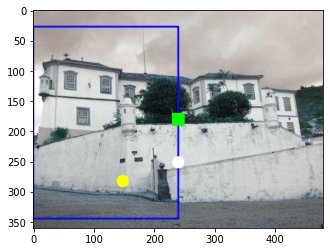

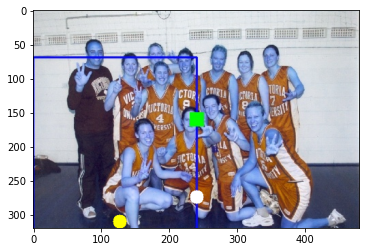

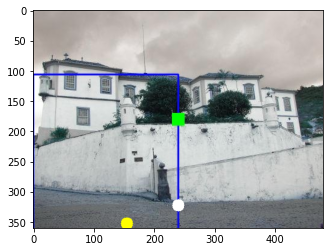

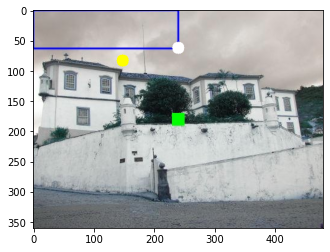

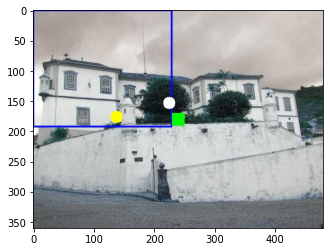

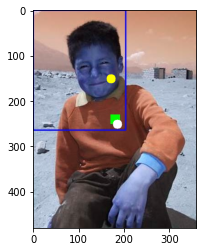

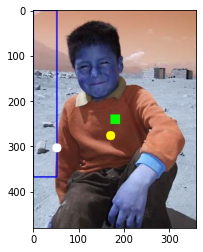

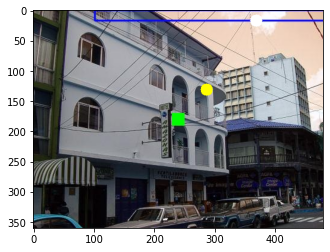

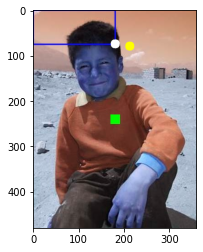

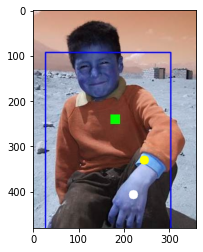

In [8]:
model = Net()
model = model.float()
model.load_state_dict(torch.load("pointing.pth"))
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

for epoch in range(100000):
    print("Epoch: ",epoch)
    running_loss = 0.0
    for i in range(40):
        
        optimizer.zero_grad()
        outputs = model(X[i])
#         outputs[0] = outputs[0]/outputs[2]
#         outputs[1] = outputs[1]/outputs[2]
#         outputs = outputs[0:2]
        loss = criterion(outputs, Y[i])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
#         outputs = [outputs[0]*360,outputs[1]*360]
#         gt = [Y[i][0]*360,Y[i][1]*360]
#         print(".....")
#         print("GT: ",gt)
#         print("output: ",outputs)
#         print(".....")
        #print(loss)
    print("Loss: ",running_loss / 50)
    torch.save(model.state_dict(), "pointing.pth")
plot_out(model)
    
    

In [9]:
a = -1.4291*7.5678+  0.4165*-21.8635  + 0.5456*-18.6027
print(a)
[-30.0721,  80.0445,  68.1869]

-30.07092385


[-30.0721, 80.0445, 68.1869]